In [1]:
!pip install mordred --no-index --find-links=file:///kaggle/input/mordred-dataset/

Looking in links: file:///kaggle/input/mordred-dataset/
Processing /kaggle/input/mordred-dataset/mordred-1.2.0-py3-none-any.whl
Processing /kaggle/input/mordred-dataset/networkx-2.8.8-py3-none-any.whl (from mordred)
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
nx-cugraph-cu12 25.2.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system =

In [2]:
!pip install /kaggle/input/k/tawaragiyuhei/rdkit-2025-3-3/rdkit-2025.3.6-cp311-cp311-manylinux_2_28_x86_64.whl

Processing /kaggle/input/k/tawaragiyuhei/rdkit-2025-3-3/rdkit-2025.3.6-cp311-cp311-manylinux_2_28_x86_64.whl


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl

import gc
import pickle

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

import lightgbm as lgb

from sklearn.model_selection import KFold

import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops

In [4]:
class CFG:
    TARGETS = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
    SEED = 42
    FOLDS = 5
    PATH = '/kaggle/input/neurips-open-polymer-prediction-2025/'

train = pd.read_csv(CFG.PATH + 'train.csv')
test = pd.read_csv(CFG.PATH + 'test.csv')
RDKIT_AVAILABLE = True
def clean_and_validate_smiles(smiles):
    if not isinstance(smiles, str) or len(smiles) == 0:
        return None
    bad_patterns = [
        '[R]', '[R1]', '[R2]', '[R3]', '[R4]', '[R5]',
        "[R']", '[R"]', 'R1', 'R2', 'R3', 'R4', 'R5',
        '([R])', '([R1])', '([R2])',
    ]
    for pattern in bad_patterns:
        if pattern in smiles:
            return None
    if '][' in smiles and any(x in smiles for x in ['[R', 'R]']):
        return None
    if RDKIT_AVAILABLE:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                return Chem.MolToSmiles(mol, canonical=True)
            else:
                return None
        except:
            return None
    return smiles

train['SMILES'] = train['SMILES'].apply(lambda s: clean_and_validate_smiles(s))
test['SMILES'] = test['SMILES'].apply(lambda s: clean_and_validate_smiles(s))

In [5]:
# https://www.kaggle.com/datasets/minatoyukinaxlisa/tc-smiles
data_tc = pd.read_csv('/kaggle/input/tc-extra-dataset/Tc_SMILES.csv')
data_tc = data_tc.rename(columns={'TC_mean': 'Tc'})

data_tc2 = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset1.csv')
data_tc2 = data_tc2.rename(columns={'TC_mean': 'Tc'})

# https://springernature.figshare.com/articles/dataset/dataset_with_glass_transition_temperature/24219958?file=42507037
data_tg2 = pd.read_csv('/kaggle/input/smiles-extra-dataset/smiles-extra-data/JCIM_sup_bigsmiles.csv', usecols=['SMILES', 'Tg (C)'])
data_tg2 = data_tg2.rename(columns={'Tg (C)': 'Tg'})

# https://www.sciencedirect.com/science/article/pii/S2590159123000377#ec0005
data_tg3 = pd.read_excel('/kaggle/input/smiles-extra-dataset/smiles-extra-data/data_tg3.xlsx')
data_tg3 = data_tg3.rename(columns={'Tg [K]': 'Tg'})
data_tg3['Tg'] = data_tg3['Tg'] - 273.15

data_tg4 = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset3.csv')

data_tg5 = pd.read_csv('/kaggle/input/tg-dataset/Tg_SMILES_class_pid_polyinfo_median.csv')

# https://github.com/Duke-MatSci/ChemProps
data_dnst = pd.read_excel('/kaggle/input/smiles-extra-dataset/smiles-extra-data/data_dnst1.xlsx')
data_dnst = data_dnst.rename(columns={'density(g/cm3)': 'Density'})[['SMILES', 'Density']]
data_dnst['SMILES'] = data_dnst['SMILES'].apply(lambda s: clean_and_validate_smiles(s))
data_dnst = data_dnst[(data_dnst['SMILES'].notnull())&(data_dnst['Density'].notnull())&(data_dnst['Density'] != 'nylon')]
data_dnst['Density'] = data_dnst['Density'].astype('float64')
data_dnst['Density'] -= 0.118

data_ffv = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset4.csv')

def add_extra_data(df_train, df_extra, target):
    n_samples_before = len(df_train[df_train[target].notnull()])
    
    df_extra['SMILES'] = df_extra['SMILES'].apply(lambda s: clean_and_validate_smiles(s))
    df_extra = df_extra.groupby('SMILES', as_index=False)[target].mean()
    cross_smiles = set(df_extra['SMILES']) & set(df_train['SMILES'])
    unique_smiles_extra = set(df_extra['SMILES']) - set(df_train['SMILES'])

    # Make priority target value from competition's df
    for smile in df_train[df_train[target].notnull()]['SMILES'].tolist():
        if smile in cross_smiles:
            cross_smiles.remove(smile)

    # Imput missing values for competition's SMILES
    for smile in cross_smiles:
        df_train.loc[df_train['SMILES']==smile, target] = df_extra[df_extra['SMILES']==smile][target].values[0]
    
    df_train = pd.concat([df_train, df_extra[df_extra['SMILES'].isin(unique_smiles_extra)]], axis=0).reset_index(drop=True)

    n_samples_after = len(df_train[df_train[target].notnull()])
    print(f'\nFor target "{target}" added {n_samples_after-n_samples_before} new samples!')
    print(f'New unique SMILES: {len(unique_smiles_extra)}')
    return df_train

train = add_extra_data(train, data_tc, 'Tc')
train = add_extra_data(train, data_tc2, 'Tc')
train = add_extra_data(train, data_tg2, 'Tg')
train = add_extra_data(train, data_tg3, 'Tg')
train = add_extra_data(train, data_tg4, 'Tg')
train = add_extra_data(train, data_tg5, 'Tg')
train = add_extra_data(train, data_dnst, 'Density')
train = add_extra_data(train, data_ffv, 'FFV')

print('\n'*3, '--- SMILES for training ---', )
for t in CFG.TARGETS:
    print(f'"{t}": {len(train[train[t].notnull()])}')


For target "Tc" added 129 new samples!
New unique SMILES: 129

For target "Tc" added 0 new samples!
New unique SMILES: 0

For target "Tg" added 151 new samples!
New unique SMILES: 136

For target "Tg" added 499 new samples!
New unique SMILES: 499

For target "Tg" added 0 new samples!
New unique SMILES: 0

For target "Tg" added 7083 new samples!
New unique SMILES: 1845

For target "Density" added 634 new samples!
New unique SMILES: 473

For target "FFV" added 862 new samples!
New unique SMILES: 272



 --- SMILES for training ---
"Tg": 8244
"FFV": 7892
"Tc": 866
"Density": 1247
"Rg": 614


In [6]:
# -*- coding: utf-8 -*-
"""
Polymer Backbone & Sidechain Features (Improved + extended)
Adds:
 - backbone_aromatic_fraction
 - sidechain_hbond_donors
 - sidechain_spacing_std
 - backbone_length
 - backbone_rotatable_bonds
 - sidechain_count
 - sidechain_length_mean
 - sidechain_hbond_acceptors
 - sidechain_density
 + additional:
 - backbone_molwt
 - backbone_tpsa
 - backbone_logp
 - backbone_hetero_frac
 - backbone_ring_fraction
 - sidechain_mass_mean
 - sidechain_tpsa_mean
 - sidechain_logp_mean
 - sidechain_branching_mean
 - sidechain_attach_density  (normalized sidechain_density)
 - sidechain_max_length
 - backbone_fraction_rotatable

Robust to invalid SMILES (returns NaN).
"""
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
import networkx as nx
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import multiprocessing
import math

# ---------------- helper utilities ----------------
def make_submol_by_atoms(mol, atom_indices):
    """Return a submolecule containing only atom_indices (list or set).
    Implemented by removing atoms not in atom_indices (reverse sorted removal)."""
    try:
        keep = set(int(x) for x in atom_indices)
        rw = Chem.RWMol(mol)
        # remove atoms not in keep; remove in descending order
        to_remove = [i for i in range(mol.GetNumAtoms()) if i not in keep]
        for idx in sorted(to_remove, reverse=True):
            try:
                rw.RemoveAtom(idx)
            except Exception:
                # if removal fails, ignore
                pass
        sub = rw.GetMol()
        Chem.SanitizeMol(sub, catchErrors=True)
        return sub
    except Exception:
        return None

# reuse process_polymer_smiles/find_best_backbone_path/count_backbone_rotatable_bonds/analyze_sidechains
def process_polymer_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None, []
        star_neighbors = []
        atoms_to_remove = []
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 0:
                for nbr in atom.GetNeighbors():
                    star_neighbors.append(nbr.GetIdx())
                atoms_to_remove.append(atom.GetIdx())
        if not atoms_to_remove:
            return mol, []
        rw = Chem.RWMol(mol)
        for idx in sorted(atoms_to_remove, reverse=True):
            rw.RemoveAtom(idx)
        new_mol = rw.GetMol()
        adjusted_neighbors = []
        for orig_idx in star_neighbors:
            adjustment = sum(1 for removed_idx in atoms_to_remove if removed_idx < orig_idx)
            adjusted_neighbors.append(orig_idx - adjustment)
        adjusted_neighbors = list(dict.fromkeys(adjusted_neighbors))
        return new_mol, adjusted_neighbors
    except Exception:
        return None, []

def find_best_backbone_path(mol, star_indices):
    n = mol.GetNumAtoms()
    if n == 0:
        return set()
    if len(star_indices) < 2:
        return set(range(n))
    try:
        adj = rdmolops.GetAdjacencyMatrix(mol)
        G = nx.from_numpy_array(adj)
        best_path = None
        best_len = -1
        si = star_indices
        for i in range(len(si)):
            for j in range(i+1, len(si)):
                a = si[i]; b = si[j]
                try:
                    path = nx.shortest_path(G, a, b)
                    if len(path) > best_len:
                        best_len = len(path)
                        best_path = path
                except Exception:
                    continue
        if best_path is None:
            return set(range(n))
        return set(best_path)
    except Exception:
        return set(range(mol.GetNumAtoms()))

def count_backbone_rotatable_bonds(mol, backbone_atoms):
    if mol is None or not backbone_atoms:
        return np.nan
    try:
        cnt = 0
        for bond in mol.GetBonds():
            a = bond.GetBeginAtomIdx()
            b = bond.GetEndAtomIdx()
            if a in backbone_atoms and b in backbone_atoms:
                if bond.GetBondType() != Chem.rdchem.BondType.SINGLE:
                    continue
                if bond.IsInRing():
                    continue
                atom_a = mol.GetAtomWithIdx(a)
                atom_b = mol.GetAtomWithIdx(b)
                na = sum(1 for nbr in atom_a.GetNeighbors() if nbr.GetAtomicNum() > 1 and nbr.GetIdx() != b)
                nb = sum(1 for nbr in atom_b.GetNeighbors() if nbr.GetAtomicNum() > 1 and nbr.GetIdx() != a)
                if na > 0 and nb > 0:
                    cnt += 1
        return int(cnt)
    except Exception:
        return np.nan

def analyze_sidechains(mol, backbone_atoms):
    try:
        n = mol.GetNumAtoms()
        if n == 0:
            return {
                'sidechain_count': np.nan,
                'sidechain_lengths': [],
                'sidechain_hbond_acceptors_total': np.nan,
                'sidechain_hbond_donors_total': np.nan,
                'sidechain_positions': [],
                'sidechain_components': []
            }
        adj = rdmolops.GetAdjacencyMatrix(mol)
        G = nx.from_numpy_array(adj)
        all_nodes = set(range(n))
        non_backbone_nodes = all_nodes - set(backbone_atoms)
        if not non_backbone_nodes:
            return {
                'sidechain_count': 0,
                'sidechain_lengths': [],
                'sidechain_hbond_acceptors_total': 0,
                'sidechain_hbond_donors_total': 0,
                'sidechain_positions': [],
                'sidechain_components': []
            }
        subG = G.subgraph(non_backbone_nodes)
        comps = list(nx.connected_components(subG))
        sidechain_lengths = []
        sidechain_acceptors = 0
        sidechain_donors = 0
        sidechain_positions = []
        sidechain_components = []
        acceptor_atomic_nums = {7,8,9,16}
        for comp in comps:
            attached = False
            attach_positions_local = set()
            for node in comp:
                for nbr in G.neighbors(node):
                    if int(nbr) in backbone_atoms:
                        attached = True
                        attach_positions_local.add(int(nbr))
            if not attached:
                continue
            heavy_count = sum(1 for idx in comp if mol.GetAtomWithIdx(int(idx)).GetAtomicNum() > 1)
            sidechain_lengths.append(heavy_count)
            sidechain_components.append(list(comp))
            for idx in comp:
                atom = mol.GetAtomWithIdx(int(idx))
                Z = atom.GetAtomicNum()
                if Z in acceptor_atomic_nums:
                    sidechain_acceptors += 1
                if Z in (7,8):
                    try:
                        sidechain_donors += atom.GetTotalNumHs()
                    except Exception:
                        sidechain_donors += sum(1 for nbr in atom.GetNeighbors() if nbr.GetAtomicNum()==1)
            for pos in attach_positions_local:
                sidechain_positions.append(pos)
        sidechain_count = len(sidechain_lengths)
        return {
            'sidechain_count': sidechain_count,
            'sidechain_lengths': sidechain_lengths,
            'sidechain_hbond_acceptors_total': sidechain_acceptors,
            'sidechain_hbond_donors_total': sidechain_donors,
            'sidechain_positions': sidechain_positions,
            'sidechain_components': sidechain_components
        }
    except Exception:
        return {
            'sidechain_count': np.nan,
            'sidechain_lengths': [],
            'sidechain_hbond_acceptors_total': np.nan,
            'sidechain_hbond_donors_total': np.nan,
            'sidechain_positions': [],
            'sidechain_components': []
        }

# ---------------- derived per-fragment RDKit descriptors ----------------
def safe_mol_descriptors(submol):
    """Compute MolWt (exact), TPSA, LogP for a submol. Returns tuple (molwt, tpsa, logp)."""
    try:
        if submol is None or submol.GetNumAtoms() == 0:
            return np.nan, np.nan, np.nan
        # sanitize to avoid issues
        try:
            Chem.SanitizeMol(submol, catchErrors=True)
        except Exception:
            pass
        molwt = rdMolDescriptors.CalcExactMolWt(submol)
        tpsa = rdMolDescriptors.CalcTPSA(submol)
        logp = Crippen.MolLogP(submol)
        return float(molwt), float(tpsa), float(logp)
    except Exception:
        return np.nan, np.nan, np.nan

def fragment_branching_degree(mol, comp_atom_indices):
    """Compute branching degree of a fragment: fraction of heavy atoms with deg>2 (heavy-degree branching)."""
    try:
        if not comp_atom_indices:
            return np.nan
        heavy_atoms = [idx for idx in comp_atom_indices if mol.GetAtomWithIdx(int(idx)).GetAtomicNum() > 1]
        if not heavy_atoms:
            return 0.0
        branching_counts = 0
        for idx in heavy_atoms:
            deg = sum(1 for nbr in mol.GetAtomWithIdx(int(idx)).GetNeighbors() if nbr.GetAtomicNum() > 1)
            if deg > 2:
                branching_counts += 1
        return branching_counts / len(heavy_atoms)
    except Exception:
        return np.nan

# ---------------- main feature calc for one smiles ----------------
def calculate_polymer_features(smiles):
    features = {
        'SMILES': smiles,
        'backbone_aromatic_fraction': np.nan,
        'sidechain_hbond_donors': np.nan,
        'sidechain_spacing_std': np.nan,
        'backbone_length': np.nan,
        'backbone_rotatable_bonds': np.nan,
        'sidechain_count': np.nan,
        'sidechain_length_mean': np.nan,
        'sidechain_hbond_acceptors': np.nan,
        'sidechain_density': np.nan,
        # new
        'backbone_molwt': np.nan,
        'backbone_tpsa': np.nan,
        'backbone_logp': np.nan,
        'backbone_hetero_frac': np.nan,
        'backbone_ring_fraction': np.nan,
        'sidechain_mass_mean': np.nan,
        'sidechain_tpsa_mean': np.nan,
        'sidechain_logp_mean': np.nan,
        'sidechain_branching_mean': np.nan,
        'sidechain_attach_density': np.nan,
        'sidechain_max_length': np.nan,
        'backbone_fraction_rotatable': np.nan
    }
    try:
        mol, star_indices = process_polymer_smiles(smiles)
        if mol is None:
            return features

        # backbone atoms set
        backbone_atoms = find_best_backbone_path(mol, star_indices)
        if not backbone_atoms:
            backbone_atoms = set(range(mol.GetNumAtoms()))

        # backbone heavy atoms
        backbone_heavy = sum(1 for idx in backbone_atoms if mol.GetAtomWithIdx(int(idx)).GetAtomicNum() > 1)
        features['backbone_length'] = int(backbone_heavy) if backbone_heavy is not None else np.nan

        # backbone aromatic fraction
        aromatic_count = 0
        for idx in backbone_atoms:
            atom = mol.GetAtomWithIdx(int(idx))
            if atom.GetAtomicNum() > 1 and atom.GetIsAromatic():
                aromatic_count += 1
        features['backbone_aromatic_fraction'] = (aromatic_count / backbone_heavy) if backbone_heavy > 0 else np.nan

        # backbone rotatable bonds
        rb = count_backbone_rotatable_bonds(mol, backbone_atoms)
        features['backbone_rotatable_bonds'] = int(rb) if (rb is not None and not math.isnan(rb)) else np.nan

        # backbone submol descriptors (MolWt, TPSA, LogP)
        try:
            backbone_submol = make_submol_by_atoms(mol, backbone_atoms)
            b_mw, b_tpsa, b_logp = safe_mol_descriptors(backbone_submol)
            features['backbone_molwt'] = b_mw
            features['backbone_tpsa'] = b_tpsa
            features['backbone_logp'] = b_logp
        except Exception:
            features['backbone_molwt'] = np.nan
            features['backbone_tpsa'] = np.nan
            features['backbone_logp'] = np.nan

        # backbone hetero fraction (N/O/S/F/Cl/Br/I etc considered hetero)
        atom_types = [mol.GetAtomWithIdx(i).GetSymbol() for i in range(mol.GetNumAtoms())]
        hetero = 0
        backbone_total = 0
        for idx in backbone_atoms:
            atom = mol.GetAtomWithIdx(int(idx))
            if atom.GetAtomicNum() > 1:
                backbone_total += 1
                if atom.GetSymbol() not in ('C', 'H'):
                    hetero += 1
        features['backbone_hetero_frac'] = (hetero / backbone_total) if backbone_total > 0 else np.nan

        # backbone ring fraction: how many backbone heavy atoms belong to rings / backbone heavy atoms
        try:
            ring_info = mol.GetRingInfo()
            atoms_in_rings = set()
            for ring in ring_info.AtomRings():
                for a in ring:
                    atoms_in_rings.add(a)
            backbone_ring_atoms = sum(1 for idx in backbone_atoms if idx in atoms_in_rings and mol.GetAtomWithIdx(int(idx)).GetAtomicNum() > 1)
            features['backbone_ring_fraction'] = (backbone_ring_atoms / backbone_heavy) if backbone_heavy > 0 else np.nan
        except Exception:
            features['backbone_ring_fraction'] = np.nan

        # analyze sidechains
        sc_info = analyze_sidechains(mol, backbone_atoms)
        sidechain_count = sc_info.get('sidechain_count', np.nan)
        features['sidechain_count'] = int(sidechain_count) if (sidechain_count is not None and not math.isnan(sidechain_count)) else np.nan

        lengths = sc_info.get('sidechain_lengths', [])
        features['sidechain_length_mean'] = float(np.mean(lengths)) if lengths else np.nan
        features['sidechain_hbond_acceptors'] = int(sc_info.get('sidechain_hbond_acceptors_total', np.nan)) if sc_info.get('sidechain_hbond_acceptors_total', np.nan) is not None else np.nan
        features['sidechain_hbond_donors'] = int(sc_info.get('sidechain_hbond_donors_total', np.nan)) if sc_info.get('sidechain_hbond_donors_total', np.nan) is not None else np.nan

        # sidechain density (existing) and attach density normalized (sidechains/backbone length)
        features['sidechain_density'] = (sidechain_count / backbone_heavy) if (backbone_heavy > 0 and not math.isnan(sidechain_count)) else np.nan
        features['sidechain_attach_density'] = features['sidechain_density']  # same idea; kept separate name

        # sidechain components: compute per-sidechain mass, tpsa, logp, branching
        comps = sc_info.get('sidechain_components', [])
        mass_list = []
        tpsa_list = []
        logp_list = []
        branching_list = []
        max_len = 0
        for comp in comps:
            # comp is list of atom indices
            heavy_count = sum(1 for idx in comp if mol.GetAtomWithIdx(int(idx)).GetAtomicNum() > 1)
            if heavy_count > max_len:
                max_len = heavy_count
            # build submol for this sidechain component
            try:
                submol = make_submol_by_atoms(mol, comp)
                m_mw, m_tpsa, m_logp = safe_mol_descriptors(submol)
                mass_list.append(m_mw if not math.isnan(m_mw) else np.nan)
                tpsa_list.append(m_tpsa if not math.isnan(m_tpsa) else np.nan)
                logp_list.append(m_logp if not math.isnan(m_logp) else np.nan)
            except Exception:
                mass_list.append(np.nan); tpsa_list.append(np.nan); logp_list.append(np.nan)
            # branching
            br = fragment_branching_degree(mol, comp)
            branching_list.append(br if not math.isnan(br) else np.nan)

        features['sidechain_mass_mean'] = float(np.nanmean(mass_list)) if mass_list else np.nan
        features['sidechain_tpsa_mean'] = float(np.nanmean(tpsa_list)) if tpsa_list else np.nan
        features['sidechain_logp_mean'] = float(np.nanmean(logp_list)) if logp_list else np.nan
        # branching mean: average across sidechains (ignore NaNs)
        features['sidechain_branching_mean'] = float(np.nanmean(branching_list)) if branching_list else np.nan
        features['sidechain_max_length'] = int(max_len) if max_len > 0 else np.nan

        # sidechain_hbond_donors already computed earlier stored in sc_info as total donors
        features['sidechain_hbond_donors'] = int(sc_info.get('sidechain_hbond_donors_total', 0)) if sc_info.get('sidechain_hbond_donors_total', 0) is not None else np.nan

        # sidechain_spacing_std
        positions = sc_info.get('sidechain_positions', [])
        if positions and len(positions) > 1:
            features['sidechain_spacing_std'] = float(np.std(positions))
        else:
            features['sidechain_spacing_std'] = np.nan

        # backbone_fraction_rotatable
        try:
            if backbone_heavy > 0 and features['backbone_rotatable_bonds'] is not None and not math.isnan(features['backbone_rotatable_bonds']):
                features['backbone_fraction_rotatable'] = features['backbone_rotatable_bonds'] / backbone_heavy
            else:
                features['backbone_fraction_rotatable'] = np.nan
        except Exception:
            features['backbone_fraction_rotatable'] = np.nan

    except Exception:
        # If anything fails, return features with NaNs
        pass

    return features

# ---------------- batch analyze ----------------
def analyze_polymers(smiles_list, n_jobs=-1):
    if n_jobs == -1:
        n_jobs = multiprocessing.cpu_count()
    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(calculate_polymer_features)(smi) for smi in tqdm(smiles_list, desc="Processing")
    )
    df = pd.DataFrame(results)
    df.set_index('SMILES', inplace=True)
    return df

# ---------------- example usage (merge into train/test) ----------------
if __name__ == '__main__':
    # Assume train/test DataFrames with 'SMILES' exist
    # E.g. train = pd.read_csv(...); test = pd.read_csv(...)
    train_features = analyze_polymers(train['SMILES'].tolist(), n_jobs=-1)
    test_features  = analyze_polymers(test['SMILES'].tolist(), n_jobs=-1)

    train = train.merge(train_features, left_on="SMILES", right_index=True, how='left')
    test  = test.merge(test_features, left_on="SMILES", right_index=True, how='left')

    Backbone_sidechain_features = [
        'backbone_aromatic_fraction',
        'sidechain_hbond_donors',
        'sidechain_spacing_std',
        'backbone_length',
        'backbone_rotatable_bonds',
        'sidechain_count',
        'sidechain_length_mean',
        'sidechain_hbond_acceptors',
        'sidechain_density',
        # new
        'backbone_molwt','backbone_tpsa','backbone_logp',
        'backbone_hetero_frac','backbone_ring_fraction',
        'sidechain_mass_mean','sidechain_tpsa_mean','sidechain_logp_mean',
        'sidechain_branching_mean','sidechain_attach_density','sidechain_max_length',
        'backbone_fraction_rotatable'
    ]
    print("Added features:", Backbone_sidechain_features)


Processing:   0%|          | 0/11327 [00:00<?, ?it/s]

[02:15:53] non-ring atom 1 marked aromatic
[02:15:53] non-ring atom 1 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 1 marked aromatic
[02:15:53] non-ring atom 1 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 1 marked aromatic
[02:15:53] non-ring atom 1 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] non-ring atom 2 marked aromatic
[02:15:53] non-ring atom 2 marked aromatic
[02:15:53] non-ring atom 0 marked aromatic
[02:15:53] 

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Added features: ['backbone_aromatic_fraction', 'sidechain_hbond_donors', 'sidechain_spacing_std', 'backbone_length', 'backbone_rotatable_bonds', 'sidechain_count', 'sidechain_length_mean', 'sidechain_hbond_acceptors', 'sidechain_density', 'backbone_molwt', 'backbone_tpsa', 'backbone_logp', 'backbone_hetero_frac', 'backbone_ring_fraction', 'sidechain_mass_mean', 'sidechain_tpsa_mean', 'sidechain_logp_mean', 'sidechain_branching_mean', 'sidechain_attach_density', 'sidechain_max_length', 'backbone_fraction_rotatable']


[02:16:19] non-ring atom 1 marked aromatic
[02:16:19] non-ring atom 1 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 1 marked aromatic
[02:16:19] non-ring atom 1 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] non-ring atom 0 marked aromatic
[02:16:19] 

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
import pandas as pd
import numpy as np
import warnings

# 分子の3D座標を生成（ETKDG + UFF）
def embed_3d_coordinates(smiles):
    # SMILESの'*'を'[At]'に置換（連結子を置換して有効な構造に）
    smiles = smiles.replace('*', '[At]')

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    mol = Chem.AddHs(mol)  # 水素追加

    try:
        params = AllChem.ETKDGv3()
        params.randomSeed = 42
        success = AllChem.EmbedMolecule(mol, params)
        if success != 0:
            return None  # 埋め込み失敗

        # UFFで構造最適化
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                AllChem.UFFOptimizeMolecule(mol, maxIters=500)
        except:
            return None

        return mol
    except:
        return None

# 追加の3D特徴量計算（extra_3d_cols）
def compute_extra_3d_descriptors(mol):
    if mol is None:
        return [np.nan] * 3

    try:
        pmi1 = rdMolDescriptors.CalcPMI1(mol)
        pmi2 = rdMolDescriptors.CalcPMI2(mol)
        pmi3 = rdMolDescriptors.CalcPMI3(mol)
        pmi1_to_pmi3 = pmi1 / pmi3 if pmi3 != 0 else np.nan
        pmi2_to_pmi3 = pmi2 / pmi3 if pmi3 != 0 else np.nan

        inertial_shape_factor = rdMolDescriptors.CalcInertialShapeFactor(mol)
        

        return [pmi1_to_pmi3, pmi2_to_pmi3, inertial_shape_factor]
    except:
        return [np.nan] * 3

# 3D記述子の抽出（MolWt_3Dを除外し、元の3D + 追加3D特徴量を計算）
def compute_3d_descriptors(mol):
    if mol is None:
        # MolWt_3Dは除外するので計9個 + 3個のextra = 12個（MolWt_3D除外）
        return [np.nan] * 12

    try:
        # mol_vol = rdMolDescriptors.CalcExactMolWt(mol)  # これを除外
        psa_3d = rdMolDescriptors.CalcTPSA(mol)
        asa = rdMolDescriptors.CalcLabuteASA(mol)
        pmi1 = rdMolDescriptors.CalcPMI1(mol)
        pmi2 = rdMolDescriptors.CalcPMI2(mol)
        pmi3 = rdMolDescriptors.CalcPMI3(mol)
        spher = rdMolDescriptors.CalcSpherocityIndex(mol)
        asp = rdMolDescriptors.CalcAsphericity(mol)
        ecc = rdMolDescriptors.CalcEccentricity(mol)
        rg = rdMolDescriptors.CalcRadiusOfGyration(mol)

        # 追加3D特徴量を取得
        extra_feats = compute_extra_3d_descriptors(mol)

        return [
            psa_3d, asa, pmi1, pmi2, pmi3,
            *extra_feats,
            spher, asp, ecc, rg
        ]
    except:
        return [np.nan] * 12

# 一括で3D特徴量を抽出
def compute_3d_features(smiles_list):
    results = []
    for smi in smiles_list:
        mol3d = embed_3d_coordinates(smi)
        feats = compute_3d_descriptors(mol3d)
        results.append(feats)

    columns = [
        'TPSA_3D', 'LabuteASA_3D',
        'PMI1', 'PMI2', 'PMI3',
        'PMI1_to_PMI3', 'PMI2_to_PMI3',
        'InertialShapeFactor',
        'SpherocityIndex', 'Asphericity', 'Eccentricity', 'RadiusOfGyration'
    ]
    return pd.DataFrame(results, columns=columns)

# train/testのSMILES列から3D特徴量を計算・結合
train_3d = compute_3d_features(train["SMILES"])
test_3d = compute_3d_features(test["SMILES"])

train = pd.concat([train, train_3d], axis=1)
test = pd.concat([test, test_3d], axis=1)

# 特徴量名リスト（MolWt_3D除外＆extra_3d_cols追加済み）
features_3d = [
    'TPSA_3D', 'LabuteASA_3D',
    'PMI1', 'PMI2', 'PMI3',
    'PMI1_to_PMI3', 'PMI2_to_PMI3',
    'InertialShapeFactor',
    'SpherocityIndex', 'Asphericity', 'Eccentricity', 'RadiusOfGyration'
]

[02:18:02] SMILES Parse Error: syntax error while parsing: [At]C=[CH][Ge]([[At]])([c]1ccccc1)[c]1ccccc1
[02:18:02] SMILES Parse Error: check for mistakes around position 17:
[02:18:02] [At]C=[CH][Ge]([[At]])([c]1ccccc1)[c]1ccc
[02:18:02] ~~~~~~~~~~~~~~~~^
[02:18:02] SMILES Parse Error: Failed parsing SMILES '[At]C=[CH][Ge]([[At]])([c]1ccccc1)[c]1ccccc1' for input: '[At]C=[CH][Ge]([[At]])([c]1ccccc1)[c]1ccccc1'
[02:39:26] UFFTYPER: Unrecognized atom type: Cd1+2 (18)
[02:39:26] UFFTYPER: Unrecognized atom type: Cd1+2 (18)
[02:40:35] UFFTYPER: Unrecognized atom type: Ca1+2 (2)
[02:40:35] UFFTYPER: Unrecognized atom type: Ca1+2 (2)
[02:44:22] UFFTYPER: Unrecognized atom type: Se2+2 (13)
[02:44:22] UFFTYPER: Unrecognized atom type: Se2+2 (13)
[02:45:38] UFFTYPER: Unrecognized atom type: S_6+6 (2)
[02:45:38] UFFTYPER: Unrecognized atom type: S_6+6 (2)
[02:52:29] SMILES Parse Error: syntax error while parsing: [At]/C=[CH]/[Ge]([[At]])([c]1ccccc1)[c]1ccccc1
[02:52:29] SMILES Parse Error: check

In [8]:
###Chembert
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import hdbscan


CHEMBERTA_DIR = "/kaggle/input/chemberta-mlm-dataset/ChemBERTa-77M-MLM"
device = torch.device("cpu")

tokenizer = RobertaTokenizer.from_pretrained(CHEMBERTA_DIR)
model = RobertaModel.from_pretrained(CHEMBERTA_DIR)
model.to(device)
model.eval()

def compute_chemberta_embedding(smiles_list, max_length=128):
    all_embeddings = []
    with torch.no_grad():
        for smiles in smiles_list:
            inputs = tokenizer(smiles, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length).to(device)
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
            all_embeddings.append(cls_embedding)
    return np.stack(all_embeddings)

def fit_hdbscan_clusters(embeddings, min_cluster_size, min_samples):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, prediction_data=True)
    cluster_labels = clusterer.fit_predict(embeddings)
    return clusterer, cluster_labels

def predict_hdbscan_clusters(embeddings, clusterer):
    cluster_labels, _ = hdbscan.approximate_predict(clusterer, embeddings)
    # ノイズ点(-1)は最大クラスタID+1に置換
    if np.any(cluster_labels == -1):
        max_cluster = cluster_labels.max()
        cluster_labels = np.where(cluster_labels == -1, max_cluster + 1, cluster_labels)
    return cluster_labels

# === trainデータでクラスタリング ===
print("🔵 Generating ChemBERTa embeddings for train...")
train_embeddings = compute_chemberta_embedding(train["SMILES"].tolist())

print("🔵 Scaling embeddings...")
scaler = StandardScaler()
train_emb_scaled = scaler.fit_transform(train_embeddings)

print("🔵 Running KMeans clustering on train...")
kmeans = KMeans(n_clusters=20, random_state=42, n_init="auto")
train_kmeans_labels = kmeans.fit_predict(train_emb_scaled)

print("🔵 Running HDBSCAN clustering set 1 on train...")
hdbscan1, train_hdbscan_labels_1 = fit_hdbscan_clusters(train_emb_scaled, min_cluster_size=25, min_samples=25)

print("🔵 Running HDBSCAN clustering set 2 on train...")
hdbscan2, train_hdbscan_labels_2 = fit_hdbscan_clusters(train_emb_scaled, min_cluster_size=30, min_samples=3)

# trainデータに追加
train['bert_cluster'] = train_kmeans_labels
train['hdbscan_cluster_1'] = train_hdbscan_labels_1
train['hdbscan_cluster_2'] = train_hdbscan_labels_2

# === testデータに適用 ===
print("🔵 Generating ChemBERTa embeddings for test...")
test_embeddings = compute_chemberta_embedding(test["SMILES"].tolist())

print("🔵 Scaling test embeddings...")
test_emb_scaled = scaler.transform(test_embeddings)

print("🔵 Predicting KMeans clusters for test...")
test_kmeans_labels = kmeans.predict(test_emb_scaled)

print("🔵 Predicting HDBSCAN clusters set 1 for test...")
test_hdbscan_labels_1 = predict_hdbscan_clusters(test_emb_scaled, hdbscan1)

print("🔵 Predicting HDBSCAN clusters set 2 for test...")
test_hdbscan_labels_2 = predict_hdbscan_clusters(test_emb_scaled, hdbscan2)

# testデータに追加
test['bert_cluster'] = test_kmeans_labels
test['hdbscan_cluster_1'] = test_hdbscan_labels_1
test['hdbscan_cluster_2'] = test_hdbscan_labels_2

# 特徴量名リスト
bert_cols = ['bert_cluster', 'hdbscan_cluster_1', 'hdbscan_cluster_2']
for col in ['bert_cluster', 'hdbscan_cluster_1', 'hdbscan_cluster_2']:
    cat_type = pd.api.types.CategoricalDtype(categories=train[col].unique())
    train[col] = train[col].astype(cat_type)
    test[col] = test[col].astype(cat_type)


2025-09-14 03:02:49.811476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757818970.058292      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757818970.128891      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🔵 Generating ChemBERTa embeddings for train...
🔵 Scaling embeddings...
🔵 Running KMeans clustering on train...
🔵 Running HDBSCAN clustering set 1 on train...
🔵 Running HDBSCAN clustering set 2 on train...
🔵 Generating ChemBERTa embeddings for test...
🔵 Scaling test embeddings...
🔵 Predicting KMeans clusters for test...
🔵 Predicting HDBSCAN clusters set 1 for test...
🔵 Predicting HDBSCAN clusters set 2 for test...


In [9]:
!pip install '/kaggle/input/selfies-2-2-0/selfies-2.2.0-py3-none-any.whl'

Processing /kaggle/input/selfies-2-2-0/selfies-2.2.0-py3-none-any.whl


In [10]:
### IBM-TED特徴量生成＋クラスタリング ###

from transformers import AutoTokenizer, AutoModel
import selfies as sf
import torch
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import hdbscan

# --- 1. 環境設定 ---
MODEL_DIR = "/kaggle/input/ibm-ted/local_model/selfies-ted"  # ローカルモデルのパス
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. モデルとトークナイザーのロード ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model = AutoModel.from_pretrained(MODEL_DIR, local_files_only=True)
model.to(device)
model.eval()

# --- 3. SELFIESエンコード用の安全関数 ---
def safe_selfies_encode(smiles):
    # 例: '*' を [At] (アルゴン)に置換してSELFIES変換対応
    smiles_fixed = smiles.replace("*", "[At]")
    smiles_fixed = smiles_fixed.replace("->", ".")
    try:
        selfies_str = sf.encoder(smiles_fixed)
        selfies_str = selfies_str.replace("][", "] [")  # tokenizer用整形
        return selfies_str
    except Exception as e:
        # 失敗したらNone返す or 例外処理（例: 空文字列などに置き換え）
        print(f"⚠️ SELFIES encode failed for SMILES: {smiles} -> {e}")
        return None

# --- 4. 特徴量計算関数 ---
def compute_ted_embedding(smiles_list, max_length=128):
    all_embeddings = []
    valid_indices = []  # 有効なSMILESインデックス保持
    with torch.no_grad():
        for i, smiles in enumerate(smiles_list):
            selfies_str = safe_selfies_encode(smiles)
            if selfies_str is None:
                continue  # 無効データはスキップ

            # トークン化・テンソル化
            token = tokenizer(
                selfies_str,
                return_tensors='pt',
                max_length=max_length,
                truncation=True,
                padding='max_length'
            ).to(device)
            
            input_ids = token['input_ids']
            attention_mask = token['attention_mask']
            
            # モデルのエンコーダーを通す
            outputs = model.encoder(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state  # [batch, seq_len, hidden_dim]
            
            # attention_maskに基づく平均プーリング
            mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            avg_embedding = (sum_embeddings / sum_mask).squeeze(0).cpu().numpy()
            
            all_embeddings.append(avg_embedding)
            valid_indices.append(i)

    all_embeddings = np.stack(all_embeddings)
    return all_embeddings, valid_indices

# --- 5. HDBSCAN クラスタリング関数 ---
def fit_hdbscan_clusters(embeddings, min_cluster_size, min_samples):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, prediction_data=True)
    cluster_labels = clusterer.fit_predict(embeddings)
    return clusterer, cluster_labels

def predict_hdbscan_clusters(embeddings, clusterer):
    cluster_labels, _ = hdbscan.approximate_predict(clusterer, embeddings)
    # ノイズ点(-1)は最大クラスタID+1に置換
    if np.any(cluster_labels == -1):
        max_cluster = cluster_labels.max()
        cluster_labels = np.where(cluster_labels == -1, max_cluster + 1, cluster_labels)
    return cluster_labels

# --- 6. データ処理部分 ---
# train と test は pandas.DataFrame で、
# 少なくとも "SMILES" カラムがある前提です。

# 例:
# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

print("🔵 Generating TED embeddings for train...")
train_embeddings, train_valid_idx = compute_ted_embedding(train["SMILES"].tolist())

# 有効なインデックスだけに絞る（無効なSMILESは特徴量なし）
train_valid_df = train.iloc[train_valid_idx].copy()

print("🔵 Scaling embeddings...")
scaler = StandardScaler()
train_emb_scaled = scaler.fit_transform(train_embeddings).astype("float64")

print("🔵 KMeans clustering...")
kmeans = KMeans(n_clusters=20, random_state=42, n_init="auto")
train_kmeans_labels = kmeans.fit_predict(train_emb_scaled)

print("🔵 HDBSCAN clustering set 1...")
hdbscan1, train_hdbscan_labels_1 = fit_hdbscan_clusters(train_emb_scaled, min_cluster_size=25, min_samples=25)

print("🔵 HDBSCAN clustering set 2...")
hdbscan2, train_hdbscan_labels_2 = fit_hdbscan_clusters(train_emb_scaled, min_cluster_size=30, min_samples=3)

# train_valid_df にクラスタリング結果を追加
train_valid_df['ted_cluster'] = train_kmeans_labels
train_valid_df['ted_hdbscan_1'] = train_hdbscan_labels_1
train_valid_df['ted_hdbscan_2'] = train_hdbscan_labels_2

# train全体のDataFrameに結果を戻す（無効SMILESはNaNのまま）
train = train.merge(
    train_valid_df[['ted_cluster', 'ted_hdbscan_1', 'ted_hdbscan_2']],
    left_index=True, right_index=True, how='left'
)

# --- testデータも同様に処理 ---
print("🔵 Generating TED embeddings for test...")
test_embeddings, test_valid_idx = compute_ted_embedding(test["SMILES"].tolist())

test_valid_df = test.iloc[test_valid_idx].copy()

print("🔵 Scaling test embeddings...")
test_emb_scaled = scaler.transform(test_embeddings).astype("float64")

print("🔵 Predicting KMeans clusters for test...")
test_kmeans_labels = kmeans.predict(test_emb_scaled)

print("🔵 Predicting HDBSCAN clusters set 1 for test...")
test_hdbscan_labels_1 = predict_hdbscan_clusters(test_emb_scaled, hdbscan1)

print("🔵 Predicting HDBSCAN clusters set 2 for test...")
test_hdbscan_labels_2 = predict_hdbscan_clusters(test_emb_scaled, hdbscan2)

# test_valid_dfにクラスタリング結果を追加
test_valid_df['ted_cluster'] = test_kmeans_labels
test_valid_df['ted_hdbscan_1'] = test_hdbscan_labels_1
test_valid_df['ted_hdbscan_2'] = test_hdbscan_labels_2

# test全体のDataFrameに結果を戻す（無効SMILESはNaNのまま）
test = test.merge(
    test_valid_df[['ted_cluster', 'ted_hdbscan_1', 'ted_hdbscan_2']],
    left_index=True, right_index=True, how='left'
)

# --- 7. カテゴリ型に型変換してカテゴリの順序を揃える ---
ted_cols = ['ted_cluster', 'ted_hdbscan_1', 'ted_hdbscan_2']
for col in ted_cols:
    # 欠損値を埋めずに、trainの非欠損カテゴリ一覧を取得
    train_cats = train[col].dropna().unique()

    # 欠損はそのままに、カテゴリ型を定義
    cat_type = pd.api.types.CategoricalDtype(categories=train_cats)

    # train, test のカテゴリ型を設定（欠損はそのままNaN）
    train[col] = train[col].astype(cat_type)
    test[col] = test[col].astype(cat_type)

print("✅ IBM-TED特徴量作成とクラスタリング完了！")


🔵 Generating TED embeddings for train...
⚠️ SELFIES encode failed for SMILES: *C=[CH][Ge]([*])([c]1ccccc1)[c]1ccccc1 -> failed to parse input
	SMILES: [At]C=[CH][Ge]([[At]])([c]1ccccc1)[c]1ccccc1
⚠️ SELFIES encode failed for SMILES: */C=[CH]/[Ge]([*])([c]1ccccc1)[c]1ccccc1 -> failed to parse input
	SMILES: [At]/C=[CH]/[Ge]([[At]])([c]1ccccc1)[c]1ccccc1
🔵 Scaling embeddings...
🔵 KMeans clustering...
🔵 HDBSCAN clustering set 1...
🔵 HDBSCAN clustering set 2...
🔵 Generating TED embeddings for test...
🔵 Scaling test embeddings...
🔵 Predicting KMeans clusters for test...
🔵 Predicting HDBSCAN clusters set 1 for test...
🔵 Predicting HDBSCAN clusters set 2 for test...
✅ IBM-TED特徴量作成とクラスタリング完了！


In [11]:
### Estate Fingerprint + Clustering (NaNを保持版) ###

from rdkit import Chem, RDLogger
from rdkit.Chem.EState import Fingerprinter
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import hdbscan

# RDKitの警告を無効化
RDLogger.DisableLog('rdApp.warning')
RDLogger.DisableLog('rdApp.error')

# --- 1. EStateフィンガープリントの計算関数 ---
def compute_estate_fp(smiles):
    """SMILES から 79次元 EState fingerprint を計算
    無効な SMILES は NaN ベクトルを返す
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.full(79, np.nan)
        fp, _ = Fingerprinter.FingerprintMol(mol)
        return np.array(fp)
    except Exception as e:
        print(f"Error computing EState for SMILES: {smiles}, Error: {e}")
        return np.full(79, np.nan)

# --- 2. HDBSCAN クラスタリング関数 ---
def fit_hdbscan_clusters(embeddings, min_cluster_size, min_samples):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                min_samples=min_samples,
                                prediction_data=True)
    cluster_labels = clusterer.fit_predict(embeddings)
    return clusterer, cluster_labels

def predict_hdbscan_clusters(embeddings, clusterer):
    cluster_labels, _ = hdbscan.approximate_predict(clusterer, embeddings)
    # ノイズ(-1)は最大クラスタID+1に置換
    if np.any(cluster_labels == -1):
        max_cluster = cluster_labels.max()
        cluster_labels = np.where(cluster_labels == -1, max_cluster + 1, cluster_labels)
    return cluster_labels

# --- 3. 指定した estate ビットでクラスタリング ---
def cluster_estate_selected_bits(train_smiles, test_smiles, selected_bits):
    # 1. fingerprint 計算
    train_fp_full = np.array([compute_estate_fp(smi) for smi in train_smiles])
    test_fp_full = np.array([compute_estate_fp(smi) for smi in test_smiles])
    
    # 2. 指定ビット抽出
    train_fp = train_fp_full[:, selected_bits]
    test_fp = test_fp_full[:, selected_bits]

    # 3. 有効データのみ抽出（NaNを含まない行）
    mask_valid_train = ~np.isnan(train_fp).any(axis=1)
    mask_valid_test  = ~np.isnan(test_fp).any(axis=1)

    train_fp_valid = train_fp[mask_valid_train]
    test_fp_valid  = test_fp[mask_valid_test]

    # 4. 標準化
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_fp_valid).astype("float32")
    test_scaled  = scaler.transform(test_fp_valid).astype("float32")

    # 5. KMeans クラスタリング
    kmeans = KMeans(n_clusters=20, random_state=42, n_init="auto")
    train_kmeans_labels = kmeans.fit_predict(train_scaled)
    test_kmeans_labels  = kmeans.predict(test_scaled)

    # 6. HDBSCAN クラスタリング1
    hdbscan1, train_hdb_labels_1 = fit_hdbscan_clusters(train_scaled, min_cluster_size=25, min_samples=25)
    test_hdb_labels_1 = predict_hdbscan_clusters(test_scaled, hdbscan1)

    # 7. HDBSCAN クラスタリング2
    hdbscan2, train_hdb_labels_2 = fit_hdbscan_clusters(train_scaled, min_cluster_size=30, min_samples=3)
    test_hdb_labels_2 = predict_hdbscan_clusters(test_scaled, hdbscan2)

    # 8. NaN を保持したクラスタ列を作る
    cluster_results_train = {
        'estate_kmeans': np.full(len(train_smiles), np.nan),
        'estate_hdbscan_1': np.full(len(train_smiles), np.nan),
        'estate_hdbscan_2': np.full(len(train_smiles), np.nan)
    }
    cluster_results_test = {
        'estate_kmeans': np.full(len(test_smiles), np.nan),
        'estate_hdbscan_1': np.full(len(test_smiles), np.nan),
        'estate_hdbscan_2': np.full(len(test_smiles), np.nan)
    }

    # 有効データにクラスタ割り当て
    cluster_results_train['estate_kmeans'][mask_valid_train] = train_kmeans_labels
    cluster_results_train['estate_hdbscan_1'][mask_valid_train] = train_hdb_labels_1
    cluster_results_train['estate_hdbscan_2'][mask_valid_train] = train_hdb_labels_2

    cluster_results_test['estate_kmeans'][mask_valid_test] = test_kmeans_labels
    cluster_results_test['estate_hdbscan_1'][mask_valid_test] = test_hdb_labels_1
    cluster_results_test['estate_hdbscan_2'][mask_valid_test] = test_hdb_labels_2

    return cluster_results_train, cluster_results_test

# --- 4. 実行例 ---
selected_estate_bits = [
    4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24,
    25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 44,
    45, 47, 48, 49, 50, 51, 52, 53, 57, 65, 66, 69, 73, 74
]

print("=== Clustering selected estate fingerprint bits on train/test datasets ===")
train_clusters, test_clusters = cluster_estate_selected_bits(train["SMILES"].tolist(),
                                                            test["SMILES"].tolist(),
                                                            selected_estate_bits)

# --- 5. train/test にクラスタリング列を追加 ---
estate_fingerprint = ['estate_kmeans', 'estate_hdbscan_1', 'estate_hdbscan_2']

for key, labels in train_clusters.items():
    train[key] = labels
    cat_type = pd.api.types.CategoricalDtype(categories=np.unique(labels[~np.isnan(labels)]))
    train[key] = train[key].astype(cat_type)

for key, labels in test_clusters.items():
    test[key] = labels
    cat_type = train[key].dtype
    test[key] = test[key].astype(cat_type)

print("✅ Selected estate fingerprint clustering features added to train and test.")


=== Clustering selected estate fingerprint bits on train/test datasets ===
✅ Selected estate fingerprint clustering features added to train and test.


In [12]:
### maccs, torsion, atompair fingerprint clustering (無効SMILESはNaN保持版) ###
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import AllChem, rdMolDescriptors, MACCSkeys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import hdbscan
import warnings

# RDKitの警告を非表示
RDLogger.DisableLog('rdApp.warning')
RDLogger.DisableLog('rdApp.error')

# --- 各フィンガープリント計算関数 ---
def compute_maccs_fp(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = MACCSkeys.GenMACCSKeys(mol)
        return np.array([int(x) for x in fp.ToBitString()])
    except:
        return None

def compute_torsion_fp(smiles, nBits=2048):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=nBits)
        return np.array([int(x) for x in fp.ToBitString()])
    except:
        return None

def compute_atompair_fp(smiles, nBits=2048):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=nBits)
        return np.array([int(x) for x in fp.ToBitString()])
    except:
        return None

# --- クラスタリング共通関数 ---
def fit_hdbscan_clusters(embeddings, min_cluster_size, min_samples):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, prediction_data=True)
    cluster_labels = clusterer.fit_predict(embeddings)
    return clusterer, cluster_labels

def predict_hdbscan_clusters(embeddings, clusterer):
    cluster_labels, _ = hdbscan.approximate_predict(clusterer, embeddings)
    if np.any(cluster_labels == -1):
        max_cluster = cluster_labels.max()
        cluster_labels = np.where(cluster_labels == -1, max_cluster + 1, cluster_labels)
    return cluster_labels

# --- 有効SMILESだけでクラスタリングする関数 ---
def cluster_fingerprint(train_smiles, test_smiles, fp_func):
    # --- 有効インデックスを抽出 ---
    train_fp_list, train_valid_idx = [], []
    for i, smi in enumerate(train_smiles):
        fp = fp_func(smi)
        if fp is not None:
            train_fp_list.append(fp)
            train_valid_idx.append(i)
    train_fp_array = np.stack(train_fp_list)

    test_fp_list, test_valid_idx = [], []
    for i, smi in enumerate(test_smiles):
        fp = fp_func(smi)
        if fp is not None:
            test_fp_list.append(fp)
            test_valid_idx.append(i)
    test_fp_array = np.stack(test_fp_list)

    # --- スケーリング ---
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_fp_array).astype("float32")
    test_scaled = scaler.transform(test_fp_array).astype("float32")

    # --- クラスタリング ---
    # KMeans
    kmeans = KMeans(n_clusters=20, random_state=42, n_init="auto")
    train_kmeans_labels = kmeans.fit_predict(train_scaled)
    test_kmeans_labels = kmeans.predict(test_scaled)

    # HDBSCAN1
    hdbscan1, train_hdb_labels_1 = fit_hdbscan_clusters(train_scaled, min_cluster_size=25, min_samples=25)
    test_hdb_labels_1 = predict_hdbscan_clusters(test_scaled, hdbscan1)

    # HDBSCAN2
    hdbscan2, train_hdb_labels_2 = fit_hdbscan_clusters(train_scaled, min_cluster_size=30, min_samples=3)
    test_hdb_labels_2 = predict_hdbscan_clusters(test_scaled, hdbscan2)

    # --- DataFrameに戻す ---
    train_labels_df = pd.DataFrame(index=range(len(train_smiles)))
    train_labels_df.loc[train_valid_idx, 'kmeans'] = train_kmeans_labels
    train_labels_df.loc[train_valid_idx, 'hdbscan_1'] = train_hdb_labels_1
    train_labels_df.loc[train_valid_idx, 'hdbscan_2'] = train_hdb_labels_2

    test_labels_df = pd.DataFrame(index=range(len(test_smiles)))
    test_labels_df.loc[test_valid_idx, 'kmeans'] = test_kmeans_labels
    test_labels_df.loc[test_valid_idx, 'hdbscan_1'] = test_hdb_labels_1
    test_labels_df.loc[test_valid_idx, 'hdbscan_2'] = test_hdb_labels_2

    return train_labels_df, test_labels_df

# --- 実行例 ---
train_maccs, test_maccs = cluster_fingerprint(train["SMILES"], test["SMILES"], compute_maccs_fp)
train_torsion, test_torsion = cluster_fingerprint(train["SMILES"], test["SMILES"], compute_torsion_fp)
train_atompair, test_atompair = cluster_fingerprint(train["SMILES"], test["SMILES"], compute_atompair_fp)

# --- DataFrameに追加 ---
fp_cluster_cols = [
    "maccs_kmeans", "maccs_hdbscan_1", "maccs_hdbscan_2",
    "torsion_kmeans", "torsion_hdbscan_1", "torsion_hdbscan_2",
    "atompair_kmeans", "atompair_hdbscan_1", "atompair_hdbscan_2"
]

# MACCS
for key in ['kmeans', 'hdbscan_1', 'hdbscan_2']:
    train[f"maccs_{key}"] = train_maccs[key]
    test[f"maccs_{key}"] = test_maccs[key]

# Torsion
for key in ['kmeans', 'hdbscan_1', 'hdbscan_2']:
    train[f"torsion_{key}"] = train_torsion[key]
    test[f"torsion_{key}"] = test_torsion[key]

# AtomPair
for key in ['kmeans', 'hdbscan_1', 'hdbscan_2']:
    train[f"atompair_{key}"] = train_atompair[key]
    test[f"atompair_{key}"] = test_atompair[key]

# --- カテゴリ型に揃える ---
for col in fp_cluster_cols:
    categories = list(set(train[col].dropna().unique()) | set(test[col].dropna().unique()))
    train[col] = pd.Categorical(train[col], categories=categories)
    test[col] = pd.Categorical(test[col], categories=categories)

print("✅ Fingerprint clustering features added & NaN preserved for invalid SMILES:", fp_cluster_cols)


✅ Fingerprint clustering features added & NaN preserved for invalid SMILES: ['maccs_kmeans', 'maccs_hdbscan_1', 'maccs_hdbscan_2', 'torsion_kmeans', 'torsion_hdbscan_1', 'torsion_hdbscan_2', 'atompair_kmeans', 'atompair_hdbscan_1', 'atompair_hdbscan_2']


In [13]:
### preprocessing with NaN for invalid SMILES

from rdkit import Chem
from rdkit.Chem import Descriptors, rdmolops
from mordred import Calculator, descriptors
import pandas as pd
import numpy as np
import networkx as nx

# 無効な列は除外
useless_cols = [
    'MaxPartialCharge',
    'BCUT2D_MWHI','BCUT2D_MWLOW','BCUT2D_CHGHI','BCUT2D_CHGLO',
    'BCUT2D_LOGPHI','BCUT2D_LOGPLOW','BCUT2D_MRHI','BCUT2D_MRLOW',
    'NumRadicalElectrons','SMR_VSA8','SlogP_VSA9','fr_barbitur','fr_benzodiazepine',
    'fr_dihydropyridine','fr_epoxide','fr_isothiocyan','fr_lactam','fr_nitroso',
    'fr_prisulfonamd','fr_thiocyan',
    # High correlation >0.95
    'MaxEStateIndex','HeavyAtomMolWt','ExactMolWt','NumValenceElectrons','Chi0','Chi0n',
    'Chi0v','Chi1','Chi1n','Chi1v','Chi2n','Kappa1','LabuteASA','HeavyAtomCount','MolMR',
    'Chi3n','BertzCT','Chi2v','Chi4n','HallKierAlpha','Chi3v','Chi4v','MinAbsPartialCharge',
    'MinPartialCharge','MaxAbsPartialCharge','FpDensityMorgan2','FpDensityMorgan3','Phi',
    'Kappa3','fr_nitrile','SlogP_VSA6','NumAromaticCarbocycles','NumAromaticRings','fr_benzene',
    'VSA_EState6','NOCount','fr_C_O','fr_C_O_noCOO','NumHDonors','fr_amide','fr_Nhpyrrole',
    'fr_phenol','fr_phenol_noOrthoHbond','fr_COO2','fr_halogen','fr_diazo','fr_nitro_arom',
    'fr_phos_ester'
]

# 追加 Mordred descriptors
mordred_calc = Calculator([
    descriptors.Weight,         # AMW
    descriptors.InformationContent,  # TIC2
    descriptors.RingCount,      # naRing
    descriptors.PathCount        # MPC3
], ignore_3D=True)
mordred_cols = ['AMW', 'TIC2', 'naRing', 'MPC3']

# 追加グラフ特徴量
extra_graph_keys = [
    'max_degree', 'closeness_mean', 'katz_centrality_std',
    'betweenness_mean', 'betweenness_std', 'eigenvector_mean',
    'ring_4', 'heteroatom_ratio'
]

# --- Molecular descriptors ---
def compute_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * len(desc_names)
    return [desc[1](mol) for desc in Descriptors.descList if desc[0] not in useless_cols]

# --- Mordred descriptors ---
def compute_mordred_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * 4
    try:
        result = mordred_calc(mol)
        desc_dict = dict(zip(mordred_calc.descriptors, result))
        amw = next((v for k, v in desc_dict.items() if 'AMW' in str(k)), np.nan)
        tic2 = next((v for k, v in desc_dict.items() if 'TIC2' in str(k)), np.nan)
        naring = next((v for k, v in desc_dict.items() if 'naRing' in str(k)), np.nan)
        mpc3 = next((v for k, v in desc_dict.items() if 'MPC3' in str(k)), np.nan)
        return [float(amw), float(tic2), float(naring), float(mpc3)]
    except:
        return [np.nan] * 4

# --- Graph features ---
def compute_all_graph_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    n_keys = 3 + len(extra_graph_keys)
    if mol is None:
        return [np.nan] * n_keys

    try:
        adj = rdmolops.GetAdjacencyMatrix(mol)
        G = nx.from_numpy_array(adj)
        cycles = list(nx.cycle_basis(G))
        n_nodes = G.number_of_nodes()

        # 基本グラフ特徴量
        graph_diameter = nx.diameter(G) if nx.is_connected(G) else np.nan
        avg_shortest_path = nx.average_shortest_path_length(G) if nx.is_connected(G) else np.nan
        num_cycles = len(cycles)

        # 追加特徴量
        max_degree = max([d for n, d in G.degree()]) if n_nodes > 0 else np.nan
        closeness = list(nx.closeness_centrality(G).values()) if nx.is_connected(G) else [np.nan]
        closeness_mean = np.mean(closeness)

        try:
            katz = list(nx.katz_centrality(G, max_iter=1000).values())
            katz_centrality_std = np.std(katz)
        except:
            katz_centrality_std = np.nan

        betweenness = list(nx.betweenness_centrality(G).values())
        betweenness_mean = np.mean(betweenness)
        betweenness_std = np.std(betweenness)

        try:
            eigen = list(nx.eigenvector_centrality(G, max_iter=1000).values())
            eigenvector_mean = np.mean(eigen)
        except:
            eigenvector_mean = np.nan

        ring_4 = sum(1 for cycle in cycles if len(cycle) == 4)
        atom_types = [atom.GetSymbol() for atom in mol.GetAtoms()]
        hetero = len(atom_types) - atom_types.count('C')
        heteroatom_ratio = hetero / len(atom_types) if atom_types else np.nan

        return [
            graph_diameter, avg_shortest_path, num_cycles,
            max_degree, closeness_mean, katz_centrality_std,
            betweenness_mean, betweenness_std, eigenvector_mean,
            ring_4, heteroatom_ratio
        ]
    except:
        return [np.nan] * n_keys

# --- Preprocessing ---
def preprocessing(df):
    global desc_names
    desc_names = [desc[0] for desc in Descriptors.descList if desc[0] not in useless_cols]

    descriptors_feats = [compute_all_descriptors(smi) for smi in df['SMILES']]
    mordred_feats = [compute_mordred_descriptors(smi) for smi in df['SMILES']]
    graph_feats = [compute_all_graph_features(smi) for smi in df['SMILES']]

    result = pd.concat([
        pd.DataFrame(descriptors_feats, columns=desc_names),
        pd.DataFrame(graph_feats, columns=['graph_diameter', 'avg_shortest_path', 'num_cycles'] + extra_graph_keys),
        pd.DataFrame(mordred_feats, columns=mordred_cols)
    ], axis=1)

    result = result.replace([-np.inf, np.inf], np.nan)
    return result

# --- 実行 ---
train = pd.concat([train, preprocessing(train)], axis=1)
test = pd.concat([test, preprocessing(test)], axis=1)

# Find constant columns for each target
all_features = train.columns[7:].tolist()
features = {}
for target in CFG.TARGETS:
    const_descs = []
    for col in train.columns.drop(CFG.TARGETS):
        if train[train[target].notnull()][col].nunique() == 1:
            const_descs.append(col)
    features[target] = [f for f in all_features if f not in const_descs]
    
# 特徴量リスト
desc_names = [desc[0] for desc in Descriptors.descList if desc[0] not in useless_cols]
graph_feats = ['graph_diameter', 'avg_shortest_path', 'num_cycles'] + extra_graph_keys


In [14]:
### T-SMILES 特徴量インストール
import os
import subprocess

# .whl が置いてあるフォルダ
whl_dir = "/kaggle/input/t-smiles/"

# フォルダ内の全ての .whl ファイルを取得
# pandas, numpy, scikit-learn は除外
whl_files = [
    os.path.join(whl_dir, f)
    for f in os.listdir(whl_dir)
    if f.endswith(".whl")
    and "numpy" not in f.lower()
    and "scikit" not in f.lower()
    and "pandas" not in f.lower()
]

# 依存関係も含めて順番にインストール
for whl in whl_files:
    print(f"Installing {whl} ...")
    subprocess.run(
        ["pip", "install", "--no-index", "--find-links", whl_dir, whl],
        check=True
    )

print("✅ T-SMILES 関連パッケージのインストール完了（pandas は除外）")


Installing /kaggle/input/t-smiles/kiwisolver-1.4.9-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/kiwisolver-1.4.9-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl
  Attempting uninstall: kiwisolver
    Found existing installation: kiwisolver 1.4.8
    Uninstalling kiwisolver-1.4.8:
      Successfully uninstalled kiwisolver-1.4.8


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


Installing /kaggle/input/t-smiles/joblib-1.5.1-py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/joblib-1.5.1-py3-none-any.whl
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
    Uninstalling joblib-1.5.0:
      Successfully uninstalled joblib-1.5.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


Installing /kaggle/input/t-smiles/levenshtein-0.27.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/levenshtein-0.27.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/t-smiles/rapidfuzz-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from levenshtein==0.27.1)
Installing /kaggle/input/t-smiles/tqdm-4.67.1-py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/tqdm-4.67.1-py3-none-any.whl
tqdm is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Installing /kaggle/input/t-smiles/platformdirs-4.3.8-py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/platformdirs-4.3.8-py3-none-any.whl
platformdirs is already installed with the same version as the provided wheel. Use --force-reinstall to

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


Installing /kaggle/input/t-smiles/datamol-0.12.5-py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/datamol-0.12.5-py3-none-any.whl
Processing /kaggle/input/t-smiles/loguru-0.7.3-py3-none-any.whl (from datamol==0.12.5)
Installing /kaggle/input/t-smiles/selfies-2.2.0-py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/selfies-2.2.0-py3-none-any.whl
selfies is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Installing /kaggle/input/t-smiles/rdkit-2025.3.5-cp311-cp311-manylinux_2_28_x86_64.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/rdkit-2025.3.5-cp311-cp311-manylinux_2_28_x86_64.whl
  Attempting uninstall: rdkit
    Found existing installation: rdkit 2025.3.6
    Uninstalling rdkit-2025.3.6:
      Successfully uninstalled rdkit-2025.3.6
Installing /kaggle/input/t-smiles/pillow-11.3.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


Installing /kaggle/input/t-smiles/typing_extensions-4.14.1-py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/typing_extensions-4.14.1-py3-none-any.whl
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.13.2
    Uninstalling typing_extensions-4.13.2:
      Successfully uninstalled typing_extensions-4.13.2
Installing /kaggle/input/t-smiles/six-1.17.0-py2.py3-none-any.whl ...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
ibis-framework 9.5.0 requires toolz<1,>=0.11, but you have toolz 1.0.0 which is incompatible.
langchain-core 0.3.50 requires packaging<25,>=23.2, but you have packaging 25.0 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-c

Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/six-1.17.0-py2.py3-none-any.whl
six is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Installing /kaggle/input/t-smiles/scipy-1.16.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/scipy-1.16.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.16.1 which is incompatible.
ydata-profiling 4.16.1 requires scipy<1.16,>=1.4.1, but you have scipy 1.16.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


Installing /kaggle/input/t-smiles/threadpoolctl-3.6.0-py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/threadpoolctl-3.6.0-py3-none-any.whl
threadpoolctl is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Installing /kaggle/input/t-smiles/loguru-0.7.3-py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/loguru-0.7.3-py3-none-any.whl
loguru is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Installing /kaggle/input/t-smiles/pyparsing-3.2.3-py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/pyparsing-3.2.3-py3-none-any.whl
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.7.2 requires pyparsing<3.1,>=2.3.1, but you have pyparsing 3.2.3 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


Installing /kaggle/input/t-smiles/python_dateutil-2.9.0.post0-py2.py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/python_dateutil-2.9.0.post0-py2.py3-none-any.whl
python-dateutil is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Installing /kaggle/input/t-smiles/packaging-25.0-py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/packaging-25.0-py3-none-any.whl
packaging is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Installing /kaggle/input/t-smiles/rapidfuzz-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/rapidfuzz-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
rapidfuzz is already installed with the same version as the prov

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.7.2 requires pyparsing<3.1,>=2.3.1, but you have pyparsing 3.2.3 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


Installing /kaggle/input/t-smiles/matplotlib-3.10.5-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/matplotlib-3.10.5-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.5 which is incompatible.
ydata-profiling 4.16.1 requires scipy<1.16,>=1.4.1, but you have scipy 1.16.1 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


Installing /kaggle/input/t-smiles/fsspec-2025.7.0-py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/fsspec-2025.7.0-py3-none-any.whl
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.7.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.4.0.6 which is inco

Installing /kaggle/input/t-smiles/tzdata-2025.2-py2.py3-none-any.whl ...
Looking in links: /kaggle/input/t-smiles/
Processing /kaggle/input/t-smiles/tzdata-2025.2-py2.py3-none-any.whl
tzdata is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
✅ T-SMILES 関連パッケージのインストール完了（pandas は除外）


In [15]:
!mkdir /kaggle/working/t-SMILES/t-SMILES/MolUtils/rBRICS
!mv /kaggle/input/t-smiles/rBRICS_public.py /kaggle/working/t-SMILES/t-SMILES/MolUtils/rBRICS
!mkdir /kaggle/working/t-SMILES/t-SMILES/MolUtils/datamol
!cd /kaggle/working/t-SMILES/t-SMILES/MolUtils/
import shutil
import os

src_dir = "/kaggle/input/t-smiles/MolUtils/datamol"  # コピー元フォルダ
dst_dir = "/kaggle/working/t-SMILES/t-SMILES/MolUtils/datamol"  # コピー先フォルダ

# コピー先ディレクトリがなければ作成
os.makedirs(os.path.dirname(dst_dir), exist_ok=True)

# フォルダごとコピー
shutil.copytree(src_dir, dst_dir)
print("コピー完了")

mkdir: cannot create directory ‘/kaggle/working/t-SMILES/t-SMILES/MolUtils/rBRICS’: No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


mv: cannot stat '/kaggle/input/t-smiles/rBRICS_public.py': No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


mkdir: cannot create directory ‘/kaggle/working/t-SMILES/t-SMILES/MolUtils/datamol’: No such file or directory
/bin/bash: line 1: cd: /kaggle/working/t-SMILES/t-SMILES/MolUtils/: No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


コピー完了


In [16]:
!cp -r /kaggle/input/t-smiles/t-SMILES/t-SMILES/DataSet /kaggle/working/
!cp -r /kaggle/input/t-smiles/t-SMILES/t-SMILES/MolUtils /kaggle/working/
!cp -r /kaggle/input/t-smiles/t-SMILES/t-SMILES/Tools /kaggle/working/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
###T-SMILES(文字)
import pandas as pd
from tqdm import tqdm
from typing import List, Optional
from DataSet.STDTokens import CTokens, STDTokens_Frag_File
from MolUtils.RDKUtils.Frag.RDKFragUtil import Fragment_Alg
from DataSet.Graph.CNJTMol import CNJMolUtils

def compute_tsmiles_combinations(
    smiles_list: List[str],
    max_length: int = 256,
    invalid: bool = True,
    onehot: bool = False,
    progress_desc: str = "Processing SMILES"
) -> pd.DataFrame:
    """
    Compute all T-SMILES combinations for a list of SMILES strings.
    
    Parameters:
    -----------
    smiles_list : List[str]
        List of SMILES strings to process
    max_length : int, default=256
        Maximum length for CTokens
    invalid : bool, default=True
        Invalid parameter for CTokens
    onehot : bool, default=False
        One-hot encoding parameter for CTokens
    progress_desc : str, default="Processing SMILES"
        Description for the progress bar
        
    Returns:
    --------
    pd.DataFrame
        DataFrame where each row corresponds to a SMILES from the input list,
        and columns contain different T-SMILES variants (TSSA/TSDY, TSID, TSIS)
        for each fragmentation algorithm.
    """
    
    # Define fragmentation algorithms
    dec_algs = [
        Fragment_Alg.Vanilla,
        Fragment_Alg.JTVAE,
        Fragment_Alg.BRICS,
        Fragment_Alg.BRICS_Base,
        Fragment_Alg.MMPA,
        Fragment_Alg.Scaffold,
        Fragment_Alg.BRICS_DY,
        Fragment_Alg.MMPA_DY,
        Fragment_Alg.Scaffold_DY,
        Fragment_Alg.RBrics_DY,
    ]
    
    # Initialize CTokens
    ctoken = CTokens(STDTokens_Frag_File(None), max_length=max_length, 
                     invalid=invalid, onehot=onehot)
    
    # Prepare result dictionary
    results = {
        'SMILES': [],
        'Index': []  # To maintain original order
    }
    
    # Initialize columns for each algorithm and T-SMILES type
    for alg in dec_algs:
        alg_name = alg.name
        results[f'{alg_name}_TSSA_TSDY'] = []
        results[f'{alg_name}_TSID'] = []
        results[f'{alg_name}_TSIS'] = []
    
    # Process each SMILES with progress bar
    for idx, smiles in enumerate(tqdm(smiles_list, desc=progress_desc)):
        results['SMILES'].append(smiles)
        results['Index'].append(idx)
        
        # Process with each algorithm
        for dec_alg in dec_algs:
            alg_name = dec_alg.name
            
            try:
                # Encode the SMILES using the current algorithm
                combine_sml, combine_smt, amt_bfs_smarts = CNJMolUtils.encode_single(
                    smiles, ctoken, dec_alg
                )
                
                # Store results
                results[f'{alg_name}_TSSA_TSDY'].append(combine_sml)
                results[f'{alg_name}_TSID'].append(combine_smt)
                results[f'{alg_name}_TSIS'].append(amt_bfs_smarts)
                
            except Exception as e:
                # Handle encoding errors gracefully
                print(f"Error processing SMILES '{smiles}' with {alg_name}: {str(e)}")
                results[f'{alg_name}_TSSA_TSDY'].append(None)
                results[f'{alg_name}_TSID'].append(None)
                results[f'{alg_name}_TSIS'].append(None)
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Ensure original order is maintained (though it should be by default)
    df = df.sort_values('Index').reset_index(drop=True)
    
    return df


def compute_tsmiles_combinations_parallel(
    smiles_list: List[str],
    max_length: int = 256,
    invalid: bool = True,
    onehot: bool = False,
    n_jobs: int = -1,
    progress_desc: str = "Processing SMILES"
) -> pd.DataFrame:
    """
    Compute all T-SMILES combinations for a list of SMILES strings using parallel processing.
    
    Parameters:
    -----------
    smiles_list : List[str]
        List of SMILES strings to process
    max_length : int, default=256
        Maximum length for CTokens
    invalid : bool, default=True
        Invalid parameter for CTokens
    onehot : bool, default=False
        One-hot encoding parameter for CTokens
    n_jobs : int, default=-1
        Number of parallel jobs (-1 uses all available cores)
    progress_desc : str, default="Processing SMILES"
        Description for the progress bar
        
    Returns:
    --------
    pd.DataFrame
        DataFrame where each row corresponds to a SMILES from the input list,
        and columns contain different T-SMILES variants for each fragmentation algorithm.
    """
    from joblib import Parallel, delayed
    
    # Define fragmentation algorithms
    dec_algs = [
        Fragment_Alg.Vanilla,
        Fragment_Alg.JTVAE,
        Fragment_Alg.BRICS,
        Fragment_Alg.BRICS_Base,
        Fragment_Alg.MMPA,
        Fragment_Alg.Scaffold,
        Fragment_Alg.BRICS_DY,
        Fragment_Alg.MMPA_DY,
        Fragment_Alg.Scaffold_DY,
        Fragment_Alg.RBrics_DY,
    ]
    
    def process_single_smiles(smiles, idx):
        """Process a single SMILES string with all algorithms."""
        ctoken = CTokens(STDTokens_Frag_File(None), max_length=max_length, 
                        invalid=invalid, onehot=onehot)
        
        result = {
            'SMILES': smiles,
            'Index': idx
        }
        
        for dec_alg in dec_algs:
            alg_name = dec_alg.name
            
            try:
                combine_sml, combine_smt, amt_bfs_smarts = CNJMolUtils.encode_single(
                    smiles, ctoken, dec_alg
                )
                
                result[f'{alg_name}_TSSA_TSDY'] = combine_sml
                result[f'{alg_name}_TSID'] = combine_smt
                result[f'{alg_name}_TSIS'] = amt_bfs_smarts
                
            except Exception as e:
                print(f"Error processing SMILES '{smiles}' with {alg_name}: {str(e)}")
                result[f'{alg_name}_TSSA_TSDY'] = None
                result[f'{alg_name}_TSID'] = None
                result[f'{alg_name}_TSIS'] = None
        
        return result
    
    # Process in parallel with progress bar
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_single_smiles)(smiles, idx) 
        for idx, smiles in enumerate(tqdm(smiles_list, desc=progress_desc))
    )
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Ensure original order is maintained
    df = df.sort_values('Index').reset_index(drop=True)
    
    return df
train_smiles = train['SMILES'].tolist()
test_smiles  = test['SMILES'].tolist()
# train データの T-SMILES 特徴量生成
train_tsmiles_df = compute_tsmiles_combinations_parallel(
    train_smiles,
    max_length=256,
    invalid=True,
    onehot=False,
    n_jobs=-1,
    progress_desc="Train T-SMILES"
)

# test データの T-SMILES 特徴量生成
test_tsmiles_df = compute_tsmiles_combinations_parallel(
    test_smiles,
    max_length=256,
    invalid=True,
    onehot=False,
    n_jobs=-1,
    progress_desc="Test T-SMILES"
)
train = pd.concat([train.reset_index(drop=True), 
                            train_tsmiles_df.drop(columns=['Index'])], axis=1)
test = pd.concat([test.reset_index(drop=True), 
                            test_tsmiles_df.drop(columns=['Index'])], axis=1)
# フラグメントアルゴリズム名
alg_names = [
    'Vanilla', 'JTVAE', 'BRICS', 'BRICS_Base', 'MMPA', 'Scaffold',
    'BRICS_DY', 'MMPA_DY', 'Scaffold_DY', 'RBrics_DY'
]

# T-SMILES形式
ts_types = ['TSSA_TSDY', 'TSID', 'TSIS']

# 列名リストを生成
T_SMILES_cols = [f"{alg}_{ts}" for alg in alg_names for ts in ts_types]

Train T-SMILES:   1%|          | 64/11327 [00:06<10:45, 17.46it/s]

Mol could not be Bricsed: *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)c(-c3ccc(C)cc3)c2-c2ccc(C)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)CCCCCCCCC(=O)OC1COC2C(*)COC12
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)CCCCCCCCC(=O)OC1COC2C(*)COC12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)CCCCCCCCC(=O)OC1COC2C(*)COC12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCOC1=CC=C2C=C(C(=O)OC3=CC=CC=C3)C=CC2=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCOc1ccc2cc(C(=O)Oc3ccccc3)ccc2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCCCCOc1ccc2cc(C(=O)Oc3ccccc3)ccc2c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object 

Train T-SMILES:   1%|          | 72/11327 [00:07<13:03, 14.36it/s]

('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=CC=C1C(=O)OCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccccc1C(=O)OCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccccc1C(=O)OCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)c1ccc(C(=O)O)c(C(=O)O)c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(C(=O)O)C(C(=O)O)=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc(C(=O)O)c(C(=O)O)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(C(=O)O)c(C(=O)O)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(C(=O)c3ccc(Cc4ccc(C(=O)c5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)cc3

Train T-SMILES:   1%|          | 84/11327 [00:07<10:37, 17.63it/s]

('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(S(=O)(=O)C2=CC=C(OC3=CC=C(C4(C5=CC=C(OC6=CC=C(S(=O)(=O)C7=CC=C(OC8=CC=C(C=C9CCCC(=CC%10=CC=C(*)C=C%10)C9=O)C=C8)C=C7)C=C6)C=C5)CCCCC4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(S(=O)(=O)c7ccc(Oc8ccc(C=C9CCCC(=Cc%10ccc(*)cc%10)C9=O)cc8)cc7)cc6)cc5)CCCCC4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(S(=O)(=O)c7ccc(Oc8ccc(C=C9CCCC(=Cc%10ccc(*)cc%10)C9=O)cc8)cc7)cc6)cc5)CCCCC4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(-c2ccc(-c3ccc(N*)cc3)cc2)cc1
Mol could not be Bricsed: *c1ccc(-c2ccc3c(c2)C(CCCCCCC#N)(CCCCCCC#N)c2cc(*)ccc2-3)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC=C3C4=CC=C(*)C=C4C(CCCCCCC#N)(CCCCCCC#N)C3=C2)C=

Train T-SMILES:   1%|          | 92/11327 [00:08<09:36, 19.49it/s]

Mol could not be Bricsed: *Nc1ccc([C@H]2[C@@H]3C[C@H]4C[C@@H](C3)C[C@@H]2C4)cc1N*
[convert_to_nx] remove circle: *NC1=CC=C([C@H]2[C@@H]3C[C@H]4C[C@@H](C3)C[C@@H]2C4)C=C1N*
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(OC2=CC=C(OC3=CC=C(NC(=O)C4=CC=C5C(=O)N(C6=CC=C(OC7=CC=C(C8(C9=CC=C(OC%10=CC=C(N%11C(=O)C%12=CC=C(*)C=C%12C%11=O)C=C%10)C=C9)CC9CC8C8CCCC98)C=C7)C=C6)C(=O)C5=C4)C=C3)C(C(C)(C)C)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(Oc2ccc(Oc3ccc(NC(=O)c4ccc5C(=O)N(c6ccc(Oc7ccc(C8(c9ccc(Oc%10ccc(N%11C(=O)c%12ccc(*)cc%12C%11=O)cc%10)cc9)CC9CC8C8CCCC98)cc7)cc6)C(=O)c5c4)cc3)c(C(C)(C)C)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc2ccc(Oc3ccc(NC(=O)c4ccc5c(c4)C(=O)N(c4ccc(Oc6ccc(C7(c8ccc(Oc9ccc(N%10C(=O)c%11ccc(*)cc%11C%10=O)cc9)cc8)CC8CC7C7CCCC87)cc6)cc4)C5=O)cc3)c(C(C)(C)C)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object h

Train T-SMILES:   1%|          | 120/11327 [00:10<11:59, 15.57it/s]

 non-ring atom 7 marked aromatic
(AtomKekulizeException('non-ring atom 7 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(OCCN(CC)c2ccc(C(C#N)=C(C#N)C#N)cc2)c(-c2cc(-c3ccccc3)c3cc(Oc4ccc5nc(*)cc(-c6ccccc6)c5c4)ccc3n2)c1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCSSCCCCSS*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCSSCCCCSS*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCSSCCCCSS*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCOCO*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCOCO*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCOCO*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(=O)c3c

Train T-SMILES:   1%|          | 140/11327 [00:11<13:12, 14.11it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCCCOC(=O)C1=CC=CC(C(=O)O*)=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCOC(=O)c1cccc(C(=O)O*)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCOC(=O)c1cccc(C(=O)O*)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(S(=O)(=O)c2ccc(N3C(=O)c4ccc(Oc5ccc(C(C)(C)c6ccc(Oc7ccc8c(c7)C(=O)N(*)C8=O)cc6)cc5)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(S(=O)(=O)C2=CC=C(N3C(=O)C4=CC=C(OC5=CC=C(C(C)(C)C6=CC=C(OC7=CC=C8C(=O)N(*)C(=O)C8=C7)C=C6)C=C5)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(S(=O)(=O)c2ccc(N3C(=O)c4ccc(Oc5ccc(C(C)(C)c6ccc(Oc7ccc8C(=O)N(*)C(=O)c8c7)cc6)cc5)cc4C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c

Train T-SMILES:   1%|▏         | 144/11327 [00:12<13:18, 14.01it/s]


('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(C2(C3=CC=C(N4C(=O)C5=CC=C(*)C=C5C4=O)C=C3)CCC(C)CC2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(C2(c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)CCC(C)CC2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(C2(c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)CCC(C)CC2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(C2(c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)CCC(C)CC2)cc1
Mol could not be Bricsed: *CC(C)S(*)(=O)=O
('atomNote',)
RDKFragMMPA Exception:  *CC(C)S(*)(=O)=O
('atomNote',)
RDKFragMMPA Exception:  *CC(C)S(*)(=O)=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with 

Train T-SMILES:   1%|▏         | 168/11327 [00:13<10:39, 17.46it/s]


RDKFragMMPA Exception:  *C=C(*)c1ccc(-n2c(=O)c3cc4c(cc3c2=O)c(=O)n(-c2ccc(C#C)cc2)c4=O)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=C(*)c1ccc(-n2c(=O)c3cc4c(=O)n(-c5ccc(C#C)cc5)c(=O)c4cc3c2=O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 8 marked aromatic
(AtomKekulizeException('non-ring atom 8 marked aromatic'),)
RDKFragRBrics Exception:  *C=C(*)c1ccc(-n2c(=O)c3cc4c(cc3c2=O)c(=O)n(-c2ccc(C#C)cc2)c4=O)cc1
Mol could not be Bricsed: *O[Si](C)(C)c1ccc2ccc([Si](*)(C)C)cc2c1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *O[Si](C)(C)c1ccc2ccc([Si](*)(C)C)cc2c1
('atomNote',)
RDKFragMMPA Exception:  *CC(C)(C)C1C(=O)N(C2=C(C)C=CC=C2C)C(=O)C1*
('atomNote',)
RDKFrag

Train T-SMILES:   2%|▏         | 180/11327 [00:14<13:58, 13.29it/s]

 *CCN(*)C(=O)c1cc(F)cc(F)c1F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=CC(C(=O)NC4=CC=C(OC5=CC=C(C(C6=CC=C(OC7=CC=C(NC(=O)C8=CC=CC(N9C(=O)C%10=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C%10C9=O)=C8)C=C7)C=C6)(C(F)(F)F)C(F)(F)F)C=C5)C=C4)=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3cccc(C(=O)Nc4ccc(Oc5ccc(C(c6ccc(Oc7ccc(NC(=O)c8cccc(N9C(=O)c%10ccc(C(*)(C(F)(F)F)C(F)(F)F)cc%10C9=O)c8)cc7)cc6)(C(F)(F)F)C(F)(F)F)cc5)cc4)c3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1cccc(C(=O)Nc3ccc(Oc4ccc(C(c5ccc(Oc6ccc(NC(=O)c7cccc(N8C(=O)c9ccc(C(*)(C(F)(F)F)C(F)(F)F)cc9C8=O)c7)cc6)cc5)(C(F)(F)F)C(F)(F)F)cc4)cc3)c1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags

Train T-SMILES:   2%|▏         | 212/11327 [00:16<12:25, 14.91it/s]


[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc2ccc(-c3ccc(Oc4ccc(NC(=O)c5ccc6c(c5)C(=O)N(c5ccc(Oc7ccc(S(=O)(=O)c8ccc(Oc9ccc(N%10C(=O)c%11ccc(*)cc%11C%10=O)cc9)cc8)cc7)cc5)C6=O)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Oc2ccc(-c3ccc(Oc4ccc(NC(=O)c5ccc6C(=O)N(c7ccc(Oc8ccc(S(=O)(=O)c9ccc(Oc%10ccc(N%11C(=O)c%12ccc(*)cc%12C%11=O)cc%10)cc9)cc8)cc7)C(=O)c6c5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(OCCCCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCCCCCCOC2=CC=CC(C3=NN=C(*)S3)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(OCCCCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCCCCCCOc2cccc(-c3nnc(*)s3)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc

Train T-SMILES:   2%|▏         | 220/11327 [00:16<10:12, 18.15it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(C(=O)c3ccc(Oc4ccc(N5C(=O)c6ccc(Oc7cccc(Oc8ccc9C(=O)N(*)C(=O)c9c8)c7)cc6C5=O)cc4)cc3)cc2)cc1
Mol could not be Bricsed: *Oc1cccc(C(=O)c2ccc(*)cc2)c1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=CC(C(=O)C2=CC=C(*)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc(C(=O)c2ccc(*)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc(C(=O)c2ccc(*)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2c(c1)c1cc(*)ccc1n2CC
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=C1)C1=CC(*)=CC=C1N2CC
('atomNote',)
RDKFragMMPA Exception:  

Train T-SMILES:   2%|▏         | 232/11327 [00:17<11:21, 16.28it/s]

 *C1=CC=C(C2=CC=C(C(*)(C3=CC=CC=C3)C(F)(F)F)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2ccc(C(*)(c3ccccc3)C(F)(F)F)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc(C(*)(c3ccccc3)C(F)(F)F)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CCCCCCCCCCn1c(=O)c2cc3c(=O)n(*)c(=O)c3c(Br)c2c1=O
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCN1C(=O)C2=CC3=C(C(Br)=C2C1=O)C(=O)N(*)C3=O
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCn1c(=O)c2cc3c(c(Br)c2c1=O)c(=O)n(*)c3=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCn1c(=O)c2cc3c(=O)n(*)c(=O)c3c(Br)c2c1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem

Train T-SMILES:   2%|▏         | 264/11327 [00:19<10:40, 17.27it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2cnc3ccc(S(=O)(=O)c4ccc5ncc(*)nc5c4)cc3n2)cc1
Mol could not be Bricsed: *Nc1ccc(-c2ccc(N*)c(-c3ccc(C)cc3)c2-c2ccc(C)cc2)cc1
Mol could not be Bricsed: *Oc1ccc(S(=O)(=O)c2ccc(Oc3c(C)cc(Cc4cc(C)c(*)c(C)c4)cc3C)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(S(=O)(=O)C2=CC=C(OC3=C(C)C=C(CC4=CC(C)=C(*)C(C)=C4)C=C3C)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(S(=O)(=O)c2ccc(Oc3c(C)cc(Cc4cc(C)c(*)c(C)c4)cc3C)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(S(=O)(=O)c2ccc(Oc3c(C)cc(Cc4cc(C)c(*)c(C)c4)cc3C)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bf

Train T-SMILES:   3%|▎         | 288/11327 [00:21<11:58, 15.36it/s]

 *OC1=CC=C(SC2=CC=C(OC3=CC=C(C4=CC=C(C5=CC=C(C6=CC=C(*)C(C(F)(F)F)=C6)C=C5)C=C4)C=C3C(F)(F)F)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(Sc2ccc(Oc3ccc(-c4ccc(-c5ccc(-c6ccc(*)c(C(F)(F)F)c6)cc5)cc4)cc3C(F)(F)F)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Sc2ccc(Oc3ccc(-c4ccc(-c5ccc(-c6ccc(*)c(C(F)(F)F)c6)cc5)cc4)cc3C(F)(F)F)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC(C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC(C)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OC(C)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)O

Train T-SMILES:   3%|▎         | 308/11327 [00:22<08:19, 22.07it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)cc4)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OC(OCC)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OC(OCC)C(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OC(OCC)C(F)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCN(CCOC(=O)C1=CC=C2C(=O)N(C3=CC=C(N=NC4=CC=C(C(C#N)=C(C#N)C#N)C=C4)C(N4C(=O)C5=CC=C(*)C=C5C4=O)=C3)C(=O)C2=C1)C1=CC=C(N=NC2=CC=C(C(C#N)=C(C#N)C#N)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCN(CCOC(=O)c1ccc2C(=O)N(c3c

Train T-SMILES:   3%|▎         | 324/11327 [00:23<14:26, 12.70it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCCCCC)C(=O)OCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCCCCC)C(=O)OCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(CC(=O)OCCCCC)C(=O)OCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)OCCOCCOC(=O)OC1COC2C(*)COC12
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)OCCOCCOC(=O)OC1COC2C(*)COC12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)OCCOCCOC(=O)OC1COC2C(*)COC12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCOC1=CC=C(C=C(C)C2=CC=C(O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCOc1ccc(C=C(C)c2ccc(O*)c

Train T-SMILES:   3%|▎         | 328/11327 [00:23<15:31, 11.81it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1cccc2ccc(Oc3ccc(NC(=O)c4ccc(Oc5ccccc5Oc5ccc(C(=O)Nc6ccc(*)cc6)cc5)cc4)cc3)cc12
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)C(C)NC(=O)CCCCCCCCCCC(=O)NC(C)C(=O)OC1COC2C(*)COC12
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)C(C)NC(=O)CCCCCCCCCCC(=O)NC(C)C(=O)OC1COC2C(*)COC12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)C(C)NC(=O)CCCCCCCCCCC(=O)NC(C)C(=O)OC1COC2C(*)COC12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(Cc3ccc(C(=O)c4cccc(N5C(=O)c6ccc(*)cc6C5=O)c4)cc3)cc1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)

Train T-SMILES:   3%|▎         | 352/11327 [00:25<11:26, 15.98it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)[Si](C)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc(Sc7ccc(Oc8ccc9c(c8)C(=O)N(*)C9=O)cc7)cc6)cc5C4=O)cc3)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=CC(OC3=CC=C(N4C(=O)C5=CC=C(OC6=CC=C(SC7=CC=C(OC8=CC=C9C(=O)N(*)C(=O)C9=C8)C=C7)C=C6)C=C5C4=O)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc(Sc7ccc(Oc8ccc9C(=O)N(*)C(=O)c9c8)cc7)cc6)cc5C4=O)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc(Sc7ccc(Oc8ccc9c(c8)C(=O)N(*)C9=O)cc7)cc6)cc5C4=O)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt

Train T-SMILES:   3%|▎         | 380/11327 [00:27<10:23, 17.56it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C=Cc1c(OC(=O)c2ccc(C(=O)Oc3cccc4ccc(*)nc34)cc2)ccc2ccccc12
('atomNote',)
RDKFragMMPA Exception:  *CC(O)COC1=CC=C(C(C)(C)C2=CC=C(OCC(O)CN3CCN(*)CC3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)COc1ccc(C(C)(C)c2ccc(OCC(O)CN3CCN(*)CC3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O)COc1ccc(C(C)(C)c2ccc(OCC(O)CN3CCN(*)CC3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1=CC(OCC(CC)CCCC)=C(*)C=C1C1=CC=C(N(C2=CC=C(OC)C=C2)C2=CC=C(OC)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  */C=C/c1cc(OCC(CC)CCCC)c(*)cc1-c1ccc(N(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_

Train T-SMILES:   3%|▎         | 388/11327 [00:27<10:36, 17.18it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *ON(C(F)(F)F)C(F)(Cl)C(*)(F)F
('atomNote',)
RDKFragMMPA Exception:  *ON(C(F)(F)F)C(F)(Cl)C(*)(F)F
('atomNote',)
RDKFragMMPA Exception:  *ON(C(F)(F)F)C(F)(Cl)C(*)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *ON(C(F)(F)F)C(F)(Cl)C(*)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(Nc2ccc(S(=O)(=O)c3ccc(Nc4ccc(Oc5ccc(C(C)(C)c6ccc(*)cc6)cc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC2=CC=C(S(=O)(=O)C3=CC=C(NC4=CC=C(OC5=CC=C(C(C)(C)C6=CC=C(*)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(Nc2ccc(S(=O)(=O)c3ccc(Nc4ccc(Oc5ccc(C(C)(C)c6ccc(*)cc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy

Train T-SMILES:   3%|▎         | 392/11327 [00:27<11:27, 15.90it/s]


[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(N5C(=O)c6ccc(Oc7cccc(Oc8ccc9c(c8)C(=O)N(*)C9=O)c7)cc6C5=O)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(N5C(=O)c6ccc(Oc7cccc(Oc8ccc9C(=O)N(*)C(=O)c9c8)c7)cc6C5=O)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(OC(=O)C(CC1=CC=CC=C1)NC(=O)OC(C)(C)C)C(COC(=O)O*)OC(=O)C(CC1=CC=CC=C1)NC(=O)OC(C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *CC(OC(=O)C(Cc1ccccc1)NC(=O)OC(C)(C)C)C(COC(=O)O*)OC(=O)C(Cc1ccccc1)NC(=O)OC(C)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(OC(=O)C(Cc1ccccc1)NC(=O)OC(C)(C)C)C(COC(=O)O*)OC(=O)C(Cc1ccccc1)NC(=O)OC(C)(C)C
[CNJMolUtils.encode_si

Train T-SMILES:   4%|▎         | 424/11327 [00:30<13:26, 13.52it/s]


[MolTree.init].Exception-smiles: *CCN(*)C(=O)c1ccc(F)c(F)c1F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C1CCCCC1S(*)(=O)=O
('atomNote',)
RDKFragMMPA Exception:  *C1CCCCC1S(*)(=O)=O
('atomNote',)
RDKFragMMPA Exception:  *C1CCCCC1S(*)(=O)=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1CCCCC1S(*)(=O)=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5ccccc5Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(N3C(=O)C4=CC=C(OC5=CC=CC=C5OC5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5ccccc5Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'du

Train T-SMILES:   4%|▍         | 436/11327 [00:31<11:36, 15.64it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(N5C(=O)c6ccc(Oc7c(C)cc(C(C)(C)c8cc(C)c(Oc9ccc%10C(=O)N(*)C(=O)c%10c9)c(C)c8)cc7C)cc6C5=O)cc4)cc3C)c(C)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(N5C(=O)c6ccc(Oc7c(C)cc(C(C)(C)c8cc(C)c(Oc9ccc%10c(c9)C(=O)N(*)C%10=O)c(C)c8)cc7C)cc6C5=O)cc4)cc3C)c(C)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(N5C(=O)c6ccc(Oc7c(C)cc(C(C)(C)c8cc(C)c(Oc9ccc%10C(=O)N(*)C(=O)c%10c9)c(C)c8)cc7C)cc6C5=O)cc4)cc3C)c(C)c2)cc1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBr

Train T-SMILES:   4%|▍         | 448/11327 [00:31<12:48, 14.15it/s]

 *c1ccc2c(c1)C(=O)N(c1cccc(C(F)(F)C(F)(F)C(F)(F)c3cccc(N4C(=O)c5ccc(C(F)(F)C(F)(F)C(*)(F)F)cc5C4=O)c3)c1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=CC(C(F)(F)C(F)(F)C(F)(F)C4=CC=CC(N5C(=O)C6=CC=C(C(F)(F)C(F)(F)C(*)(F)F)C=C6C5=O)=C4)=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3cccc(C(F)(F)C(F)(F)C(F)(F)c4cccc(N5C(=O)c6ccc(C(F)(F)C(F)(F)C(*)(F)F)cc6C5=O)c4)c3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1cccc(C(F)(F)C(F)(F)C(F)(F)c3cccc(N4C(=O)c5ccc(C(F)(F)C(F)(F)C(*)(F)F)cc5C4=O)c3)c1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3cccc(C(F)(F)C(F)(F)C(F)(F)c4cccc(N5C(=O)c6ccc(C(F)(F)

Train T-SMILES:   4%|▍         | 452/11327 [00:32<12:54, 14.04it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCOC(=O)NCCCCCCNC(=O)O*)c1ccc(/N=N/c2ccc([N+](=O)[O-])cc2)c(C)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5ccc(Oc6cc7ccccc7cc6Oc6ccc7c(c6)C(=O)N(*)C7=O)cc5C4=O)cc3)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=CC(OC3=CC=C(N4C(=O)C5=CC=C(OC6=CC7=CC=CC=C7C=C6OC6=CC=C7C(=O)N(*)C(=O)C7=C6)C=C5C4=O)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5ccc(Oc6cc7ccccc7cc6Oc6ccc7C(=O)N(*)C(=O)c7c6)cc5C4=O)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5ccc(Oc6cc7ccccc7cc6Oc6ccc7c(c6)C(=O)N(*)C7=O)cc5C4=O)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' objec

Train T-SMILES:   4%|▍         | 488/11327 [00:34<10:14, 17.63it/s]


('atomNote',)
RDKFragMMPA Exception:  *C(=C(*)C1=CC=C(C(C)(C)C)C=C1)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=C(*)c1ccc(C(C)(C)C)cc1)c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=C(*)c1ccc(C(C)(C)C)cc1)c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(-c2nc3ccc(-c4ccc5nc(*)c(-c6ccccc6)c(-c6ccccc6)c5c4)cc3c(-c3ccccc3)c2-c2ccccc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=NC3=CC=C(C4=CC=C5N=C(*)C(C6=CC=CC=C6)=C(C6=CC=CC=C6)C5=C4)C=C3C(C3=CC=CC=C3)=C2C2=CC=CC=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2nc3ccc(-c4ccc5nc(*)c(-c6ccccc6)c(-c6ccccc6)c5c4)cc3c(-c3ccccc3)c2-c2ccccc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2nc3ccc(-c4ccc5nc(*

Train T-SMILES:   4%|▍         | 504/11327 [00:35<12:17, 14.67it/s]

 *c1c(C)cc(Cc2cc(C)c(N3C(=O)c4ccc(Oc5c(C)cc(Cc6cc(C)c(Oc7ccc8c(c7)C(=O)N(*)C8=O)c(C)c6)cc5C)cc4C3=O)c(C)c2)cc1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1c(C)cc(Cc2cc(C)c(N3C(=O)c4ccc(Oc5c(C)cc(Cc6cc(C)c(Oc7ccc8C(=O)N(*)C(=O)c8c7)c(C)c6)cc5C)cc4C3=O)c(C)c2)cc1C
('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)NC1=CC=C(CC2=CC=C(NC(=O)OCCOC3=CC=C(C(C)(C)C4=CC=C(O*)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)Nc1ccc(Cc2ccc(NC(=O)OCCOc3ccc(C(C)(C)c4ccc(O*)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOC(=O)Nc1ccc(Cc2ccc(NC(=O)OCCOc3ccc(C(C)(C)c4ccc(O*)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no a

Train T-SMILES:   5%|▍         | 516/11327 [00:36<10:15, 17.56it/s]


[MolTree.init].Exception-smiles: *Oc1ccc(S(=O)(=O)c2ccc(-c3ccc(-c4ccc(S(=O)(=O)c5ccc(Oc6ccc(-c7ccc(*)cc7)cc6)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1c(Cl)cc(*)cc1Cl
('atomNote',)
RDKFragMMPA Exception:  *NC1=C(Cl)C=C(*)C=C1Cl
('atomNote',)
RDKFragMMPA Exception:  *Nc1c(Cl)cc(*)cc1Cl
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Nc1c(Cl)cc(*)cc1Cl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(-c3ccc4nc(Oc5cc(-c6ccccc6)c6cc(*)ccc6n5)cc(-c5ccccc5)c4c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C3=CC=C4N=C(OC5=CC(C6=CC=CC=C6)=C6C=C(*)C=CC6=N5)C=C(C5=CC=CC=C5)C4=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(-c3ccc4nc(Oc5cc(-c6ccccc6)c6cc(*)ccc6n5)cc(-c

Train T-SMILES:   5%|▍         | 544/11327 [00:37<09:56, 18.06it/s]


Mol could not be Bricsed: *c1ccc(Oc2ccc(C(=O)c3ccc(Oc4ccc(C(=O)c5ccc(Oc6ccc(-c7nc(-c8ccccc8)[nH]c7*)cc6)cc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(=O)C3=CC=C(OC4=CC=C(C(=O)C5=CC=C(OC6=CC=C(C7=C(*)NC(C8=CC=CC=C8)=N7)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(=O)c3ccc(Oc4ccc(C(=O)c5ccc(Oc6ccc(-c7c(*)[nH]c(-c8ccccc8)n7)cc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(C(=O)c3ccc(Oc4ccc(C(=O)c5ccc(Oc6ccc(-c7nc(-c8ccccc8)[nH]c7*)cc6)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(C2(c3ccc(N*)cc3)[C@@H]3C[C@H]4C[C@@H](C3)C[C@]2([C@]23C[C@H]5C[C@H](C[C@H](C5)C2)C3)C4)cc1
[convert_to_nx] remove circle: *NC1=CC=C(C2(C3=CC=C(N*)C=C3)[C@@H]3C[C@H]4C[C@@H](C3)C[C@]2([C@]23C[C@H]5C[C@H](

Train T-SMILES:   5%|▌         | 576/11327 [00:39<10:23, 17.23it/s]

 *CC1CCC(COP(=O)(N=NC2=CC=C(C3=CC=C(N=NP(=O)(O*)OC)C=C3)C=C2)OC)CC1
('atomNote',)
RDKFragMMPA Exception:  *CC1CCC(COP(=O)(N=Nc2ccc(-c3ccc(N=NP(=O)(O*)OC)cc3)cc2)OC)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC1CCC(COP(=O)(N=Nc2ccc(-c3ccc(N=NP(=O)(O*)OC)cc3)cc2)OC)CC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc(C7(c8ccc(Oc9ccc%10c(c9)C(=O)N(*)C%10=O)cc8)CCCCCCCCCCC7)cc6)cc5C4=O)cc3)c(C(C)(C)C)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(OC3=CC=C(N4C(=O)C5=CC=C(OC6=CC=C(C7(C8=CC=C(OC9=CC=C%10C(=O)N(*)C(=O)C%10=C9)C=C8)CCCCCCCCCCC7)C=C6)C=C5C4=O)C=C3)C(C(C)(C)C)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc(C7(c8ccc(Oc9ccc%10C(=O)N(*)C(=O)c%10c9)cc8)CCCCCCCCCCC7)cc6)cc5C4=O)cc3)c(C(C)(C)C)c2)cc1
[MolTree

Train T-SMILES:   5%|▌         | 584/11327 [00:40<12:57, 13.82it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCOC(=O)OCCCCCCOC1=CC=C(C(=O)C2=CC=C(O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCOC(=O)OCCCCCCOc1ccc(C(=O)c2ccc(O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCOC(=O)OCCCCOC(=O)OCCCCCCOc1ccc(C(=O)c2ccc(O*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *N(CCC)[Si](C)(C)C[Si](*)(C)C
Mol could not be Bricsed: *Nc1cc(CCc2ccccc2)cc(-c2c(Cc3ccccc3)cccc2N*)c1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCNC(=O)C1=CC=C(C(=O)N*)C(OC2=CC=CC=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCNC(=O)c1ccc(C(=O)N*)c(Oc2ccccc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is no

Train T-SMILES:   5%|▌         | 612/11327 [00:41<07:24, 24.08it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOCCOC(=O)CCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(C1=CC=CC=C1)C1C(=O)N(CCCN(CC)C2=CC=C(N=NC3=CC=C([N+](=O)[O-])C=C3Cl)C(C)=C2)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *CC(c1ccccc1)C1C(=O)N(CCCN(CC)c2ccc(N=Nc3ccc([N+](=O)[O-])cc3Cl)c(C)c2)C(=O)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(c1ccccc1)C1C(=O)N(CCCN(CC)c2ccc(N=Nc3ccc([N+](=O)[O-])cc3Cl)c(C)c2)C(=O)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOCCOCCOCCOC(=O)NCCCCCCNC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOCCOCCOCCOC(=O)NCCCCCCNC(=O)O*
[

Train T-SMILES:   6%|▌         | 636/11327 [00:43<10:34, 16.84it/s]


(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(C2=Cc3ccccc3C3(c4ccccc24)c2cc(C(C)(C)C)ccc2-c2ccc(C(C)(C)C)cc23)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCC1=CC=C(C#N)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCc1ccc(C#N)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCc1ccc(C#N)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1cc(/C=N/c2cccc(C)c2)cc(*)c1O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(/C=N/C2=CC=CC(C)=C2)=CC(*)=C1O
('atomNote',)
RDKFragMMPA Exception:  *c1cc(/C=N/c2cccc(C)c2)cc(*)c1O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(/C=N/c2cccc(C)c2)cc(*)c1O
[CNJMolUtils.encode_single].exception: ("'CNJTMo

Train T-SMILES:   6%|▌         | 648/11327 [00:43<09:09, 19.43it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(*)cc(-c2nc3ccccc3o2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 7 marked aromatic
(AtomKekulizeException('non-ring atom 7 marked aromatic'),)
RDKFragRBrics Exception:  *c1cc(*)cc(-c2nc3ccccc3o2)c1
Mol could not be Bricsed: *CC(*)c1cccc(C)n1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=CC(C)=N1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1cccc(C)n1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1cccc(C)n1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C=CC1CC(*)C(C#N)([Si](C)(C)C)C1
('atomNote',)
RDKFragMMPA Exception:  *C=CC1CC(*)C(C#

Train T-SMILES:   6%|▌         | 656/11327 [00:44<10:03, 17.67it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCn1c2ccccc2c2cc(C=CC3=C(C#N)C(=C(C#N)C#N)OC3(C)C)ccc21
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(=O)c3ccc(C(=O)c4ccc(Oc5ccc(-c6nc(-c7cccc(-c8nc(*)c(-c9ccccc9)[nH]8)c7)[nH]c6-c6ccccc6)cc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(=O)C3=CC=C(C(=O)C4=CC=C(OC5=CC=C(C6=C(C7=CC=CC=C7)NC(C7=CC=CC(C8=NC(*)=C(C9=CC=CC=C9)N8)=C7)=N6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(=O)c3ccc(C(=O)c4ccc(Oc5ccc(-c6c(-c7ccccc7)[nH]c(-c7cccc(-c8nc(*)c(-c9ccccc9)[nH]8)c7)n6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(C(=O)c3ccc(C(=O)c4ccc(Oc5ccc(-c6nc(-c7cccc(-c8nc(*)c(-c9ccccc9)[nH]8)c7)[nH]c6-c6ccccc6)cc5)cc4)cc3)cc2)cc1
[C

Train T-SMILES:   6%|▌         | 692/11327 [00:45<07:27, 23.78it/s]

 *CC(O)CN(*)C1=CC(C)=C(N=NC2=CC=C([N+](=O)[O-])C=C2C)C(C)=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)CN(*)c1cc(C)c(N=Nc2ccc([N+](=O)[O-])cc2C)c(C)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O)CN(*)c1cc(C)c(N=Nc2ccc([N+](=O)[O-])cc2C)c(C)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1c(C)cc(C2(c3cc(C(C)C)c(N*)c(C(C)C)c3)c3ccccc3-c3ccccc32)cc1C
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1c(C)cc(C2(c3cc(C(C)C)c(N*)c(C(C)C)c3)c3ccccc3-c3ccccc32)cc1C
Mol could not be Bricsed: *c1ccc(Oc2cccc3c(Oc4ccc(N5C(=O)c6ccc(-c7ccc8c(c7)C(=O)N(*)C8=O)cc6C5=O)cc4)cccc23)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=CC3=C(OC4=CC=C(N5C(=O)C6=CC=C(C7=CC=C8C(=O)N(*)C(=O)C8=C7)C=C6C5=

Train T-SMILES:   6%|▋         | 712/11327 [00:46<07:09, 24.69it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc2nc3Nc4ccc(-c5ccc6Nc7nc8ccc(*)cc8nc7Sc6c5)cc4Sc3nc2c1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCOC(=O)NC1=CC=C(C)C(NC(=O)O*)=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCOC(=O)Nc1ccc(C)c(NC(=O)O*)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCOC(=O)Nc1ccc(C)c(NC(=O)O*)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(OC2=CC=CC(OC3=CC=C(NC(=O)C4=CC=C5C(=O)N(C6=CC=C(OC7=CC=CC(OC8=CC=C(N9C(=O)C%10=CC=C(*)C=C%10C9=O)C=C8)=C7C#N)C=C6)C(=O)C5=C4)C=C3)=C2C#N)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1c

Train T-SMILES:   6%|▋         | 724/11327 [00:47<10:13, 17.30it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CN1C(=O)c2ccc(C(c3ccc4c(c3)C(=O)N(Cc3nc5cc(-c6ccc7oc(*)nc7c6)ccc5o3)C4=O)(C(F)(F)F)C(F)(F)F)cc2C1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CN1C(=O)c2ccc(C(c3ccc4C(=O)N(Cc5nc6cc(-c7ccc8oc(*)nc8c7)ccc6o5)C(=O)c4c3)(C(F)(F)F)C(F)(F)F)cc2C1=O
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOC1=CC=C(OC(=O)C2=CC=C(OC)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOc1ccc(OC(=O)c2ccc(OC)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCOc1ccc(OC(=O)c2ccc(OC)cc2)cc1
[CNJMolUtils.encode_single].excepti

Train T-SMILES:   7%|▋         | 740/11327 [00:48<09:27, 18.64it/s]


[MolTree.init].Exception-smiles: *Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4ccc5cc(C(=O)c6ccc(*)cc6)ccc5c4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 20 marked aromatic
(AtomKekulizeException('non-ring atom 20 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4ccc5cc(C(=O)c6ccc(*)cc6)ccc5c4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)NCCCCCCNC(=O)O*)C1=CC=C(N=NC2=CC=C([N+](=O)[O-])C=C2)C(C)=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)NCCCCCCNC(=O)O*)c1ccc(N=Nc2ccc([N+](=O)[O-])cc2)c(C)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCOC(=O)NCCCCCCNC(=O)O*)c1ccc(N=Nc2ccc([N+](=O)[O-])cc2)c(C)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be 

Train T-SMILES:   7%|▋         | 756/11327 [00:49<09:55, 17.74it/s]


RDKFragMMPA Exception:  *CC(*)C1=CC=CC=C1COC(C)C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccccc1COC(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccccc1COC(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCC1=CC=C(N=NC2=CC=C(OC(F)(F)F)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCc1ccc(N=Nc2ccc(OC(F)(F)F)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCc1ccc(N=Nc2ccc(OC(F)(F)F)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)C1=CC=C(C(=O)O*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)c1ccc(C(=O)O*)cc

Train T-SMILES:   7%|▋         | 776/11327 [00:50<10:21, 16.98it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(OCCCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)c1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)N1C(=O)N(C(=O)C2=CC=C3C(=O)N(C4=CC=C(OC5=CC=C(N6C(=O)C7=CC=C(*)C=C7C6=O)C=C5)C=C4)C(=O)C3=C2)C2(CCCCC2)C1=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)N1C(=O)N(C(=O)c2ccc3C(=O)N(c4ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)C(=O)c3c2)C2(CCCCC2)C1=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)N1C(=O)N(C(=O)c2ccc3c(c2)C(=O)N(c2ccc(Oc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)cc2)C3=O)C2(CCCCC2)C1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.Ge

Train T-SMILES:   7%|▋         | 780/11327 [00:50<10:56, 16.06it/s]


[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OC1CCCC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC#CC#CCOC(=O)C1=CC=C(C(=O)O*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC#CC#CCOC(=O)c1ccc(C(=O)O*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC#CC#CCOC(=O)c1ccc(C(=O)O*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1cccc(-c2nc3ccc(-c4ccc5nc(*)[nH]c5c4)cc3[nH]2)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(C2=NC3=CC=C(C4=CC=C5N=C(*)NC5=C4)C=C3N2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(-c2nc3ccc(-c4ccc5nc(*)[nH]c5c4)cc3[nH]2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(-c2nc3c

Train T-SMILES:   7%|▋         | 804/11327 [00:51<07:46, 22.58it/s]

 *CC(OC)C1(C)C(=O)OC(=O)C1(*)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(OC)C1(C)C(=O)OC(=O)C1(*)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(-c2ccc3c(c2)C(CCCCCC)(CCCCCC)c2cc(*)ccc2-3)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC=C3C4=CC=C(*)C=C4C(CCCCCC)(CCCCCC)C3=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2ccc3-c4ccc(*)cc4C(CCCCCC)(CCCCCC)c3c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc3c(c2)C(CCCCCC)(CCCCCC)c2cc(*)ccc2-3)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aroma

Train T-SMILES:   7%|▋         | 840/11327 [00:54<11:59, 14.58it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(-c5nnc(*)c6c(-c7ccc(F)cc7)c(-c7ccc(F)cc7)c(-c7ccc(F)cc7)c(-c7ccc(F)cc7)c56)cc4)cc3)(C(F)(F)F)C(F)(F)F)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 20 marked aromatic
(AtomKekulizeException('non-ring atom 20 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(-c5nnc(*)c6c(-c7ccc(F)cc7)c(-c7ccc(F)cc7)c(-c7ccc(F)cc7)c(-c7ccc(F)cc7)c56)cc4)cc3)(C(F)(F)F)C(F)(F)F)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOP(=O)(N=NC1=CC=C(C(=O)C2=CC=C(N=NP(=O)(O*)OC)C=C2)C=C1)OC
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOP(=O)(N=Nc1ccc(C(=O)c2ccc(N=NP(=O)(O*)OC)cc2)cc1)OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)

Train T-SMILES:   7%|▋         | 844/11327 [00:54<12:25, 14.06it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C(C)(C)c4ccc(*)c(N)c4)cc3N)cc2)c(N)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: */C=C/c1ccc(*)c2ccc(CCCCCC)cc12
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1=CC=C(*)C2=CC=C(CCCCCC)C=C12
('atomNote',)
RDKFragMMPA Exception:  */C=C/c1ccc(*)c2ccc(CCCCCC)cc12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/c1ccc(*)c2ccc(CCCCCC)cc12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  */C=C/c1ccc(*)c2ccc(CCCCCC)cc12
('atomNote',

Train T-SMILES:   8%|▊         | 876/11327 [00:56<10:25, 16.72it/s]


[MolTree.init].Exception-smiles: *C(C)C=CC(C)S(*)(=O)=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *NC1=CC=C(c2ccc(N*)cc2)C(C)(C)[C@@H]1c1ccccc1
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)N(CCCCCCCOC2=CC=C(C3=CC=C(C#N)C=C3)C=C2)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)N(CCCCCCCOc2ccc(-c3ccc(C#N)cc3)cc2)C(=O)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1C(=O)N(CCCCCCCOc2ccc(-c3ccc(C#N)cc3)cc2)C(=O)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)CC(C)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)CC(C)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)CC(C)C(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init

Train T-SMILES:   8%|▊         | 900/11327 [00:58<12:41, 13.70it/s]


[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(C(c4ccc(Oc5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc5)cc4)(C(F)(F)F)C(F)(F)F)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3ccc(Oc4ccc(C(c5ccc(Oc6ccc(N7C(=O)c8ccc(C(*)(C(F)(F)F)C(F)(F)F)cc8C7=O)cc6)cc5)(C(F)(F)F)C(F)(F)F)cc4)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)N1C(=O)N(C(=O)C2=CC=C3C(=O)N(C4=CC=C(S(=O)(=O)C5=CC=C(N6C(=O)C7=CC=C(*)C=C7C6=O)C=C5)C=C4)C(=O)C3=C2)C(C)(CC)C1=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)N1C(=O)N(C(=O)c2ccc3C(=O)N(c4ccc(S(=O)(=O)c5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)C(=O)c3c2)C(C)(CC)C1=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-sm

Train T-SMILES:   8%|▊         | 904/11327 [00:58<12:52, 13.50it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(N(c4ccc(C#N)cc4)c4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCNC(=O)CCCCCCCCCCCCCCC(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCNC(=O)CCCCCCCCCCCCCCC(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCNC(=O)CCCCCCCCCCCCCCC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc2c(c1)C(C1c3ccccc3-c3ccccc31)c1cc(N*)ccc1-2
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2-c3ccc(N*)cc3C(C3c4ccccc4-c4ccccc43)c2c1
('atomNote',)
RDKFragMMPA 

Train T-SMILES:   8%|▊         | 932/11327 [01:00<12:35, 13.77it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCCOC(=O)C1=CC=C(OC(=O)C2=CC=C(C#N)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCCOC(=O)c1ccc(OC(=O)c2ccc(C#N)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCCCCOC(=O)c1ccc(OC(=O)c2ccc(C#N)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc2c(c1)-c1ccccc1C21c2ccccc2-c2cc(N*)ccc21
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2c(c1)-c1ccccc1C21c2ccccc2-c2cc(N*)ccc21
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCCCCCCCCCOC(=O)OCCCCCCOC1=CC=C(OC2=CC=C(O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCCCCCCCCCOC(=O)OCCCCCCOc1ccc(Oc2ccc(O*)cc2)cc1
[MolTree.init].Exceptio

Train T-SMILES:   8%|▊         | 948/11327 [01:01<12:19, 14.04it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCC(C)CN1C(=O)c2ccc(C(=O)Oc3ccc(-c4ccc(OC(=O)c5ccc6C(=O)N(*)C(=O)c6c5)cc4)cc3)cc2C1=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(OC2=CC=C(C3(C4=CC=C(OC5=CC=C(NC(=O)C6=CC=C7C(=O)N(C8=CC=C(OC9=CC=C(S(=O)(=O)C%10=CC=C(OC%11=CC=C(N%12C(=O)C%13=CC=C(*)C=C%13C%12=O)C=C%11)C=C%10)C=C9)C=C8)C(=O)C7=C6)C=C5)C=C4)NC(=O)C4=CC=CC=C43)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(Oc2ccc(C3(c4ccc(Oc5ccc(NC(=O)c6ccc7C(=O)N(c8ccc(Oc9ccc(S(=O)(=O)c%10ccc(Oc%11ccc(N%12C(=O)c%13ccc(*)cc%13C%12=O)cc%11)cc%10)cc9)cc8)C(=O)c7c6)cc5)cc4)NC(=O)c4ccccc43)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc2ccc(C3

Train T-SMILES:   8%|▊         | 956/11327 [01:02<11:07, 15.53it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(OP2(OCCOCCOCCOC)=NP(OCCOCCOCCOC)(OCCOCCOCCOC)=NP(OCCOCCOCCOC)(OCCOCCOCCOC)=N2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(CC2=CC=C(NC(=O)C3=CC=C4C(=O)N(C5=CC=CC(P(=O)(C6=CC=CC=C6)C6=CC=CC(N7C(=O)C8=CC=C(*)C=C8C7=O)=C6)=C5)C(=O)C4=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(Cc2ccc(NC(=O)c3ccc4C(=O)N(c5cccc(P(=O)(c6ccccc6)c6cccc(N7C(=O)c8ccc(*)cc8C7=O)c6)c5)C(=O)c4c3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Cc2ccc(NC(=O)c3ccc4c(c3)C(=O)N(c3cccc(P(=O)(c5ccccc5)c5cccc(N6C(=O)c7ccc(*)cc7C6=O)c5)c3)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'"

Train T-SMILES:   9%|▉         | 996/11327 [01:04<11:14, 15.32it/s]


('atomNote',)
RDKFragMMPA Exception:  *OC(=O)OCCCCCCCCCCOC(=O)OC1COC2C(*)COC12
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)OCCCCCCCCCCOC(=O)OC1COC2C(*)COC12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)OCCCCCCCCCCOC(=O)OC1COC2C(*)COC12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCSSCCCCO*
('atomNote',)
RDKFragMMPA Exception:  *CCCCSSCCCCO*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCSSCCCCO*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(OCCCCCCCCCCOC2=CC=CC(N3C(=O)C4=CC=C(C5=CC=CC6=C5C(=O)N(*)C6=O)C=C4C3=O)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(OCCCCCCCCCCOc2ccc

Train T-SMILES:   9%|▉         | 1012/11327 [01:05<09:39, 17.81it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCC1C(=O)N(CCCC)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *CCC1C(=O)N(CCCC)C(=O)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCC1C(=O)N(CCCC)C(=O)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCOC(=O)C1=CC=C(C(=O)O*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCOC(=O)c1ccc(C(=O)O*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCOC(=O)c1ccc(C(=O)O*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(-c4ccc(Oc5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc5)cc4)cc3)cc1)C2=O
('atomNote',)
RDKFragMMPA Exception

Train T-SMILES:   9%|▉         | 1032/11327 [01:07<15:32, 11.04it/s]

 *OC(F)(F)COC(=O)C1=CC(OCCCCC)=CC(C(=O)OCC(*)(F)F)=C1
('atomNote',)
RDKFragMMPA Exception:  *OC(F)(F)COC(=O)c1cc(OCCCCC)cc(C(=O)OCC(*)(F)F)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(F)(F)COC(=O)c1cc(OCCCCC)cc(C(=O)OCC(*)(F)F)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=CC=C1COCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccccc1COCCCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccccc1COCCCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(S(=O)(=O)c2ccc(Oc3c(C)cc(C(C)(C)c4cc(C)c(*)c(C)c4Br)c(Br)c3C)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(S(=O)(=O)C2

Train T-SMILES:   9%|▉         | 1056/11327 [01:08<09:25, 18.16it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(N5C(=O)c6ccc(S(=O)(=O)c7ccc8c(c7)C(=O)N(*)C8=O)cc6C5=O)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(N5C(=O)c6ccc(S(=O)(=O)c7ccc8C(=O)N(*)C(=O)c8c7)cc6C5=O)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)CN(C)S(=O)(=O)C1=CC=CC(S(=O)(=O)N(C)CC(O)COC2=CC=C(SC3=CC=C(O*)C=C3)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)CN(C)S(=O)(=O)c1cccc(S(=O)(=O)N(C)CC(O)COc2ccc(Sc3ccc(O*)cc3)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles:

Train T-SMILES:   9%|▉         | 1068/11327 [01:09<09:52, 17.31it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(-c2ccc(N*)c3ccccc23)c2ccccc12
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCOC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCOC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCCOC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C(C)(C)c4ccc(*)cc4)cc3[N+](=O)[O-])cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(S(=O)(=O)C2=CC=C(OC3=CC=C(C(C)(C)C4=CC=C(*)C=C4)C=C3[N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C(C)(C)c4ccc(*)cc4)cc3[N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associat

Train T-SMILES:  10%|▉         | 1088/11327 [01:10<10:45, 15.86it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc(N3C(=O)c4ccc(-c5cccc6c5C(=O)N(*)C6=O)cc4C3=O)cc2C)c(C)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2ccc(N3C(=O)c4ccc(-c5cccc6c5C(=O)N(*)C6=O)cc4C3=O)cc2C)c(C)c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCOC1=CC=C(N=NC2=CC=C(C3OCC4(CO3)CC3C=CC4C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCOc1ccc(N=Nc2ccc(C3OCC4(CO3)CC3C=CC4C3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCCCOc1ccc(N=Nc2ccc(C3OCC4(CO3)CC3C=CC4C3)cc2)cc1
[CNJMolUtils.en

Train T-SMILES:  10%|▉         | 1116/11327 [01:12<10:41, 15.91it/s]


[MolTree.init].Exception-smiles: *O[Si](C)(C)CC[Si](C)(C)Oc1c(C)cc(-c2cc(C)c(*)c(C)c2)cc1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCCCC(=O)OC1=CC=C(C2=CC=C(C#N)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCCCC(=O)Oc1ccc(-c2ccc(C#N)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCCCCCC(=O)Oc1ccc(-c2ccc(C#N)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C=CC1CC(*)C2C(=O)N(c3cccc(C)c3)C(=O)C12
('atomNote',)
RDKFragMMPA Exception:  *C=CC1CC(*)C2C(=O)N(C3=CC=CC(C)=C3)C(=O)C12
('atomNote',)
RDKFragMMPA Exception:  *C=CC1CC(*)C2C(=O)N(c3cccc(C)c3)C(=O)C12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value

Train T-SMILES:  10%|█         | 1144/11327 [01:14<11:22, 14.93it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC(Br)=C(OC4=C(Br)C=C(N5C(=O)C6=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C6C5=O)C=C4Br)C(Br)=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3cc(Br)c(Oc4c(Br)cc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4Br)c(Br)c3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1cc(Br)c(Oc3c(Br)cc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)cc3Br)c(Br)c1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3cc(Br)c(Oc4c(Br)cc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4Br)c(Br)c3)C(=O)c2c1
Mol could not be Bricsed: *c1ccc(*)s1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(*)S1
('a

Train T-SMILES:  10%|█         | 1168/11327 [01:16<14:08, 11.97it/s]

 */C=C/c1ccc(*)c(-c2cc(-c3ccccc3)c(OCC(CC)CCCC)cc2OCC(CC)CCCC)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/c1ccc(*)c(-c2cc(-c3ccccc3)c(OCC(CC)CCCC)cc2OCC(CC)CCCC)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(=O)NC2=CC=C(OC3=CC=C(S(=O)(=O)C4=CC=C(OC5=CC=C(NC(=O)C6=CC=C(N7C(=O)C8=CC=C(C9=CC=C%10C(=O)N(*)C(=O)C%10=C9)C=C8C7=O)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(=O)Nc2ccc(Oc3ccc(S(=O)(=O)c4ccc(Oc5ccc(NC(=O)c6ccc(N7C(=O)c8ccc(-c9ccc%10C(=O)N(*)C(=O)c%10c9)cc8C7=O)cc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(=O)Nc2ccc(Oc3ccc(S(=O)(=O)c4ccc(Oc5ccc(NC(=O)c6ccc(N7C(=O)c8ccc(-c9ccc%10c(c9)C(=O)N(*)C%10=O)cc8C7=

Train T-SMILES:  10%|█         | 1176/11327 [01:16<12:34, 13.45it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc2ccc(Oc3ccc(C(=O)Nc4ccc(Oc5ccc(C(c6ccc(Oc7ccc(NC(=O)c8ccc(*)cc8)cc7)cc6)(C(F)(F)F)C(F)(F)F)cc5)cc4)cc3)cc2c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc2ccc(Oc3ccc(C(=O)Nc4ccc(Oc5ccc(C(c6ccc(Oc7ccc(NC(=O)c8ccc(*)cc8)cc7)cc6)(C(F)(F)F)C(F)(F)F)cc5)cc4)cc3)cc2c1
('atomNote',)
RDKFragMMPA Exception:  *C1CCC(N2C(=O)C3=CC=C(S(=O)(=O)C4=CC=C5C(=O)N(*)C(=O)C5=C4)C=C3C2=O)CC1
('atomNote',)
RDKFragMMPA Exception:  *C1CCC(N2C(=O)c3ccc(S(=O)(=O)c4ccc5C(=O)N(*)C(=O)c5c4)cc3C2=O)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: 

Train T-SMILES:  11%|█         | 1208/11327 [01:18<10:37, 15.86it/s]


[MolTree.init].Exception-smiles: *c1ccc(C(C#N)(C(=O)OCC)C(*)(C#N)C(=O)OCC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2c(c1)C(CCCCCC)(CCCCCC)c1cc(-c3cc(CCCCCC)c(*)cc3CCCCCC)ccc1-2
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C3=CC=C(C4=CC(CCCCCC)=C(*)C=C4CCCCCC)C=C3C(CCCCCC)(CCCCCC)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2-c3ccc(-c4cc(CCCCCC)c(*)cc4CCCCCC)cc3C(CCCCCC)(CCCCCC)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(CCCCCC)(CCCCCC)c1cc(-c3cc(CCCCCC)c(*)cc3CCCCCC)ccc1-2
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2-c3ccc(-c4cc(CCCCCC)c(*)cc4CCCCC

Train T-SMILES:  11%|█         | 1228/11327 [01:19<09:05, 18.52it/s]

 *CC(*)C1CCCCC1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1CCCCC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C1CCCCC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5cccc(Oc6ccc(S(=O)(=O)c7ccc(Oc8cccc9c8C(=O)N(*)C9=O)cc7)cc6)c5C4=O)cc3)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=CC(OC3=CC=C(N4C(=O)C5=CC=CC(OC6=CC=C(S(=O)(=O)C7=CC=C(OC8=CC=CC9=C8C(=O)N(*)C9=O)C=C7)C=C6)=C5C4=O)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5cccc(Oc6ccc(S(=O)(=O)c7ccc(Oc8cccc9c8C(=O)N(*)C9=O)cc7)cc6)c5C4=O)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5cccc(Oc6ccc(S(=O)(=O)c7ccc(Oc8cccc9c8C(=O)N(*

Train T-SMILES:  11%|█         | 1252/11327 [01:21<09:27, 17.77it/s]


('atomNote',)
RDKFragMMPA Exception:  *OC(=O)OC1=CC=C2C(=C1)OC1=CC(*)=CC=C1C21C2=CC=CC=C2C2=CC=CC=C21
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)Oc1ccc2c(c1)Oc1cc(*)ccc1C21c2ccccc2-c2ccccc21
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)Oc1ccc2c(c1)Oc1cc(*)ccc1C21c2ccccc2-c2ccccc21
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *OC(=O)Oc1ccc2c(c1)Oc1cc(*)ccc1C21c2ccccc2-c2ccccc21
Mol could not be Bricsed: *Nc1ccc(-c2c(-c3ccccc3)c(-c3ccccc3)c(N*)c(-c3ccc4ccccc4c3)c2-c2ccc3ccccc3c2)cc1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 25 marked aromatic
(AtomKekulizeException('non-ring atom 25 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(-c2c(-c3ccccc3)c(-

Train T-SMILES:  11%|█         | 1256/11327 [01:21<10:18, 16.28it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCCCCc1nc2cc(-c3ccc4oc(*)nc4c3)ccc2o1
('atomNote',)
RDKFragMMPA Exception:  *CCN(*)C(=O)C1=CC=C(SC(F)(F)F)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(*)C(=O)c1ccc(SC(F)(F)F)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(*)C(=O)c1ccc(SC(F)(F)F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(-c2ccc(-c3cc(-c4ccccc4)c4cc5c(-c6ccccc6)cc(*)nc5cc4n3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC=C(C3=CC(C4=CC=CC=C4)=C4C=C5C(C6=CC=CC=C6)=CC(*)=NC5=CC4=N3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2ccc(-c3cc(-c4ccccc4)c4cc5c(-c6ccccc6)cc(*)nc5cc4n3)

Train T-SMILES:  11%|█         | 1268/11327 [01:22<13:04, 12.82it/s]


[MolTree.init].Exception-smiles: *C1=C(c2ccc(-c3ccc4c(c3)C(CCCCCC)(CCCCCC)c3cc(-c5ccc(*)cc5)ccc3-4)cc2)C(=O)N(CCCCCCCCCCCC)C1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 7 marked aromatic
(AtomKekulizeException('non-ring atom 7 marked aromatic'),)
RDKFragRBrics Exception:  *C1=C(c2ccc(-c3ccc4-c5ccc(-c6ccc(*)cc6)cc5C(CCCCCC)(CCCCCC)c4c3)cc2)C(=O)N(CCCCCCCCCCCC)C1=O
Mol could not be Bricsed: *CC(*)c1ccc(C([Si](C)(C)C)[Si](C)(C)C)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(C([Si](C)(C)C)[Si](C)(C)C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc(C([Si](C)(C)C)[Si](C)(C)C)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(C([Si](C)(C)C)[Si](C)(C)C)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)


Train T-SMILES:  11%|█▏        | 1292/11327 [01:24<10:18, 16.22it/s]


[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(N3C(=O)c4cccc(Oc5cccc(Oc6cccc7c6C(=O)N(*)C7=O)c5)c4C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(N3C(=O)c4cccc(Oc5cccc(Oc6cccc7c6C(=O)N(*)C7=O)c5)c4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)CCSCCCCCCSCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)CCSCCCCCCSCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCOC(=O)CCSCCCCCCSCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(=O)NC1=CC=C(S(=O)(=O)C2=CC=C(NC(=O)C3=CC=C4C(=O)N(*)C(=O)C4=C3)C=C2)C=C1
('atomNote',)
RDKFrag

Train T-SMILES:  12%|█▏        | 1304/11327 [01:24<10:11, 16.39it/s]

 *Oc1ccc(CC(C#N)(C#N)Cc2ccc(*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(F)(F)C(F)(F)C(F)(F)C(F)(F)COC(=O)NCCCCCCNC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CC(F)(F)C(F)(F)C(F)(F)C(F)(F)COC(=O)NCCCCCCNC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(F)(F)C(F)(F)C(F)(F)C(F)(F)COC(=O)NCCCCCCNC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1ccc(-c3ccc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)c(C)c3)cc1C)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=C(C4=CC=C(N5C(=O)C6=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C6C5=O)C(C)=C4)C=C3C)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3ccc(-c4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c(C)c4)cc3C)

Train T-SMILES:  12%|█▏        | 1320/11327 [01:25<10:50, 15.39it/s]


('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(S(=O)(=O)C2=CC=C(OC3=CC=C(C(C4=CC=C(*)C=C4)C(C)C)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C(c4ccc(*)cc4)C(C)C)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C(c4ccc(*)cc4)C(C)C)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccccc1C(CC)(c1ccccc1N)c1ccccc1N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCNC(=O)CC/C=C/CCC(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCNC(=O)CC/C=C/CCC(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCNC(=O)CC/C=C/CCC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote

Train T-SMILES:  12%|█▏        | 1336/11327 [01:27<11:15, 14.80it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)N
('atomNote',)
RDKFragMMPA Exception:  *CC(*)N
('atomNote',)
RDKFragMMPA Exception:  *CC(*)N
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)N
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(=O)NC1=CC=C(OC2=CC=CC(OC3=CC=C(NC(=O)C4=CC=C5C(=O)N(*)C(=O)C5=C4)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(=O)Nc1ccc(Oc2cccc(Oc3ccc(NC(=O)c4ccc5C(=O)N(*)C(=O)c5c4)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(=O)Nc1ccc(Oc2cccc(Oc3ccc(NC(=O)c4ccc5c(c4)C(=O)N(*)C5=O)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no att

Train T-SMILES:  12%|█▏        | 1364/11327 [01:28<09:17, 17.88it/s]


RDKFragRBrics Exception:  *CC(=O)Nc1ccc(Cc2ccc(NC(=O)CN3C(=O)c4ccc(C(=O)c5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCCCNC(=O)NCCCCCCCCCCNC(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCCCNC(=O)NCCCCCCCCCCNC(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCCCCCCCNC(=O)NCCCCCCCCCCNC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC(C(C)(C)C)=C(OC2=CC=C(C(=O)NC3=CC=C(C(C)(C)C4=CC=C(NC(=O)C5=CC=C(*)C=C5)C=C4)C=C3)C=C2)C=C1C(C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *Oc1cc(C(C)(C)C)c(Oc2ccc(C(=O)Nc3ccc(C(C)(C)c4ccc(NC(=O)c5ccc(*)cc5)cc4)cc3)cc2)cc1C(C)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cc(

Train T-SMILES:  12%|█▏        | 1380/11327 [01:29<10:03, 16.47it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(CC(=O)Oc1ccc(OCCCCCCC)cc1)C(=O)Oc1ccc(OCCCCCCC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(OC2=CC=C(C(=O)NC3=CC=C(OC4=CC=C(S(=O)(=O)C5=CC=C(OC6=CC=C(NC(=O)C7=CC=C(*)C=C7)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(Oc2ccc(C(=O)Nc3ccc(Oc4ccc(S(=O)(=O)c5ccc(Oc6ccc(NC(=O)c7ccc(*)cc7)cc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(C(=O)Nc3ccc(Oc4ccc(S(=O)(=O)c5ccc(Oc6ccc(NC(=O)c7ccc(*)cc7)cc6)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)c5cc

Train T-SMILES:  12%|█▏        | 1392/11327 [01:30<09:51, 16.80it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc(C2(c3ccc(OC(=O)CCCCC(*)=O)cc3)c3cc(N(C)C)ccc3-c3ccc([N+](=O)[O-])cc32)cc1
Mol could not be Bricsed: *c1ccc(Cc2ccc(-c3nc(-c4cccc(-c5nnc(-c6ccccc6)c(*)n5)n4)nnc3-c3ccccc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(CC2=CC=C(C3=NC(C4=CC=CC(C5=NN=C(C6=CC=CC=C6)C(*)=N5)=N4)=NN=C3C3=CC=CC=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Cc2ccc(-c3nc(-c4cccc(-c5nnc(-c6ccccc6)c(*)n5)n4)nnc3-c3ccccc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Cc2ccc(-c3nc(-c4cccc(-c5nnc(-c6ccccc6)c(*)n5)n4)nnc3-c3ccccc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA

Train T-SMILES:  12%|█▏        | 1412/11327 [01:31<10:57, 15.09it/s]


('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=CC(NC(=O)C2=CC=C(C(=O)NC3=CC=C(*)C=C3)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc(NC(=O)c2ccc(C(=O)Nc3ccc(*)cc3)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc(NC(=O)c2ccc(C(=O)Nc3ccc(*)cc3)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC(=O)C1=CC=CC=C1C(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC(=O)c1ccccc1C(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCOC(=O)c1ccccc1C(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC1=CC=C(Cl)C=C1Cl
('atomNote',)
RDKFragMMPA Exceptio

Train T-SMILES:  13%|█▎        | 1420/11327 [01:31<09:01, 18.29it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C3=CN=C4C=C(OC5=CC=C6N=C(*)C=NC6=C5)C=CC4=N3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(-c3cnc4cc(Oc5ccc6nc(*)cnc6c5)ccc4n3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(-c3cnc4cc(Oc5ccc6nc(*)cnc6c5)ccc4n3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 10 marked aromatic
(AtomKekulizeException('non-ring atom 10 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(-c3cnc4cc(Oc5ccc6nc(*)cnc6c5)ccc4n3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC1=CC2=C(C=C1OC(=O)COC1=CC=C3C=CC(=O)OC3=C1)OC(=O)C(C(=O)NC1=CC=C(OC3=CC=C(NC(=O)C4=CC5=CC(*)=C(OC(=O)COC6=CC=C7C=CC(=O)OC7=C6)C=C5OC4=O)C=C3)C=C1)=C2
('atomNote',)
RDKFragMMPA Exception:  *Cc1cc2c(cc1OC(=O)COc1ccc3ccc(=O)oc3c1)

Train T-SMILES:  13%|█▎        | 1440/11327 [01:32<08:48, 18.72it/s]

 *c1cccc(OCCCOc2cccc(N3C(=O)c4ccc(-c5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(OCCCOc2cccc(N3C(=O)c4ccc(-c5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(OCCCOc2cccc(N3C(=O)c4ccc(-c5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)c1
Mol could not be Bricsed: *Nc1ccc([C@@H](CCCCCCCCCCC)c2ccc(C3(c4ccc([C@@H](CCCCCCCCCCC)c5ccc(N*)cc5)cc4)CCCCC3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCC(C)(C)CNC(=O)C1=CC=CC(C(=O)N*)=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCC(C)(C)CNC(=O)c1cccc(C(=O)N*)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a

Train T-SMILES:  13%|█▎        | 1460/11327 [01:34<13:41, 12.02it/s]


RDKFragRBrics Exception:  *Oc1ccc(NC(=O)c2cc(NC(=O)CCN3C(=O)c4ccccc4C3=O)cc(C(=O)Nc3ccc(*)cc3)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(O*)C1CC(F)(F)C1(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(O*)C1CC(F)(F)C1(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O*)C1CC(F)(F)C1(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CCC(Cl)C(*)Cl
('atomNote',)
RDKFragMMPA Exception:  *CCC(Cl)C(*)Cl
('atomNote',)
RDKFragMMPA Exception:  *CCC(Cl)C(*)Cl
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCC(Cl)C(*)Cl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=CC(NC(=O)C3=CC(NC(=O)C4=CC=C(OC(C)=O)C=C4)

Train T-SMILES:  13%|█▎        | 1468/11327 [01:35<24:52,  6.61it/s]

 *C(=O)C1=CC=C2C(=O)N(C3=CC=C(OC4=CC=C(N5C(=O)C6=CC=C(*)C(OCC7=CC=CC=C7[N+](=O)[O-])=C6C5=O)C=C4)C=C3)C(=O)C2=C1OCC1=CC=CC=C1[N+](=O)[O-]
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4ccc(N5C(=O)c6ccc(*)c(OCc7ccccc7[N+](=O)[O-])c6C5=O)cc4)cc3)C(=O)c2c1OCc1ccccc1[N+](=O)[O-]
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1OCc1ccccc1[N+](=O)[O-])C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(*)c(OCc6ccccc6[N+](=O)[O-])c5C4=O)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4ccc(N5C(=O)c6ccc(*)c(OCc7ccccc7[N+](=O)[O-])c6C5=O)cc4)cc3)C(=O)c2c1OCc1ccccc1[N+](=O)[O-]
('atomNote',)
RDKFragMMPA Exception:  *CC1(*)CC(=O)N(C2=CC=CC

Train T-SMILES:  13%|█▎        | 1488/11327 [01:39<28:09,  5.82it/s]


('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(C=Cc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(C=Cc3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(C=Cc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOC(=O)C(CCCCCCC)C(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOC(=O)C(CCCCCCC)C(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOC(=O)C(CCCCCCC)C(=O)O*
[CNJMolUtils.enco

Train T-SMILES:  13%|█▎        | 1496/11327 [01:40<25:54,  6.32it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2nc3cc(Oc4ccc(NC(=O)CN5C(=O)c6ccc(C(c7ccc8C(=O)N(CC(=O)Nc9ccc(Oc%10ccc%11nc(-c%12ccccc%12)c(*)nc%11c%10)cc9)C(=O)c8c7)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)ccc3nc2-c2ccccc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC1=C(C)C(C)=C(CSC(=O)C2=CC=C(C(=O)S*)C=C2)C(C)=C1C
('atomNote',)
RDKFragMMPA Exception:  *Cc1c(C)c(C)c(CSC(=O)c2ccc(C(=O)S*)cc2)c(C)c1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Cc1c(C)c(C)c(CSC(=O)c2ccc(C(=O)S*)cc2)c(C)c1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCN(CC)C1=CC=C(N=NC2=CC=C(OC)C=C2)C(C)=C1
('atomNote',)
RDKFragMMPA Exception:

Train T-SMILES:  13%|█▎        | 1528/11327 [01:44<19:09,  8.52it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=Cc1cc(OC)c(C=C(c2ccc(F)cc2)c2ccc(-c3ccc(*)cc3)cc2)cc1OC)c1ccc(F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Sc1ccc(Sc2ccc(Sc3ccc(P(=O)(c4ccccc4)c4ccc(*)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *SC1=CC=C(SC2=CC=C(SC3=CC=C(P(=O)(C4=CC=CC=C4)C4=CC=C(*)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Sc1ccc(Sc2ccc(Sc3ccc(P(=O)(c4ccccc4)c4ccc(*)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Sc1ccc(Sc2ccc(Sc3ccc(P(=O)(c4ccccc4)c4ccc(*)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCN(*)C(=O)CC
('atomNote',)
RDKFrag

Train T-SMILES:  14%|█▎        | 1536/11327 [01:45<21:42,  7.52it/s]


[MolTree.init].Exception-smiles: *CCCCSSCCCCOCO*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOC(=O)C1=CC=C(N2ON2C2=CC=C(C(=O)O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOC(=O)c1ccc(-n2on2-c2ccc(C(=O)O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOC(=O)c1ccc(-n2on2-c2ccc(C(=O)O*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC1=CC=C(OCCOC2=CC=C(*)C3=CC=CN=C23)C2=NC=CC=C12
('atomNote',)
RDKFragMMPA Exception:  *Cc1ccc(OCCOc2ccc(*)c3cccnc23)c2ncccc12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Cc1ccc(OCCOc2ccc(*)c3cccnc23)c2ncccc12
[CNJMolUtils.encode_single].exc

Train T-SMILES:  14%|█▍        | 1564/11327 [01:49<20:44,  7.85it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc(C2(c3ccc(OC(=O)CCCCCCCCCC(*)=O)cc3)c3ccccc3-c3ccccc32)cc1
Mol could not be Bricsed: *CCCC(*)(C)CC
('atomNote',)
RDKFragMMPA Exception:  *CCCC(*)(C)CC
('atomNote',)
RDKFragMMPA Exception:  *CCCC(*)(C)CC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCC(*)(C)CC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=CC1=CC(OC)=C(C=C(C2=CC=CC=C2)C2=CC=C3C=C(*)C=CC3=C2)C=C1OC)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=Cc1cc(OC)c(C=C(c2ccccc2)c2ccc3cc(*)ccc3c2)cc1OC)c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated

Train T-SMILES:  14%|█▍        | 1596/11327 [01:52<19:04,  8.50it/s]


('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C(*)(F)OC(F)(F)C(F)(F)C(F)(F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C(*)(F)OC(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(F)(F)C(*)(F)OC(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=Nc1ccc(Oc3cccc(N=C4OC(=O)c5ccc(*)cc54)c3)cc1)OC2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)OC(=NC3=CC=C(OC4=CC=CC(N=C5OC(=O)C6=CC=C(*)C=C56)=C4)C=C3)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)OC(=Nc3ccc(Oc4cccc(N=C5OC(=O)c6ccc(*)cc56)c4)cc3)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=Nc1ccc(Oc3cccc(N=C4OC(=O)c5ccc(*)cc54)c3)cc1)

Train T-SMILES:  14%|█▍        | 1628/11327 [01:55<14:34, 11.10it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCOC(F)(C(F)(F)F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCOC(F)(C(F)(F)F)C(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCCOC(F)(C(F)(F)F)C(F)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2oc(-c3ccc(C(c4ccccc4)(c4ccc(-c5nc6cc(C(*)(C(F)(F)F)C(F)(F)F)ccc6o5)cc4)C(F)(F)F)cc3)nc2c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2OC(C3=CC=C(C(C4=CC=CC=C4)(C4=CC=C(C5=NC6=CC(C(*)(C(F)(F)F)C(F)(F)F)=CC=C6O5)C=C4)C(F)(F)F)C=C3)=NC2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2oc(-c3ccc(C(c4ccccc4)(c4ccc(-c5nc6cc(C(*)(C(F)(F)F)C(F)(F)F)ccc6o5)cc4)C(F)(F)F)cc3)nc2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2o

Train T-SMILES:  14%|█▍        | 1636/11327 [01:56<13:52, 11.64it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCOC1=CC=C(C#CC2=CC(OC)=C(C=CC3=CC=NC=C3)C=C2OC)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCOc1ccc(C#Cc2cc(OC)c(C=Cc3ccncc3)cc2OC)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCCCCCOc1ccc(C#Cc2cc(OC)c(C=Cc3ccncc3)cc2OC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2oc(-c3ccc(Oc4ccc(C(c5ccc(Oc6ccc(-c7nc8cc(C(*)(C(F)(F)F)C(F)(F)F)ccc8o7)cc6)cc5)(C(F)(F)F)C(F)(F)F)cc4)cc3)nc2c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2OC(C3=CC=C(OC4=CC=C(C(C5=CC=C(OC6=CC=C(C7=NC8=CC(C(*)(C(F)(F)F)C(F)(F)F)=CC=C8O7)C=C6)C=C5)(C(F)(F)F)C(F)(F)F)C=C4)C=C3)=NC2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2oc(-c3ccc(Oc4ccc(C(c5ccc(Oc6ccc(-c7nc8cc(C(*)(C(F)(F)F)C(F)(F)F)ccc8o7)cc6)cc5)(C(F)(F)F)C(F)(F)F)cc4)

Train T-SMILES:  15%|█▍        | 1656/11327 [01:59<18:00,  8.95it/s]


[MolTree.init].Exception-smiles: *CC(*)C(=O)OCC(C)O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(C2(c3ccc(Oc4ccc5c(=O)n6c7cc(-c8ccc9c(c8)nc8c%10ccc(*)c%11cccc(c(=O)n98)c%11%10)ccc7nc6c6cccc4c56)cc3)c3ccccc3-c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C2(C3=CC=C(OC4=CC=C5C(=O)N6C7=CC(C8=CC=C9C(=C8)N=C8C%10=CC=C(*)C%11=CC=CC(=C%11%10)C(=O)N98)=CC=C7N=C6C6=CC=CC4=C56)C=C3)C3=CC=CC=C3C3=CC=CC=C32)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C2(c3ccc(Oc4ccc5c(=O)n6c7cc(-c8ccc9c(c8)nc8c%10ccc(*)c%11c%10c(ccc%11)c(=O)n98)ccc7nc6c6c5c4ccc6)cc3)c3ccccc3-c3ccccc32)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C2(c3ccc(Oc4ccc5c(=O)n6c7cc(-c8ccc9c(c8)nc8c%10ccc(*)c%11cccc(c(=O)n98)c%11%10)ccc7nc6c6cccc4c56)cc3)c3ccccc3-c3ccccc32)cc1
[CNJMolUtils.encode_single].exception: ("'C

Train T-SMILES:  15%|█▍        | 1676/11327 [02:01<15:46, 10.19it/s]


Mol could not be Bricsed: *C(=O)c1cc(C(=O)c2ccc3c(c2)C(=O)N(c2ccc(Oc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)cc2)C3=O)cc(-c2ccccc2)c1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC(C(=O)C2=CC=C3C(=O)N(C4=CC=C(OC5=CC=C(N6C(=O)C7=CC=C(*)C=C7C6=O)C=C5)C=C4)C(=O)C3=C2)=CC(C2=CC=CC=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1cc(C(=O)c2ccc3C(=O)N(c4ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)C(=O)c3c2)cc(-c2ccccc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1cc(C(=O)c2ccc3c(c2)C(=O)N(c2ccc(Oc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)cc2)C3=O)cc(-c2ccccc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 8 marked aromatic
(AtomKekulizeException('non-ring atom 8 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1cc(C(=O)c2ccc3C(=O)N(c4ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)C(=O)

Train T-SMILES:  15%|█▍        | 1692/11327 [02:03<24:28,  6.56it/s]

 *c1ccc(-c2ccc(-c3cc(-c4ccccc4)c4cc5nc(*)cc(-c6ccccc6)c5cc4n3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 9 marked aromatic
(AtomKekulizeException('non-ring atom 9 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2ccc(-c3cc(-c4ccccc4)c4cc5nc(*)cc(-c6ccccc6)c5cc4n3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)C1CCC(C(=O)OCCOC2=CC=C(C3(C4=CC=C(O*)C=C4)C4=CC=CC=C4C4=CC=CC=C43)C=C2)CC1
('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)C1CCC(C(=O)OCCOc2ccc(C3(c4ccc(O*)cc4)c4ccccc4-c4ccccc43)cc2)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOC(=O)C1CCC(C(=O)OCCOc2ccc(C3(c4ccc(O*)cc4)c4ccccc4-c4ccccc43)cc2)CC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring

Train T-SMILES:  15%|█▌        | 1708/11327 [02:05<21:48,  7.35it/s]


[MolTree.init].Exception-smiles: *CCCCCCCCCCCCNC(=O)NCCCCCCNC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCC(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCC(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(C(c2ccc(C)cc2)c2ccc(N*)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1C2CC(=CC)C(C2)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C2CC(=CC)C(C2)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1C2CC(=CC)C(C2)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'"

Train T-SMILES:  15%|█▌        | 1728/11327 [02:07<15:19, 10.44it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CCN(CCOC(=O)Nc1ccc(C)c(NC(=O)O*)c1)c1ccc(N=Nc2ccc(C=Cc3nc4ccc([N+](=O)[O-])cc4n3CC)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(OCCCCCCCCCC)=C(*)C=C1OCCCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *c1cc(OCCCCCCCCCC)c(*)cc1OCCCCCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(OCCCCCCCCCC)c(*)cc1OCCCCCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OCCCCCCCCCOC2=CC=C(N3C(=O)C4=CC=C(C5=CC=CC6=C5C(=O)N(*)C6=O)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(OCCCCCCCCCOc2ccc(N3C(=O)c4ccc(-c5cccc6c5C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
[MolTree.i

Train T-SMILES:  15%|█▌        | 1732/11327 [02:08<18:49,  8.49it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCNC(=O)CCCCCCCCCCC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(CC2=CC=C(NC(=O)C3=CC=C(N4C(=O)C5=CC=C(*)C=C5C4=O)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(Cc2ccc(NC(=O)c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Cc2ccc(NC(=O)c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Cc2ccc(NC(=O)c3ccc(N4C(=O)c5ccc(*)cc5C4=

Train T-SMILES:  16%|█▌        | 1760/11327 [02:12<23:46,  6.70it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3ccc(-c4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c(OCCCCCCOc5ccc(/C=C/c6ccc(F)cc6)cc5)c4)cc3OCCCCCCOc3ccc(/C=C/c4ccc(F)cc4)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1ccc(-c3ccc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)c(OCCCCCCOc4ccc(/C=C/c5ccc(F)cc5)cc4)c3)cc1OCCCCCCOc1ccc(/C=C/c3ccc(F)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3ccc(-c4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c(OCCCCCCOc5ccc(/C=C/c6ccc(F)cc6)cc5)c4)cc3OCCCCCCOc3ccc(/C=C/c4ccc(F)cc4)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(NC(=O)C2=CC=C(OCCOCCOCCOCCOCCO

Train T-SMILES:  16%|█▌        | 1768/11327 [02:15<39:25,  4.04it/s]


Mol could not be Bricsed: *NNc1ccc2ccccc2c1-c1c(NN*)ccc2ccccc12
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *NNc1ccc2ccccc2c1-c1c(NN*)ccc2ccccc12
('atomNote',)
RDKFragMMPA Exception:  *CC(C)C=C(*)C
('atomNote',)
RDKFragMMPA Exception:  *CC(C)C=C(*)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(C)C=C(*)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(C(C2=CC=C(NC(=O)C3=CC=C4C(=O)N(C5=CC=C(OC6=CC=CC7=C(OC8=CC=C(N9C(=O)C%10=CC=C(*)C=C%10C9=O)C=C8)C=CC=C67)C=C5)C(=O)C4=C3)C=C2)(C(F)(F)F)C(F)(F)F)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(C(c2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6cccc7c(Oc8ccc(N9C(=O)c%10ccc(*)cc%10C9=O)cc8)cccc67)cc5)C(=O)c4c3)cc2)(C(F)(F)F)C(F

Train T-SMILES:  16%|█▌        | 1784/11327 [02:18<32:27,  4.90it/s]

RDKFragRBrics Exception:  *NCCCc1c2ccccc2c(N*)c2ccccc12
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC1=CC=C(C#N)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)Oc1ccc(C#N)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)Oc1ccc(C#N)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(C(CCC(CCC(c2ccc(N)cc2)c2ccc(N)cc2)(c2ccc(N)cc2)c2ccc(N*)cc2)c2ccc(N)cc2)cc1
Mol could not be Bricsed: *CC(*)c1c([2H])c([2H])c([2H])c([2H])c1[2H]
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=C([2H])C([2H])=C([2H])C([2H])=C1[2H]
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1c([2H])c([2H])c([2H])c([2H])c1[2H]
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1c([2H])c([2H])c([2H])c([2H])c1[2H

Train T-SMILES:  16%|█▌        | 1800/11327 [02:20<27:14,  5.83it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(CCCCCC)(CCCCCC)c1cc(-c3cc(CCCCCCCCCC)c(*)cc3CCCCCCCCCC)ccc1-2
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2-c3ccc(-c4cc(CCCCCCCCCC)c(*)cc4CCCCCCCCCC)cc3C(CCCCCC)(CCCCCC)c2c1
('atomNote',)
RDKFragMMPA Exception:  *OC1C(COC(C)=O)OC(*)C(OC(C)=O)C1OC(C)=O
('atomNote',)
RDKFragMMPA Exception:  *OC1C(COC(C)=O)OC(*)C(OC(C)=O)C1OC(C)=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC1C(COC(C)=O)OC(*)C(OC(C)=O)C1OC(C)=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
(

Train T-SMILES:  16%|█▌        | 1808/11327 [02:21<21:16,  7.45it/s]

 *Oc1ccc(C2(c3ccc(Oc4ccc(C=CC(=O)c5ccc(*)cc5)cc4)cc3)c3ccccc3-c3ccccc32)cc1
Mol could not be Bricsed: *c1ccc(Oc2ccc(C3(c4ccc(Oc5ccc(N6C(=O)c7ccc(Oc8c(C)cc(C(C)(C)c9cc(C)c(Oc%10ccc%11c(c%10)C(=O)N(*)C%11=O)c(C)c9)cc8C)cc7C6=O)cc5)cc4)CC4CCC3C4)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C3(C4=CC=C(OC5=CC=C(N6C(=O)C7=CC=C(OC8=C(C)C=C(C(C)(C)C9=CC(C)=C(OC%10=CC%11=C(C=C%10)C(=O)N(*)C%11=O)C(C)=C9)C=C8C)C=C7C6=O)C=C5)C=C4)CC4CCC3C4)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C3(c4ccc(Oc5ccc(N6C(=O)c7ccc(Oc8c(C)cc(C(C)(C)c9cc(C)c(Oc%10cc%11c(cc%10)C(=O)N(*)C%11=O)c(C)c9)cc8C)cc7C6=O)cc5)cc4)CC4CCC3C4)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(C3(c4ccc(Oc5ccc(N6C(=O)c7ccc(Oc8c(C)cc(C(C)(C)c9cc(C)c(Oc%10ccc%11c(c%10)C(=O)N(*)C%11=O)c(C)c9)cc8C)cc7C6=O)cc5)cc4)CC4CCC3C4)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' 

Train T-SMILES:  16%|█▌        | 1828/11327 [02:23<16:33,  9.56it/s]


(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3cc(-c4nc5ccccc5oc4=O)cc(N4C(=O)c5ccc(*)cc5C4=O)c3)C(=O)c2c1
Mol could not be Bricsed: *C(=O)c1ccc(Oc2ccc(-c3ccc(Oc4ccc(C(=O)c5ccc6c(c5)C(=O)N(c5ccc(Oc7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)cc5)C6=O)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C(OC2=CC=C(C3=CC=C(OC4=CC=C(C(=O)C5=CC=C6C(=O)N(C7=CC=C(OC8=CC=C(N9C(=O)C%10=CC=C(*)C=C%10C9=O)C=C8)C=C7)C(=O)C6=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc(Oc2ccc(-c3ccc(Oc4ccc(C(=O)c5ccc6C(=O)N(c7ccc(Oc8ccc(N9C(=O)c%10ccc(*)cc%10C9=O)cc8)cc7)C(=O)c6c5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc(Oc2ccc(-c3ccc(Oc4ccc(C(=O)c5ccc6c(c5)C(=O)N(c5ccc(Oc7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)cc5)C6=O)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no

Train T-SMILES:  16%|█▌        | 1840/11327 [02:25<19:24,  8.15it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(Oc2cccc(Oc3cccc(N4C(=O)c5c(C4=O)c(-c4ccccc4)c(-c4ccc(-c6c(-c7ccccc7)c7c(C(=O)N(*)C7=O)c(-c7ccccc7)c6-c6ccccc6)cc4)c(-c4ccccc4)c5-c4ccccc4)c3)c2)c1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=CC(NC(=O)C2=CC=C3NC(C4=CC=C(C5=NC6=CC(*)=CC=C6N5)C=C4)=NC3=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1cccc(NC(=O)c2ccc3[nH]c(-c4ccc(-c5nc6cc(*)ccc6[nH]5)cc4)nc3c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1cccc(NC(=O)c2ccc3[nH]c(-c4ccc(-c5nc6cc(*)ccc6[nH]5)cc4)nc3c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].excepti

Train T-SMILES:  16%|█▋        | 1848/11327 [02:26<19:31,  8.09it/s]


[MolTree.init].Exception-smiles: *OP(=O)(Oc1ccc(C(C)(C)c2ccc(*)cc2)cc1)Oc1c(Cl)cc(Cl)cc1Cl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(COC1=CC=C(C2=CC=C(OC)C=C2)C=C1)O*
('atomNote',)
RDKFragMMPA Exception:  *CC(COc1ccc(-c2ccc(OC)cc2)cc1)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(COc1ccc(-c2ccc(OC)cc2)cc1)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc([C@@H](c2ccccc2)c2ccccc2N*)cc1
Mol could not be Bricsed: *Nc1ccc(-c2ccc(N*)c(-c3ccc(C)cc3C)c2-c2ccc(C)cc2C)cc1
Mol could not be Bricsed: */C=C/CCCCCCCCCC*
('atomNote',)
RDKFragMMPA Exception:  */C=C/CCCCCCCCCC*
('atomNote',)
RDKFragMMPA Exception:  */C=C/CCCCCCCCCC*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is

Train T-SMILES:  16%|█▋        | 1864/11327 [02:27<13:54, 11.34it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccccc1C(c1ccccc1N)(c1ccccc1N)c1ccccc1N*
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C2C(=C1)CC1=CC(NC(=O)C3=CC=C4C(=O)N(C5=CC=C(NC(=O)NC6=CC=C(N7C(=O)C8=CC=C(*)C=C8C7=O)C=C6)C=C5)C(=O)C4=C3)=CC=C12
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc2c(c1)Cc1cc(NC(=O)c3ccc4C(=O)N(c5ccc(NC(=O)Nc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)C(=O)c4c3)ccc1-2
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc2c(c1)Cc1cc(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(NC(=O)Nc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc3)C4=O)ccc1-2
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *

Train T-SMILES:  17%|█▋        | 1876/11327 [02:28<16:05,  9.79it/s]

 *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5cccc(Oc6ccc(Oc7ccc(Oc8cccc9c8C(=O)N(*)C9=O)cc7)cc6)c5C4=O)cc3)c2)cc1
Mol could not be Bricsed: *CC(*)(C)c1ccc(C(O)C(F)(F)F)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C1=CC=C(C(O)C(F)(F)F)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)c1ccc(C(O)C(F)(F)F)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)c1ccc(C(O)C(F)(F)F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(C)(C)c3ccc(Oc4ccc(N5C(=O)CC(=O)N(*)C5=S)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(C)(C)C3=CC=C(OC4=CC=C(N5C(=O)CC(=O)N(*)C5=S)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(C)(C)c3ccc(Oc4ccc(N5C(=O)CC(=O)N(*)C5=S)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not ass

Train T-SMILES:  17%|█▋        | 1904/11327 [02:30<12:07, 12.95it/s]

 *c1ccc2C(=O)N(C3CCC(CC4CCC(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)C(C)C4)CC3C)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=C(N(C4=CC=C(C=CC5=CC=C([N+](=O)[O-])C=C5)C=C4)C4=CC=C(N5C(=O)C6=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C6C5=O)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3ccc(N(c4ccc(C=Cc5ccc([N+](=O)[O-])cc5)cc4)c4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1ccc(N(c3ccc(C=Cc4ccc([N+](=O)[O-])cc4)cc3)c3ccc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3ccc(N(c4ccc(

Train T-SMILES:  17%|█▋        | 1908/11327 [02:31<11:57, 13.13it/s]


('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)C2=CC=C(OC3=CC=C(C(C)(C)C4=CC=C(C(C)(C)C5=CC=C(OC6=CC=C(C(=O)NC7=CC=C(OC8=CC=C(C(C9=CC=C(*)C=C9)(C(F)(F)F)C(F)(F)F)C=C8)C=C7)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)c2ccc(Oc3ccc(C(C)(C)c4ccc(C(C)(C)c5ccc(Oc6ccc(C(=O)Nc7ccc(Oc8ccc(C(c9ccc(*)cc9)(C(F)(F)F)C(F)(F)F)cc8)cc7)cc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(NC(=O)c2ccc(Oc3ccc(C(C)(C)c4ccc(C(C)(C)c5ccc(Oc6ccc(C(=O)Nc7ccc(Oc8ccc(C(c9ccc(*)cc9)(C(F)(F)F)C(F)(F)F)cc8)cc7)cc6)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(OC(C)=O)C1C(=O)N(C2=CC=CC=C2)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *CC(OC(C)=O)C1C(=O)N(c2ccccc2)C(=O)C1*
[MolTree.init].Exception: ("cannot access local variable 'dum

Train T-SMILES:  17%|█▋        | 1944/11327 [02:34<13:48, 11.33it/s]


('atomNote',)
RDKFragMMPA Exception:  *OP(=O)(OC1=CC=C(Br)C=C1)OC1=CC=C(S(=O)(=O)C2=CC=C(*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *OP(=O)(Oc1ccc(Br)cc1)Oc1ccc(S(=O)(=O)c2ccc(*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OP(=O)(Oc1ccc(Br)cc1)Oc1ccc(S(=O)(=O)c2ccc(*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC1CCCC(C)C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC1CCCC(C)C1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OC1CCCC(C)C1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(-c2ccc(-c3ccc(*)n3C)n2C)cn1
('atomNote',)
RDKFragMMPA Exception:  *C1=

Train T-SMILES:  17%|█▋        | 1948/11327 [02:35<12:18, 12.70it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc2ccc(Oc3ccc(NC(=O)c4cccc(C(=O)Nc5ccc(*)cc5)c4)cc3)cc12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1cccc2ccc(Oc3ccc(NC(=O)c4cccc(C(=O)Nc5ccc(*)cc5)c4)cc3)cc12
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTre

Train T-SMILES:  17%|█▋        | 1952/11327 [02:35<14:21, 10.88it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(C)(C)COC(=O)NCCCCCCNC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CC(C)(C)COC(=O)NCCCCCCNC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(C)(C)COC(=O)NCCCCCCNC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cccc(-c2ccc(-c3ccc(-c4cccc(N*)c4)cc3)cc2)c1
Mol could not be Bricsed: *CC(*)c1ccc(C(O)C(F)(F)F)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(C(O)C(F)(F)F)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc(C(O)C(F)(F)F)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(C(O)C(F)(F)F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(C(C)(C

Train T-SMILES:  18%|█▊        | 1992/11327 [02:38<13:56, 11.16it/s]

 *C1=CC=C2C(=O)N(C3=CC=CC(OC4=CC=C(N5C(=O)C6=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C6C5=O)C=C4)=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3cccc(Oc4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)c3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1cccc(Oc3ccc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)cc3)c1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3cccc(Oc4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)c3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(S(=O)(=O)C2=CC=C(OC3=CC=C(C4(C5=CC=C(OC6=CC=C(S(=O)(=O)C7=CC=C(OC8=CC=C(C=C9CCCCC(=CC%10=CC=C(*)C=C%10)C9=O)C=C8)C=C7)C=C6)C=C5)CCCCCC4)C=C

Train T-SMILES:  18%|█▊        | 1996/11327 [02:39<12:59, 11.97it/s]

 *CC(*)(C)C(=O)OCCCCCCCOc1ccc2cc(C(=O)Oc3ccccc3)ccc2c1
Mol could not be Bricsed: *c1ccc(-c2nnc(-c3cccc(-c4nnc(*)o4)c3)o2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=NN=C(C3=CC=CC(C4=NN=C(*)O4)=C3)O2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2nnc(-c3cccc(-c4nnc(*)o4)c3)o2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2nnc(-c3cccc(-c4nnc(*)o4)c3)o2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(OC2=CC=CC=C2C2=CC=CC=C2OC2=CC=C(NC(=O)C3=CC=C4C(=O)N(C5=CC=CC(N6C(=O)C7=CC=C(*)C=C7C6=O)=C5)C(=O)C4=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(Oc2ccccc2-c2ccccc2Oc2ccc(NC(=O)c3ccc4C(=O)N(c5cccc(N6C(=O)c7ccc(*)cc7C6=O)c5)C(=O)c4c3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with

Train T-SMILES:  18%|█▊        | 2020/11327 [02:41<15:12, 10.20it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(-c5c6C(=O)N(c7ccc(F)cc7)C(=O)c6c(*)c6ccccc56)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(-c5c6c(c(*)c7ccccc57)C(=O)N(c5ccc(F)cc5)C6=O)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 22 marked aromatic
(AtomKekulizeException('non-ring atom 22 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(-c5c6C(=O)N(c7ccc(F)cc7)C(=O)c6c(*)c6ccccc56)cc4)cc3)cc2)cc1
Mol could not be Bricsed: *CC(*)c1ccc([CH]([Sn]([CH3])([CH3])[CH3])[Sn]([CH3])([CH3])[CH3])cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C([CH]([Sn]([CH3])([CH3])[CH3])[Sn]([CH3])([CH3])[CH3])C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc([CH]([S

Train T-SMILES:  18%|█▊        | 2036/11327 [02:43<19:43,  7.85it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCC(=O)Oc1ccc(OC(=O)c2ccc(OCC)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(C1=CC=CC=C1)C1C(=O)OC(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *CC(c1ccccc1)C1C(=O)OC(=O)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(c1ccccc1)C1C(=O)OC(=O)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(C)(C)C1C(=O)N(C2=CC=CC=C2)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *CC(C)(C)C1C(=O)N(c2ccccc2)C(=O)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(C)(C)C

Train T-SMILES:  18%|█▊        | 2056/11327 [02:46<18:37,  8.30it/s]

 *CCN(CCOC(=O)Nc1ccc(C)c(NC(=O)O*)c1)c1ccc(N=Nc2ccc([N+](=O)[O-])cc2C)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)CCCCSCCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)CCCCSCCCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOC(=O)CCCCSCCCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(CC)N(*)C(=O)CCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(CC)N(*)C(=O)CCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(CC)N(*)C(=O)CCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cccc2c1-c1cc

Train T-SMILES:  18%|█▊        | 2068/11327 [02:47<17:51,  8.64it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCOc1ccc(OC(=O)c2ccc(OCCCCCCCC)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCOc1ccc(OC(=O)c2ccc(OCCCCCCCC)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C=C(C#N)C(=O)OCCCCCCOC(=O)C(C#N)=CC1=CC=C2C(=C1)C1=CC(*)=CC=C1N2CCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *C=C(C#N)C(=O)OCCCCCCOC(=O)C(C#N)=Cc1ccc2c(c1)c1cc(*)ccc1n2CCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=C(C#N)C(=O)OCCCCCCOC(=O)C(C#N)=Cc1ccc2c(c1)c1cc(*)ccc1n2CCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic


Train T-SMILES:  18%|█▊        | 2088/11327 [02:51<26:40,  5.77it/s]


[MolTree.init].Exception-smiles: *Oc1ccc(C(=O)Nc2cc(NC(=O)c3ccc(*)cc3)cc(C(=O)OCCOC(=O)C=Cc3ccc(N(C)C)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cc(C)c(Cc2ccc(CCCCCCCCCCCCCCCCCCCc3ccc(Cc4c(C)cc(N*)cc4C)cc3)cc2)c(C)c1
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1cc(C(c3ccc(O)c(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)c3)(C(F)(F)F)C(F)(F)F)ccc1O)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC(C(C4=CC=C(O)C(N5C(=O)C6=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C6C5=O)=C4)(C(F)(F)F)C(F)(F)F)=CC=C3O)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3cc(C(c4ccc(O)c(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c4)(C(F)(F)F)C(F)(F)F)ccc3O)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1cc(C(c3ccc(O)c(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)c3)(C

Train T-SMILES:  19%|█▊        | 2116/11327 [02:57<21:37,  7.10it/s]


[MolTree.init].Exception-smiles: *Oc1ccc(S(=O)(=O)c2ccc(OC3(F)C(*)(F)C(F)(F)C3(F)F)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(OC2=CC=C(NC(=O)C3=CC=C4C(=O)N(C5=CC=C(NC(=O)NC6=CC=C(N7C(=O)C8=CC=C(*)C=C8C7=O)C=C6)C=C5)C(=O)C4=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(Oc2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(NC(=O)Nc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)C(=O)c4c3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc2ccc(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(NC(=O)Nc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc3)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics 

Train T-SMILES:  19%|█▉        | 2144/11327 [02:59<10:27, 14.64it/s]


RDKFragMMPA Exception:  *Oc1ccc(Oc2ccc(C(=Nc3ccc(N=C(c4ccccc4)c4ccc(*)cc4)cc3)c3ccccc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(C(=Nc3ccc(N=C(c4ccccc4)c4ccc(*)cc4)cc3)c3ccccc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC1CC(NC(=O)C2CC(NC(=O)OC(C)(C)C)CN2C(=O)OC(C)(C)C)CN1C(=O)C1CC(NC(=O)OC(C)(C)C)CN1C(=O)OC(C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC1CC(NC(=O)C2CC(NC(=O)OC(C)(C)C)CN2C(=O)OC(C)(C)C)CN1C(=O)C1CC(NC(=O)OC(C)(C)C)CN1C(=O)OC(C)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCC1CC(NC(=O)C2CC(NC(=O)OC(C)(C)C)CN2C(=O)OC(C)(C)C)CN1C(=O)C1CC(NC(=O)OC(C)(C)C)CN1C(=O)OC(C)(C)C
[CNJMolUtils.encode_singl

Train T-SMILES:  19%|█▉        | 2164/11327 [03:00<09:43, 15.69it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCN1C(=O)c2ccc(C(c3ccc4c(c3)C(=O)N(*)C4=O)(C(F)(F)F)C(F)(F)F)cc2C1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCCCCCCCCN1C(=O)c2ccc(C(c3ccc4C(=O)N(*)C(=O)c4c3)(C(F)(F)F)C(F)(F)F)cc2C1=O
Mol could not be Bricsed: *CCCCCCCCCCCCC(c1ccc(O)cc1)C(*)c1ccc(O)cc1C
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCC(C1=CC=C(O)C=C1)C(*)C1=CC=C(O)C=C1C
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCC(c1ccc(O)cc1)C(*)c1ccc(O)cc1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCC(c1ccc(O)cc1)C(*)c1ccc(O)cc1C
[C

Train T-SMILES:  19%|█▉        | 2208/11327 [03:04<12:06, 12.55it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(CO*)(CS(C)(=O)=O)CS(C)(=O)=O
('atomNote',)
RDKFragMMPA Exception:  *CC(CO*)(CS(C)(=O)=O)CS(C)(=O)=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(CO*)(CS(C)(=O)=O)CS(C)(=O)=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C=CCCCCCCC(Cl)CCCCCC*
('atomNote',)
RDKFragMMPA Exception:  *C=CCCCCCCC(Cl)CCCCCC*
('atomNote',)
RDKFragMMPA Exception:  *C=CCCCCCCC(Cl)CCCCCC*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=CCCCCCCC(Cl)CCCCCC*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1cccc(Nc3nc(Nc4cccc(N5C(=O)

Train T-SMILES:  20%|█▉        | 2228/11327 [03:05<12:27, 12.17it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Nc2c(F)c(F)c(-c3c(F)c(F)c(Nc4ccc(S(*)(=O)=O)cc4)c(F)c3F)c(F)c2F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OC1=CC=C([N+](=O)[O-])C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)Oc1ccc([N+](=O)[O-])cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)Oc1ccc([N+](=O)[O-])cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)CCCCCCCC(=O)NC2=CC=C(*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)CCCCCCCC(=O)Nc2ccc(*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it 

Train T-SMILES:  20%|█▉        | 2248/11327 [03:07<12:44, 11.87it/s]


[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1ccc(S(=O)(=O)c3ccc(N4C(=O)c5ccc(C(F)(F)C(F)(F)C(*)(F)F)cc5C4=O)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3ccc(S(=O)(=O)c4ccc(N5C(=O)c6ccc(C(F)(F)C(F)(F)C(*)(F)F)cc6C5=O)cc4)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CCSSCCOCO*
('atomNote',)
RDKFragMMPA Exception:  *CCSSCCOCO*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCSSCCOCO*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC1=CC=C(CNC(=O)CCCCCCCCCCCCCCCCCCCCC(=O)N*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Cc1ccc(CNC(=O)CCCCCCCCCCCCCC

Train T-SMILES:  20%|█▉        | 2264/11327 [03:09<13:08, 11.49it/s]

 *OC(=O)c1ccc(C(=O)Oc2ccc3c(c2)Oc2cc(*)ccc2C32c3ccccc3-c3ccccc32)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)c1ccc(C(=O)Oc2ccc3c(c2)Oc2cc(*)ccc2C32c3ccccc3-c3ccccc32)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *OC(=O)c1ccc(C(=O)Oc2ccc3c(c2)Oc2cc(*)ccc2C32c3ccccc3-c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)NC(=O)OC(C)COC1=C(Br)C=C(S(=O)(=O)C2=CC(Br)=C(OCC(C)O)C(Br)=C2)C=C1Br
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)NC(=O)OC(C)COc1c(Br)cc(S(=O)(=O)c2cc(Br)c(OCC(C)O)c(Br)c2)cc1Br
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(

Train T-SMILES:  20%|██        | 2268/11327 [03:09<13:54, 10.86it/s]


[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3C(=O)c4ccc(*)cc4C3=O)c1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3cccc(N4C(=O)c5ccc(*)cc5C4=O)c3)C(=O)c2c1
Mol could not be Bricsed: *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5ccc6ccc(Oc7ccc8c(c7)C(=O)N(*)C8=O)cc6c5)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(N3C(=O)C4=CC=C(OC5=CC=C6C=CC(OC7=CC=C8C(=O)N(*)C(=O)C8=C7)=CC6=C5)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5ccc6ccc(Oc7ccc8C(=O)N(*)C(=O)c8c7)cc6c5)cc4C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5ccc6ccc(Oc7ccc8c(c7)C(=O)N(*)

Train T-SMILES:  20%|██        | 2304/11327 [03:13<15:48,  9.51it/s]


RDKFragMMPA Exception:  *CC(*)C(=O)NCCC[N+](C)(C)CCCS(=O)(=O)O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)NCCC[N+](C)(C)CCCS(=O)(=O)O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CCc1ccc(*)o1
('atomNote',)
RDKFragMMPA Exception:  *CCC1=CC=C(*)O1
('atomNote',)
RDKFragMMPA Exception:  *CCc1ccc(*)o1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCc1ccc(*)o1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(=O)NC1=CC=C(OC2=CC=C(OC3=CC=C(NC(=O)CN4C(=O)C5=CC=C(C(C6=CC=C7C(=O)N(*)C(=O)C7=C6)(C(F)(F)F)C(F)(F)F)C=C5C4=O)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(=O)Nc1ccc(Oc2ccc(Oc3ccc(NC(=O)CN4C(=

Train T-SMILES:  21%|██        | 2336/11327 [03:15<12:39, 11.84it/s]

 non-ring atom 6 marked aromatic
(AtomKekulizeException('non-ring atom 6 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2cccc3c(NC(=O)c4ccc(Oc5ccc(C(=O)Nc6cccc7c(Oc8ccc(-c9nnc(*)o9)cc8)cccc67)cc5)cc4)cccc23)cc1
Mol could not be Bricsed: *Sc1ccc(*)cc1
('atomNote',)
RDKFragMMPA Exception:  *SC1=CC=C(*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Sc1ccc(*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Sc1ccc(*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(NC2CC(=O)N(C3=CC=C(C4=C(C5=CC=CC=C5)C(C5=CC=CC=C5)=C(C5=CC=C(N6C(=O)CC(NC7=CC=C(C8=C(*)NC(C9=CC=C(C=CC%10=CC=C([N+](=O)[O-])C=C%10)S9)=N8)C=C7)C6=O)C=C5)S4)C=C3)C2=O)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(NC2CC(=O)N(c3ccc(-c4c(-c5ccccc5)c(-c5ccccc5)c(-c5ccc(N6C(=O)CC(Nc7ccc(-c8c(*)[nH]c(-c9ccc(C=Cc%10ccc([N+](=O)[O

Train T-SMILES:  21%|██        | 2344/11327 [03:16<11:30, 13.01it/s]


RDKFragRBrics Exception:  *C(=O)Nc1ccc(Oc2cccc(NC(=O)c3ccc4C(=O)N(c5ccc(-c6c(-c7ccccc7)c(-c7ccccc7)c(-c7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)s6)cc5)C(=O)c4c3)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCC1CC(=O)N(*)C1=O
('atomNote',)
RDKFragMMPA Exception:  *CCC1CC(=O)N(*)C1=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCC1CC(=O)N(*)C1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(OC2=CC=CC(NC(=O)C3=CC=C4C(=O)N(C5=CC=C(OC6=CC=C(N7C(=O)C8=CC=C(*)C=C8C7=O)C=C6)C=C5)C(=O)C4=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(Oc2cccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)C(=O)c4c3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc

Train T-SMILES:  21%|██        | 2356/11327 [03:17<14:15, 10.48it/s]

 *C1=CC=C(OC(=O)NC2=CC=C(C3=CC=C(NC(=O)OC4=CC=C(C5=C(*)NC(C6=CC=C(C7=NC(C8=CC=C([N+](=O)[O-])C=C8)=C(C8=CC=C([N+](=O)[O-])C=C8)N7)C=C6)=N5)C=C4)C=C3OC)C(OC)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(OC(=O)Nc2ccc(-c3ccc(NC(=O)Oc4ccc(-c5c(*)[nH]c(-c6ccc(-c7nc(-c8ccc([N+](=O)[O-])cc8)c(-c8ccc([N+](=O)[O-])cc8)[nH]7)cc6)n5)cc4)cc3OC)c(OC)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(OC(=O)Nc2ccc(-c3ccc(NC(=O)Oc4ccc(-c5nc(-c6ccc(-c7nc(-c8ccc([N+](=O)[O-])cc8)c(-c8ccc([N+](=O)[O-])cc8)[nH]7)cc6)[nH]c5*)cc4)cc3OC)c(OC)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc2c(C)cc(N*)c(C)c2c1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2c(C)cc(N*)c(C)c2c1
Mol could n

Train T-SMILES:  21%|██        | 2376/11327 [03:19<15:39,  9.53it/s]


[MolTree.init].Exception-smiles: *OCCOC(=O)CCCCC(=O)OCCOc1nc(-c2ccc(OCCCC)cc2)nc(*)c1-c1ccc(OC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C(F)(F)C(*)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C(*)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C(*)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(F)(F)C(*)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOC1=CC=C(C(=O)OC2=CC=C(OC)C=C2)C=C1OC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(OC)cc2)cc1OC
[MolTree.init].Exception: ("cannot access local variable 

Train T-SMILES:  21%|██        | 2392/11327 [03:22<19:09,  7.77it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(C(=O)Nc3ccc(Oc4ccc(NC(=O)c5ccc(NC(=O)Nc6ccc(Cc7ccc(NC(=O)Nc8ccc(C(=O)Nc9ccc(Oc%10ccc(NC(=O)c%11ccc(N%12C(=O)c%13ccc(*)cc%13C%12=O)cc%11)cc%10)cc9)cc8)cc7)cc6)cc5)cc4)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(C(=O)Nc4ccc(Oc5ccc(NC(=O)c6ccc(NC(=O)Nc7ccc(Cc8ccc(NC(=O)Nc9ccc(C(=O)Nc%10ccc(Oc%11ccc(NC(=O)c%12ccc(N%13C(=O)c%14ccc(*)cc%14C%13=O)cc%12)cc%11)cc%10)cc9)cc8)cc7)cc6)cc5)cc4)cc3)C(=O)c2c1
Mol could not be Bricsed: *C(=O)c1cc2c(cc1Cl)C(=O)N(c1cccc(N3C(=O)c4cc(*)c(Cl)cc4C3=O)c1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC2=C(C=C1Cl)C(=O)N(C1=CC=CC(N

Train T-SMILES:  21%|██        | 2404/11327 [03:23<18:02,  8.24it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(CC(c2ccc(N)cc2)(c2ccc(N)cc2)c2ccc(N*)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCCCCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC(=O)C1=CC=C(C(=O)NCCCNC(=O)C2=CC=C(C(=O)O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC(=O)c1ccc(C(=O)NCCCNC(=O)c2ccc(C(=O)O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCOC(=O)c1ccc(C(=O)NCCCNC(=O)c2ccc(C(=O)O*)cc2)cc1


Train T-SMILES:  21%|██▏       | 2420/11327 [03:25<17:30,  8.48it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOC(=O)NCCCCCCNC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOC(=O)NCCCCCCNC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOCCOC(=O)NCCCCCCNC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Nc2ccc(C3(c4ccc(Nc5ccc(S(*)(=O)=O)cc5)c(F)c4)c4ccccc4-c4ccccc43)cc2F)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(NC2=CC=C(C3(C4=CC=C(NC5=CC=C(S(*)(=O)=O)C=C5)C(F)=C4)C4=CC=CC=C4C4=CC=CC=C43)C=C2F)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Nc2ccc(C3(c4ccc(Nc5ccc(S(*)(=O)=O)cc5)c(F)c4)c4ccccc4-c4ccccc43)cc2F)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Nc2ccc(C3(c4ccc(Nc5ccc(S(*)(=O)=O)cc5)c(F)c4)c4ccccc4-c4ccccc43)cc2F)cc

Train T-SMILES:  22%|██▏       | 2440/11327 [03:27<15:04,  9.82it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCN1C(=O)C2=CC=C(C3=CC=C(C4=CC=C5C(=O)N(*)C(=O)C5=C4)C=C3)C=C2C1=O
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCN1C(=O)c2ccc(-c3ccc(-c4ccc5C(=O)N(*)C(=O)c5c4)cc3)cc2C1=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCN1C(=O)c2ccc(-c3ccc(-c4ccc5c(c4)C(=O)N(*)C5=O)cc3)cc2C1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCCCCCCCCN1C(=O)c2ccc(-c3ccc(-c4ccc5C(=O)N(*)C(=O)c5c4)cc3)cc2C1=O
Mol could not be Bricsed: *N=P(*)(C)C
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NCCN(CCNC(=O)C1=CC=CC(N2C(=O)C3=CC=C(*)C=C3C2=O)=C1)C1=CC=C(C=CC2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NCCN(C

Train T-SMILES:  22%|██▏       | 2448/11327 [03:28<16:12,  9.13it/s]


Mol could not be Bricsed: *CC(=O)C(*)c1ccccc1
('atomNote',)
RDKFragMMPA Exception:  *CC(=O)C(*)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(=O)C(*)c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(=O)C(*)c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C(C)=C(*)[Si](C)(C)CC[Si](C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *C(C)=C(*)[Si](C)(C)CC[Si](C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *C(C)=C(*)[Si](C)(C)CC[Si](C)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(C)=C(*)[Si](C)(C)CC[Si](C)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cc(C)c(Cc2ccc(CCCCCCCCCCc3ccc(Cc4c(C)cc(N*)cc4C)cc3)cc

Train T-SMILES:  22%|██▏       | 2464/11327 [03:31<26:47,  5.51it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC=CC[Si](*)(C=C)C=C
('atomNote',)
RDKFragMMPA Exception:  *CC=CC[Si](*)(C=C)C=C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC=CC[Si](*)(C=C)C=C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)NC1=CC=C(C)C(NC(=O)O*)=C1)C1=CC=C(C2=NC3=CC=C([N+](=O)[O-])C=C3O2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)Nc1ccc(C)c(NC(=O)O*)c1)c1ccc(-c2nc3ccc([N+](=O)[O-])cc3o2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCOC(=O)Nc1ccc(C)c(NC(=O)O*)c1)c1ccc(-c2nc3ccc([N+](=O)[O-])cc3o2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom

Train T-SMILES:  22%|██▏       | 2480/11327 [03:34<26:10,  5.63it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc(Sc7ccc(Oc8ccc9C(=O)N(*)C(=O)c9c8)cc7)cc6)cc5C4=O)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc(Sc7ccc(Oc8ccc9c(c8)C(=O)N(*)C9=O)cc7)cc6)cc5C4=O)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc(Sc7ccc(Oc8ccc9C(=O)N(*)C(=O)c9c8)cc7)cc6)cc5C4=O)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC(=O)CCCCCNC(=O)CCCCC(=O)NCCCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC(=O)CCCCCNC(=O)CCCCC(=O)NCCCCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' 

Train T-SMILES:  22%|██▏       | 2496/11327 [03:35<15:00,  9.81it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCNC(=O)c1ccc(C(=O)N*)c(Oc2ccccc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCN1C2=CC=CC=C2C2=CC=CC=C21
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCn1c2ccccc2c2ccccc21
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCn1c2ccccc2c2ccccc21
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCCCCn1c2ccccc2c2ccccc21
Mol could not be Bricsed: *N/C1=N/OC(O)(O)O/N=C(/N*)C/C(N

Train T-SMILES:  22%|██▏       | 2520/11327 [03:37<12:47, 11.47it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 11 marked aromatic
(AtomKekulizeException('non-ring atom 11 marked aromatic'),)
RDKFragRBrics Exception:  *CCN(CCOC(=O)Nc1ccc(C)c(NC(=O)O*)c1)c1ccc(N=Nc2ccc(-c3nc4ccccc4o3)cc2)cc1
Mol could not be Bricsed: *Nc1ccccc1CCc1ccccc1N*
Mol could not be Bricsed: *Nc1ccc(Cc2ccc(CCCc3ccc(Cc4ccc(N*)cc4)cc3C)c(C)c2)cc1
Mol could not be Bricsed: *Nc1ccc(-c2ccc(N*)cc2Cc2ccc(C)cc2)c(Cc2ccc(C)cc2)c1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)C2=CC=CC(C(=O)NC3=CC=C(OC4=CC=C(C(=O)C5=CC=C(*)C=C5)C=C4)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)c2cccc(C(=O)Nc3ccc(Oc4ccc(C(=O)c5ccc(*)cc5)cc4)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(NC(=O)c2cccc(C(=O)Nc3ccc(Oc4ccc(C(=O)c5ccc(*)cc5)cc4)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('a

Train T-SMILES:  23%|██▎       | 2552/11327 [03:40<12:40, 11.54it/s]


[MolTree.init].Exception-smiles: *c1cc(-c2sc(-c3cc(CCCC)c(*)s3)cc2CCCC)c2cccccc1-2
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(C2=C(CCCC)C=C(C3=CC(CCCC)=C(*)S3)S2)=C2C=CC=CC=C12
('atomNote',)
RDKFragMMPA Exception:  *c1cc(-c2c(CCCC)cc(-c3cc(CCCC)c(*)s3)s2)c2cccccc1-2
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(-c2sc(-c3cc(CCCC)c(*)s3)cc2CCCC)c2cccccc1-2
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1cc(-c2c(CCCC)cc(-c3cc(CCCC)c(*)s3)s2)c2cccccc1-2
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOC1=CC=C(C(=O)OC2=CC=C(C)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exc

Train T-SMILES:  23%|██▎       | 2560/11327 [03:40<09:56, 14.69it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)N(C2=CC=CC=C2C(=O)OCC)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)N(c2ccccc2C(=O)OCC)C(=O)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1C(=O)N(c2ccccc2C(=O)OCC)C(=O)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc2c(c1)C(CC[C@@H](C)CCCC(C)C)(CC[C@@H](C)CCCC(C)C)c1cc(N*)ccc1-2
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2-c3ccc(N*)cc3C(CC[C@@H](C)CCCC(C)C)(CC[C@@H](C)CCCC(C)C)c2c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(NC(=O)C2=CC(C(=O)NC3=CC=C(C4=NN=C(*)O4)C=C3)=CC(N3C(=O)C4=CC=CC=C4C3=O)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(NC(=O)c2cc(C(=O)Nc3ccc(-c4nnc(*)o4)cc3)cc(N3C(=O)c4ccccc4C3=O)c2)cc1

Train T-SMILES:  23%|██▎       | 2568/11327 [03:41<09:40, 15.09it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3cccc(C(=O)Nc4ccc(Oc5ccccc5Oc5ccc(NC(=O)c6cccc(N7C(=O)c8ccc(C(*)(C(F)(F)F)C(F)(F)F)cc8C7=O)c6)cc5)cc4)c3)C(=O)c2c1
Mol could not be Bricsed: *c1cccc(Oc2cccc(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c2)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(OC2=CC=CC(N3C(=O)C4=CC=C(OC5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4C3=O)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(Oc2cccc(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(Oc2cccc(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.

Train T-SMILES:  23%|██▎       | 2592/11327 [03:43<11:27, 12.70it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCCCC1CCCCC1)C(=O)OCCCC1CCCCC1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCCCC1CCCCC1)C(=O)OCCCC1CCCCC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(CC(=O)OCCCC1CCCCC1)C(=O)OCCCC1CCCCC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(-c2nc3cc4nc(*)[nH]c4cc3[nH]2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=NC3=CC4=C(C=C3N2)NC(*)=N4)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2nc3cc4c(cc3[nH]2)[nH]c(*)n4)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2nc3cc4nc(*)[nH]c4cc3[nH]2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].e

Train T-SMILES:  23%|██▎       | 2604/11327 [03:44<10:11, 14.27it/s]


Mol could not be Bricsed: *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5cccc6c5C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(N3C(=O)C4=CC=C(OC5=CC=CC6=C5C(=O)N(*)C6=O)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5cccc6c5C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5cccc6c5C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5cccc6c5C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
Mol could not be Bricsed: *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C(=O)c4cc(Br)cc(C(=O)c5ccc(*)cc5)c4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *O

Train T-SMILES:  23%|██▎       | 2616/11327 [03:45<11:38, 12.47it/s]

*CC(*)(CC(=O)Oc1ccc(OC)cc1)C(=O)Oc1ccc(OC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC/C(C)=C(/*)C
('atomNote',)
RDKFragMMPA Exception:  *CC/C(C)=C(/*)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC/C(C)=C(/*)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCSS*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCSS*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCSS*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC(NC(=O)C2=CC=C3C(=O)N(C4=CC=CC(N5C(=O)C6=CC=C(*)C=C6C5=O)=C4)C(=O)C3=C2)=CC(C2=NC3=

Train T-SMILES:  23%|██▎       | 2648/11327 [03:47<08:29, 17.03it/s]


Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1ccc(Sc3ccc(Sc4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)cc3)cc1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=C(SC4=CC=C(SC5=CC=C(N6C(=O)C7=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C7C6=O)C=C5)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3ccc(Sc4ccc(Sc5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc5)cc4)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1ccc(Sc3ccc(Sc4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3ccc(Sc4ccc(Sc5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=

Train T-SMILES:  23%|██▎       | 2652/11327 [03:47<09:48, 14.73it/s]

 *c1c(C)cc(C)c(N2C(=O)c3ccc(Oc4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4)cc3C2=O)c1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1c(C)cc(C)c(N2C(=O)c3ccc(Oc4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4)cc3C2=O)c1C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCOCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCOCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCCCOCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(Oc2ccc(Oc3ccc(N*)cc3)c3c2[C@H]2c4ccccc4[C@@H]3c3ccccc32)cc1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 7 marked aromatic
(AtomKekulizeException('non-ring atom 7 m

Train T-SMILES:  23%|██▎       | 2656/11327 [03:47<10:10, 14.20it/s]


RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCOC(=O)NCCCCCCCCCCNC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCCCCCOC(=O)NCCCCCCCCCCNC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC(=O)C1=CC2=CC(Br)=CC=C2O1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC(=O)c1cc2cc(Br)ccc2o1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCC(=O)c1cc2cc(Br)ccc2o1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCC(=O)c1cc2cc(Br)ccc2o1
M

Train T-SMILES:  24%|██▎       | 2680/11327 [03:49<09:23, 15.35it/s]


[MolTree.init].Exception-smiles: *c1cc2sc(-c3sc(-c4cc(CCCCCCCCCCBr)c(*)s4)cc3CCCCCCCCCCBr)cc2s1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1cc2c(cc(-c3c(CCCCCCCCCCBr)cc(-c4cc(CCCCCCCCCCBr)c(*)s4)s3)s2)s1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=C(C)C=C(CC2=CC(C)=C(NC(=O)C3=CC=C4C(=O)N(C5=CC=C(N=NC6=CC=C(OC(F)(F)F)C=C6)C(N6C(=O)C7=CC=C(*)C=C7C6=O)=C5)C(=O)C4=C3)C(C)=C2)C=C1C
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1c(C)cc(Cc2cc(C)c(NC(=O)c3ccc4C(=O)N(c5ccc(N=Nc6ccc(OC(F)(F)F)cc6)c(N6C(=O)c7ccc(*)cc7C6=O)c5)C(=O)c4c3)c(C)c2)cc1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1c(C)cc(Cc2cc(C)c(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(N=Nc5ccc(OC(F)(F)F)cc5)c(N5C(=O)

Train T-SMILES:  24%|██▍       | 2716/11327 [03:51<09:13, 15.56it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Nc2ccc(C(=O)c3ccc(C(=O)c4ccc(Nc5ccc(*)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Sc1ccc(P(=O)(c2ccccc2)c2ccc(Sc3ccc(-c4ccc(*)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *SC1=CC=C(P(=O)(C2=CC=CC=C2)C2=CC=C(SC3=CC=C(C4=CC=C(*)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Sc1ccc(P(=O)(c2ccccc2)c2ccc(Sc3ccc(-c4ccc(*)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Sc1ccc(P(=O)(c2ccccc2)c2ccc(Sc3ccc(-c4ccc(*)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(CCCCCC)O*
('atomNote',)
RDKFragMMPA Exception:  *CC(CCCCCC)O*
[Mo

Train T-SMILES:  24%|██▍       | 2724/11327 [03:52<10:26, 13.74it/s]


('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)N(C3=CC=C(OC4=CC5=CC=CC=C5C=C4OC4=CC=C(N5C(=O)C6=CC=C(*)C=C6C5=O)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4cc5ccccc5cc4Oc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(Oc3cc4ccccc4cc3Oc3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4cc5ccccc5cc4Oc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)cc3)C(=O)c2c1
Mol could not be Bricsed: *OS(=O)(=O)c1ccc(Oc2ccc(S(=O)(=O)Oc3ccc(-c4ccc(*)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OS(=O)(=O)C1=CC=C(

Train T-SMILES:  24%|██▍       | 2728/11327 [03:52<10:47, 13.28it/s]


RDKFragRBrics Exception:  *C(=O)c1cc(C(=O)c2ccc3C(=O)N(c4ccc(Oc5ccc(S(=O)(=O)c6ccc(Oc7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)cc6)cc5)cc4)C(=O)c3c2)cc(-c2ccccc2)c1
Mol could not be Bricsed: *C(=O)c1ccc(Oc2ccc(-c3ccc(Oc4ccc(C(=O)c5ccc6c(c5)C(=O)N(c5ccc(N7C(=O)c8ccc(*)cc8C7=O)cc5)C6=O)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C(OC2=CC=C(C3=CC=C(OC4=CC=C(C(=O)C5=CC=C6C(=O)N(C7=CC=C(N8C(=O)C9=CC=C(*)C=C9C8=O)C=C7)C(=O)C6=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc(Oc2ccc(-c3ccc(Oc4ccc(C(=O)c5ccc6C(=O)N(c7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)C(=O)c6c5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc(Oc2ccc(-c3ccc(Oc4ccc(C(=O)c5ccc6c(c5)C(=O)N(c5ccc(N7C(=O)c8ccc(*)cc8C7=O)cc5)C6=O)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].excep

Train T-SMILES:  24%|██▍       | 2744/11327 [03:54<13:58, 10.24it/s]


[MolTree.init].Exception-smiles: *CCN(*)C(=O)c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: */C=C/C(C)C(*)C
('atomNote',)
RDKFragMMPA Exception:  */C=C/C(C)C(*)C
('atomNote',)
RDKFragMMPA Exception:  */C=C/C(C)C(*)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/C(C)C(*)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCNC(=O)NCC1=CC=C(CNC(=O)N*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCNC(=O)NCc1ccc(CNC(=O)N*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCNC(=O)NCc1ccc(CNC(=O)N*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol 

Train T-SMILES:  24%|██▍       | 2772/11327 [03:57<14:20,  9.94it/s]

 *CC(*)n1c2ccc(Br)cc2c2cc(Br)ccc21
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)n1c2ccc(Br)cc2c2cc(Br)ccc21
('atomNote',)
RDKFragMMPA Exception:  *COC1OC(*)C(O)C(O)C1O
('atomNote',)
RDKFragMMPA Exception:  *COC1OC(*)C(O)C(O)C1O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *COC1OC(*)C(O)C(O)C1O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cccc(-c2cccc(-c3ccccc3)c2-c2ccccc2)c1N*
Mol could not be Bricsed: *c1ccc(C2(c3ccc(N4C(=O)c5ccc(S(=O)(=O)c6ccc7c(c6)C(=O)N(*)C7=O)cc5C4=O)cc3)c3ccccc3-c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2(C3=CC=C(N4C(=O)C5=CC=C(S(=O)(=O)C6=CC=C7

Train T-SMILES:  25%|██▍       | 2808/11327 [03:59<11:50, 12.00it/s]

 *Oc1ccc(C2(c3ccc(Oc4ccc(-c5ccc(-c6ccc(*)c(C(F)(F)F)c6)cc5)cc4C(F)(F)F)cc3)c3ccccc3-c3ccccc32)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc(C2(c3ccc(Oc4ccc(-c5ccc(-c6ccc(*)c(C(F)(F)F)c6)cc5)cc4C(F)(F)F)cc3)c3ccccc3-c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)OC(C)CCC(*)C
('atomNote',)
RDKFragMMPA Exception:  *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)OC(C)CCC(*)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)OC(C)CCC(*)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be 

Train T-SMILES:  25%|██▍       | 2812/11327 [04:00<13:21, 10.63it/s]

 *OC1=CC=C(S(=O)(=O)C2=CC=C(OC3=CC=C(C(C)(C)C4=CC=C(*)C=C4)C=C3)C([N+](=O)[O-])=C2)C=C1[N+](=O)[O-]
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C(C)(C)c4ccc(*)cc4)cc3)c([N+](=O)[O-])c2)cc1[N+](=O)[O-]
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C(C)(C)c4ccc(*)cc4)cc3)c([N+](=O)[O-])c2)cc1[N+](=O)[O-]
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(S(=O)(=O)C2=CC=C(N3C(=O)CC(N4C(=O)C5=CC=C(*)C=C5C4=O)C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(S(=O)(=O)c2ccc(N3C(=O)CC(N4C(=O)c5ccc(*)cc5C4=O)C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(S(=O)(=O)c2ccc(N3C(=O)CC(N4C(=O)c5ccc(*)cc5C4=O)C

Train T-SMILES:  25%|██▌       | 2856/11327 [04:04<15:16,  9.24it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Cc2ccc(N3C(=O)CC(N4C(=O)c5ccc(*)cc5C4=O)C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Cc2ccc(N3C(=O)CC(N4C(=O)c5ccc(*)cc5C4=O)C3=O)cc2)cc1
Mol could not be Bricsed: *Nc1cc2c(cc1N*)[C@H]1CC[C@@H]2CC1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc2c(cc1N*)[C@H]1CC[C@@H]2CC1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(NC(=O)NC2=CC=C(NC(=O)NC3=CC=C(C4=C(*)NC(C5=CC=C(C6=NC(C7=CC=C([N+](=O)[O-])C=C7)=C(C7=CC=C([N+](=O)[O-])C=C7)N6)C=C5)=N4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(NC(=O

Train T-SMILES:  25%|██▌       | 2868/11327 [04:05<17:13,  8.18it/s]

 non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4ccccc4N4C(=O)c5ccc(*)cc5C4=O)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CCC(C)C(*)(C)C(=O)OC
('atomNote',)
RDKFragMMPA Exception:  *CCC(C)C(*)(C)C(=O)OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCC(C)C(*)(C)C(=O)OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)C1=CC=C(C(=O)O*)C=C1)C1=CC=C(C2=NC3=CC=C([N+](=O)[O-])C=C3O2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)c1ccc(C(=O)O*)cc1)c1ccc(-c2nc3ccc([N+](=O)[O-])cc3o2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCOC(=O)c1ccc(C(=O)O*)cc1)c1ccc(-c2nc3ccc([N+

Train T-SMILES:  25%|██▌       | 2884/11327 [04:07<13:33, 10.38it/s]


('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4ccc(C(=O)c5ccc(C(=O)c6ccc(C(=O)c7ccc(Oc8ccc(N9C(=O)c%10ccc(*)cc%10C9=O)cc8)cc7)cc6)cc5)cc4)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(C(=O)c4ccc(C(=O)c5ccc(C(=O)c6ccc(Oc7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)cc6)cc5)cc4)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4ccc(C(=O)c5ccc(C(=O)c6ccc(C(=O)c7ccc(Oc8ccc(N9C(=O)c%10ccc(*)cc%10C9=O)cc8)cc7)cc6)cc5)cc4)cc3)C(=O)c2c1
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1cc(Oc3c(C)cc(-c4cc(C)c(Oc5cc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc(C(F)(F)F)c5)c(C)c4)cc3C)cc(C(F)(F)F)c

Train T-SMILES:  26%|██▌       | 2908/11327 [04:09<11:45, 11.94it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(-c3ccc(N4C(=O)c5ccc(*)cc5C4=O)c(OCCCCCCOc4ccc(/C=C/c5ccc(F)cc5)cc4)c3)cc1OCCCCCCOc1ccc(/C=C/c3ccc(F)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(-c4ccc(N5C(=O)c6ccc(*)cc6C5=O)c(OCCCCCCOc5ccc(/C=C/c6ccc(F)cc6)cc5)c4)cc3OCCCCCCOc3ccc(/C=C/c4ccc(F)cc4)cc3)C(=O)c2c1
Mol could not be Bricsed: *Nc1cc2c(cc1N*)[C@@]1(C)c3cc(N)c(N)cc3[C@@]3(C)c4cc(N)c(N)cc4[C@]2(C)[C@]31C
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc2c(cc1N*)[C@@]1(C)c3cc(N)c(N)cc3[C@@]3

Train T-SMILES:  26%|██▌       | 2928/11327 [04:11<10:40, 13.11it/s]


(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)OCCCSCCCCCCSCCCOC(=O)c1ccc(N2C(=O)c3ccc(*)cc3C2=O)cc1
Mol could not be Bricsed: *c1cccc(P(=O)(c2cccc(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c2)c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(P(=O)(C2=CC=CC(N3C(=O)C4=CC=C(OC5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4C3=O)=C2)C2=CC(C(F)(F)F)=CC(C(F)(F)F)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(P(=O)(c2cccc(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(P(=O)(c2cccc(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c2)c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(Ato

Train T-SMILES:  26%|██▌       | 2956/11327 [04:14<12:08, 11.49it/s]

 *CC(*)(C)C(=O)OCCCCCCn1c2ccccc2c2cc(N=Nc3ccc([N+](=O)[O-])cc3[N+](=O)[O-])ccc21
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCCCCn1c2ccccc2c2cc(N=Nc3ccc([N+](=O)[O-])cc3[N+](=O)[O-])ccc21
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOC1=CC=CC(C(=O)OC2=CC=C(C#N)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOc1cccc(C(=O)Oc2ccc(C#N)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCOc1cccc(C(=O)Oc2ccc(C#N)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(NC(=O)C2=CC=C(OCCOCCOCCOC3=CC=C(C(=O)NC4=CC=C5NC(

Train T-SMILES:  26%|██▌       | 2964/11327 [04:14<11:14, 12.40it/s]


[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCc1ccc(C=CC(=O)C2c3ccccc3C(=O)c3ccccc32)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCc1ccc(C=CC(=O)C2c3ccccc3C(=O)c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC(OCCCCCCCCCC)=C(*)C=C2OCCCCCCCCCC)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2cc(OCCCCCCCCCC)c(*)cc2OCCCCCCCCCC)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2cc(OCCCCCCCCCC)c(*)cc2OCCCCCCCCCC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OC1=CC=C(OCCCCCCCCCCCCOC2=CC=C(OC(=O)C3=CC=C4C(=O)N(C5=CC=C(S(=O)(=O)C6=CC

Train T-SMILES:  26%|██▌       | 2968/11327 [04:15<11:09, 12.49it/s]


[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc2ccc(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc3)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Oc2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)C(=O)c4c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)CCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)CCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCOC(=O)CCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1c(C)cc(C)c(N2C(=O)c3cccc(Oc4c(C)cc(Cc5cc(C)c(Oc6cccc7c6C(=O)N(*)C7=O)c(C)c5)cc4C)c3C2=O)

Train T-SMILES:  26%|██▋       | 2984/11327 [04:16<09:42, 14.33it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(=O)OCCCCCCCCOC2=CC=C(C=C3CCCC(=CC4=CC=C(OCCCCCCCCOC(=O)C5=CC=C(C6=NN=C(*)O6)C=C5)C=C4)C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(=O)OCCCCCCCCOc2ccc(C=C3CCCC(=Cc4ccc(OCCCCCCCCOC(=O)c5ccc(-c6nnc(*)o6)cc5)cc4)C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(=O)OCCCCCCCCOc2ccc(C=C3CCCC(=Cc4ccc(OCCCCCCCCOC(=O)c5ccc(-c6nnc(*)o6)cc5)cc4)C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCNC(=O)CCC1=CC=C(CCC(=O)N*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCNC(=O)CCc1ccc(CCC(=O)N*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with 

Train T-SMILES:  27%|██▋       | 3020/11327 [04:17<06:03, 22.82it/s]

 non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc4c(c3)C(=O)c3cc(N5C(=O)c6ccc(*)cc6C5=O)ccc3-4)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)C2=CC=C(OC3=CC=C(C(C)(C)C4=CC=CC(C(C)(C)C5=CC=C(OC6=CC=C(C(=O)NC7=CC=C(OC8=CC=C(C(C)(C)C9=CC=C(*)C=C9)C=C8)C=C7)C=C6)C=C5)=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)c2ccc(Oc3ccc(C(C)(C)c4cccc(C(C)(C)c5ccc(Oc6ccc(C(=O)Nc7ccc(Oc8ccc(C(C)(C)c9ccc(*)cc9)cc8)cc7)cc6)cc5)c4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(NC(=O)c2ccc(Oc3ccc(C(C)(C)c4cccc(C(C)(C)c5ccc(Oc6ccc(C(=O)Nc7ccc(Oc8ccc(C(C)(C)c9ccc(*)cc9)cc8)cc7)cc6)cc5)c4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCC

Train T-SMILES:  27%|██▋       | 3032/11327 [04:18<08:35, 16.10it/s]


[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCC1CCCO1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1CCC(C)CC1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1CCC(C)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C1CCC(C)CC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(-c5ccc(*)s5)cc4C(F)(F)F)cc3)(C(F)(F)F)C(F)(F)F)cc2)c(C(F)(F)F)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(C3=CC=C(OC4=CC=C(C5=CC=C(*)S5)C=C4C(F)(F)F)C=C3)(C(F)(F)F)C(F)(F)F)C=C2)C(C(F)(F)F)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(-c5ccc(*)s5)cc4C(F)(F)F)cc3)(C(F)(F)F)C(F)(F)F)cc2)c(C(F)(F)F)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms'

Train T-SMILES:  27%|██▋       | 3048/11327 [04:19<07:29, 18.40it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc([Si](C)(C)O[Si](C)(C)c5ccc6C(=O)N(c7ccc(Oc8ccc(-c9nnc(*)o9)cc8)cc7)C(=O)c6c5)cc4C3=O)cc2)cc1
Mol could not be Bricsed: *Oc1ccc(-c2ccc(Oc3ccc(Oc4cccc(Oc5ccc(*)cc5)c4C)cc3)c3ccccc23)c2ccccc12
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C2=CC=C(OC3=CC=C(OC4=CC=CC(OC5=CC=C(*)C=C5)=C4C)C=C3)C3=CC=CC=C23)C2=CC=CC=C12
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(-c2ccc(Oc3ccc(Oc4cccc(Oc5ccc(*)cc5)c4C)cc3)c3ccccc23)c2ccccc12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(-c2ccc(Oc3ccc(Oc4cccc(Oc5ccc(*)cc5)c4C)cc3)c3ccccc23)c2ccccc12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked arom

Train T-SMILES:  27%|██▋       | 3088/11327 [04:22<07:02, 19.50it/s]


[MolTree.init].Exception-smiles: *CCCCCNC(=O)CCCCCCCCCCCCCCCCC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCC=C(*)CCCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CCC=C(*)CCCCCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCC=C(*)CCCCCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OCCOC(=O)C1=CC=CC(C(=O)OCCOC2=NC(C3=CC=C(OCCCC)C=C3)=NC(*)=C2C2=CC=C(OC)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *OCCOC(=O)c1cccc(C(=O)OCCOc2nc(-c3ccc(OCCCC)cc3)nc(*)c2-c2ccc(OC)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OCCOC(=O)c1cccc(C(=O)OCCOc2nc(-c3ccc(OCCCC)cc3)nc(*)c2-c2ccc(OC)cc2)c1


Train T-SMILES:  27%|██▋       | 3104/11327 [04:23<08:53, 15.41it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(P(=O)(c2ccc(C(F)(F)F)cc2)c2cccc(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(P(=O)(c2ccc(C(F)(F)F)cc2)c2cccc(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)c1
Mol could not be Bricsed: *c1ccc(Cc2ccc(N3C(=O)c4ccc(Oc5ccc(C(C)(C)c6ccc(Oc7ccc8c(c7)C(=O)N(*)C8=O)cc6)cc5)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(CC2=CC=C(N3C(=O)C4=CC=C(OC5=CC=C(C(C)(C)C6=CC=C(OC7=CC=C8C(=O)N(*)C(=O)C8=C7)C=C6)C=C5)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Cc2ccc(N3C(=O)c4ccc(Oc5ccc(C(C)(C)c6ccc(Oc7ccc8C(=O)N(*)C(=O)c8c7)cc6)cc5)cc4C3=O)cc2)

Train T-SMILES:  27%|██▋       | 3112/11327 [04:23<09:14, 14.81it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC(C)=C(OC2=CC=C(S(=O)(=O)C3=CC=C(OC4=CC(C)=C(C5(*)OC(=O)C6=CC=CC=C65)C=C4C)C=C3)C=C2)C=C1C
('atomNote',)
RDKFragMMPA Exception:  *c1cc(C)c(Oc2ccc(S(=O)(=O)c3ccc(Oc4cc(C)c(C5(*)OC(=O)c6ccccc65)cc4C)cc3)cc2)cc1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(C)c(Oc2ccc(S(=O)(=O)c3ccc(Oc4cc(C)c(C5(*)OC(=O)c6ccccc65)cc4C)cc3)cc2)cc1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cc(C)c(Oc2ccc(S(=O)(=O)c3ccc(Oc4cc(C)c(C5(*)OC(=O)c6ccccc65)cc4C)cc3)cc2)cc1C
Mol could not be Bricsed: *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(-c5ncc(*)o5)cc4C(F)(F)F)cc3)cc2)c(C(F)(F)F)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C3=CC=C(OC4=CC=C(C5=NC

Train T-SMILES:  28%|██▊       | 3152/11327 [04:26<09:36, 14.19it/s]


Mol could not be Bricsed: *Nc1ccc(C2(c3ccc(N*)cc3)c3ccccc3-c3cccc(C)c32)cc1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(C2(c3ccc(N*)cc3)c3ccccc3-c3cccc(C)c32)cc1
Mol could not be Bricsed: *Nc1ccc2c(c1)Cc1cc(N*)c(N)cc1-2
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2c(c1)Cc1cc(N*)c(N)cc1-2
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1noc2nc3c(C(=O)OCC)cc(C(=O)c4ccc(C)cc4)c(N)c3c(N*)c12
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(=O)c3ccc(Oc4ccc(C5(*)c6ccccc6C(=O)N5C)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(=O)C3=CC=C(OC4=CC=C(C5(*)C6=CC=CC=C6C(=O)N5C)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA E

Train T-SMILES:  28%|██▊       | 3168/11327 [04:27<08:23, 16.21it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC1=CC=CC=C1C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)Oc1ccccc1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)Oc1ccccc1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOC1=CC=C(NC(=O)C2=CC=CC(C(=O)NC3=CC=C(O*)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOc1ccc(NC(=O)c2cccc(C(=O)Nc3ccc(O*)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOCCOc1ccc(NC(=O)c2cccc(C(=O)Nc3ccc(O*)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(C(c2ccc(N*)cc2)=c2ccc(=C)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:

Train T-SMILES:  28%|██▊       | 3188/11327 [04:29<09:16, 14.62it/s]


[MolTree.init].Exception-smiles: *CC(*)C(=O)OCC(C)CC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(C(C)(C)c2ccc(Oc3ccc4c(=O)n5c6cc(-c7ccc8c(c7)nc7c9ccc(*)c%10cccc(c(=O)n87)c%109)ccc6nc5c5cccc3c45)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C(C)(C)C2=CC=C(OC3=CC=C4C(=O)N5C6=CC(C7=CC=C8C(=C7)N=C7C9=CC=C(*)C%10=CC=CC(=C%109)C(=O)N87)=CC=C6N=C5C5=CC=CC3=C45)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C(C)(C)c2ccc(Oc3ccc4c(=O)n5c6cc(-c7ccc8c(c7)nc7c9ccc(*)c%10c9c(ccc%10)c(=O)n87)ccc6nc5c5c4c3ccc5)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C(C)(C)c2ccc(Oc3ccc4c(=O)n5c6cc(-c7ccc8c(c7)nc7c9ccc(*)c%10cccc(c(=O)n87)c%109)ccc6nc5c5cccc3c45)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMol

Train T-SMILES:  28%|██▊       | 3220/11327 [04:30<08:34, 15.76it/s]


[MolTree.init].Exception-smiles: *c1cc(C)c(*)s1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cc(C)c(C)c2c(N*)cc(C)c(C)c12
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc(C)c(C)c2c(N*)cc(C)c(C)c12
Mol could not be Bricsed: *c1cccc(Cc2cccc(N3C(=O)c4ccc([Si](C)(C)c5ccc(-c6ccc([Si](C)(C)c7ccc8c(c7)C(=O)N(*)C8=O)cc6)cc5)cc4C3=O)c2)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(CC2=CC=CC(N3C(=O)C4=CC=C([Si](C)(C)C5=CC=C(C6=CC=C([Si](C)(C)C7=CC=C8C(=O)N(*)C(=O)C8=C7)C=C6)C=C5)C=C4C3=O)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(Cc2cccc(N3C(=O)c4ccc([Si](C)(C)c5ccc(-c6ccc([Si](C)(C)c7ccc8C(=O)N(*)C(=O)c8c7)cc6)cc5)cc4C3=O)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc

Train T-SMILES:  28%|██▊       | 3228/11327 [04:31<08:32, 15.79it/s]


[MolTree.init].Exception-smiles: *N=Nc1ccc(C(=O)NCCCCNC(=O)c2ccc(*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCOC(=O)C/C=C/CC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCOC(=O)C/C=C/CC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCCCOC(=O)C/C=C/CC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(CSCCCC)O*
('atomNote',)
RDKFragMMPA Exception:  *CC(CSCCCC)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(CSCCCC)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Excep

Train T-SMILES:  29%|██▊       | 3236/11327 [04:31<07:55, 17.03it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC1=CC=C(CNC(=O)C2=CC(C(=O)N*)=CC(C(C)(C)C)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Cc1ccc(CNC(=O)c2cc(C(=O)N*)cc(C(C)(C)C)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Cc1ccc(CNC(=O)c2cc(C(=O)N*)cc(C(C)(C)C)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *NC1=CC=C([C@@]23C[C@@H]4C[C@@H](C[C@@](N*)(C4)C2)C3)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOCCOC(=O)C1=CC=C(C2=CC=C(C(=O)O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOCCOC(=O)c1ccc(-c2ccc(C(=O)O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOCCOCCOC(=O)c1ccc(-c2ccc(C(=O)O*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no att

Train T-SMILES:  29%|██▉       | 3268/11327 [04:34<09:12, 14.59it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Oc1ccc(C23CC4CC(CC(C4)C2)C3)c(OC(=O)c2ccc3c(c2)C(=O)N(c2ccc(-c4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4C)c(C)c2)C3=O)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Oc1ccc(C23CC4CC(CC(C4)C2)C3)c(OC(=O)c2cc3c(cc2)C(=O)N(c2ccc(-c4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4C)c(C)c2)C3=O)c1
Mol could not be Bricsed: *c1ccc(-c2ccc(-c3ccc(-n4c(=O)c5cc6c(=O)n(*)c(=O)c6cc5c4=O)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC=C(C3=CC=C(N4C(=O)C5=CC6=C(C=C5C4=O)C(=O)N(*)C6=O)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2ccc(-c3ccc(-n4c(=O)c5cc6c(cc5c4=O)c(=O)n(*)c6=O)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot acces

Train T-SMILES:  29%|██▉       | 3276/11327 [04:34<08:43, 15.38it/s]


RDKFragRBrics Exception:  *C(=O)Oc1ccc(C(C)(C)c2ccc(OC(=O)c3ccc4c(c3)c3cc(*)ccc3n4C)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCC1CCN(C(=O)C2=CC=C(C(=O)C3CCN(*)CC3)C(OC3=CC=CC=C3)=C2)CC1
('atomNote',)
RDKFragMMPA Exception:  *CCCC1CCN(C(=O)c2ccc(C(=O)C3CCN(*)CC3)c(Oc3ccccc3)c2)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCC1CCN(C(=O)c2ccc(C(=O)C3CCN(*)CC3)c(Oc3ccccc3)c2)CC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(C2(c3ccc(Oc4ccc(C(=O)c5cccc(C(=O)c6ccc(*)cc6)c5)cc4)cc3)CCC3CCCCC3C2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C2(C3=CC=C(OC4=CC=C(C(=O)C5=CC=CC(C(=O)C6=CC=C(*)C=C6)=C5)C=C4)C=C3)CCC3CCCCC3C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C2(c3ccc(Oc4ccc(C(=O)c5cccc(C(=O)c6ccc(*)cc6)c5)cc4)cc3)CCC3CCCCC3C2)cc1
[MolTree.init].Exception: ("cannot access local 

Train T-SMILES:  29%|██▉       | 3292/11327 [04:35<09:06, 14.69it/s]


[MolTree.init].Exception-smiles: *CC#CC(C#CCOC(=O)CCCCCCCCC(=O)O*)=Cc1ccc(C#Cc2ccc([N+](=O)[O-])cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC1=C(C)C(C)=C(CNC(=O)CCCC(=O)N*)C(C)=C1C
('atomNote',)
RDKFragMMPA Exception:  *Cc1c(C)c(C)c(CNC(=O)CCCC(=O)N*)c(C)c1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Cc1c(C)c(C)c(CNC(=O)CCCC(=O)N*)c(C)c1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(-c2ccc(C(CCCC)(c3ccc(-c4ccc(N)cc4)cc3)c3ccc(-c4ccc(N*)cc4)cc3)cc2)cc1
Mol could not be Bricsed: *c1ccc(-c2nc3cc(-c4ccc5nc(-c6ccccc6)c(-c6ccc(N7C(=O)C8OC9C(=O)N(*)C(=O)C9C8C7=O)cc6)nc5c4)ccc3nc2-c2ccccc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=NC3=CC(C4=CC=C5N=C(C6=CC=CC=C6)C(C6=CC=C(N7C(=O)C8OC9C(=O)N(

Train T-SMILES:  29%|██▉       | 3300/11327 [04:36<10:47, 12.40it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(C(=O)c3ccc(P(=O)(c4ccccc4)c4ccc(C(=O)c5ccc(*)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cccc2c(N*)cccc12
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cccc2c(N*)cccc12
Mol could not be Bricsed: *C1C(=O)N(c2ccccc2)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)N(C2=CC=CC=C2)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)N(c2ccccc2)C(=O)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1C(=O)N(c2ccccc2)C(=O)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'a

Train T-SMILES:  29%|██▉       | 3340/11327 [04:39<06:37, 20.10it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(=O)NC2=CC=C(C3=NN=C(*)O3)C=C2)C(OC2=CC=CC=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(=O)Nc2ccc(-c3nnc(*)o3)cc2)c(Oc2ccccc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(=O)Nc2ccc(-c3nnc(*)o3)cc2)c(Oc2ccccc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C1C(=O)N(c2ccc(O[Si](CC)(CC)CC)cc2)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)N(C2=CC=C(O[Si](CC)(CC)CC)C=C2)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)N(c2ccc(O[Si](CC)(CC)CC)cc2)C(=O)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1C(=O)N(c2ccc(O[Si](CC)(CC)CC)cc2)C(=O)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_b

Train T-SMILES:  30%|██▉       | 3348/11327 [04:39<09:46, 13.60it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccccc6Oc6ccc7C(=O)N(*)C(=O)c7c6)cc5C4=O)cc3)cc2)cc1
Mol could not be Bricsed: *Oc1ccc(C(=O)c2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)(F)F)C(F)(F)F)cc3)cc2)c2ccccc12
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C(=O)C2=CC=C(OC3=CC=C(C(C4=CC=C(*)C=C4)(C(F)(F)F)C(F)(F)F)C=C3)C=C2)C2=CC=CC=C12
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C(=O)c2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)(F)F)C(F)(F)F)cc3)cc2)c2ccccc12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C(=O)c2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)(F)F)C(F)(F)F)cc3)cc2)c2ccccc12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute '

Train T-SMILES:  30%|██▉       | 3356/11327 [04:40<08:50, 15.02it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCOc1c(OC)cc(C=Cc2ccc(C=Cc3ccc(C=Cc4cc(OC)c(O*)c(OC)c4)cc3)cc2)cc1OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCCCCCCCCCOC(=O)C1=CC=C(N2C(=O)C3=CC=C(*)C=C3C2=O)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCCCCCCCCCOC(=O)c1ccc(N2C(=O)c3ccc(*)cc3C2=O)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)OCCCCCCCCCCOC(=O)c1ccc(N2C(=O)c3ccc(*)cc3C2=O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)OCCCCCCCCCCOC(=

Train T-SMILES:  30%|██▉       | 3376/11327 [04:42<14:18,  9.27it/s]


RDKFragMMPA Exception:  *CC(OC)C(C(=O)OC)C(*)C(=O)OC
('atomNote',)
RDKFragMMPA Exception:  *CC(OC)C(C(=O)OC)C(*)C(=O)OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(OC)C(C(=O)OC)C(*)C(=O)OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(OCCCC)=C(*)C=C1OCCCC
('atomNote',)
RDKFragMMPA Exception:  *c1cc(OCCCC)c(*)cc1OCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(OCCCC)c(*)cc1OCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(-c2cc(C(C)(C)C)c(Oc3ccc(N4C(=O)c5ccc(Oc6ccc7c(c6)C(=O)N(*)C7=O)cc5C4=O)cc3C(F)(F)F)c(C(C)(C)C)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC(C(C)(C)C)=C(OC3=C

Train T-SMILES:  30%|██▉       | 3380/11327 [04:42<14:45,  8.98it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(NC(=O)c4ccc(Oc5ccc(C(C)(C)c6ccc(C(C)(C)c7ccc(Oc8ccc(C(=O)Nc9ccc(*)cc9)cc8)cc7)cc6)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=CC(C(=O)NC4=CC=C(NC(=O)C5=CC=C(NC(=O)C6=CC=CC(N7C(=O)C8=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C8C7=O)=C6)C=C5)C=C4)=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3cccc(C(=O)Nc4ccc(NC(=O)c5ccc(NC(=O)c6cccc(N7C(=O)c8ccc(C(*)(C(F)(F)F)C(F)(F)F)cc8C7=O)c6)cc5)cc4)c3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1cccc(C(=O)Nc3ccc(NC(=O)c4ccc(NC(=O)c5cccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)c5)cc4)cc3)c1)C2=O
[C

Train T-SMILES:  30%|██▉       | 3388/11327 [04:43<14:13,  9.30it/s]


Mol could not be Bricsed: *C(F)(F)C(*)(F)Cl
('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C(*)(F)Cl
('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C(*)(F)Cl
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(F)(F)C(*)(F)Cl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2cc(C(C)(C)C)c(Oc3ccc(N4C(=O)c5ccc(-c6ccc7c(c6)C(=O)N(*)C7=O)cc5C4=O)cc3)cc2C(C)(C)C)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC(C(C)(C)C)=C(OC3=CC=C(N4C(=O)C5=CC=C(C6=CC=C7C(=O)N(*)C(=O)C7=C6)C=C5C4=O)C=C3)C=C2C(C)(C)C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2cc(C(C)(C)C)c(Oc3ccc(N4C(=O)c5ccc(-c6ccc7C(=O)N(*)C(=O)c7c6)cc5C4=O)cc3)cc2C(C)(C)C)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2cc(C(C)(C)C)

Train T-SMILES:  30%|███       | 3416/11327 [04:45<09:07, 14.44it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(OC(=O)c2ccc([Si](c3ccccc3)(c3ccccc3)c3ccc(C(=O)Oc4ccc(C5(*)OC(=O)c6ccccc65)cc4)cc3)cc2)cc1
Mol could not be Bricsed: *c1ccc(-c2nc3cc(-c4ccc5nc(*)c(-c6ccccc6)nc5c4)ccc3nc2-c2ccccc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=NC3=CC(C4=CC=C5N=C(*)C(C6=CC=CC=C6)=NC5=C4)=CC=C3N=C2C2=CC=CC=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2nc3cc(-c4ccc5nc(*)c(-c6ccccc6)nc5c4)ccc3nc2-c2ccccc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2nc3cc(-c4ccc5nc(*)c(-c6ccccc6)nc5c4)ccc3nc2-c2ccccc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring

Train T-SMILES:  30%|███       | 3436/11327 [04:47<10:10, 12.93it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=NN=C(*)O2)C(OCCCCCCCC)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2nnc(*)o2)c(OCCCCCCCC)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2nnc(*)o2)c(OCCCCCCCC)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NCCNC(=O)C1=CC=C(N2C(=O)C3=CC=C(*)C=C3C2=O)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NCCNC(=O)c1ccc(N2C(=O)c3ccc(*)cc3C2=O)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)NCCNC(=O)c1ccc(N2C(=O)c3ccc(*)cc3C2=O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('n

Train T-SMILES:  30%|███       | 3444/11327 [04:47<12:22, 10.62it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(C3(c4ccc(Oc5ccc(N6C(=O)c7ccc(Oc8ccc(C9(c%10ccc(Oc%11ccc%12C(=O)N(*)C(=O)c%12c%11)cc%10)CCC(c%10ccccc%10)CC9)cc8)cc7C6=O)cc5)cc4)CC4CC3C3CCCC43)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCN(C)C1=CC=C(N(C)C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCN(C)c1ccc(N(C)C)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCN(C)c1ccc(N(C)C)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2c(c1)C(CCCCCCCC)(CCCCCCCC)c1cc(-c3ccc4c(c3)C(CCCCCCCCCCCC)(CCCCCCCCCCCC)c3cc(*)ccc3-4)ccc1-2
(

Train T-SMILES:  31%|███       | 3456/11327 [04:49<14:47,  8.87it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cc2cc3c4cc5ccccc5cc4c4cc5ccccc5cc4c3cc2c(N)c1N*
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc2cc3c4cc5ccccc5cc4c4cc5ccccc5cc4c3cc2c(N)c1N*
Mol could not be Bricsed: *CC(*)c1ccc(C(=O)c2ccccc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(C(=O)C2=CC=CC=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc(C(=O)c2ccccc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(C(=O)c2ccccc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1cc(C(=O)O)cc(N3C(=O)c4ccc(C(*)(C(F)(F)F)C(F)(F)F)cc4C3=O)c1)C2=O
('atomNote',)
RDKFragMMP

Train T-SMILES:  31%|███       | 3488/11327 [04:52<10:43, 12.19it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(O)COC1=CC=C(C(C)(C)C2=CC=C(OCC(O)COC3=CC=CC(NC(=O)C(=O)NC4=CC=CC(O*)=C4)=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)COc1ccc(C(C)(C)c2ccc(OCC(O)COc3cccc(NC(=O)C(=O)Nc4cccc(O*)c4)c3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O)COc1ccc(C(C)(C)c2ccc(OCC(O)COc3cccc(NC(=O)C(=O)Nc4cccc(O*)c4)c3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(-c3cc(-c4ccccc4)c4cc(C5(c6ccc7nc(*)cc(-c8ccccc8)c7c6)c6ccccc6-c6ccccc65)ccc4n3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C3=CC(C4=CC=CC=C4)=C4C=C(C5(C6=CC=C7N=C(*)C=C(C8=CC=CC=C8)C7=C6)C6=CC=CC=C6C6=CC=CC=C65)C=CC4=N3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(-c3cc(-c4ccccc4)c4cc(C5(c6ccc7nc(*)cc(-c8ccccc8)c7c6)c6ccccc6-c6ccccc65)ccc4n3)cc2)cc1
[M

Train T-SMILES:  31%|███       | 3496/11327 [04:53<11:57, 10.92it/s]


(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2ccc3c(N*)c(-c4cccc(-c5cccc(C6(c7ccccc7)c7ccccc7-c7ccccc76)c5)c4)cc4ccc1c2c43
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)C(C)NC(=O)CCCCCCCC(=O)NC(C)C(=O)OC1COC2C(*)COC12
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)C(C)NC(=O)CCCCCCCC(=O)NC(C)C(=O)OC1COC2C(*)COC12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)C(C)NC(=O)CCCCCCCC(=O)NC(C)C(=O)OC1COC2C(*)COC12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=C(C4=CC=C(N5C(=O)C6=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C6C5=O)C(OC(=O)C=CC5=CC=CC=C5)=C4)C=C3OC(=O)C=CC3=CC=CC=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3ccc(-c4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c(OC(=O)C=Cc5ccccc5)c4)cc3OC(=O)C=Cc3ccccc3)C(=O)

Train T-SMILES:  31%|███       | 3512/11327 [04:54<08:53, 14.64it/s]


[MolTree.init].Exception-smiles: *CC(*)C(=O)OC(Cl)C(Cl)(Cl)Cl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *N=P(*)(N1CCCCC1)N1CCCCC1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(OC2=CC=CC(C(=O)OC3=CC=C(OC(=O)C4=CC=CC(*)=C4)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(Oc2cccc(C(=O)Oc3ccc(OC(=O)c4cccc(*)c4)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2cccc(C(=O)Oc3ccc(OC(=O)c4cccc(*)c4)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCO
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCO
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCCO
[CNJMolUti

Train T-SMILES:  31%|███       | 3532/11327 [04:56<14:58,  8.67it/s]

 *Oc1ccc(Oc2ccc(C(=O)c3ccc(*)cc3)cc2)cc1CBr
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C(C)=C(*)[Si](C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *C(C)=C(*)[Si](C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *C(C)=C(*)[Si](C)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(C)=C(*)[Si](C)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCN(CC(F)(F)C(F)(F)F)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(=O)N(*)CC(F)(F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCN(CC(F)(F)C(F)(F)F)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(=O)N(*)CC(F)(F)C(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCN(CC(F)(F)C(F)(F)F)C(

Train T-SMILES:  31%|███▏      | 3540/11327 [04:57<13:12,  9.83it/s]

 non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(OCCOc2ccc(C=Cc3ccc([N+](=O)[O-])cc3)c(OCCOc3ccc(-c4nc5ccc(Oc6ccc7nc(*)c(-c8ccccc8)nc7c6)cc5nc4-c4ccccc4)cc3)c2)cc1
Mol could not be Bricsed: *Nc1ccc(C(C#N)(c2ccc(N)cc2)c2ccc(N*)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(N=NC2=CC=C([N+](=O)[O-])C=C2)C(NC(=O)C2=CC=C3C(=O)N(C4=C(C)C=C(C5=CC(C)=C(N6C(=O)C7=CC=C(*)C=C7C6=O)C(C)=C5)C=C4C)C(=O)C3=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(N=Nc2ccc([N+](=O)[O-])cc2)c(NC(=O)c2ccc3C(=O)N(c4c(C)cc(-c5cc(C)c(N6C(=O)c7ccc(*)cc7C6=O)c(C)c5)cc4C)C(=O)c3c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(N=Nc2ccc([N+](=O)[O-])cc2)c(NC(=O)c2ccc3c(c2)C(=O)N(c2c(C)cc(-c4cc(C)c(N5C(=O)c6ccc(*)cc6C5=O)c(C)c4)cc2C)C3=O)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no

Train T-SMILES:  32%|███▏      | 3572/11327 [04:59<09:37, 13.42it/s]

 non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(OC(=O)c2ccc(C(=O)Oc3ccc(C4(*)OCc5ccccc54)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCOC1=CC=C(C=C2CCC(=CC3=CC=C(OCCOP(=O)(O*)OC)C(OC)=C3)C2=O)C=C1OC
('atomNote',)
RDKFragMMPA Exception:  *CCOc1ccc(C=C2CCC(=Cc3ccc(OCCOP(=O)(O*)OC)c(OC)c3)C2=O)cc1OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOc1ccc(C=C2CCC(=Cc3ccc(OCCOP(=O)(O*)OC)c(OC)c3)C2=O)cc1OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *O[Si](C)(C)O[Si](C)(C)c1ccc([Si](*)(C)C)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)NC1CCC(CC2CCC(NC(=O)OC3CC4CC(*)CC(C3)O4)CC2)CC1
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)NC1CCC(CC2CCC(NC(=O)OC3CC4CC(*)CC(C3)O4)CC2)CC1
[MolTree.init].Exception: ("cannot access local varia

Train T-SMILES:  32%|███▏      | 3576/11327 [05:00<09:18, 13.89it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(C2(c3ccc(N*)cc3)c3ccccc3-c3ccc(N)cc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(C)C(*)C(=O)OC12CC3CC(C)(CC(C)(C3)C1)C2
('atomNote',)
RDKFragMMPA Exception:  *C(C)C(*)C(=O)OC12CC3CC(C)(CC(C)(C3)C1)C2
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(C)C(*)C(=O)OC12CC3CC(C)(CC(C)(C3)C1)C2
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *C(C)C(*)C(=O)OC12CC3CC(C)(CC(C)(C3)C1)C2
Mol could not be Bricsed: *c1ccc(-c2nc3cc(-c4ccc5[nH]c(*)nc5c4)ccc3[nH]2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=NC3=CC(C4=CC=C5NC(*)=NC5=C4)=CC=C3N2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2nc3cc(-c4ccc5[nH]c(*)nc5c4)ccc3[nH]2)cc1
[MolTree.i

Train T-SMILES:  32%|███▏      | 3612/11327 [05:02<08:52, 14.49it/s]

*Cc1ccccc1[Si](*)(C)C
('atomNote',)
RDKFragMMPA Exception:  *CC1=CC=CC=C1[Si](*)(C)C
('atomNote',)
RDKFragMMPA Exception:  *Cc1ccccc1[Si](*)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Cc1ccccc1[Si](*)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCNC(=O)C(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCNC(=O)C(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCNC(=O)C(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCC(=O)O*
[MolTree.init].Excepti

Train T-SMILES:  32%|███▏      | 3620/11327 [05:03<09:48, 13.10it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)OCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(-c2c(N*)ccc(-c3ccccc3)c2-c2ccccc2)cc1
Mol could not be Bricsed: *Nc1ccc2c(ccc3c4ccccc4ccc23)c1N*
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2c(c1N*)ccc1c3ccccc3ccc21
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)OC(=O)C1C1C2CC(C(=O)OC3CCCCC3)C(C2)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)OC(=O)C1C1C2CC(C(=O)OC3CCCCC3)C(C2)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1C(=O)OC(=O)C1C1C2CC(C(=O)OC3CCCCC3)C(C2)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'a

Train T-SMILES:  32%|███▏      | 3636/11327 [05:04<10:49, 11.84it/s]

 *C1C(=O)N(C2=CC=C(O[Si](C)(C)C(C)(C)C)C=C2)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)N(c2ccc(O[Si](C)(C)C(C)(C)C)cc2)C(=O)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1C(=O)N(c2ccc(O[Si](C)(C)C(C)(C)C)cc2)C(=O)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCC(=O)OC1=CC=C(C2(C3=CC=C(OC(=O)C4=CC=C5C(=O)N(*)C(=O)C5=C4)C=C3)CCCCC2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCC(=O)Oc1ccc(C2(c3ccc(OC(=O)c4ccc5C(=O)N(*)C(=O)c5c4)cc3)CCCCC2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCC(=O)Oc1ccc(C2(c3ccc(OC(=O)c4ccc5c(c4)C(=O)N(*)C5=O)cc3)CCCCC2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Ch

Train T-SMILES:  32%|███▏      | 3652/11327 [05:06<11:50, 10.80it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCCCCNC(=O)C1=CC=C(C(=O)N*)C(SC2=CC=CC=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCNC(=O)c1ccc(C(=O)N*)c(Sc2ccccc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCNC(=O)c1ccc(C(=O)N*)c(Sc2ccccc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C=C(C)C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C=C(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C=C(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)C(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)C(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy

Train T-SMILES:  32%|███▏      | 3668/11327 [05:07<13:54,  9.17it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(=O)C3=CC=C(CC4=CC=C(C(=O)C5=CC=C(OC6=CC=C(C7=C(*)NC(C8=CC=CC=C8)=N7)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(=O)c3ccc(Cc4ccc(C(=O)c5ccc(Oc6ccc(-c7c(*)[nH]c(-c8ccccc8)n7)cc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(C(=O)c3ccc(Cc4ccc(C(=O)c5ccc(Oc6ccc(-c7nc(-c8ccccc8)[nH]c7*)cc6)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)C(c5ccccc5)=C(c5ccc(C6=C(c7ccccc7)C(=O)N(*)C6=O)cc5)C4=O)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(OC3=CC=C(N4C(=O)C(C5=CC=CC=C5)=C(C5=CC=C(C6=C(C7=CC=CC=C7)C(=O)N(*)C6=O)C=C5)C4=O)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)C(c5ccccc5)=C(c5ccc

Train T-SMILES:  32%|███▏      | 3672/11327 [05:08<17:40,  7.22it/s]

 *c1ccc(-c2nc3cc(-n4c(=O)c5cc6c(=O)n(*)c(=O)c6cc5c4=O)ccc3[nH]2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2nc3cc(-n4c(=O)c5cc6c(cc5c4=O)c(=O)n(*)c6=O)ccc3[nH]2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)C(C)NC(=O)CCCCC(=O)NC(C)C(=O)OC1COC2C(*)COC12
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)C(C)NC(=O)CCCCC(=O)NC(C)C(=O)OC1COC2C(*)COC12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)C(C)NC(=O)CCCCC(=O)NC(C)C(=O)OC1COC2C(*)COC12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(F)(F)C(F)(F)C(F)(F)COC(=O)C1=CC=C(OCCCCC)C(C(=O)O*)=C1
('atomNote',)
RDKFragMMPA Ex

Train T-SMILES:  33%|███▎      | 3688/11327 [05:10<15:03,  8.45it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3cc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)ccc3C)C(=O)c2c1
Mol could not be Bricsed: *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(-c5c6c(c(*)c7ccccc57)C(=O)N(c5ccccc5)C6=O)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(S(=O)(=O)C3=CC=C(OC4=CC=C(C5=C6C(=O)N(C7=CC=CC=C7)C(=O)C6=C(*)C6=CC=CC=C56)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(-c5c6C(=O)N(c7ccccc7)C(=O)c6c(*)c6ccccc56)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(-c5c6c(c(*)c7ccccc57)C(=O)N(c5ccccc5)C6=O)cc4)cc3)cc2)cc1
[CNJMolUtils.enco

Train T-SMILES:  33%|███▎      | 3704/11327 [05:12<15:43,  8.08it/s]

 *C1C2CC(C(=O)OCCc3ccc(N(c4ccccc4)c4ccccc4)cc3)C(C2)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *C1C2CC(C(=O)OCCC3=CC=C(N(C4=CC=CC=C4)C4=CC=CC=C4)C=C3)C(C2)C1*
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)C2=CC=C(*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)c2ccc(*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(NC(=O)c2ccc(*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc([C@]2(C)CC(C)(C)c3cccc(N*)c32)cc1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc([C@]2(C)CC(C)(C)c3cccc(N*)c32)cc1
Mol could not be Bricsed: *c1ccc(C(c2ccc(-c3cc(-c4ccccc4)c4cc(

Train T-SMILES:  33%|███▎      | 3728/11327 [05:15<13:40,  9.27it/s]

 *CO*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CO*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)C=O
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C=O
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2oc(-c3cccc(-c4nc5cc(C(*)(C(F)(F)F)C(F)(F)F)ccc5o4)c3)nc2c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2OC(C3=CC=CC(C4=NC5=CC(C(*)(C(F)(F)F)C(F)(F)F)=CC=C5O4)=C3)=NC2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2oc(-c3cccc(-c4nc5cc(C(*)(C(F)(F)F)C(F)(F)F)ccc5o4)c3)nc2c1
[MolTree.init].Exception: ("cannot access loca

Train T-SMILES:  33%|███▎      | 3748/11327 [05:17<11:27, 11.03it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(N3C(=O)c4cccc(Oc5ccc(Oc6ccc(Oc7cccc8c7C(=O)N(*)C8=O)cc6)cc5)c4C3=O)cc2)cc1
Mol could not be Bricsed: *C(Cl)=C(*)c1ccccc1
('atomNote',)
RDKFragMMPA Exception:  *C(Cl)=C(*)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *C(Cl)=C(*)c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(Cl)=C(*)c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)N1CC[N+](C)(CCCCCCCCCCCC)CC1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)N1CC[N+](C)(CCCCCCCCCCCC)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_

Train T-SMILES:  33%|███▎      | 3764/11327 [05:19<17:03,  7.39it/s]

 *CC(CC(Cl)(Cl)Cl)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(CC(Cl)(Cl)Cl)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Cc2ccc(N(c3ccc(C)cc3)c3ccc(-c4ccc(N(*)c5ccc(C)cc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(CC2=CC=C(N(C3=CC=C(C)C=C3)C3=CC=C(C4=CC=C(N(*)C5=CC=C(C)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Cc2ccc(N(c3ccc(C)cc3)c3ccc(-c4ccc(N(*)c5ccc(C)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Cc2ccc(N(c3ccc(C)cc3)c3ccc(-c4ccc(N(*)c5ccc(C)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(N2C(=O)c3ccc(C(=O)c4ccc

Train T-SMILES:  33%|███▎      | 3776/11327 [05:22<28:28,  4.42it/s]

 *c1ccc(S(*)(=O)=O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *N=P(*)(N(C)C)N(C)C
('atomNote',)
RDKFragMMPA Exception:  *CC(O)CN(C)S(=O)(=O)C1=CC=C(C2=CC=C(S(=O)(=O)N(C)CC(O)COC3=CC=C(C(C)(C)C4=CC=C(O*)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)CN(C)S(=O)(=O)c1ccc(-c2ccc(S(=O)(=O)N(C)CC(O)COc3ccc(C(C)(C)c4ccc(O*)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O)CN(C)S(=O)(=O)c1ccc(-c2ccc(S(=O)(=O)N(C)CC(O)COc3ccc(C(C)(C)c4ccc(O*)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1nc(CCn2ccnc2CCCCCCCCCCC)nc(N*)n1
Mol could not be Bricsed: *CC(*)c1ccccn1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=CC=N1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccccn1
[MolTree.init

Train T-SMILES:  34%|███▎      | 3812/11327 [05:26<12:13, 10.25it/s]


RDKFragRBrics Exception:  *NNC(=O)c1cc(NC(=O)c2ccc3C(=O)N(c4ccc(C)cn4)C(=O)c3c2)cc(C(=O)NNC(=O)C(*)=O)c1
Mol could not be Bricsed: *CC(*)c1ccc(C(=O)CCCCCCC)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(C(=O)CCCCCCC)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc(C(=O)CCCCCCC)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(C(=O)CCCCCCC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(CO*)(CSCCCCC)CSCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(CO*)(CSCCCCC)CSCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(CO*)(CSCCCCC)CSCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags]

Train T-SMILES:  34%|███▎      | 3820/11327 [05:26<11:30, 10.87it/s]


[MolTree.init].Exception-smiles: *CNC(=O)CCCCCCCCC(=O)NCC1COC(*)CO1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *NC[C@@]12C[C@H]3C[C@@H](C1)C[C@](C1=CC=C(N*)C=C1)(C3)C2
Mol could not be Bricsed: *Nc1ccc(-c2ccc(N*)c(CC=C)c2CC=C)c(CC=C)c1CC=C
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(=O)c3ccc(-c4ccc(C(=O)c5ccc(Oc6ccc(-c7nc(-c8cccc(-c9nc(*)c(-c%10ccccc%10)[nH]9)c8)[nH]c7-c7ccccc7)cc6)cc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(=O)C3=CC=C(C4=CC=C(C(=O)C5=CC=C(OC6=CC=C(C7=C(C8=CC=CC=C8)NC(C8=CC=CC(C9=NC(*)=C(C%10=CC=CC=C%10)N9)=C8)=N7)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(=O)c3ccc(-c4ccc(C(=O)c5ccc(Oc6ccc(-c7c(-c8ccccc8)[nH]c(-c8cccc(-c9nc(*)c(-c%10ccccc%10)[nH]9)c8)n7)cc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Excepti

Train T-SMILES:  34%|███▍      | 3868/11327 [05:29<06:45, 18.39it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Oc1ccc(C2(c3ccc(OC(=O)c4ccc5C(=O)N(c6ccc(-c7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7C)c(C)c6)C(=O)c5c4)cc3)CCC(C(C)(C)C)CC2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC12CC3CC(C)(CC(C)(C3)C1)C2
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC12CC3CC(C)(CC(C)(C3)C1)C2
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OC12CC3CC(C)(CC(C)(C3)C1)C2
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *CC(*)(C)C(=O)OC12CC3CC(C)(CC(C)(C3)C1)C2
('atomNote',)
RDKFragMMPA Exception:  *CCCS*
('atomNote',)
RDKFragMMPA Exception:  *CCCS*
[MolT

Train T-SMILES:  34%|███▍      | 3872/11327 [05:30<08:09, 15.23it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cc(OCCCCCCCC)cc(N2C(=O)c3ccc(Oc4ccc5C(=O)N(*)C(=O)c5c4)cc3C2=O)c1
('atomNote',)
RDKFragMMPA Exception:  *C(=CC1=CC(OC)=C(C=C(C2=CC=CC=C2)C2=CC=C(C3=CC=C(*)C=C3)C=C2)C=C1OC)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=Cc1cc(OC)c(C=C(c2ccccc2)c2ccc(-c3ccc(*)cc3)cc2)cc1OC)c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=Cc1cc(OC)c(C=C(c2ccccc2)c2ccc(-c3ccc(*)cc3)cc2)cc1OC)c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)CC(C)CC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)CC(C)CC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)CC(C)CC
[MolTree.init].Exception: ("cann

Train T-SMILES:  34%|███▍      | 3884/11327 [05:31<07:13, 17.17it/s]


(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCOC(=O)NC1CCC(CC2CCC(NC(=O)OCCOc3ccc(C4(c5ccc(O*)cc5)c5ccccc5-c5ccccc54)cc3)CC2)CC1
Mol could not be Bricsed: *c1ccc2c(c1)C(CCCCCCCC)(CCCCCCCC)c1cc(-c3ccc4c(c3)C(c3ccc(-c5nnc(-c6ccc(C(C)(C)C)cc6)o5)cc3)(c3ccc(-c5nnc(-c6ccc(C(C)(C)C)cc6)o5)cc3)c3cc(*)ccc3-4)ccc1-2
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C3=CC=C(C4=CC=C5C6=CC=C(*)C=C6C(C6=CC=C(C7=NN=C(C8=CC=C(C(C)(C)C)C=C8)O7)C=C6)(C6=CC=C(C7=NN=C(C8=CC=C(C(C)(C)C)C=C8)O7)C=C6)C5=C4)C=C3C(CCCCCCCC)(CCCCCCCC)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2-c3ccc(-c4ccc5-c6ccc(*)cc6C(c6ccc(-c7nnc(-c8ccc(C(C)(C)C)cc8)o7)cc6)(c6ccc(-c7nnc(-c8ccc(C(C)(C)C)cc8)o7)cc6)c5c4)cc3C(CCCCCCCC)(CCCCCCCC)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(CCCCCCCC)(CCCCCCCC)c1cc(-c3ccc4c(c3)C(c3ccc(-c5nnc(-c6ccc(C(C)(C)C)cc6)o5)cc3)(c3ccc(-c5n

Train T-SMILES:  35%|███▍      | 3924/11327 [05:33<07:03, 17.48it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2c(c1)c1cc(-c3c4cc(C=Cc5ccc(N(CCCCCC)CCCCCC)cc5)ccc4c(*)c4cc(C=Cc5ccc(N(CCCCCC)CCCCCC)cc5)ccc34)ccc1n2CCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1=CC(OCC2CC3CC2C2CCCC32)=C(*)C=C1OCC1CC2CC1C1CCCC21
('atomNote',)
RDKFragMMPA Exception:  */C=C/c1cc(OCC2CC3CC2C2CCCC32)c(*)cc1OCC1CC2CC1C1CCCC21
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/c1cc(OCC2CC3CC2C2CCCC32)c(*)cc1OCC1CC2CC1C1CCCC21
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCC(=O)NC1=CC=C(CC2=CC=C(NC(=O)CCCCCN3C(=O)C4=CC=C(C(=O)C5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4

Train T-SMILES:  35%|███▍      | 3932/11327 [05:33<07:59, 15.41it/s]

 *Oc1ccc2c(c1)C(C)(C)CC2(C)c1ccc(Oc2ccc(C3(C)CC(C)(C)c4ccc(*)cc43)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc2c(c1)C(C)(C)CC2(C)c1ccc(Oc2ccc(C3(C)CC(C)(C)c4ccc(*)cc43)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc2c(c1)C(C)(C)CC2(C)c1ccc(Oc2ccc(C3(C)CC(C)(C)c4ccc(*)cc43)cc2)cc1
Mol could not be Bricsed: *Nc1ccc(N*)c(Cc2ccc3ccccc3c2)c1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 10 marked aromatic
(AtomKekulizeException('non-ring atom 10 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(N*)c(Cc2ccc3ccccc3c2)c1
('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C1(F)C(F)(F)C(*)(F)C(F)(F)C(F)(Cl)C1(F)F
('atomNote',)
RDKFragMMPA Exception

Train T-SMILES:  35%|███▍      | 3952/11327 [05:34<06:25, 19.13it/s]

 *c1cccc(N2C(=O)c3ccc(Oc4ccc5C(=O)N(*)C(=O)c5c4)cc3C2=O)c1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCSSSS*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCSSSS*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCSSSS*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCC(=O)NCC1=CC=C(CNC(=O)CCCCCCCCCCS*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCC(=O)NCc1ccc(CNC(=O)CCCCCCCCCCS*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCC(=O)NCc1ccc(CNC(=O)CCCCCCCCCCS*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OC1=CC=C(C2(C3=CC=C(OC(=O)C4=CC=C5C(=O)N(C6=CC=C(C7=CC=

Train T-SMILES:  35%|███▌      | 3992/11327 [05:37<07:45, 15.77it/s]


[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(N5C(=O)c6ccc(Oc7c(C)cc(C(C)(C)c8cc(C)c(Oc9ccc%10c(c9)C(=O)N(*)C%10=O)c(C)c8)cc7C)cc6C5=O)cc4)cc3)(C(F)(F)F)C(F)(F)F)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(N5C(=O)c6ccc(Oc7c(C)cc(C(C)(C)c8cc(C)c(Oc9ccc%10C(=O)N(*)C(=O)c%10c9)c(C)c8)cc7C)cc6C5=O)cc4)cc3)(C(F)(F)F)C(F)(F)F)cc2)cc1
Mol could not be Bricsed: *CC(*)c1ccc([SiH](C)C)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C([SiH](C)C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc([SiH](C)C)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc([SiH](C)C)cc1
[CNJMolUtils.encode_single].exception: ("'CNJ

Train T-SMILES:  35%|███▌      | 4000/11327 [05:38<08:45, 13.94it/s]


RDKFragMMPA Exception:  *Oc1ccc(N=C(c2ccccc2)c2ccc(Oc3ccc(C(C)(C)c4ccc(Oc5ccc(C(=Nc6ccc(*)cc6)c6ccccc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(N=C(c2ccccc2)c2ccc(Oc3ccc(C(C)(C)c4ccc(Oc5ccc(C(=Nc6ccc(*)cc6)c6ccccc6)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCN1C2=CC=CC=C2C2=CC(N=NC3=CC=C([N+](=O)[O-])C=C3[N+](=O)[O-])=CC=C21
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCn1c2ccccc2c2cc(N=Nc3ccc([N+](=O)[O-])cc3[N+](=O)[O-])ccc21
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCCCCCn1c2ccccc2c2cc(N=Nc3ccc([N+](=O)[O-])cc3[N+](=O)[O-])ccc21
[CNJMolUtils.encode_single].exception: ("'CNJTM

Train T-SMILES:  35%|███▌      | 4020/11327 [05:39<06:30, 18.69it/s]


[MolTree.init].Exception-smiles: *Nc1ccc(Nc2ccc(C(O)(c3ccccc3)c3ccc(C(O)(c4ccccc4)c4ccc(*)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(C(CC[C@](c2ccccc2)(c2ccc(N*)cc2)c2cccc(N)c2)(c2ccccc2)c2ccc(N)cc2)cc1
Mol could not be Bricsed: *c1ccc(Oc2c(C)cc(-c3cc(C)c(Oc4ccc(N5C(=O)c6ccc(Oc7ccccc7Oc7ccc8c(c7)C(=O)N(*)C8=O)cc6C5=O)cc4C(F)(F)F)c(C)c3)cc2C)c(C(F)(F)F)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=C(C)C=C(C3=CC(C)=C(OC4=CC=C(N5C(=O)C6=CC=C(OC7=CC=CC=C7OC7=CC=C8C(=O)N(*)C(=O)C8=C7)C=C6C5=O)C=C4C(F)(F)F)C(C)=C3)C=C2C)C(C(F)(F)F)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2c(C)cc(-c3cc(C)c(Oc4ccc(N5C(=O)c6ccc(Oc7ccccc7Oc7ccc8C(=O)N(*)C(=O)c8c7)cc6C5=O)cc4C(F)(F)F)c(C)c3)cc2C)c(C(F)(F)F)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2c(C)cc(-c3cc(C)c(Oc4ccc(N5C

Train T-SMILES:  36%|███▌      | 4052/11327 [05:40<06:56, 17.46it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3ccc(Oc4ccc(Oc5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc5)cc4)c(C(F)(F)F)c3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(Oc4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)cc3)c(C(F)(F)F)c1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3ccc(Oc4ccc(Oc5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc5)cc4)c(C(F)(F)F)c3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CCC1CC(*)C2C3CCC(C3)C12
('atomNote',)
RDKFragMMPA Exception:  *CCC1CC(*)C2C3CCC(C3)C12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated w

Train T-SMILES:  36%|███▌      | 4068/11327 [05:42<09:14, 13.09it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=CC1CC(*)C2C(=O)N(c3ccccc3)C(=O)C12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC1=CC=CC=C1CSS*
('atomNote',)
RDKFragMMPA Exception:  *Cc1ccccc1CSS*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Cc1ccccc1CSS*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C(*)(F)OC(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C(*)(F)OC(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(F)(F)C(*)(F)OC(F)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attr

Train T-SMILES:  36%|███▌      | 4072/11327 [05:42<07:55, 15.25it/s]


[MolTree.init].Exception-smiles: *C[Si](*)(C)CCCN(CC)CC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc2c(c1)C1(CC2(C)C)CC(C)(C)c2ccc(OC(=O)c3ccc(C(*)=O)cc3)cc21
('atomNote',)
RDKFragMMPA Exception:  *CCN(*)C(=O)CCCCCCCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CCN(*)C(=O)CCCCCCCCCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(*)C(=O)CCCCCCCCCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1c(CCCCC)cc2c(ccc3c4ccccc4ccc23)c1N*
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics E

Train T-SMILES:  36%|███▌      | 4084/11327 [05:43<08:18, 14.52it/s]


[MolTree.init].Exception-smiles: *CCNC(=O)c1cccc(C(=O)NCCOc2ccc3ccc(O*)cc3c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CCNC(=O)c1cccc(C(=O)NCCOc2ccc3ccc(O*)cc3c2)c1
('atomNote',)
RDKFragMMPA Exception:  *CCC(=C(*)C1=CC=CC=C1)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *CCC(=C(*)c1ccccc1)c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCC(=C(*)c1ccccc1)c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *OC1=CC=C(C2(C3=CC=C(OC(*)=O)C(Cl)=C3)CC3CCC2C3)C=C1Cl
('atomNote',)
RDKFragMMPA Exception:  *C=C1CCC(=CC2=CC=C(SC3=CC=C(*)O3)O2)C1=O
('atomNote',)
RDKFragMMPA Exception:

Train T-SMILES:  36%|███▋      | 4108/11327 [05:45<09:25, 12.77it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-n2c(=O)c3c(F)c4c(c(F)c3c2=O)c(=O)n(*)c4=O)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2OC(C3=CC(OCCCCCCCCCC)=C(C4=NC5=CC(C(*)(C(F)(F)F)C(F)(F)F)=CC=C5O4)C=C3OCCCCCCCCCC)=NC2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2oc(-c3cc(OCCCCCCCCCC)c(-c4nc5cc(C(*)(C(F)(F)F)C(F)(F)F)ccc5o4)cc3OCCCCCCCCCC)nc2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2oc(-c3cc(OCCCCCCCCCC)c(-c4nc5cc(C(*)(C(F)(F)F)C(F)(F)F)ccc5o4)cc3OCCCCCCCCCC)nc2c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2oc(-c3cc(OCCCCCCC

Train T-SMILES:  37%|███▋      | 4140/11327 [05:47<07:21, 16.29it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(-c2nc3cc(S(=O)(=O)c4ccc5nc(-c6ccccc6)c(*)nc5c4)ccc3nc2-c2ccccc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=NC3=CC(S(=O)(=O)C4=CC=C5N=C(C6=CC=CC=C6)C(*)=NC5=C4)=CC=C3N=C2C2=CC=CC=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2nc3cc(S(=O)(=O)c4ccc5nc(-c6ccccc6)c(*)nc5c4)ccc3nc2-c2ccccc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2nc3cc(S(=O)(=O)c4ccc5nc(-c6ccccc6)c(*)nc5c4)ccc3nc2-c2ccccc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2nc3cc(S(=O)(=O)c4ccc5nc(-c6ccccc6)c(*)nc5c4)ccc3nc2-c2ccccc2)cc1
Mol could not be Bricsed: *Nc1ccc(Nc2ccc

Train T-SMILES:  37%|███▋      | 4160/11327 [05:48<06:51, 17.42it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCCCN1C(=O)C2=CC=C(C3=CC=C4C(=O)N(*)C(=O)C4=C3)C=C2C1=O
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCCCN1C(=O)c2ccc(-c3ccc4C(=O)N(*)C(=O)c4c3)cc2C1=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCOC(=O)OCCCCCCN1C(=O)c2ccc(-c3ccc4c(c3)C(=O)N(*)C4=O)cc2C1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCCOC(=O)OCCCCCCN1C(=O)c2ccc(-c3ccc4C(=O)N(*)C(=O)c4c3)cc2C1=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC(N4C(=O)C5=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C5C4=O)=CC=C3OCCCCCCOC3=CC=C(C4=CC=C(OCC)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3cc(N4C(=O)c5ccc(C(*)(C(F)(F)

Train T-SMILES:  37%|███▋      | 4168/11327 [05:49<07:29, 15.94it/s]


RDKFragRBrics Exception:  *c1ccc(Oc2cccc(N3C(=O)c4ccc(Oc5ccc6cc(Oc7ccc8C(=O)N(*)C(=O)c8c7)ccc6c5)cc4C3=O)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OCC2CCC(COC3=CC=C(N4C(=O)C5=CC=C(C6=CC=C7C(=O)N(*)C(=O)C7=C6)C=C5C4=O)C=C3)CC2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(OCC2CCC(COc3ccc(N4C(=O)c5ccc(-c6ccc7C(=O)N(*)C(=O)c7c6)cc5C4=O)cc3)CC2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(OCC2CCC(COc3ccc(N4C(=O)c5ccc(-c6ccc7c(c6)C(=O)N(*)C7=O)cc5C4=O)cc3)CC2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(OCC2CCC(COc3ccc(N4C(=O)c5ccc(-c6ccc7C(=O)N(*)C(=O)c7c6)cc5C4=O)cc3)CC2)cc1
Mol could not be Bricsed: *CCc1ccc(*)cc1
('atomNote',)
RDKFragMMPA

Train T-SMILES:  37%|███▋      | 4200/11327 [05:50<07:18, 16.25it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCN(*)C(=O)CC1=CC=C(C(F)(F)F)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(*)C(=O)Cc1ccc(C(F)(F)F)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(*)C(=O)Cc1ccc(C(F)(F)F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(N5C(=O)c6cccc(Oc7c(C)cc(-c8cc(C)c(Oc9cccc%10c9C(=O)N(*)C%10=O)c(C)c8)cc7C)c6C5=O)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C3=CC=C(OC4=CC=C(N5C(=O)C6=CC=CC(OC7=C(C)C=C(C8=CC(C)=C(OC9=CC=CC%10=C9C(=O)N(*)C%10=O)C(C)=C8)C=C7C)=C6C5=O)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(N5C(=O)c6cccc(Oc7c(C)cc(-c8cc(C)c(Oc9cccc%10c9C(=O)N(*)C%10=O)c(C)c8)cc7C)c6C5=O)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it

Train T-SMILES:  37%|███▋      | 4240/11327 [05:53<08:31, 13.85it/s]


RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCCCCCOC(=O)CCC(C)CC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCCCCCCCCCOC(=O)CCC(C)CC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(*)c(Cl)c1Cl
('atomNote',)
RDKFragMMPA Exception:  *NC1=CC=C(*)C(Cl)=C1Cl
('atomNote',)
RDKFragMMPA Exception:  *Nc1ccc(*)c(Cl)c1Cl
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Nc1ccc(*)c(Cl)c1Cl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCOC(=O)C1=CC=C2C=C(C(=O)O*)C=CC2=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCOC(=O)c1ccc2cc(C(=O)O*)ccc2c1
[MolTree.init].Exception: ("cannot access local varia

Train T-SMILES:  38%|███▊      | 4256/11327 [05:54<07:39, 15.38it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(P(C)(=O)c2cccc(N3C(=O)c4ccc(NC(=O)OCCOc5ccc(P(=O)(c6ccccc6)c6ccc(OCCOC(=O)Nc7ccc8C(=O)N(*)C(=O)c8c7)cc6)cc5)cc4C3=O)c2)c1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)NC1=CC=C(C)C(NC(=O)O*)=C1)C1=CC=C(N=NC2=CC=C(C3=NC4=CC([N+](=O)[O-])=CC=C4N3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)Nc1ccc(C)c(NC(=O)O*)c1)c1ccc(N=Nc2ccc(-c3nc4cc([N+](=O)[O-])ccc4[nH]3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCOC(=O)Nc1ccc(C)c(NC(=O)O*)c1)c1ccc(N=Nc2ccc(-c3nc4cc([N+](=O)[O-])ccc4[nH]3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 11 marked aromatic
(AtomKekulizeException('non-ri

Train T-SMILES:  38%|███▊      | 4300/11327 [05:57<05:49, 20.12it/s]

 *c1ccc(-c2sc(-c3cc(CCCCCCCC)c(*)s3)cc2CCCCCCCC)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=C(CCCCCCCC)C=C(C3=CC(CCCCCCCC)=C(*)S3)S2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2c(CCCCCCCC)cc(-c3cc(CCCCCCCC)c(*)s3)s2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2sc(-c3cc(CCCCCCCC)c(*)s3)cc2CCCCCCCC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(C)(CO*)COCCOCCOCCOC
('atomNote',)
RDKFragMMPA Exception:  *CC(C)(CO*)COCCOCCOCCOC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(C)(CO*)COCCOCCOCCOC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(C(=O)c4

Train T-SMILES:  38%|███▊      | 4312/11327 [05:57<06:22, 18.36it/s]


[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCOc1ccc(C(=O)Oc2ccc3ccc(=O)oc3c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCOc1ccc(C(=O)Oc2ccc3ccc(=O)oc3c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC=C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC=C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCC=C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CCC(C)C(=O)OC)C(=O)OC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CCC(C)C(=O)OC)C(=O)OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is 

Train T-SMILES:  38%|███▊      | 4316/11327 [05:58<07:50, 14.91it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2Br)c(Br)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2Br)c(Br)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2Br)c(Br)c1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(NC(=O)C2=CC=C3C(=O)N(C4=CC(C5=NC6=CC=CC=C6S5)=CC(N5C(=O)C6=CC=C(*)C=C6C5=O)=C4)C(=O)C3=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(NC(=O)c2ccc3C(=O)N(c4cc(-c5nc6ccccc6s5)cc(N5C(=O)c6ccc(*)cc6C5=O)c4)C(=O)c3c2)cc1
[MolTree.init].Exception: ("cannot access local v

Train T-SMILES:  38%|███▊      | 4352/11327 [06:00<06:19, 18.37it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCOC(=O)OCCCCCN1C(=O)c2ccc(C(=O)c3ccc4C(=O)N(*)C(=O)c4c3)cc2C1=O
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)C2=CC=C(C(=O)NC3=CC=C(OC4=CC=C(C5(C6=CC=C(*)C=C6)C6CC7CC(C6)CC5C7)C=C4)C=C3)C3=CC=CC=C23)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)c2ccc(C(=O)Nc3ccc(Oc4ccc(C5(c6ccc(*)cc6)C6CC7CC(C6)CC5C7)cc4)cc3)c3ccccc23)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(NC(=O)c2ccc(C(=O)Nc3ccc(Oc4ccc(C5(c6ccc(*)cc6)C6CC7CC(C6)CC5C7)cc4)cc3)c3ccccc23)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring at

Train T-SMILES:  38%|███▊      | 4360/11327 [06:00<06:11, 18.77it/s]


('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc5cccc(C(=O)c6ccc(*)cc6)c45)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc5cccc(C(=O)c6ccc(*)cc6)c45)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 20 marked aromatic
(AtomKekulizeException('non-ring atom 20 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc5cccc(C(=O)c6ccc(*)cc6)c45)cc3)cc2)cc1
Mol could not be Bricsed: *c1ccc(Oc2ccc(Oc3ccc(-c4cnc5cc(-c6ccc7nc(*)cnc7c6)ccc5n4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(OC3=CC=C(C4=CN=C5C=C(C6=CC=C7N=C(*)C=NC7=C6)C=CC5=N4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(Oc3ccc(-c4cnc5cc(-c6ccc7nc(*)cnc7c6)ccc5n4)cc3)c

Train T-SMILES:  39%|███▊      | 4376/11327 [06:01<06:12, 18.68it/s]


[MolTree.init].Exception-smiles: *CCCCCCCCCN1C(=O)c2ccc(C(c3ccc4c(c3)C(=O)N(*)C4=O)(C(F)(F)F)C(F)(F)F)cc2C1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCCCCCN1C(=O)c2ccc(C(c3ccc4C(=O)N(*)C(=O)c4c3)(C(F)(F)F)C(F)(F)F)cc2C1=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(NC(=O)CCCCCCCC(=O)NC2=CC=CC(S(*)(=O)=O)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(NC(=O)CCCCCCCC(=O)Nc2cccc(S(*)(=O)=O)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(NC(=O)CCCCCCCC(=O)Nc2cccc(S(*)(=O)=O)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromati

Train T-SMILES:  39%|███▉      | 4392/11327 [06:02<06:31, 17.72it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(N5C(=O)c6ccc(Oc7ccccc7Oc7ccc8C(=O)N(*)C(=O)c8c7)cc6C5=O)cc4C(F)(F)F)cc3)(C(F)(F)F)C(F)(F)F)cc2)c(C(F)(F)F)c1
Mol could not be Bricsed: *C1CC2C3CCC(C3)C2C1*
('atomNote',)
RDKFragMMPA Exception:  *C1CC2C3CCC(C3)C2C1*
('atomNote',)
RDKFragMMPA Exception:  *C1CC2C3CCC(C3)C2C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1CC2C3CCC(C3)C2C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(Oc2ccc(C(=O)c3ccc(*)cc3)cc2)cc1-c1cccc(C(F)(F)F)c1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(OC2=CC=C(C(=O)C3=CC=C(*)C=C3)C=C2)C=C

Train T-SMILES:  39%|███▉      | 4420/11327 [06:05<11:52,  9.70it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCNC(=O)CCCCCCC(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCNC(=O)CCCCCCC(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCNC(=O)CCCCCCC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC1=CC=C(C(C)(C)C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)Oc1ccc(C(C)(C)C)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)Oc1ccc(C(C)(C)C)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1cccc(C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)c3cccc(N4C(=O)c5ccc(C(F)(F)C(F)(F)C(*)(F)F)cc5C4=O)c3)c1)C2=O
('atomNo

Train T-SMILES:  39%|███▉      | 4444/11327 [06:07<08:07, 14.13it/s]


RDKFragMMPA Exception:  *CCCCCCOC(=O)NC1CCC(CC2CCC(NC(=O)OCCCCCCOc3ccc(CCc4ccc(O*)cc4)cc3)CC2)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCOC(=O)NC1CCC(CC2CCC(NC(=O)OCCCCCCOc3ccc(CCc4ccc(O*)cc4)cc3)CC2)CC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(OCC)C(C)(C(=O)OC)C(*)(C)C(=O)OC
('atomNote',)
RDKFragMMPA Exception:  *CC(OCC)C(C)(C(=O)OC)C(*)(C)C(=O)OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(OCC)C(C)(C(=O)OC)C(*)(C)C(=O)OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCO*
('atomNote',)
RDKFragMMPA Exception:  *CCCO*
[MolTree.init].Exception: ("cannot access local variable 'dum

Train T-SMILES:  39%|███▉      | 4472/11327 [06:08<05:34, 20.50it/s]

 non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4ccc(C(C)(C)c5ccccc5)cc4)c(N4C(=O)c5ccc(*)cc5C4=O)c3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OCCOCCOCCOC2=CC=CC(N3C(=O)C4=CC=C(OC5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4C3=O)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(OCCOCCOCCOc2cccc(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(OCCOCCOCCOc2cccc(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(OCCOCCOCCOc2cccc(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)

Train T-SMILES:  40%|███▉      | 4476/11327 [06:08<05:46, 19.78it/s]


RDKFragRBrics Exception:  *C(=O)Nc1ccc(Oc2ccc(Oc3ccc(NC(=O)c4ccc5C(=O)N(c6ccc(Oc7ccc(C8(c9ccc(Oc%10ccc(N%11C(=O)c%12ccc(*)cc%12C%11=O)cc%10)cc9)NC(=O)c9ccccc98)cc7)cc6)C(=O)c5c4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)COC1=CC=C(C(C)CC(C)(C)C2=CC=C(O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)COc1ccc(C(C)CC(C)(C)c2ccc(O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O)COc1ccc(C(C)CC(C)(C)c2ccc(O*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)c1ccc([Si](C)(C)C)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C([Si](C)(C)C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc([Si](C)(C)C)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc([Si]

Train T-SMILES:  40%|███▉      | 4504/11327 [06:11<08:25, 13.51it/s]

 non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc2c3c(c1N*)C(C)(C)C(C)(C)[C@@]3(C)C(C)(C)C2(C)C
Mol could not be Bricsed: *c1cc(N2C(=O)c3ccc(-c4ccc5c(c4)C(=O)N(*)C5=O)cc3C2=O)c(O)cc1O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(N2C(=O)C3=CC=C(C4=CC=C5C(=O)N(*)C(=O)C5=C4)C=C3C2=O)=C(O)C=C1O
('atomNote',)
RDKFragMMPA Exception:  *c1cc(N2C(=O)c3ccc(-c4ccc5C(=O)N(*)C(=O)c5c4)cc3C2=O)c(O)cc1O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(N2C(=O)c3ccc(-c4ccc5c(c4)C(=O)N(*)C5=O)cc3C2=O)c(O)cc1O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cc(N2C(=O)c3ccc(-c4ccc5C(=O)N(*)C(=O)c5c4)cc3C2=O)c(O)cc1O
Mo

Train T-SMILES:  40%|████      | 4536/11327 [06:12<06:58, 16.24it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC(CCCCOC(=O)CCC)=C(*)S1
('atomNote',)
RDKFragMMPA Exception:  *c1cc(CCCCOC(=O)CCC)c(*)s1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(CCCCOC(=O)CCC)c(*)s1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(C2(c3ccc(N*)cc3C)c3ccccc3-c3ccccc32)c(C)c1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(C2(c3ccc(N*)cc3C)c3ccccc3-c3ccccc32)c(C)c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCN1C2=CC=CC=C2C2=CC(C=C(C#N)C(=O)OC)=CC=C21
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCn1c2ccccc2c2cc(C=C(C#N)C(=O)OC)ccc21
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated wi

Train T-SMILES:  40%|████      | 4544/11327 [06:13<06:08, 18.39it/s]


[MolTree.init].Exception-smiles: *CC(*)CC(C)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *N=Nc1ccc(Nc2ccc(C(=O)c3ccc(C(=O)c4ccc(Nc5ccc(*)cc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *N=NC1=CC=C(NC2=CC=C(C(=O)C3=CC=C(C(=O)C4=CC=C(NC5=CC=C(*)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *N=Nc1ccc(Nc2ccc(C(=O)c3ccc(C(=O)c4ccc(Nc5ccc(*)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *N=Nc1ccc(Nc2ccc(C(=O)c3ccc(C(=O)c4ccc(Nc5ccc(*)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)OC(C)CCC(*)C
('atomNote',)
RDKFragMMPA Exception:  *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)OC(C)CCC(*)C
[MolTree.init].Exception

Train T-SMILES:  40%|████      | 4568/11327 [06:14<07:15, 15.54it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2cc(CCCCCCCC)c(-c3ccc(-c4ccc(-c5sc(-c6ccc([Si](*)(C)C)s6)cc5CCCCCCCC)s4)s3)s2)s1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)NC1=CC=CC=C1Cl
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)Nc1ccccc1Cl
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)Nc1ccccc1Cl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC(=O)CCCCCCCCCCCCCCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC(=O)CCCCCCCCCCCCCCCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value"

Train T-SMILES:  41%|████      | 4608/11327 [06:17<06:20, 17.68it/s]


RDKFragMMPA Exception:  *OP(=O)(Oc1ccc([N+](=O)[O-])cc1)Oc1c(Br)cc(C(c2cc(Br)c(*)c(Br)c2)(C(F)(F)F)C(F)(F)F)cc1Br
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OP(=O)(Oc1ccc([N+](=O)[O-])cc1)Oc1c(Br)cc(C(c2cc(Br)c(*)c(Br)c2)(C(F)(F)F)C(F)(F)F)cc1Br
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1ccccc1Oc1ccc(N3C(=O)c4ccc(C(*)(C(F)(F)F)C(F)(F)F)cc4C3=O)cc1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=CC=C3OC3=CC=C(N4C(=O)C5=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C5C4=O)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3ccccc3Oc3ccc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1ccccc1

Train T-SMILES:  41%|████      | 4624/11327 [06:18<05:59, 18.63it/s]


RDKFragRBrics Exception:  *c1cccc(-c2nc3cc(-c4ccc5c(c4)nc(*)n5C)ccc3[nH]2)c1
('atomNote',)
RDKFragMMPA Exception:  *C=CC1=CC=C(C2=NN=C(C3=CC=C(C=CC4=CC=C5C(=C4)C4=CC(C6=CC=C7C(=C6)C6=CC(*)=CC=C6N7CCCCCCCC)=CC=C4N5CCCCCCCC)C=C3)N2C2=CC=CC=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C=Cc1ccc(-c2nnc(-c3ccc(C=Cc4ccc5c(c4)c4cc(-c6ccc7c(c6)c6cc(*)ccc6n7CCCCCCCC)ccc4n5CCCCCCCC)cc3)n2-c2ccccc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=Cc1ccc(-c2nnc(-c3ccc(C=Cc4ccc5c(c4)c4cc(-c6ccc7c(c6)c6cc(*)ccc6n7CCCCCCCC)ccc4n5CCCCCCCC)cc3)n2-c2ccccc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *C=Cc1ccc(-c2nnc(-c3ccc(C=Cc4ccc5c(c4)c4cc(-c6ccc7c(c6)c6cc(*)ccc6n7CCCCCCCC)ccc4n5CC

Train T-SMILES:  41%|████      | 4664/11327 [06:21<06:32, 16.98it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Oc1ccc(OCCCCCCCCCCCCOc2ccc(OC(=O)c3ccc4C(=O)N(c5ccc(Cc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)C(=O)c4c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOC(=O)C1=CC=C(C(=O)O*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOC(=O)c1ccc(C(=O)O*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOCCOC(=O)c1ccc(C(=O)O*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1=CC(CCCCCCCCCCC)=C(/C=C/C2=CC=C(*)C=C2)C=C1CCCCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  */C=C/c1cc(CCCCCCCCCCC)c(/C=C/c2ccc(*)cc2)cc1CCCCCCCCCCC
[MolTree.init].Exception: ("cannot access loc

Train T-SMILES:  41%|████      | 4672/11327 [06:21<07:48, 14.21it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2ccc(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCOC(=O)C1=CC=C(C(=O)O*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCOC(=O)c1ccc(C(=O)O*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCOC(=O)c1ccc(C(=O)O*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(

Train T-SMILES:  42%|████▏     | 4724/11327 [06:25<07:18, 15.05it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3c(C(C)C)cc(Cc4cc(C(C)C)c(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c(C(C)C)c4)cc3C(C)C)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CCOP(=O)(N=NC1=CC=C(C2=CC=C(N=NP(=O)(O*)OCC)C=C2)C=C1)OCC
('atomNote',)
RDKFragMMPA Exception:  *CCOP(=O)(N=Nc1ccc(-c2ccc(N=NP(=O)(O*)OCC)cc2)cc1)OCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOP(=O)(N=Nc1ccc(-c2ccc(N=NP(=O)(O*)OCC)cc2)cc1)OCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(Oc3ccc(-c4nc(*)nc(-c5ccccc5)n4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC

Train T-SMILES:  42%|████▏     | 4732/11327 [06:25<07:47, 14.10it/s]

 *CC(*)(C)C(=O)OCCCCCCCCCCOc1ccc(N=Nc2ccc(C3OCC4(CO3)CC3C=CC4C3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *CC(*)(C)C(=O)OCCCCCCCCCCOC1=CC=C(N=NC2=CC=C(C3OCC4(CO3)CC3C=CC4C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCNC(=O)CCCCCCCCCC(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCNC(=O)CCCCCCCCCC(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCNC(=O)CCCCCCCCCC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=CC(NC(=O)C2=CC=CC(C(=O)NC3=CC=CC(N4C(=O)C5=CC=C(*)C=C5C4=O)=C3)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1cccc(NC(=O)c2cccc(C(=O)Nc3cccc(N4C(=O)c5ccc(*)cc5C4=O)c3)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atom

Train T-SMILES:  42%|████▏     | 4736/11327 [06:26<08:39, 12.68it/s]


('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C2C=CC(OC3=CC=C(C(=O)NC4=CC=C(OC5=CC=C(C(C)(C)C6=CC=C(OC7=CC=C(NC(=O)C8=CC=C(*)C=C8)C=C7)C=C6)C=C5)C=C4)C=C3)=CC2=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc2ccc(Oc3ccc(C(=O)Nc4ccc(Oc5ccc(C(C)(C)c6ccc(Oc7ccc(NC(=O)c8ccc(*)cc8)cc7)cc6)cc5)cc4)cc3)cc2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc2ccc(Oc3ccc(C(=O)Nc4ccc(Oc5ccc(C(C)(C)c6ccc(Oc7ccc(NC(=O)c8ccc(*)cc8)cc7)cc6)cc5)cc4)cc3)cc2c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc2ccc(Oc3ccc(C(=O)Nc4ccc(Oc5ccc(C(C)(C)c6ccc(Oc7ccc(NC(=O)c8ccc(*)cc8)cc7)cc6)cc5)cc4)cc3)cc2c1
Mol could not be Bricsed: *Oc1ccc(-c2ccc(OC(*)(Oc3ccccc3)Oc3ccccc3)c(C)c2)cc1C
('atomN

Train T-SMILES:  42%|████▏     | 4748/11327 [06:26<07:07, 15.39it/s]

 *CCCCCOC(=O)c1ccc(-c2ccc(C(=O)O*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc([Si](c2ccccc2)(c2ccccc2)c2ccc(OC(=O)c3ccc4c(c3)Cc3cc(C(*)=O)ccc3-4)cc2)cc1
Mol could not be Bricsed: *c1cccc(Cc2cccc(N3C(=O)c4ccc([Si](C)(C)c5ccc([Si](C)(C)c6ccc7c(c6)C(=O)N(*)C7=O)cc5)cc4C3=O)c2)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(CC2=CC=CC(N3C(=O)C4=CC=C([Si](C)(C)C5=CC=C([Si](C)(C)C6=CC=C7C(=O)N(*)C(=O)C7=C6)C=C5)C=C4C3=O)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(Cc2cccc(N3C(=O)c4ccc([Si](C)(C)c5ccc([Si](C)(C)c6ccc7C(=O)N(*)C(=O)c7c6)cc5)cc4C3=O)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(Cc2cccc(N3C(=O)c4ccc([Si](C)(C)c5ccc([Si](C)(C)c6c

Train T-SMILES:  42%|████▏     | 4788/11327 [06:29<06:45, 16.14it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)C2=CC=C(P(=O)(C3=CC=CC=C3)C3=CC=C(C(=O)NC4=CC=C(OC5=CC=C(P(=O)(C6=CC=CC=C6)C6=CC=C(*)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)c2ccc(P(=O)(c3ccccc3)c3ccc(C(=O)Nc4ccc(Oc5ccc(P(=O)(c6ccccc6)c6ccc(*)cc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(NC(=O)c2ccc(P(=O)(c3ccccc3)c3ccc(C(=O)Nc4ccc(Oc5ccc(P(=O)(c6ccccc6)c6ccc(*)cc6)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=C(NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(=O)NC4=CC=C(N5C(=O)C6=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C6C5=O)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1

Train T-SMILES:  42%|████▏     | 4792/11327 [06:29<05:59, 18.19it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O)COc1ccc(S(=O)(=O)c2ccc(O*)c(C)c2)cc1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC(Br)=CC=C1OCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1cc(Br)ccc1OCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1cc(Br)ccc1OCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc2cc3ccccc3cc2c1-c1c(N*)ccc2cc3ccccc3cc12
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2cc3ccccc3cc2c1-c1c(N*)ccc2cc3ccccc3cc12
Mol could not be Bricsed: *c1c

Train T-SMILES:  43%|████▎     | 4852/11327 [06:33<06:59, 15.42it/s]

 *CCCCCCCCCCCC(=O)Oc1ccc(C(C)(C)c2ccc(OC(=O)c3ccc4c(c3)C(=O)N(*)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCCCCCCCC(=O)Oc1ccc(C(C)(C)c2ccc(OC(=O)c3ccc4C(=O)N(*)C(=O)c4c3)cc2)cc1
Mol could not be Bricsed: *Nc1cc2c3ccccc3c3ccccc3c2c(N*)c1N
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc2c3ccccc3c3ccccc3c2c(N*)c1N
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCOC(=O)OCCCCCCN1C(=O)C2=CC=C(C(=O)C3=CC=C4C(=O)N(*)C(=O)C4=C3)C=C2C1=O
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCOC(=O)OCCCCCCN1C(=O)c2ccc(C(=O)c3ccc4C(=O)N(*)C(=O)c4c3)cc2C1=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not ass

Train T-SMILES:  43%|████▎     | 4856/11327 [06:33<06:54, 15.61it/s]


[MolTree.init].Exception-smiles: *C(Cl)=C(*)CCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C1C2CCC(C2)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C2CCC(C2)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C2CCC(C2)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1C2CCC(C2)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *C1C2CCC(C2)C1*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)CCCCCCCCC(=O)OCCCCCCN1C(=O)C2=CC=C(S(=O)(=O)C3=CC=C4C(=O)N(*)C(=O)C4=C3)C=C2C1=O
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)CCCCCCCCC(=O)OCCCCCCN1C(=O)c2ccc(S(=O)(=O)c3ccc4C(=O)N(*)C(=O)c4c3)cc2C1=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exc

Train T-SMILES:  43%|████▎     | 4864/11327 [06:33<06:15, 17.20it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Sc2cc3c(cc2Sc2ccc(N4C(=O)C5C6C=CC(C7C(=O)N(*)C(=O)C67)C5C4=O)cc2)C(=O)N(CCc2ccccc2)C3=O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 6 marked aromatic
(AtomKekulizeException('non-ring atom 6 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Sc2cc3c(cc2Sc2ccc(N4C(=O)C5C6C=CC(C7C(=O)N(*)C(=O)C67)C5C4=O)cc2)C(=O)N(CCc2ccccc2)C3=O)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCOCC(F)(F)C(F)(F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCOCC(F)(F)C(F)(F)C(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCCOCC(F)(F)C(F)(F)C(F)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' 

Train T-SMILES:  43%|████▎     | 4924/11327 [06:37<06:26, 16.55it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCCCCCCCCCCOC(=O)C1=CC=C(OC(=O)C2=CC=C(C#N)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCCCCCCCCCCOC(=O)c1ccc(OC(=O)c2ccc(C#N)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCCCCCCCCCCCCOC(=O)c1ccc(OC(=O)c2ccc(C#N)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *O[Si](C)(C)c1cccc(C(F)(F)C(F)(F)C(F)(F)c2cccc([Si](*)(C)C)c2)c1
Mol could not be Bricsed: *Nc1cc2ccc3cc4ccccc4cc3c2c(C=C)c1N*
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc2ccc3cc4ccccc4cc3c2c(C=C)c1N*
Mol could not be Bricsed: *O[Si](C)(C)O[Si](C)(C)Oc1c(C)cc(-c2cc(C)c(*)c(C)c2)cc1C
('atomNote',)
RDKFragMMPA Exception:  *O[Si](C)(C)O[Si](C)(

Train T-SMILES:  44%|████▎     | 4936/11327 [06:38<06:26, 16.52it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCNC(=O)CCP(C)(=O)CCC(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCNC(=O)CCP(C)(=O)CCC(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCNC(=O)CCP(C)(=O)CCC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C=CC1CC(*)C2C(=O)N(c3ccc(Br)cc3)C(=O)C12
('atomNote',)
RDKFragMMPA Exception:  *C=CC1CC(*)C2C(=O)N(C3=CC=C(Br)C=C3)C(=O)C12
('atomNote',)
RDKFragMMPA Exception:  *C=CC1CC(*)C2C(=O)N(c3ccc(Br)cc3)C(=O)C12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=CC1CC(*)C2C(=O)N(c3ccc(Br)cc3)C(=O)C12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)

Train T-SMILES:  44%|████▎     | 4940/11327 [06:38<05:54, 18.03it/s]


Mol could not be Bricsed: *c1ccc(C(c2ccccc2)(c2ccc(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2)C(F)(F)F)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(C2=CC=CC=C2)(C2=CC=C(N3C(=O)C4=CC=C(OC5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4C3=O)C=C2)C(F)(F)F)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(c2ccccc2)(c2ccc(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)C(F)(F)F)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(c2ccccc2)(c2ccc(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2)C(F)(F)F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(C(c2ccccc2)(c2ccc(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)C(F)(F)F)cc1
('atomNote',)
RDKFragMMPA Excep

Train T-SMILES:  44%|████▍     | 4956/11327 [06:39<05:32, 19.15it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 9 marked aromatic
(AtomKekulizeException('non-ring atom 9 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2ccc(-c3cc(-c4ccc(-c5ccc(Oc6ccccc6)cc5)cc4)c4cc(-c5ccc6nc(*)cc(-c7ccc(-c8ccc(Oc9ccccc9)cc8)cc7)c6c5)ccc4n3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)C2=CC(NC(=O)C34CC5CC(CC(C5)C3)C4)=CC(C(=O)NC3=CC=C(*)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)c2cc(NC(=O)C34CC5CC(CC(C5)C3)C4)cc(C(=O)Nc3ccc(*)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(NC(=O)c2cc(NC(=O)C34CC5CC(CC(C5)C3)C4)cc(C(=O)Nc3ccc(*)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *OC1=CC=C(NC(=O)C2=CC(NC(=O)C34CC5CC(CC(C5)C3)C4)=CC(C(=O)NC3=CC=C(*)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(

Train T-SMILES:  44%|████▍     | 4988/11327 [06:41<05:22, 19.66it/s]

 *CCN(*)C(=O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CCN(*)C(=O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(*)C(=O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C(*)F
('atomNote',)
RDKFragMMPA Exception:  *C(*)F
('atomNote',)
RDKFragMMPA Exception:  *C(*)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(*)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCCCCCCCOC(=O)OCCCCCCOC1=CC=C(C(=O)C2=CC=C(O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCC

Train T-SMILES:  44%|████▍     | 4996/11327 [06:41<05:38, 18.72it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCOCCCCOCCCN1C(=O)C2=CC=C(C(=O)OC3=CC=C(C4=CC=C(OC(=O)C5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4)C=C3)C=C2C1=O
('atomNote',)
RDKFragMMPA Exception:  *CCCOCCCCOCCCN1C(=O)c2ccc(C(=O)Oc3ccc(-c4ccc(OC(=O)c5ccc6C(=O)N(*)C(=O)c6c5)cc4)cc3)cc2C1=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCOCCCCOCCCN1C(=O)c2ccc(C(=O)Oc3ccc(-c4ccc(OC(=O)c5ccc6c(c5)C(=O)N(*)C6=O)cc4)cc3)cc2C1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCOCCCCOCCCN1C(=O)c2ccc(C(=O)Oc3ccc(-c4ccc(OC(=O)c5ccc6C(=O)N(*)C(=O)c6c5)cc4)cc3)cc2C1=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(C2(C3=CC=C(N4C(=O)C5=CC=C

Train T-SMILES:  44%|████▍     | 5000/11327 [06:42<06:02, 17.44it/s]

 *Oc1ccc(C(c2ccc(Oc3ccc(C(=O)c4ccc(C(c5ccc(C(=O)c6ccc(*)cc6)cc5)(C(F)(F)F)C(F)(F)F)cc4)cc3)cc2)(C(F)(F)F)C(F)(F)F)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C(c2ccc(Oc3ccc(C(=O)c4ccc(C(c5ccc(C(=O)c6ccc(*)cc6)cc5)(C(F)(F)F)C(F)(F)F)cc4)cc3)cc2)(C(F)(F)F)C(F)(F)F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1cccc(N2C(=O)c3ccc(Oc4cccc5c(Oc6ccc7c(c6)C(=O)N(*)C7=O)cccc45)cc3C2=O)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(N2C(=O)C3=CC=C(OC4=CC=CC5=C(OC6=CC=C7C(=O)N(*)C(=O)C7=C6)C=CC=C45)C=C3C2=O)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(N2C(=O)c3ccc(Oc4cccc5c(Oc6ccc7C(=O)N(*)C(=O)c7c6)cccc45)cc3C2=O)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(N2C(=O)c3ccc(Oc4cccc5c(

Train T-SMILES:  44%|████▍     | 5020/11327 [06:43<08:10, 12.86it/s]

 *Cc1cccc(CNC(=O)CCCCC(=O)N*)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cc(C)c(Cc2ccc(CCCCCCCCCCCCCCCCCc3ccc(Cc4c(C)cc(N*)cc4C)cc3)cc2)c(C)c1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC2=C(C=C1Cl)C(=O)N(C1=CC(C(=O)OC)=CC(N3C(=O)C4=CC(*)=C(Cl)C=C4C3=O)=C1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1cc2c(cc1Cl)C(=O)N(c1cc(C(=O)OC)cc(N3C(=O)c4cc(*)c(Cl)cc4C3=O)c1)C2=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1cc2c(cc1Cl)C(=O)N(c1cc(C(=O)OC)cc(N3C(=O)c4cc(*)c(Cl)cc4C3=O)c1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1cc2c(cc1Cl)C(=O)N(c1cc(C(=O)OC)cc(N3C(=

Train T-SMILES:  45%|████▍     | 5052/11327 [06:45<06:03, 17.27it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1cccc(Oc2ccc(P(=O)(c3ccccc3)c3ccccc3)c(Oc3cccc(N4C(=O)c5ccc(-c6ccc7C(=O)N(*)C(=O)c7c6)cc5C4=O)c3)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(Oc2ccc(P(=O)(c3ccccc3)c3ccccc3)c(Oc3cccc(N4C(=O)c5ccc(-c6ccc7c(c6)C(=O)N(*)C7=O)cc5C4=O)c3)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(Oc2ccc(P(=O)(c3ccccc3)c3ccccc3)c(Oc3cccc(N4C(=O)c5ccc(-c6ccc7C(=O)N(*)C(=O)c7c6)cc5C4=O)c3)c2)c1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)C2=CC=C(OC3=CC=C(C(C)(C)C4=CC=C(C(C)(C)C5=CC=C(OC6=CC=C(C(=O)NC7=CC=C(OC8=CC=C(C9=CC=C(*)C=C9)C=C8)C=C7)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)

Train T-SMILES:  45%|████▍     | 5056/11327 [06:46<06:33, 15.92it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1c(C)cc(Cc2cc(C)c(N3C(=O)c4ccc(Oc5cc6ccccc6cc5Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c(C)c2)cc1C
Mol could not be Bricsed: *Nc1ccc(-c2ccc(-c3cc(-c4ccc(N*)cc4)cc(-c4ccc(-c5ccc(N)cc5)cc4)c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NCCN(CCNC(=O)C1=CC=C(N2C(=O)C3=CC=C(*)C=C3C2=O)C=C1)C1=CC=C(C=CC2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NCCN(CCNC(=O)c1ccc(N2C(=O)c3ccc(*)cc3C2=O)cc1)c1ccc(C=Cc2ccc([N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)NCCN(CCNC(=O)c1ccc(N2C(=O)c3ccc(*)cc3C2=O)cc1)c1ccc(C=Cc2ccc([N+](=O)[O-])cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMo

Train T-SMILES:  45%|████▍     | 5084/11327 [06:47<06:14, 16.67it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C=C(c2ccc(OC)cc2)c2ccc(C(=Cc3ccc(N(*)c4ccccc4)cc3)c3ccc(OC)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C=C(c2ccc(OC)cc2)c2ccc(C(=Cc3ccc(N(*)c4ccccc4)cc3)c3ccc(OC)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C=CC(C)C(*)C(=O)OC
('atomNote',)
RDKFragMMPA Exception:  *C=CC(C)C(*)C(=O)OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=CC(C)C(*)C(=O)OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(C(C(=O)OC)C(=O)OC)=C(*)S1
('atomNote',)
RDKFragMMPA Exception:  *c1cc(C(C(=O)OC)C(=O)OC)c(*)s1
[MolTree.init].Exception: ("cannot ac

Train T-SMILES:  45%|████▌     | 5104/11327 [06:48<06:15, 16.59it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCN1C(=O)C2=CC=C(C(=O)C3=CC=C4C(=O)N(*)C(=O)C4=C3)C=C2C1=O
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCN1C(=O)c2ccc(C(=O)c3ccc4C(=O)N(*)C(=O)c4c3)cc2C1=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCN1C(=O)c2ccc(C(=O)c3ccc4c(c3)C(=O)N(*)C4=O)cc2C1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCCN1C(=O)c2ccc(C(=O)c3ccc4C(=O)N(*)C(=O)c4c3)cc2C1=O
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCOC(=O)C1=CC(OC(=O)C2=CC=C(N=NC3=CC=C(OCCCCCCC)C=C3)C=C2)=CC(OC(=O)C2=CC=C(N=NC3=CC=C(OCCCCCCC)C=C3)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCO

Train T-SMILES:  45%|████▌     | 5124/11327 [06:49<04:58, 20.75it/s]


[MolTree.init].Exception-smiles: *CCSC(=O)CCCCC(=O)S*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1CCC(CC2CCC(NC(=O)C3=CC=C(N4C(=O)C5=CC=C(*)C=C5C4=O)C=C3)CC2)CC1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1CCC(CC2CCC(NC(=O)c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)CC2)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)NC1CCC(CC2CCC(NC(=O)c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)CC2)CC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)NC1CCC(CC2CCC(NC(=O)c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)CC2)CC1
Mol could not be Bricsed: *CCCCC(c1ccc(O)cc1)C(*)c1ccc(O)cc1C
('atomNote',)
RDKFragMMPA Ex

Train T-SMILES:  45%|████▌     | 5136/11327 [06:50<06:07, 16.84it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc(-c3ccc4c(c3)C(CCCCCCCC)(CCCCCCCC)c3cc(-c5ccc(*)s5)ccc3-4)s2)cn1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 9 marked aromatic
(AtomKekulizeException('non-ring atom 9 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2ccc(-c3ccc4-c5ccc(-c6ccc(*)s6)cc5C(CCCCCCCC)(CCCCCCCC)c4c3)s2)cn1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCC(=O)NC1=CC=C(NC(=O)CCCCCN2C(=O)C3=CC=C(C(=O)C4=CC=C5C(=O)N(*)C(=O)C5=C4)C=C3C2=O)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCC(=O)Nc1ccc(NC(=O)CCCCCN2C(=O)c3ccc(C(=O)c4ccc5C(=O)N(*)C(=O)c5c4)cc3C2=O)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCC(=O)Nc1ccc(NC(=O)CCCCCN2C(=O)c3c

Train T-SMILES:  46%|████▌     | 5156/11327 [06:51<06:40, 15.40it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCOC1=CC=C(CCC2=CC=C(O*)C=C2C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCOc1ccc(CCc2ccc(O*)cc2C)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCOc1ccc(CCc2ccc(O*)cc2C)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(C(CC)(c2ccc(N)cc2)c2ccc(N*)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCOC(=O)NCC1=CC=C(CNC(=O)O*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCOC(=O)NCc1ccc(CNC(=O)O*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCCCCCOC(=O)NCc1ccc(CNC(=O)O*)cc1
[CNJMolUtils.encode_single].except

Train T-SMILES:  46%|████▌     | 5168/11327 [06:52<07:13, 14.21it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4ccc(C(=O)c5ccc(*)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=CC(NC(=O)C2=CC=C(C(C3=CC=C(C(=O)NC4=CC=C(*)C=C4)C=C3)(C(F)(F)F)C(F)(F)F)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc(NC(=O)c2ccc(C(c3ccc(C(=O)Nc4ccc(*)cc4)cc3)(C(F)(F)F)C(F)(F)F)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc(NC(=O)c2ccc(C(c3ccc(C(=O)Nc4ccc(*)cc4)cc3)(C(F)(F)F)C(F)(F)F)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C1C2CC(C)C(C2)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C2CC(C)C(C2)C1*
('atomNote',)
RDKFragMMPA Exception:  *C

Train T-SMILES:  46%|████▌     | 5196/11327 [06:54<06:12, 16.45it/s]


RDKFragRBrics Exception:  *Nc1ccc2Cc3ccccc3Cc2c1N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCNC(=O)C(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCNC(=O)C(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCNC(=O)C(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *OP(=O)(Oc1ccc([N+](=O)[O-])cc1)Oc1ccc(S(=O)(=O)c2ccc(*)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OP(=O)(OC1=CC=C([N+](=O)[O-])C=C1)OC1=CC=C(S(=O)(=O)C2=CC=C(*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *OP(=O)(Oc1ccc([N+](=O)[O-])cc1)Oc1ccc(S(=O)(=O)c2ccc(*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OP(=O)(Oc1ccc([N+](=O)[O-])cc1)Oc1ccc(S(=O)(=O)c2ccc(*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' 

Train T-SMILES:  46%|████▌     | 5204/11327 [06:54<05:21, 19.03it/s]


[MolTree.init].Exception-smiles: *CC(*)SCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *NNC(=O)c1cc(NC(=O)c2ccc3C(=O)N(c4ncccc4C)C(=O)c3c2)cc(C(=O)NNC(=O)CCCC(*)=O)c1
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1ccc(-c3ccc(-c4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)cc3)cc1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=C(C4=CC=C(C5=CC=C(N6C(=O)C7=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C7C6=O)C=C5)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3ccc(-c4ccc(-c5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc5)cc4)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1ccc(-c3ccc(-c4ccc(N5C(=O)c6ccc(C

Train T-SMILES:  46%|████▌     | 5224/11327 [06:55<06:27, 15.75it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Sc2ccc(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(Oc5ccc(C6(c7ccc(Oc8ccc(N9C(=O)c%10ccc(*)cc%10C9=O)cc8)cc7)NC(=O)c7ccccc76)cc5)cc3)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Sc2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6ccc(C7(c8ccc(Oc9ccc(N%10C(=O)c%11ccc(*)cc%11C%10=O)cc9)cc8)NC(=O)c8ccccc87)cc6)cc5)C(=O)c4c3)cc2)cc1
Mol could not be Bricsed: *c1ccc(C(c2ccc(C#N)cc2)c2ccc(N(*)c3ccc(C)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(C2=CC=C(C#N)C=C2)C2=CC=C(N(*)C3=CC=C(C)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(c2ccc(C#N)cc2)c2ccc(N(*)c3ccc(C)cc3)cc2)cc1
[MolTree.init].Exception: 

Train T-SMILES:  46%|████▋     | 5256/11327 [06:57<04:48, 21.08it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5ccc(C6(c7ccc(Oc8ccc9c(c8)C(=O)N(*)C9=O)cc7)CCCCCCCCCCC6)cc5)cc4C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5ccc(C6(c7ccc(Oc8ccc9C(=O)N(*)C(=O)c9c8)cc7)CCCCCCCCCCC6)cc5)cc4C3=O)cc2)cc1
Mol could not be Bricsed: *c1cc(CCCCCCCCCCCCCCC)c(*)s1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(CCCCCCCCCCCCCCC)=C(*)S1
('atomNote',)
RDKFragMMPA Exception:  *c1cc(CCCCCCCCCCCCCCC)c(*)s1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(CCCCCCCCCCCCCCC)c(*)s1
[CNJMolUtils.e

Train T-SMILES:  46%|████▋     | 5264/11327 [06:58<05:47, 17.44it/s]

 *CC(*)(C)C(=O)OCCC1CCCCC1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCC1CCCCC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCC1CCCCC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC(C3=CC=C(C4=CC=CC=C4)C=C3)=CC(C3=CC=C(N4C(=O)C5=CC=C(NC(=O)NC6=CC=C(C7=CC(C8=CC=C(C9=CC=CC=C9)C=C8)=CC(C8=CC=C(NC(=O)NC9=CC=C%10C(=O)N(*)C(=O)C%10=C9)C=C8)=N7)C=C6)C=C5C4=O)C=C3)=N2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2cc(-c3ccc(-c4ccccc4)cc3)cc(-c3ccc(N4C(=O)c5ccc(NC(=O)Nc6ccc(-c7cc(-c8ccc(-c9ccccc9)cc8)cc(-c8ccc(NC(=O)Nc9ccc%10C(=O)N(*)C(=O)c%10c9)cc8)n7)cc6)cc5C4=O)cc3)n2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2cc(-c3ccc(-c4ccccc4)cc3)cc(-c3

Train T-SMILES:  47%|████▋     | 5268/11327 [06:58<06:00, 16.82it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCc1ccccc1Cl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCC(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCC(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCCCC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(=O)c3cccc(C(=O)c4ccc(Oc5ccc(-c6nc(-c7ccccn7)nnc6*)cc5)cc4)c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(=O)C3=CC=CC(C(=O)C4=CC=C(OC5=CC=C(C6=NC(C7=CC=CC=N7)=NN=C6*)C=C5)C=C4)=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(=O)c3cccc(C(=O)c4ccc(Oc5ccc(-c6nc(-c7ccccn7)nnc6*)cc5)

Train T-SMILES:  47%|████▋     | 5312/11327 [07:00<05:12, 19.25it/s]


Mol could not be Bricsed: *Nc1cccc(C2(c3cccc(N*)c3C)c3ccccc3-c3ccccc32)c1C
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cccc(C2(c3cccc(N*)c3C)c3ccccc3-c3ccccc32)c1C
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc([Si](c2ccccc2)(c2ccccc2)c2ccc(NC(=O)c3ccc4c(c3)Cc3cc(C(*)=O)ccc3-4)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCN(CC)C1=CC=C(/N=N/C2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCN(CC)c1ccc(/N=N/c2ccc([N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCCN(CC)c1ccc(/N=N/c2ccc([N+](=O)[O-])cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no att

Train T-SMILES:  47%|████▋     | 5328/11327 [07:01<05:04, 19.68it/s]


[MolTree.init].Exception-smiles: *c1ccc(C(C)c2ccc(-n3c(=O)c4cc5c(=O)n(*)c(=O)c5cc4c3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 11 marked aromatic
(AtomKekulizeException('non-ring atom 11 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(C(C)c2ccc(-n3c(=O)c4cc5c(cc4c3=O)c(=O)n(*)c5=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCOC1=CC=C(OCCCC2=NN=C(C3=CC=C(C4=NN=C(*)O4)C=C3)O2)C(C)=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCOc1ccc(OCCCc2nnc(-c3ccc(-c4nnc(*)o4)cc3)o2)c(C)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCOc1ccc(OCCCc2nnc(-c3ccc(-c4nnc(*)o4)cc3)o2)c(C)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc4c(=O)n5c6cc(-c7ccc8c(c7)nc7c9ccc(

Train T-SMILES:  47%|████▋     | 5352/11327 [07:02<04:16, 23.27it/s]


RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3ccc(C(c4ccccc4)(c4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)C(F)(F)F)cc3)C(=O)c2c1
Mol could not be Bricsed: *CC(*)c1ccc(Cl)c([N+](=O)[O-])c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(Cl)C([N+](=O)[O-])=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc(Cl)c([N+](=O)[O-])c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(Cl)c([N+](=O)[O-])c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC1=CC=C(C(=O)OC2=CC=C(C)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)Oc1ccc(C(=O)Oc2ccc(C)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)Oc1ccc(C(=O)Oc2ccc(C)cc2)cc1
[CNJMolUtils.encode_sin

Train T-SMILES:  47%|████▋     | 5376/11327 [07:03<06:05, 16.27it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(F)C(=O)OCC(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(F)C(=O)OCC(F)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)NCCCCCCCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)NCCCCCCCCCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)NCCCCCCCCCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCOC1=CC=C(C2=CC=C(C#N)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCOc1ccc(-c2ccc(C#N)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated w

Train T-SMILES:  48%|████▊     | 5396/11327 [07:04<05:35, 17.66it/s]

*CC(*)c1ccc(C(C)(C)O)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(C(C)(C)O)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc(C(C)(C)O)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(C(C)(C)O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCOC(=O)C1=CC=C(C(=O)O*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCOC(=O)c1ccc(C(=O)O*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCOC(=O)c1ccc(C(=O)O*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1c(-c2ccccc2)cc(*)cc1-c1ccccc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=C(C2=CC=CC=C2)C=C(*)C=C1C1=CC=CC=C1
('atomNote',)
RDKFragMMPA E

Train T-SMILES:  48%|████▊     | 5412/11327 [07:05<04:59, 19.77it/s]

 non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2cc(OC(=O)c3ccc(C(=O)Oc4ccc5cc(-c6nc7ccccc7nc6*)ccc5c4)cc3)ccc2c1
Mol could not be Bricsed: *C=C(*)c1ccc([N+](=O)[O-])cc1
('atomNote',)
RDKFragMMPA Exception:  *C=C(*)C1=CC=C([N+](=O)[O-])C=C1
('atomNote',)
RDKFragMMPA Exception:  *C=C(*)c1ccc([N+](=O)[O-])cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=C(*)c1ccc([N+](=O)[O-])cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=CC(OC2=CC=CC(NC(=O)C3=CC(OC4=CC=C(C(=O)O)C(C(=O)NC5=CC=CC(*)=C5)=C4)=CC=C3C(=O)O)=C2)=C1C#N
('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc(Oc2cccc(NC(=O)c3cc(Oc4ccc(C(=O)O)c(C(=O)Nc5cccc(*)c5)c4)ccc3C(=O)O)c2)c1C#N
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where 

Train T-SMILES:  48%|████▊     | 5424/11327 [07:06<05:14, 18.79it/s]

 *CC(*)C(=O)OC1=CC=C(C(C)(C)C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)Oc1ccc(C(C)(C)C)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)Oc1ccc(C(C)(C)C)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(C(C)(C)c2ccc(Oc3nc(*)nc(OC)n3)cc2)cc1
Mol could not be Bricsed: *O[Si](C)(CCC(F)(F)F)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)CC[Si](*)(C)CCC(F)(F)F
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(=O)c3ccc(Oc4ccc(-c5nc(-c6cccc(-c7nc(*)c(-c8ccccc8)[nH]7)c6)[nH]c5-c5ccccc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(=O)C3=CC=C(OC4=CC=C(C5=C(C6=CC=CC=C6)NC(C6=CC=CC(C7=NC(*)=C(C8=CC=CC=C8)N7)=C6)=N5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(=O)c3ccc(Oc4ccc(-c5c(-c6ccccc6)[nH]c(-c6cccc(-c7nc(*)c(-c8ccccc8)[nH]7)c6)n5)cc4)cc3)cc2)cc1
[MolTr

Train T-SMILES:  48%|████▊     | 5428/11327 [07:06<05:42, 17.22it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Cc2ccc(N3C(=O)c4cc(-c5ccc([Si](C)(C)C)cc5)c(-c5cc6c(cc5-c5ccc([Si](C)(C)C)cc5)C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)C1=CC=C(C(=O)O*)C(OCCC)=C1)C1=CC=C(N=NC2=CC=C(C3=NC4=CC=CC=C4O3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)c1ccc(C(=O)O*)c(OCCC)c1)c1ccc(N=Nc2ccc(-c3nc4ccccc4o3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCOC(=O)c1ccc(C(=O)O*)c(OCCC)c1)c1ccc(N=Nc2ccc(-c3nc4ccccc4o3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 11 marked 

Train T-SMILES:  48%|████▊     | 5452/11327 [07:08<06:56, 14.11it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)C2=CC=C(C3=CC=C(C(=O)NC4=CC=C(OC5=CC=C(C6(C7=CC=C(*)C=C7)CC7CCC6C7)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)c2ccc(-c3ccc(C(=O)Nc4ccc(Oc5ccc(C6(c7ccc(*)cc7)CC7CCC6C7)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(NC(=O)c2ccc(-c3ccc(C(=O)Nc4ccc(Oc5ccc(C6(c7ccc(*)cc7)CC7CCC6C7)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *OC1=CC=C(NC(=O)C2=CC=C(C3=CC=C(C(=O)NC4=CC=C(OC5=CC=C(C6(C7=CC=C(*)C=C7)CC7CCC6C7)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OC(C(F)(F)F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OC(C(F)(F)F)C(F)(F)F
[MolTree.init].Exception: ("cannot access local 

Train T-SMILES:  48%|████▊     | 5468/11327 [07:09<05:36, 17.42it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3ccc(N4C(=O)c5ccc(-c6c(-c7ccccc7)c(-c7ccccc7)c(-c7ccc(Sc8ccc(-c9c(-c%10ccccc%10)c(-c%10ccccc%10)c(*)c(-c%10ccccc%10)c9-c9ccccc9)cc8)cc7)c(-c7ccccc7)c6-c6ccccc6)cc5C4=O)cc3)C(=O)c2c1
Mol could not be Bricsed: *Nc1ccc(-c2c(C)cc(C3(c4cc(C)c(-c5ccc(N*)cc5)c(C(C)C)c4)c4ccccc4-c4ccccc43)cc2C(C)C)cc1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(-c2c(C)cc(C3(c4cc(C)c(-c5ccc(N*)cc5)c(C(C)C)c4)c4ccccc4-c4ccccc43)cc2C(C)C)cc1
Mol could not be Bricsed: *c1ccc(Cc2ccc(N3C(=O)N(c4ccc(Cc5ccc(N6C(=O)N(*)C(C)(C)C6=O)cc5)cc4)C(=O)C3(C)C)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(CC2=CC=C(N3C(=O)N(C4=CC

Train T-SMILES:  49%|████▊     | 5496/11327 [07:11<07:02, 13.81it/s]


RDKFragRBrics Exception:  *c1cc(N2C(=O)c3ccc(P(=O)(c4ccccc4)c4ccc5C(=O)N(*)C(=O)c5c4)cc3C2=O)cc(C(F)(F)F)c1
Mol could not be Bricsed: *Nc1ccc2c(c1)C(c1ccccc1N)(c1ccccc1N*)c1cc(N)ccc1-2
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2-c3ccc(N)cc3C(c3ccccc3N)(c3ccccc3N*)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCNC1=NC(NCCCCCC2=NC3=CC(C4=CC=C5NC(*)=NC5=C4)=CC=C3N2)=NC(N(CC)CC)=N1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCNc1nc(NCCCCCc2nc3cc(-c4ccc5[nH]c(*)nc5c4)ccc3[nH]2)nc(N(CC)CC)n1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCNc1nc(NCCCCCc2nc3cc(-c4ccc5[nH]c(*)nc5c4)ccc3[nH]2)nc(N(CC)CC)n1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked a

Train T-SMILES:  49%|████▊     | 5520/11327 [07:12<05:55, 16.32it/s]


RDKFragRBrics Exception:  *C(=O)Nc1ccc(Oc2ccccc2-c2ccccc2Oc2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6ccccc6-c6ccccc6Oc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)C(=O)c4c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCOCCOCCOCCOC1=CC=C(N=NC2=CC=C(C#N)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCOCCOCCOCCOc1ccc(N=Nc2ccc(C#N)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCOCCOCCOCCOc1ccc(N=Nc2ccc(C#N)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(Br)=C(OC(=O)C2=CC=CC(C(=O)OC3=C(Br)C=C(C4(*)OC(=O)C5=CC=CC=C54)C=C3Br)=C2)C(Br)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cc(Br)c(OC(=O)c2cccc(C(=O)Oc3c(Br)cc(C4(*)OC(=O)c5ccccc54)cc3Br)c2)c(Br)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with

Train T-SMILES:  49%|████▉     | 5540/11327 [07:14<06:55, 13.91it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(C)C(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CC(C)C(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(C)C(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Sc2ccc(Sc3ccc(N4C(=O)c5ccc(Sc6ccc(Sc7ccc(Sc8ccc9c(c8)C(=O)N(*)C9=O)cc7)cc6)cc5C4=O)cc3)s2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(SC2=CC=C(SC3=CC=C(N4C(=O)C5=CC=C(SC6=CC=C(SC7=CC=C(SC8=CC=C9C(=O)N(*)C(=O)C9=C8)C=C7)C=C6)C=C5C4=O)C=C3)S2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Sc2ccc(Sc3ccc(N4C(=O)c5ccc(Sc6ccc(Sc7ccc(Sc8ccc9C(=O)N(*)C(=O)c9c8)cc7)cc6)cc5C4=O)cc3)s2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value"

Train T-SMILES:  49%|████▉     | 5552/11327 [07:15<06:16, 15.33it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCOC1=CC=C(S(=O)(=O)C2=CC=C(OCCOP(=O)(O*)OC3=CC=C([N+](=O)[O-])C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOc1ccc(S(=O)(=O)c2ccc(OCCOP(=O)(O*)Oc3ccc([N+](=O)[O-])cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOc1ccc(S(=O)(=O)c2ccc(OCCOP(=O)(O*)Oc3ccc([N+](=O)[O-])cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC1=CC=C2C(=C1)C1=CC=CC=C1N2CCCCCCCCCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCc1ccc2c(c1)c1ccccc1n2CCCCCCCCCCCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCc1ccc2

Train T-SMILES:  49%|████▉     | 5564/11327 [07:16<07:14, 13.28it/s]

 *c1ccc2C(=O)N(c3ccc(C4(c5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc5)c5ccccc5-c5ccccc54)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1ccc(C3(c4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)c4ccccc4-c4ccccc43)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3ccc(C4(c5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc5)c5ccccc5-c5ccccc54)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCN1CCN(C2=CC=C(N=NC3=CC=C(C#N)C=C3)C=C2)CC1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCN1CCN(c2ccc(N=Nc3ccc(C#N)cc3)cc2)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_a

Train T-SMILES:  49%|████▉     | 5576/11327 [07:17<07:14, 13.24it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCCN1C(=O)c2ccc(-c3ccc(-c4ccc5C(=O)N(*)C(=O)c5c4)cc3)cc2C1=O
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1cccc(C(F)(F)C(F)(F)C(F)(F)c3cccc(N4C(=O)c5ccc(C(F)(F)C(F)(F)C(F)(F)C(*)(F)F)cc5C4=O)c3)c1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=CC(C(F)(F)C(F)(F)C(F)(F)C4=CC=CC(N5C(=O)C6=CC=C(C(F)(F)C(F)(F)C(F)(F)C(*)(F)F)C=C6C5=O)=C4)=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3cccc(C(F)(F)C(F)(F)C(F)(F)c4cccc(N5C(=O)c6ccc(C(F)(F)C(F)(F)C(F)(F)C(*)(F)F)cc6C5=O)c4)c3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1cccc(C(F)(F)C(F)(F)C(F)(F)c3cccc(N4C(=O)c5ccc(C(F)(F)C(F)(F)C(F)(F)C(*)(F)F)cc5C4=O)

Train T-SMILES:  50%|████▉     | 5612/11327 [07:19<06:02, 15.77it/s]


(AtomKekulizeException('non-ring atom 6 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(-c2ccc3-c4ccccc4Cc3c2-c2ccc(N*)c(C)c2)cc1C
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCCCCCCCCCOC(=O)OCCCCCCOC1=CC=C(C(=O)C2=CC=C(O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCCCCCCCCCOC(=O)OCCCCCCOc1ccc(C(=O)c2ccc(O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCOC(=O)OCCCCCCCCCCCCOC(=O)OCCCCCCOc1ccc(C(=O)c2ccc(O*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCOC(=O)CCCCCCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCOC(=O)CCCCCCCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCCCCCOC(=O)CCCCCC

Train T-SMILES:  50%|████▉     | 5620/11327 [07:20<08:05, 11.75it/s]


Mol could not be Bricsed: *CCc1ccc(*)c(CC)c1
('atomNote',)
RDKFragMMPA Exception:  *CCC1=CC=C(*)C(CC)=C1
('atomNote',)
RDKFragMMPA Exception:  *CCc1ccc(*)c(CC)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCc1ccc(*)c(CC)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC(OCCCC)=CC(N4C(=O)C5=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C5C4=O)=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3cc(OCCCC)cc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)c3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1cc(OCCCC)cc(N3C(=O)c4ccc(C(*)(C(F)(F)F)C(F)(F)F)cc4C3=O)c1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_b

Train T-SMILES:  50%|█████     | 5668/11327 [07:24<06:45, 13.94it/s]

('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC1=CC=C2C(=C1)C1=CC=CC=C1N2CCCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCc1ccc2c(c1)c1ccccc1n2CCCCCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCc1ccc2c(c1)c1ccccc1n2CCCCCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCc1ccc2c(c1)c1ccccc1n2CCCCCCCCCC
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(C(CCCCC)c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)cc1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)N(C3=CC=C(C(CCCCC)C4=CC=C(N5C(=O)C6=CC=C(*)C=C6C5=O)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(C(CCCCC)c4ccc(N5C(=O)

Train T-SMILES:  50%|█████     | 5676/11327 [07:24<06:47, 13.87it/s]


(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5ccc(-c6ccc7C(=O)N(*)C(=O)c7c6)cc5C4=O)cc3)c2C#N)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OC1=CC=C(C2(C3=CC=C(OC(=O)C4=CC=C5C(=O)N(C6=CC=C(C7=CC=C(N8C(=O)C9=CC=C(*)C=C9C8=O)C=C7C)C(C)=C6)C(=O)C5=C4)C=C3)CC3CC2C2CCCC32)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Oc1ccc(C2(c3ccc(OC(=O)c4ccc5C(=O)N(c6ccc(-c7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7C)c(C)c6)C(=O)c5c4)cc3)CC3CC2C2CCCC32)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Oc1ccc(C2(c3ccc(OC(=O)c4ccc5c(c4)C(=O)N(c4ccc(-c6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6C)c(C)c4)C5=O)cc3)CC3CC2C2CCCC32)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked arom

Train T-SMILES:  50%|█████     | 5684/11327 [07:25<05:43, 16.45it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cc(C)c(C2(c3cc(C)c(N*)cc3C)c3ccccc3-c3ccccc32)cc1C
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc(C)c(C2(c3cc(C)c(N*)cc3C)c3ccccc3-c3ccccc32)cc1C
('atomNote',)
RDKFragMMPA Exception:  *CCCCNC(=O)C(OC)C(OC)C(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCNC(=O)C(OC)C(OC)C(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCNC(=O)C(OC)C(OC)C(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCCOCCOC)C(=O)OCCOCCOC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCCOCCOC)C(=O)OCCOCCOC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not

Train T-SMILES:  51%|█████     | 5728/11327 [07:28<05:42, 16.35it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 8 marked aromatic
(AtomKekulizeException('non-ring atom 8 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1cc(C(=O)c2ccc3C(=O)N(c4ccc(C(c5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)(C(F)(F)F)C(F)(F)F)cc4)C(=O)c3c2)cc(C(C)(C)C)c1
Mol could not be Bricsed: *Nc1c(F)c(F)c(N*)c(F)c1F
Mol could not be Bricsed: *CC(*)c1ccc(Cl)c(F)c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(Cl)C(F)=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc(Cl)c(F)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(Cl)c(F)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc([C@]2(C)CC(C)(C)c3cc(N*)ccc32)cc1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked

Train T-SMILES:  51%|█████     | 5736/11327 [07:28<04:18, 21.66it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOc1ccc(-c2cc(-c3ccc(-c4ccccc4)cc3)c(-c3ccc(NC(=O)c4ccc(C(=O)Nc5ccc(-c6c(-c7ccc(-c8ccccc8)cc7)cc(-c7ccc(O*)cc7)cc6-c6ccc(-c7ccccc7)cc6)cc5)cc4)cc3)c(-c3ccc(-c4ccccc4)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCOc1ccc(-c2cc(-c3ccc(-c4ccccc4)cc3)c(-c3ccc(NC(=O)c4ccc(C(=O)Nc5ccc(-c6c(-c7ccc(-c8ccccc8)cc7)cc(-c7ccc(O*)cc7)cc6-c6ccc(-c7ccccc7)cc6)cc5)cc4)cc3)c(-c3ccc(-c4ccccc4)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(F)(F)C1(F)C(*)CC(O)(C(F)(F)F)C1(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(F)(F)C1(F)C(*)CC(O)(C(F)(F)F)C1(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(F)(F)C1(F)C(*)CC(O)(C(F)(F)F)C1(F)F
[CNJMo

Train T-SMILES:  51%|█████     | 5760/11327 [07:29<04:22, 21.17it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc2ccccc2-c2ccccc2Oc2ccc(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(Oc5cccc(Oc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)c5)cc3)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Oc2ccccc2-c2ccccc2Oc2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6cccc(Oc7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)c6)cc5)C(=O)c4c3)cc2)cc1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 8 marked aromatic
(AtomKekulizeException('non-ring atom 8 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(/C=C/c2ccc(N*)c(-c3ccc4ccccc4c3)c2-c2ccc3ccccc3c2)c(-c2ccc3ccccc3c2)c1-c1ccc2ccccc2c1
Mol could not be Bricsed: *Nc1c(N*)c(-c2ccccc2)c2ccccc2c1-c1ccccc1
[RDKFragUtil

Train T-SMILES:  51%|█████     | 5800/11327 [07:31<04:14, 21.71it/s]

 non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2cccc(NC(=O)c3cc(C(=O)Nc4cccc(Oc5ccc(-c6nnc(*)o6)cc5)c4)cc(N4C(=O)c5ccccc5C4=O)c3)c2)cc1
Mol could not be Bricsed: *c1ccc(N2C(=O)c3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc7c(c6)C(=O)N(c6ccc8[nH]c(*)nc8c6)C7=O)cc5)cc4)cc3C2=O)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(N2C(=O)C3=CC=C(OC4=CC=C(C(C)(C)C5=CC=C(OC6=CC=C7C(=O)N(C8=CC=C9NC(*)=NC9=C8)C(=O)C7=C6)C=C5)C=C4)C=C3C2=O)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(N2C(=O)c3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc7C(=O)N(c8ccc9[nH]c(*)nc9c8)C(=O)c7c6)cc5)cc4)cc3C2=O)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(N2C(=O)c3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc7c(c6)C(=O)N(c6ccc8[nH]c(*)nc8c6)C7=O)cc5)cc4)cc3C2=O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RD

Train T-SMILES:  51%|█████▏    | 5824/11327 [07:33<06:46, 13.54it/s]


Mol could not be Bricsed: *Nc1ccc(-c2cc(N*)ccc2-c2ccccc2)cc1
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(Cc3ccccc3N3C(=O)c4ccc(*)cc4C3=O)cc1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)N(C3=CC=C(CC4=CC=CC=C4N4C(=O)C5=CC=C(*)C=C5C4=O)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Cc4ccccc4N4C(=O)c5ccc(*)cc5C4=O)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(Cc3ccccc3N3C(=O)c4ccc(*)cc4C3=O)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Cc4ccccc4N4C(=O)c5ccc(*)cc5C4=O)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCCCN1C(=

Train T-SMILES:  51%|█████▏    | 5832/11327 [07:33<07:01, 13.04it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cc(C)c(C2(c3c(C)cc(N*)cc3C(C)C)c3ccccc3-c3ccccc32)c(C(C)C)c1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc(C)c(C2(c3c(C)cc(N*)cc3C(C)C)c3ccccc3-c3ccccc32)c(C(C)C)c1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(OC2=CC=C(C(C)(C)C3=CC=CC(C(C)(C)C4=CC=C(OC5=CC=C(N6C(=O)C7=CC=C(*)C=C7C6=O)C=C5)C=C4)=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(Oc2ccc(C(C)(C)c3cccc(C(C)(C)c4ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)c3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc2ccc(C(C)(C)c3cccc(C(C)(C)c4ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)c3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts

Train T-SMILES:  52%|█████▏    | 5840/11327 [07:34<06:14, 14.64it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3ccc(OCCOCCOc4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC1=CC=C(CNC(=O)CC(C)(C)CC(C)C(=O)N*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Cc1ccc(CNC(=O)CC(C)(C)CC(C)C(=O)N*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C

Train T-SMILES:  52%|█████▏    | 5912/11327 [07:39<04:51, 18.55it/s]


[MolTree.init].Exception-smiles: *c1ccc(C(=O)NNC(=O)c2ccc(C(=O)NNC(=O)c3ccc(C4(*)OC(=O)c5ccccc54)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(C(=O)NNC(=O)c2ccc(C(=O)NNC(=O)c3ccc(C4(*)OC(=O)c5ccccc54)cc3)cc2)cc1
Mol could not be Bricsed: *Nc1ccc(C2(c3ccc(N*)cc3)CC2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(COC1=CC=C(S(=O)(=O)C2=CC=C(O*)C=C2)C=C1)OC(C)=O
('atomNote',)
RDKFragMMPA Exception:  *CC(COc1ccc(S(=O)(=O)c2ccc(O*)cc2)cc1)OC(C)=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(COc1ccc(S(=O)(=O)c2ccc(O*)cc2)cc1)OC(C)=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Excep

Train T-SMILES:  52%|█████▏    | 5916/11327 [07:39<04:30, 19.99it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)OC(=O)C1C1C2CC(C(=O)OC(C)CC)C(C2)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1C(=O)OC(=O)C1C1C2CC(C(=O)OC(C)CC)C(C2)C1*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *C1C(=O)OC(=O)C1C1C2CC(C(=O)OC(C)CC)C(C2)C1*
('atomNote',)
RDKFragMMPA Exception:  *CCCOC1=CC=CC(C(=O)OC(=O)C2=CC=CC(O*)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCOc1cccc(C(=O)OC(=O)c2cccc(O*)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCOc1cccc(C(=O)OC(=O)c2cccc(O*)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc([C@@](C)(c2ccccc2)c2cccc(N*)c2)cc1
Mol could not be Bricsed: *O[Si](C)

Train T-SMILES:  53%|█████▎    | 5968/11327 [07:43<05:24, 16.53it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc(C(=O)c7ccc(Oc8ccc9c(c8)C(=O)N(*)C9=O)cc7)cc6)cc5C4=O)cc3)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=CC(OC3=CC=C(N4C(=O)C5=CC=C(OC6=CC=C(C(=O)C7=CC=C(OC8=CC=C9C(=O)N(*)C(=O)C9=C8)C=C7)C=C6)C=C5C4=O)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc(C(=O)c7ccc(Oc8ccc9C(=O)N(*)C(=O)c9c8)cc7)cc6)cc5C4=O)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2cccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc(C(=O)c7ccc(Oc8ccc9c(c8)C(=O)N(*)C9=O)cc7)cc6)cc5C4=O)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring 

Train T-SMILES:  53%|█████▎    | 5972/11327 [07:43<05:22, 16.61it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCCNC(=O)CCCCCCCCCCC(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCNC(=O)CCCCCCCCCCC(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCNC(=O)CCCCCCCCCCC(=O)N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(-c2cccc(-c3cccc(N*)c3)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC1=CC=C(C=CC2=CC=C(OCCCCCCCCCCOP(=O)(O*)OCCCCCCCCCCOC3=CC=C(N=NC4=CC=C(C5=CC=CC=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOc1ccc(C=Cc2ccc(OCCCCCCCCCCOP(=O)(O*)OCCCCCCCCCCOc3ccc(N=Nc4ccc(-c5ccccc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCOc1ccc(C=Cc2ccc(OCCCCCCCCCCOP(=O)(O*)OCCCCCCCCCCOc3ccc(N=Nc4ccc(-c5ccccc5)cc4

Train T-SMILES:  53%|█████▎    | 5976/11327 [07:43<04:48, 18.53it/s]


RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(-c4ccc(-c5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *C=C(*)CCCOC(=O)C1=CC(C2=CC=C(OC)C=C2)=CC=C1C1=CC=C(OC)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C=C(*)CCCOC(=O)c1cc(-c2ccc(OC)cc2)ccc1-c1ccc(OC)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=C(*)CCCOC(=O)c1cc(-c2ccc(OC)cc2)ccc1-c1ccc(OC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCCCCOC1=CC=C(C(=O)OC2=CC=C(OC)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(OC)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(OC)cc2)cc1
[CNJMolUtils.encode_single].

Train T-SMILES:  53%|█████▎    | 6028/11327 [07:46<05:27, 16.18it/s]

('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(CC2=CC=C(N3C(=O)C4=C(C3=O)C(C3=CC=CC=C3)=C(C3=CC=C(OC5=CC=C(C6=C(C7=CC=CC=C7)C7=C(C(=O)N(*)C7=O)C(C7=CC=CC=C7)=C6C6=CC=CC=C6)C=C5)C=C3)C(C3=CC=CC=C3)=C4C3=CC=CC=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Cc2ccc(N3C(=O)c4c(C3=O)c(-c3ccccc3)c(-c3ccc(Oc5ccc(-c6c(-c7ccccc7)c7c(C(=O)N(*)C7=O)c(-c7ccccc7)c6-c6ccccc6)cc5)cc3)c(-c3ccccc3)c4-c3ccccc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Cc2ccc(N3C(=O)c4c(c(-c5ccccc5)c(-c5ccc(Oc6ccc(-c7c(-c8ccccc8)c8c(c(-c9ccccc9)c7-c7ccccc7)C(=O)N(*)C8=O)cc6)cc5)c(-c5ccccc5)c4-c4ccccc4)C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Cc2ccc(N3C(=O)c4c(

Train T-SMILES:  53%|█████▎    | 6036/11327 [07:47<07:08, 12.35it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC(=O)C2=CC=CC(C(=O)OC3=CC=C(C4(*)OC(=O)C5=CC=CC=C54)C=C3C)=C2)C(C)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(OC(=O)c2cccc(C(=O)Oc3ccc(C4(*)OC(=O)c5ccccc54)cc3C)c2)c(C)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(OC(=O)c2cccc(C(=O)Oc3ccc(C4(*)OC(=O)c5ccccc54)cc3C)c2)c(C)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(OC(=O)c2cccc(C(=O)Oc3ccc(C4(*)OC(=O)c5ccccc54)cc3C)c2)c(C)c1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCCCCCCCOC(=O)C1=CC=C(NC(=O)C2=CC=C(N3C(=O)C4=CC=C(*)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCCCCCCCOC(=O)c1ccc(NC(=O)c2ccc(N3C(=O)c4ccc(*)cc4C3=O)cc2)cc1
[MolTree

Train T-SMILES:  53%|█████▎    | 6044/11327 [07:48<05:58, 14.76it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(-c3cccc(OC(=O)c4ccc(OC(=O)c5ccc(OCCCCCCCCCCCC)cc5)cc4)c3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(-c3cccc(OC(=O)c4ccc(OC(=O)c5ccc(OCCCCCCCCCCCC)cc5)cc4)c3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(COCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc(COCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(COCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJ

Train T-SMILES:  54%|█████▍    | 6092/11327 [07:50<04:48, 18.12it/s]


[MolTree.init].Exception-smiles: *C(=O)c1ccc(Oc2ccc(C3(c4ccc(Oc5ccc(C(=O)c6ccc7c(c6)C(=O)N(c6ccc(Oc8ccc(N9C(=O)c%10ccc(*)cc%10C9=O)cc8)cc6)C7=O)cc5)cc4)OC(=O)c4ccccc43)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 24 marked aromatic
(AtomKekulizeException('non-ring atom 24 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc(Oc2ccc(C3(c4ccc(Oc5ccc(C(=O)c6ccc7C(=O)N(c8ccc(Oc9ccc(N%10C(=O)c%11ccc(*)cc%11C%10=O)cc9)cc8)C(=O)c7c6)cc5)cc4)OC(=O)c4ccccc43)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(OC2=CC=C(OC3=CC=C(NC(=O)C4=CC(C(=O)NC5=CC=C(*)C=C5)=CC(C(C)(C)C)=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(Oc2ccc(Oc3ccc(NC(=O)c4cc(C(=O)Nc5ccc(*)cc5)cc(C(C)(C)C)c4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(Oc3ccc

Train T-SMILES:  54%|█████▍    | 6100/11327 [07:51<04:16, 20.40it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc(-c3cc(-c4ccccc4)c4cc(C5(c6ccc7nc(*)cc(-c8ccccc8)c7c6)c6ccccc6-c6ccccc65)ccc4n3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 9 marked aromatic
(AtomKekulizeException('non-ring atom 9 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2ccc(-c3cc(-c4ccccc4)c4cc(C5(c6ccc7nc(*)cc(-c8ccccc8)c7c6)c6ccccc6-c6ccccc65)ccc4n3)cc2)cc1
Mol could not be Bricsed: *Oc1c(C)cc(C2(c3cc(C)c(Oc4ccc(C(=O)c5cccc(C(=O)c6ccc(*)cc6)c5)cc4)c(C)c3)c3ccccc3-c3ccccc32)cc1C
('atomNote',)
RDKFragMMPA Exception:  *OC1=C(C)C=C(C2(C3=CC(C)=C(OC4=CC=C(C(=O)C5=CC=CC(C(=O)C6=CC=C(*)C=C6)=C5)C=C4)C(C)=C3)C3=CC=CC=C3C3=CC=CC=C32)C=C1C
('atomNote',)
RDKFragMMPA Exception:  *Oc1c(C)cc(C2(c3cc(C)c(Oc4ccc(C(=O)c5cccc(C(=O)c6ccc(*)cc6)c5)cc4)c(C)c3)c3ccccc3-c3ccccc32)cc1C
[Mol

Train T-SMILES:  54%|█████▍    | 6128/11327 [07:52<03:55, 22.12it/s]

 *CCOC(=O)CC(=CC(=O)O*)C1=CC=C(OCC)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)CC(=CC(=O)O*)c1ccc(OCC)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOC(=O)CC(=CC(=O)O*)c1ccc(OCC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCC)C(=O)OCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCC)C(=O)OCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(CC(=O)OCC)C(=O)OCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C([2H])([2H])C(*)(C(=O)OC([2H])([2H])[2H])C([2H])([2H])[2H]
('atomNote',)
RDKFragMMPA Exception:  *C([2H])([2H])C(*)(C(=O)OC([2H])([2H])[2H])C([2H])([2H])[2H]
[MolTr

Train T-SMILES:  54%|█████▍    | 6140/11327 [07:53<05:01, 17.21it/s]


RDKFragRBrics Exception:  *c1ccc(Oc2ccc(Sc3ccc(Oc4ccc(N5C(=O)c6ccc(Oc7ccc(Sc8ccc(Oc9ccc%10C(=O)N(*)C(=O)c%10c9)cc8)cc7)cc6C5=O)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC(OC2=CC=C(C(C)(C)C3=CC=C(*)C=C3)C=C2)=CC(C(=O)OC2=CC=C(N=NC3=CC=C(C#N)C=C3)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1cc(Oc2ccc(C(C)(C)c3ccc(*)cc3)cc2)cc(C(=O)Oc2ccc(N=Nc3ccc(C#N)cc3)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cc(Oc2ccc(C(C)(C)c3ccc(*)cc3)cc2)cc(C(=O)Oc2ccc(N=Nc3ccc(C#N)cc3)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cc(C)c(Cc2ccc(CCCCCCCCCCCCCCCc3ccc(Cc4c(C)cc(N*)cc4C)cc3)cc2)c(C)c1
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)NC1CC1NC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)NC1CC1NC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_a

Train T-SMILES:  54%|█████▍    | 6156/11327 [07:54<04:27, 19.34it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCOCCOCCOCCOCCOCCOCCOCCOC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCN1C2=CC=CC=C2C2=CC=CC=C21
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCn1c2ccccc2c2ccccc21
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCn1c2ccccc2c2ccccc21
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCn1c2ccccc2c2ccccc21
('atomNote',)
RDKFragMMPA Exception:  *CCN1C(=O)C2=CC=C(C(C3=CC=C4C(=O)N(*)C(=O)C4=C3)(C(F)(F)F)C(

Train T-SMILES:  55%|█████▍    | 6180/11327 [07:55<04:29, 19.10it/s]

 *Oc1cccc(NC(=O)CCCCCCCCCCC(=O)Nc2ccc(*)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1c(C)c(N)c2c(c1O)C(=N)[C@@H](N*)[C@@H]2N
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC1=CC=C(C)C=C1C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)Oc1ccc(C)cc1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)Oc1ccc(C)cc1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc(NC(=O)NC2CCC(CC3CCC(NC(*)=O)CC3)CC2)cc(C(=O)Nc2ccc3C(=O)c4ccccc4C(=O)c3c2)

Train T-SMILES:  55%|█████▍    | 6192/11327 [07:56<06:41, 12.79it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CC(=O)Nc1ccc(Oc2cccc(NC(=O)CN3C(=O)c4ccc(C(=O)c5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)cc1
Mol could not be Bricsed: *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)c1ccc([Si](*)(C)C)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCOC(=O)CCCCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCOC(=O)CCCCCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCOC(=O)CCCCCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(S(=O)(=O)C2=CC=C(NC(=O)C3=CC=C4C(=O)N(C5=CC(C6=NC7=CC=CC=C7O6)=CC(N6C(=O)C7=CC=C(*)C=C7C6=O)=C5)C(=O)C4=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(S(=O)(

Train T-SMILES:  55%|█████▍    | 6200/11327 [07:57<07:03, 12.10it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(C(O)CCN2CCOCC2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc(C(O)CCN2CCOCC2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(C(O)CCN2CCOCC2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOC(=O)NCCCCCCNC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOC(=O)NCCCCCCNC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOC(=O)NCCCCCCNC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)c5ccc(Oc6ccc7c(c6)C(=O)N(*)C7=O)cc5C4=O)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(OC3=CC=C(N4C(

Train T-SMILES:  55%|█████▍    | 6228/11327 [07:59<07:56, 10.71it/s]

 *C1C2CCC(C2)C1S(*)(=O)=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(C(=O)OC2=CC=CC3=CC=CN=C23)=C(*)S1
('atomNote',)
RDKFragMMPA Exception:  *c1cc(C(=O)Oc2cccc3cccnc23)c(*)s1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(C(=O)Oc2cccc3cccnc23)c(*)s1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1cc(C(=O)Oc2cccc3cccnc23)c(*)s1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)CCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)CCCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCOC(=O)CCCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTr

Train T-SMILES:  55%|█████▌    | 6232/11327 [08:00<07:45, 10.95it/s]


('atomNote',)
RDKFragMMPA Exception:  *C=CC1CC(*)C([Si](C)(C)C[Si](C)(C)C)C1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=CC1CC(*)C([Si](C)(C)C[Si](C)(C)C)C1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)C2=CC=C(P(=O)(C3=CC=CC=C3)C3=CC=C(C(=O)NC4=CC=C(*)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)c2ccc(P(=O)(c3ccccc3)c3ccc(C(=O)Nc4ccc(*)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(NC(=O)c2ccc(P(=O)(c3ccccc3)c3ccc(C(=O)Nc4ccc(*)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(O*)C1=CC=CO1
('atomNote',)
RDKFragMMPA Except

Train T-SMILES:  55%|█████▌    | 6264/11327 [08:03<07:21, 11.47it/s]


Mol could not be Bricsed: *Nc1ccc(C2(c3ccc(N)c(N*)c3)c3ccccc3-c3ccccc32)cc1N
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(C2(c3ccc(N)c(N*)c3)c3ccccc3-c3ccccc32)cc1N
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1c(C)cc(C(c3cc(C(F)(F)F)cc(C(F)(F)F)c3)c3cc(C)c(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)c(C)c3)cc1C)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=C(C)C=C(C(C4=CC(C(F)(F)F)=CC(C(F)(F)F)=C4)C4=CC(C)=C(N5C(=O)C6=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C6C5=O)C(C)=C4)C=C3C)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3c(C)cc(C(c4cc(C(F)(F)F)cc(C(F)(F)F)c4)c4cc(C)c(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c(C)c4)cc3C)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1c(C)cc(C(c3cc(C(F)(F)F)cc(C(F)(F)F)c3)c

Train T-SMILES:  55%|█████▌    | 6268/11327 [08:03<07:58, 10.57it/s]

("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(C2(c3ccc(N*)cc3)CCC2(c2ccc(N)cc2)c2ccc(N)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(C2(C3=CC=C(N4C(=O)C5=CC=C(*)C=C5C4=O)C=C3)CCC(C(C)(C)CC)CC2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(C2(c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)CCC(C(C)(C)CC)CC2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(C2(c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)CCC(C(C)(C)CC)CC2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(C2(c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)CCC(C(C)(C)CC)CC2)cc1
Mol could not be Bricsed: *Nc1ccc(C2(c3ccc(N*)c(CC)c3)c3ccccc3-c3ccccc32)cc1CC
[RD

Train T-SMILES:  56%|█████▌    | 6288/11327 [08:04<05:07, 16.41it/s]


[MolTree.init].Exception-smiles: *CC(*)c1nc(C)nc(C)n1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1cccc(S(=O)(=O)c2ccc(*)cc2)c1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=CC(S(=O)(=O)C2=CC=C(*)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc(S(=O)(=O)c2ccc(*)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc(S(=O)(=O)c2ccc(*)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1cc(Oc2ccccc2)c(N*)c(N)c1N
Mol could not be Bricsed: *c1nc2cc(S(=O)(=O)c3ccc4oc(C5CCC(*)CC5)nc4c3)ccc2o1
('atomNote',)
RDKFragMMPA Exception:  *C1=NC2=CC(S(=O)(=O)C3=CC=C4OC(C5CCC(*)CC5)=NC4=C3)=CC=C2O1
('atomNote',)
RDKFragMMPA Exception:  *c1nc2cc(S(=O)(=O)c3ccc4oc(C5CCC(*)CC5)nc4c3)ccc2o1
[MolTree.init].Exception: ("cannot acc

Train T-SMILES:  56%|█████▌    | 6308/11327 [08:05<04:33, 18.37it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3CCC(CC4CCC(N5C(=O)C6=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C6C5=O)CC4)CC3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(C3CCC(CC4CCC(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)CC4)CC3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(C1CCC(CC3CCC(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)CC3)CC1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(C3CCC(CC4CCC(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)CC4)CC3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C(C)(C)C

Train T-SMILES:  56%|█████▌    | 6324/11327 [08:06<04:37, 18.02it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC=C(C3=NC4=CC(OC5=CC=C6N=C(C7=CC=CC=C7)C(*)=NC6=C5)=CC=C4N=C3C3=CC=CC=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2ccc(-c3nc4cc(Oc5ccc6nc(-c7ccccc7)c(*)nc6c5)ccc4nc3-c3ccccc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc(-c3nc4cc(Oc5ccc6nc(-c7ccccc7)c(*)nc6c5)ccc4nc3-c3ccccc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 9 marked aromatic
(AtomKekulizeException('non-ring atom 9 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2ccc(-c3nc4cc(Oc5ccc6nc(-c7ccccc7)c(*)nc6c5)ccc4nc3-c3ccccc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(*)C(=O)OCCC
('atomNote',)
RDKFragMMPA Exception:  *C(*)C(=O)OCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it i

Train T-SMILES:  56%|█████▌    | 6332/11327 [08:07<04:36, 18.05it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(=O)OC2=C(C)C=C(C(C3=CC=CN=C3)C3=CC(C)=C(OC(=O)C4=CC=C(N5C(=O)CC(NC6=CC=C(NC7CC(=O)N(*)C7=O)C=C6)C5=O)C=C4)C(C)=C3)C=C2C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(=O)Oc2c(C)cc(C(c3cccnc3)c3cc(C)c(OC(=O)c4ccc(N5C(=O)CC(Nc6ccc(NC7CC(=O)N(*)C7=O)cc6)C5=O)cc4)c(C)c3)cc2C)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(=O)Oc2c(C)cc(C(c3cccnc3)c3cc(C)c(OC(=O)c4ccc(N5C(=O)CC(Nc6ccc(NC7CC(=O)N(*)C7=O)cc6)C5=O)cc4)c(C)c3)cc2C)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1c(C)cc(C(c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c2cc(C)c(N3C(=O)c4ccc(-c5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c(C)c2)cc1C
('atomNote',)
RDKFragMMPA Exception:  *C1=C(C)C=C(C(C2=CC(C(F)(F)F)=CC(

Train T-SMILES:  56%|█████▌    | 6348/11327 [08:08<04:25, 18.75it/s]


[MolTree.init].Exception-smiles: *c1ccc(N(c2ccc(C#N)cc2)c2ccc(N3C(=O)c4ccc(Oc5ccc(C(C)(C)c6ccc(Oc7ccc8c(c7)C(=O)N(*)C8=O)cc6)cc5)cc4C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(N(c2ccc(C#N)cc2)c2ccc(N3C(=O)c4ccc(Oc5ccc(C(C)(C)c6ccc(Oc7ccc8C(=O)N(*)C(=O)c8c7)cc6)cc5)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=CC(OC2=CC=C(C(=O)OC3=CC=CC(OC(=O)C4=CC=C(*)C=C4)=C3)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc(Oc2ccc(C(=O)Oc3cccc(OC(=O)c4ccc(*)cc4)c3)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc(Oc2ccc(C(=O)Oc3cccc(OC(=O)c4ccc(*)cc4)c3)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribut

Train T-SMILES:  56%|█████▋    | 6372/11327 [08:10<07:33, 10.92it/s]


[MolTree.init].Exception-smiles: *CCc1c(Cl)c(Cl)c(*)c(Cl)c1Cl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(C(=O)NC2=CC=C(OC3=CC=C(S(=O)(=O)C4=CC=C(OC5=CC=C(NC(=O)C6=CC=CC(N7C(=O)C8=CC=C(C9=CC=CC%10=C9C(=O)N(*)C%10=O)C=C8C7=O)=C6)C=C5)C=C4)C=C3)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(C(=O)Nc2ccc(Oc3ccc(S(=O)(=O)c4ccc(Oc5ccc(NC(=O)c6cccc(N7C(=O)c8ccc(-c9cccc%10c9C(=O)N(*)C%10=O)cc8C7=O)c6)cc5)cc4)cc3)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(C(=O)Nc2ccc(Oc3ccc(S(=O)(=O)c4ccc(Oc5ccc(NC(=O)c6cccc(N7C(=O)c8ccc(-c9cccc%10c9C(=O)N(*)C%10=O)cc8C7=O)c6)cc5)cc4)cc3)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeExcepti

Train T-SMILES:  56%|█████▋    | 6384/11327 [08:11<06:03, 13.61it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)c1ccc2ccccc2c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C#N)C(=O)OCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C#N)C(=O)OCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C#N)C(=O)OCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCS(=O)(=O)CCCS(=O)(=O)CCCOC(=O)C1=CC=CC=C1C(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCS(=O)(=O)CCCS(=O)(=O)CCCOC(=O)c1ccccc1C(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCS(=O)(=O)CCCS(=O)(=O)CCCOC(=O)c1ccccc1C(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJ

Train T-SMILES:  56%|█████▋    | 6388/11327 [08:11<05:47, 14.21it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(N=Cc2ccc(Oc3ccc(C(c4ccccc4)(c4ccccc4)c4ccc(Oc5ccc(C=Nc6ccc(*)cc6)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc([Si](c2ccccc2)(c2ccccc2)c2ccc(-c3nnc(-c4cncc(-c5nnc(*)o5)c4)o3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C([Si](C2=CC=CC=C2)(C2=CC=CC=C2)C2=CC=C(C3=NN=C(C4=CN=CC(C5=NN=C(*)O5)=C4)O3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc([Si](c2ccccc2)(c2ccccc2)c2ccc(-c3nnc(-c4cncc(-c5nnc(*)o5)c4)o3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc([Si](c2ccccc2)(c2ccccc2)c2ccc(-c3nnc(-c4cncc(-c5nnc(*)o5)c4)o3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt

Train T-SMILES:  57%|█████▋    | 6416/11327 [08:13<03:55, 20.84it/s]


[MolTree.init].Exception-smiles: *C(=O)C1=C(*)C2C=CC1C2
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *C(=O)C1=C(*)C2C=CC1C2
Mol could not be Bricsed: *Oc1ccc(C(=O)c2ccc(C(=O)c3ccc(*)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C(=O)C2=CC=C(C(=O)C3=CC=C(*)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C(=O)c2ccc(C(=O)c3ccc(*)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C(=O)c2ccc(C(=O)c3ccc(*)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc2cccc3c4c(N*)ccc5cccc(c1c23)c54
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2cccc3c4c5c(ccc4N*)cccc5c

Train T-SMILES:  57%|█████▋    | 6440/11327 [08:14<04:19, 18.85it/s]

 *C1=CC=C(OC2=CC=C(S(=O)(=O)C3=CC=C(OC4=CC=C(C5=NN(C6=CC=CC=C6)C(*)=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(-c5nn(-c6ccccc6)c(*)c5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(-c5cc(*)n(-c6ccccc6)n5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)OC(=O)C(C)(C)C(C)C(C)C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)OC(=O)C(C)(C)C(C)C(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)OC(=O)C(C)(C)C(C)C(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(Oc2ccc(C(=Nc3ccc(Oc4ccc(N=C(c5cc

Train T-SMILES:  57%|█████▋    | 6472/11327 [08:16<06:42, 12.07it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOC1=CC=C(C(=O)OC2=CC=C(N=NC3=CC=CC=C3)C3=CC=CC=C23)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(N=Nc3ccccc3)c3ccccc23)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(N=Nc3ccccc3)c3ccccc23)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(N=Nc3ccccc3)c3ccccc23)cc1
Mol could not be Bricsed: *Oc1ccc(Sc2ccc(Oc3ccc4c(=O)n5c6cc(-c7ccc8c(c7)nc7c9ccc(*)c%10cccc(c(=O)n87)c%109)ccc6nc5c5cccc3c45)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(SC2=CC=C(OC3=CC=C4C(=O)N5C6=CC(C7=CC=C8C(=C7)N=C7C9=CC=C(*)C%

Train T-SMILES:  57%|█████▋    | 6488/11327 [08:18<05:24, 14.91it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(C=NCCCCCCCCCCCCN=Cc3ccc(*)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)C1=CC=C(C(=O)O*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)c1ccc(C(=O)O*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCOC(=O)c1ccc(C(=O)O*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=C(*)C1=CC=C(CCCC)C=C1)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=C(*)c1ccc(CCCC)cc1)c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=C(*)c1ccc(C

Train T-SMILES:  57%|█████▋    | 6504/11327 [08:19<07:15, 11.07it/s]


(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccccc1C(=O)Oc1ccc2c(*)c3ccc(=O)cc-3oc2c1
Mol could not be Bricsed: *O[Si](*)(CCC)CCC
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOC1=CC=C(C=CC2=CC=C(C=CC3=CC=C(O*)C4=CC=CC=C34)C=C2)C2=CC=CC=C12
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOc1ccc(C=Cc2ccc(C=Cc3ccc(O*)c4ccccc34)cc2)c2ccccc12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOCCOc1ccc(C=Cc2ccc(C=Cc3ccc(O*)c4ccccc34)cc2)c2ccccc12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CCOCCOCCOc1ccc(C=Cc2ccc(C=Cc3ccc(O*)c4ccccc34)cc2)c2ccccc12
Mol could not be Bricsed: *c1ccc(O)c(N2C(=O)c3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc7c(c6)C(=O

Train T-SMILES:  58%|█████▊    | 6536/11327 [08:21<05:22, 14.86it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCN(CCN1C(=O)c2ccc(C(c3ccc4C(=O)N(*)C(=O)c4c3)(C(F)(F)F)C(F)(F)F)cc2C1=O)c1ccc(C=CC2=CC(=C(C#N)C#N)CC(C)(C)C2)cc1
Mol could not be Bricsed: *Nc1ccc(CCC)c2c(N*)cccc12
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(CCC)c2c(N*)cccc12
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)C1=CC(OCC2=CC(OCC3=CC=CC=C3)=CC(OCC3=CC=CC=C3)=C2)=CC(C(=O)O*)=C1)C1=CC=C(C=CC2=CC=C(C=CC3=C(C#N)C(=C(C#N)C#N)OC3(C3=CC=CC=C3)C(F)(F)F)S2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)c1cc(OCc2cc(OCc3ccccc3)cc(OCc3ccccc3)c2)cc(C(=O)O*)c1)c1ccc(C=Cc2ccc(C=CC3=C(C#N)C(=C(C#N)C#N)OC3(c3ccccc3)C(F)(F)F)s2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[Mol

Train T-SMILES:  58%|█████▊    | 6552/11327 [08:22<04:53, 16.27it/s]

 *CC(OCCCC)C1(C)C(=O)OC(=O)C1(*)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=C(CCCCCC)C(CCCCCCN(CC)C2=CC=C(N=NC3=CC=C([N+](=O)[O-])C=C3)C=C2)=C(*)S1
('atomNote',)
RDKFragMMPA Exception:  *c1c(CCCCCC)c(CCCCCCN(CC)c2ccc(N=Nc3ccc([N+](=O)[O-])cc3)cc2)c(*)s1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1sc(*)c(CCCCCCN(CC)c2ccc(N=Nc3ccc([N+](=O)[O-])cc3)cc2)c1CCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C=CC1CC(=CC)C(*)C1
('atomNote',)
RDKFragMMPA Exception:  *C=CC1CC(=CC)C(*)C1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=CC1CC(=CC)C(*)C1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTre

Train T-SMILES:  58%|█████▊    | 6568/11327 [08:23<05:40, 13.98it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C=Cc1ccc2c(c1)Sc1cc(-c3cc(CCCCCC)c(-c4c(CCCCCC)cc(-c5ccc6c(c5)Sc5cc(*)ccc5N6c5ccc(OCCCCCCCCCCCC)cc5)s4)s3)ccc1N2c1ccc(OCCCCCCCCCCCC)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC1=C(C(C)C)C=CC=C1C(C)C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)Oc1c(C(C)C)cccc1C(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)Oc1c(C(C)C)cccc1C(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1cccc(P(=O)(c3ccc(C(F)(F)F)cc3)c3cccc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)c3)c1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=CC(P(=O)(C4=CC=C(C(F)(F)F)C=C4)C4=CC=CC(N5C(=O)C6=CC=C(C(*)(C(F)(F)F)C

Train T-SMILES:  58%|█████▊    | 6576/11327 [08:24<07:27, 10.62it/s]


RDKFragMMPA Exception:  *CCCP(=O)(CCCNC(=O)CCCCC(=O)N*)c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCP(=O)(CCCNC(=O)CCCCC(=O)N*)c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(N3C(=O)C(C)C(SCCOCCSC4C(=O)N(C5=CC=C(OC6=CC=C(N7C(=O)CC(C)(SCCOCCSC8(C)CC(=O)N(*)C8=O)C7=O)C=C6)C=C5)C(=O)C4C)C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(N3C(=O)C(C)C(SCCOCCSC4C(=O)N(c5ccc(Oc6ccc(N7C(=O)CC(C)(SCCOCCSC8(C)CC(=O)N(*)C8=O)C7=O)cc6)cc5)C(=O)C4C)C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(N3C(=O)C(C)C(SCCOCCSC4C(=O)N(c5ccc(Oc6ccc(N7C(=O)CC(C)(SCCOCCSC8(C)CC(=O)N(*)C8=O)C7=O)cc6)cc5)C(=O)C4C)C3=O)cc2)cc1
[CNJMolUtils.encode_s

Train T-SMILES:  58%|█████▊    | 6620/11327 [08:28<07:06, 11.04it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(C)(C)C3=CC=C(OC4=CC=C(C5=NN=C(*)N5C5=CC=CC(C(F)(F)F)=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(C)(C)c3ccc(Oc4ccc(-c5nnc(*)n5-c5cccc(C(F)(F)F)c5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(C(C)(C)c3ccc(Oc4ccc(-c5nnc(*)n5-c5cccc(C(F)(F)F)c5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(C)(C)c3ccc(Oc4ccc(N5C(=O)C6CCC(C7CCC8C(=O)N(*)C(=O)C8C7)CC6C5=O)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(C)(C)C3=CC=C(OC4=CC=C(N5C(=O)C6CCC(C7CCC8C(=O)N(*)C(=O)C8C7)CC6C5=O)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(C)(C)c3ccc(Oc4ccc(N5C(=O)C6CCC(C7CCC8C(=O)N(*)C(=O)C8C7)CC6C5=O)cc4)cc3)cc2)cc1
[MolTree.init].Ex

Train T-SMILES:  59%|█████▊    | 6628/11327 [08:29<06:53, 11.37it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)CCCCC(=O)OCCOC(=O)c1ccc(C(=O)O*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOC(=O)CCCCC(=O)OCCOC(=O)c1ccc(C(=O)O*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1cc(C(=O)c2ccccc2)c(Oc2ccc(*)cc2)cc1C(=O)c1ccccc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC(C(=O)C2=CC=CC=C2)=C(OC2=CC=C(*)C=C2)C=C1C(=O)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1cc(C(=O)c2ccccc2)c(Oc2ccc(*)cc2)cc1C(=O)c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cc(C(=O)c2ccccc2)c(Oc2ccc(*)cc2)cc1C(=O)c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)CCCCCCCCCCCCCC
('atom

Train T-SMILES:  59%|█████▉    | 6664/11327 [08:33<08:23,  9.27it/s]


[MolTree.init].Exception-smiles: *CC/C=C(/*)CCCCCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)c1ccc(Oc2ccc([Si](*)(C)C)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C#CC(CCCCOC(=O)NCCCCCC)=C(*)CCCCOC(=O)NCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *C#CC(CCCCOC(=O)NCCCCCC)=C(*)CCCCOC(=O)NCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C#CC(CCCCOC(=O)NCCCCCC)=C(*)CCCCOC(=O)NCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCS(=O)(=O)C1=CC=C(N=NC2=CC=C(N(C)CCCCCC(=O)O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCS(=O)(=O)c1ccc(N=Nc2ccc(N(C)CCCCCC(=O)O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is n

Train T-SMILES:  59%|█████▉    | 6676/11327 [08:34<06:52, 11.27it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCN(C)C1=CC=C(N=NC2=CC=C(S(C)(=O)=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCN(C)c1ccc(N=Nc2ccc(S(C)(=O)=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCN(C)c1ccc(N=Nc2ccc(S(C)(=O)=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=C(C)C=C(C(C3=CC=CN=C3)C3=CC(C)=C(OC4=CC=C(N5C(=O)CC(NC6=CC=C(CC7=CC=C(NC8CC(=O)N(*)C8=O)C=C7)C=C6)C5=O)C=C4)C(C)=C3)C=C2C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2c(C)cc(C(c3cccnc3)c3cc(C)c(Oc4ccc(N5C(=O)CC(Nc6ccc(Cc7ccc(NC8CC(=O)N(*)C8=O)cc7)cc6)C5=O)cc4)c(C)c3)cc2C)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2c(

Train T-SMILES:  59%|█████▉    | 6700/11327 [08:36<05:33, 13.88it/s]


[convert_to_nx] remove circle: *CCN(*)C(=O)CC12CC3CC(CC(C3)C1)C2
('atomNote',)
RDKFragMMPA Exception:  *CCC(=O)NCC1=CC(C)=C(CNC(=O)CCO*)C=C1C
('atomNote',)
RDKFragMMPA Exception:  *CCC(=O)NCc1cc(C)c(CNC(=O)CCO*)cc1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCC(=O)NCc1cc(C)c(CNC(=O)CCO*)cc1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1ccc(S(=O)(=O)c3ccc(S(=O)(=O)c4ccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)cc4)cc3)cc1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=C(S(=O)(=O)C4=CC=C(S(=O)(=O)C5=CC=C(N6C(=O)C7=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C7C6=O)C=C5)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3ccc(S(=O)(=O)c4ccc(S(=O)(=O)c5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc5)cc4)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot a

Train T-SMILES:  59%|█████▉    | 6708/11327 [08:37<05:52, 13.11it/s]


RDKFragRBrics Exception:  *CCCCCC(=O)Nc1ccc(Oc2ccc(NC(=O)CCCCCN3C(=O)c4ccc(C(=O)c5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(*)C(=O)OC(C)C
('atomNote',)
RDKFragMMPA Exception:  *C(*)C(=O)OC(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(*)C(=O)OC(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=CC(NC(=O)C2=CC=CC(C(=O)NC3=CC=C(*)C=C3)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc(NC(=O)c2cccc(C(=O)Nc3ccc(*)cc3)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc(NC(=O)c2cccc(C(=O)Nc3ccc(*)cc3)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:

Train T-SMILES:  60%|█████▉    | 6744/11327 [08:40<06:31, 11.69it/s]


[MolTree.init].Exception-smiles: */C=C/c1ccc(Oc2ccc(-c3ccc(-c4ccc(-c5ccc(Oc6ccc(/C=C/c7ccc8c(c7)c7cc(*)ccc7n8CC(CC)CCCC)cc6)c(C(F)(F)F)c5)cc4)cc3)cc2C(F)(F)F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  */C=C/c1ccc(Oc2ccc(-c3ccc(-c4ccc(-c5ccc(Oc6ccc(/C=C/c7ccc8c(c7)c7cc(*)ccc7n8CC(CC)CCCC)cc6)c(C(F)(F)F)c5)cc4)cc3)cc2C(F)(F)F)cc1
Mol could not be Bricsed: *Nc1ccc(-c2ccc(N*)c(-c3ccc(C(C)(C)C)cc3)c2-c2ccc(C(C)(C)C)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(F)(F)C(F)(F)C(F)(F)COC(=O)NCCCCCCNC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CC(F)(F)C(F)(F)C(F)(F)COC(=O)NCCCCCCNC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(F)(F)C(F)(F)C(F)(F)COC(=O)NCCCCCCNC(=O

Train T-SMILES:  60%|█████▉    | 6760/11327 [08:42<07:50,  9.72it/s]


RDKFragRBrics Exception:  *c1ccc(Oc2ccc(C(=O)c3ccc(Oc4ccc(C5(*)NC(=O)c6ccccc65)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCNC(=O)C1=CC=C(C(=O)N*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCNC(=O)c1ccc(C(=O)N*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCNC(=O)c1ccc(C(=O)N*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(OO*)C1=CC=C(Br)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(OO*)c1ccc(Br)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(OO*)c1ccc(Br)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc(Cc2cc(Cc3ccc(N*)c(Cc4ccc(N)cc4)c3)ccc2N)cc1
('atomNote'

Train T-SMILES:  60%|█████▉    | 6780/11327 [08:44<10:05,  7.50it/s]


[MolTree.init].Exception-smiles: *Cc1ccccc1[Si](*)(c1ccccc1)c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCN(CCOC(=O)C1=CC=C2C(=O)N(C3=CC=C(N4C(=O)C5=CC=C(*)C=C5C4=O)C=C3)C(=O)C2=C1)C1=CC=C(N=NC2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCN(CCOC(=O)c1ccc2C(=O)N(c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)C(=O)c2c1)c1ccc(N=Nc2ccc([N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1ccc(N3C(=O)c4ccc(*)cc4C3=O)cc1)C2=O)c1ccc(N=Nc2ccc([N+](=O)[O-])cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *

Train T-SMILES:  60%|██████    | 6804/11327 [08:47<07:34,  9.95it/s]

[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc2ccc(Oc3ccc(NC(=O)c4ccc5c(c4)C(=O)N(c4ccc(S(=O)(=O)c6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc4)C5=O)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Oc2ccc(Oc3ccc(NC(=O)c4ccc5C(=O)N(c6ccc(S(=O)(=O)c7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)cc6)C(=O)c5c4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCN1C(=O)C2=CC=C(C(=O)OC3=CC=C(C4=CC=C(OC(=O)C5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4)C=C3)C=C2C1=O
('atomNote',)
RDKFragMMPA Exception:  *CCCCN1C(=O)c2ccc(C(=O)Oc3ccc(-c4ccc(OC(=O)c5ccc6C(=O)N(*)C(=O)c6c5)cc4)cc3)cc2C1=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCN1C(=O)c2ccc(C(=O)Oc3ccc(-c4ccc(OC(=O)c5ccc6c(c5)C(=O)N(*)C6=

Train T-SMILES:  60%|██████    | 6808/11327 [08:47<07:50,  9.60it/s]


[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(Oc3ccc(Oc4ccc(-c5cnc6cc(-c7ccc8nc(*)cnc8c7)ccc6n5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 20 marked aromatic
(AtomKekulizeException('non-ring atom 20 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(Oc3ccc(Oc4ccc(-c5cnc6cc(-c7ccc8nc(*)cnc8c7)ccc6n5)cc4)cc3)cc2)cc1
Mol could not be Bricsed: *Nc1cc2c(cc(N*)c3c(-c4ccc(C=C)cc4)c(-c4ccc(C=C)cc4)c(-c4ccc(C=C)cc4)c(-c4ccc(C=C)cc4)c32)c2ccccc12
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc2c(cc(N*)c3c(-c4ccc(C=C)cc4)c(-c4ccc(C=C)cc4)c(-c4ccc(C=C)cc4)c(-c4ccc(C=C)cc4)c32)c2ccccc12
Mol could not be Bricsed: *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(C5(*)OC(=O)c6ccccc65)cc4C)cc3)cc2)c(C)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(S(

Train T-SMILES:  60%|██████    | 6824/11327 [08:48<05:13, 14.38it/s]


('atomNote',)
RDKFragMMPA Exception:  *C(=O)N1C(=S)N(C(=O)C2=CC=C3C(=O)N(C4=CC=C(OC5=CC=C(N6C(=O)C7=CC=C(*)C=C7C6=O)C=C5)C=C4)C(=O)C3=C2)C(C)=C(C(=O)OCC)C1C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)N1C(=S)N(C(=O)c2ccc3C(=O)N(c4ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)C(=O)c3c2)C(C)=C(C(=O)OCC)C1c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)N1C(=S)N(C(=O)c2ccc3c(c2)C(=O)N(c2ccc(Oc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)cc2)C3=O)C(C)=C(C(=O)OCC)C1c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)N1C(=S)N(C(=O)c2ccc3C(=O)N(c4ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)C(=O)c3c2)C(C)=C(C(=O)OCC)C1c1ccccc1
Mol could not be Bricsed: *NC1=N[C@@H](O)NC(N*

Train T-SMILES:  61%|██████    | 6860/11327 [08:51<08:07,  9.17it/s]


Mol could not be Bricsed: *CCCCCC(c1ccc(O)cc1)C(*)c1ccc(O)cc1C
('atomNote',)
RDKFragMMPA Exception:  *CCCCCC(C1=CC=C(O)C=C1)C(*)C1=CC=C(O)C=C1C
('atomNote',)
RDKFragMMPA Exception:  *CCCCCC(c1ccc(O)cc1)C(*)c1ccc(O)cc1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCC(c1ccc(O)cc1)C(*)c1ccc(O)cc1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC(CCl)C(*)CCl
('atomNote',)
RDKFragMMPA Exception:  *OC(CCl)C(*)CCl
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(CCl)C(*)CCl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCOC1=CC=C(CCC2=CC=C(O*)C=C2C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCOc1ccc

Train T-SMILES:  61%|██████    | 6868/11327 [08:52<08:09,  9.10it/s]


(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc(C(c2ccc(NC(=O)c3ccc4cc(C(*)=O)ccc4c3)cc2)(P2(=O)Oc3ccccc3-c3ccccc32)P2(=O)Oc3ccccc3-c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCN1CCN(C2=CC=C(N=NC3=CC=C([N+](=O)[O-])C=C3)C=C2)CC1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCN1CCN(c2ccc(N=Nc3ccc([N+](=O)[O-])cc3)cc2)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCN1CCN(c2ccc(N=Nc3ccc([N+](=O)[O-])cc3)cc2)CC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(O)COC1=CC=C(S(=O)(=O)C2=CC=C(OCC(O)COC3=CC=CC(O*)=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)COc1ccc(S(=O)(=O)c2ccc(OCC(O)COc3cccc(O*)c3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where 

Train T-SMILES:  61%|██████    | 6916/11327 [08:56<05:35, 13.16it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(Sc3ccc(Oc4ccc(-c5cccc(*)n5)cc4C(F)(F)F)cc3)cc2)c(C(F)(F)F)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc2c(c1)C(CCCCCCCC)(CCCCCCCC)c1cc(N*)ccc1-2
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2-c3ccc(N*)cc3C(CCCCCCCC)(CCCCCCCC)c2c1
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1cccc(C(=O)c3ccc(Cc4ccc(C(=O)c5cccc(N6C(=O)c7ccc(*)cc7C6=O)c5)cc4)cc3)c1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)N(C3=CC=CC(C(=O)C4=CC=C(CC5=CC=C(C(=O)C6=CC=CC(N7C(=O)C8=CC=C(*)C=C8C7=O)=C6)C=C5)C=C4)=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3cccc(C(=O)c4ccc(Cc5ccc(C(=O)c6cccc(N7C(=O)c8ccc(*)cc8C7=O)c6)cc5)cc4)c3)C(=

Train T-SMILES:  61%|██████    | 6920/11327 [08:56<04:37, 15.90it/s]

 *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(C)cc3)cc2)c(N2C(=O)c3ccc(-c4ccc5c(c4)C(=O)N(*)C5=O)cc3C2=O)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(C)cc3)cc2)c(N2C(=O)c3ccc(-c4ccc5C(=O)N(*)C(=O)c5c4)cc3C2=O)c1
Mol could not be Bricsed: *c1c(-c2ccccc2)c(-c2ccccc2)c(*)c2cc(C3(c4ccc(C#Cc5ccccc5)c(C#Cc5ccccc5)c4)c4ccccc4-c4ccccc43)ccc12
('atomNote',)
RDKFragMMPA Exception:  *C1=C(C2=CC=CC=C2)C(C2=CC=CC=C2)=C(*)C2=CC(C3(C4=CC=C(C#CC5=CC=CC=C5)C(C#CC5=CC=CC=C5)=C4)C4=CC=CC=C4C4=CC=CC=C43)=CC=C12
('atomNote',)
RDKFragMMPA Exception:  *c1c(-c2ccccc2)c(-c2ccccc2)c(*)c2cc(C3(c4ccc(C#Cc5ccccc5)c(C#Cc5ccccc5)c4)c4ccccc4-c4ccccc43)ccc12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Excepti

Train T-SMILES:  61%|██████▏   | 6964/11327 [08:59<05:21, 13.59it/s]

 non-ring atom 10 marked aromatic
(AtomKekulizeException('non-ring atom 10 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(-c3c4ccccc4c(-c4ccc(Oc5ccc(-c6c7C(=O)N(c8ccccc8)C(=O)c7c(*)c7ccccc67)cc5)c(C(F)(F)F)c4)c4ccccc34)cc2C(F)(F)F)cc1
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1cc(N3C(=O)c4ccc(*)cc4C3=O)c(C)cc1C)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)N(C3=CC(N4C(=O)C5=CC=C(*)C=C5C4=O)=C(C)C=C3C)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3cc(N4C(=O)c5ccc(*)cc5C4=O)c(C)cc3C)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1cc(N3C(=O)c4ccc(*)cc4C3=O)c(C)cc1C)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic')

Train T-SMILES:  62%|██████▏   | 6972/11327 [09:00<06:00, 12.09it/s]

 *OC1=CC=C(S(=O)(=O)C2=CC=C(OC3=CC=C(C=NN=CC4=CC=C(*)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C=NN=Cc4ccc(*)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C=NN=Cc4ccc(*)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCN(CCOC(=O)C1=CC=C2C(=O)N(C3=CC=C(N=NC4=CC=C(C(C#N)=C(C#N)C#N)C=C4)C(N4C(=O)C5=CC=C(*)C=C5C4=O)=C3)C(=O)C2=C1)C1=CC=C(C(C#N)=C(C#N)C#N)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCN(CCOC(=O)c1ccc2C(=O)N(c3ccc(N=Nc4ccc(C(C#N)=C(C#N)C#N)cc4)c(N4C(=O)c5ccc(*)cc5C4=O)c3)C(=O)c2c1)c1ccc(C(C#N)=C(C#N)C#N)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)OCCN(CCOC(=O)

Train T-SMILES:  62%|██████▏   | 6984/11327 [09:01<05:26, 13.31it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C2(c3ccc(Oc4ccc(C(=O)c5ccccc5)c(-c5cc(*)ccc5C(=O)c5ccccc5)c4)cc3)c3ccccc3-c3ccccc32)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc(C2(c3ccc(Oc4ccc(C(=O)c5ccccc5)c(-c5cc(*)ccc5C(=O)c5ccccc5)c4)cc3)c3ccccc3-c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OC1=CC=C(C(=O)C2=CC=C(Cl)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)Oc1ccc(C(=O)c2ccc(Cl)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)Oc1ccc(C(=O)c2ccc(Cl)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTre

Train T-SMILES:  62%|██████▏   | 7012/11327 [09:03<06:51, 10.48it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)-c1cc(-c3nc4cc(-c5ccc6[nH]c(*)nc6c5)ccc4[nH]3)ccc1S2(=O)=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2c(c1)-c1cc(-c3nc4cc(-c5ccc6[nH]c(*)nc6c5)ccc4[nH]3)ccc1S2(=O)=O
('atomNote',)
RDKFragMMPA Exception:  *C(=C([2H])C([2H])([2H])C(*)([2H])[2H])C([2H])([2H])[2H]
('atomNote',)
RDKFragMMPA Exception:  *C(=C([2H])C([2H])([2H])C(*)([2H])[2H])C([2H])([2H])[2H]
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=C([2H])C([2H])([2H])C(*)([2H])[2H])C([2H])([2H])[2H]
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt

Train T-SMILES:  62%|██████▏   | 7016/11327 [09:04<06:48, 10.56it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=Cc1ccc(*)c(OCc2cc(OCCC(C)CCCC(C)C)cc(OCC(CC)CCCC)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)NC1=CC=C(Cl)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)Nc1ccc(Cl)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)Nc1ccc(Cl)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(COC1=CC=C(C(C)(C)C2=CC=C(O*)C=C2)C=C1)OC(=O)C1=CC=CC=C1Cl
('atomNote',)
RDKFragMMPA Exception:  *CC(COc1ccc(C(C)(C)c2ccc(O*)cc2)cc1)OC(=O)c1ccccc1Cl
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].E

Train T-SMILES:  62%|██████▏   | 7064/11327 [09:07<05:44, 12.37it/s]


RDKFragRBrics Exception:  *c1ccc(-c2ccc(-c3ccc4C(=O)N(c5ccc(Oc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)C(=O)c4c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCOC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC/C=C\C[Si](*)(C)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *CC/C=C\C[Si](*)(C)c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC/C=C\C[Si](*)(C)c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOC1=CC=C(C(=O)OC2=CC=C(OC)C=C2)C=C1
('atomNote',)
R

Train T-SMILES:  62%|██████▏   | 7068/11327 [09:08<05:56, 11.96it/s]


RDKFragRBrics Exception:  *CCOC(=O)Nc1ccc(C)c(NC(=O)OCCOc2ccc(C3(c4ccc(O*)cc4)c4ccccc4-c4ccccc43)cc2)c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCCCl)C(=O)OCCCl
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCCCl)C(=O)OCCCl
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(CC(=O)OCCCl)C(=O)OCCCl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *NN(N*)c1nc2nc(N)n(N)c2c(=O)n1N
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *NN(N*)c1nc2c(c(=O)n1N)n(N)c(N)n2
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[MolTree.init].Exception: ("c

Train T-SMILES:  63%|██████▎   | 7108/11327 [09:11<07:22,  9.54it/s]


[MolTree.init].Exception-smiles: *CC(*)C(=O)Nc1ccc(C(=O)C=Cc2ccc(Br)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(Sc3ccc(N4C(=O)c5ccc(*)cc5C4=O)cn3)nc1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)N(C3=CC=C(SC4=CC=C(N5C(=O)C6=CC=C(*)C=C6C5=O)C=N4)N=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Sc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cn4)nc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(Sc3ccc(N4C(=O)c5ccc(*)cc5C4=O)cn3)nc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2

Train T-SMILES:  63%|██████▎   | 7116/11327 [09:12<06:50, 10.25it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCC(=O)OC(=O)CCC1=CC=C(*)O1
('atomNote',)
RDKFragMMPA Exception:  *CCC(=O)OC(=O)CCc1ccc(*)o1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCC(=O)OC(=O)CCc1ccc(*)o1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2oc(-c3ccc(-c4nc5cc(C(*)(c6ccccc6)C(F)(F)F)ccc5o4)cc3)nc2c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2OC(C3=CC=C(C4=NC5=CC(C(*)(C6=CC=CC=C6)C(F)(F)F)=CC=C5O4)C=C3)=NC2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2oc(-c3ccc(-c4nc5cc(C(*)(c6ccccc6)C(F)(F)F)ccc5o4)cc3)nc2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2oc(-c3ccc(-c4nc5cc(C(*)(c6ccccc6)C(F)(F)F)ccc5o4)cc3)nc2c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no 

Train T-SMILES:  63%|██████▎   | 7164/11327 [09:16<04:51, 14.28it/s]


[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc2ccc(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(Oc5ccc(C6(c7ccc(Oc8ccc(N9C(=O)c%10ccc(*)cc%10C9=O)cc8)cc7)NC(=O)c7ccccc76)cc5)cc3)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Oc2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6ccc(C7(c8ccc(Oc9ccc(N%10C(=O)c%11ccc(*)cc%11C%10=O)cc9)cc8)NC(=O)c8ccccc87)cc6)cc5)C(=O)c4c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(S(=O)(=O)C2=CC=C(OC3=CC=C(NC(=O)C4=CC=CC(C(=O)NC5=CC=C(*)C=C5)=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(NC(=O)c4cccc(C(=O)Nc5ccc(*)cc5)c4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(S(=O)(=O)c2ccc(

Train T-SMILES:  63%|██████▎   | 7168/11327 [09:16<05:33, 12.47it/s]

 *OC1C(CO)OC(*)C(N)C1O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCC(=O)OC1=CC=C(OC(=O)C2=CC=C(OCCCC)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCC(=O)Oc1ccc(OC(=O)c2ccc(OCCCC)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCC(=O)Oc1ccc(OC(=O)c2ccc(OCCCC)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *NC1=CC=C(C(C)(C2=CC=C(N*)C=C2)C2C3=CC=CC2=C3)C=C1
Mol could not be Bricsed: *OS(=O)(=O)c1cc(C)c(*)c(C)c1
('atomNote',)
RDKFragMMPA Exception:  *OS(=O)(=O)C1=CC(C)=C(*)C(C)=C1
('atomNote',)
RDKFragMMPA Exception:  *OS(=O)(=O)c1cc(C)c(*)c(C)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with

Train T-SMILES:  64%|██████▎   | 7216/11327 [09:20<07:11,  9.54it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc2ccc(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(Cc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc3)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Oc2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Cc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)C(=O)c4c3)cc2)cc1
Mol could not be Bricsed: *C=NCCN=Cc1ccc(Sc2ccc(*)o2)o1
('atomNote',)
RDKFragMMPA Exception:  *C=NCCN=CC1=CC=C(SC2=CC=C(*)O2)O1
('atomNote',)
RDKFragMMPA Exception:  *C=NCCN=Cc1ccc(Sc2ccc(*)o2)o1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=NCCN=Cc1ccc(Sc2ccc(*)o2)o1
[CNJMolUtils.encod

Train T-SMILES:  64%|██████▎   | 7220/11327 [09:21<09:24,  7.27it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *OS(=O)(=O)c1cc(S(=O)(=O)Oc2ccc(C3(c4ccc(*)cc4)CCCC3)cc2)ccc1C
('atomNote',)
RDKFragMMPA Exception:  *OS(=O)(=O)C1=CC(S(=O)(=O)OC2=CC=C(C3(C4=CC=C(*)C=C4)CCCC3)C=C2)=CC=C1C
('atomNote',)
RDKFragMMPA Exception:  *OS(=O)(=O)c1cc(S(=O)(=O)Oc2ccc(C3(c4ccc(*)cc4)CCCC3)cc2)ccc1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OS(=O)(=O)c1cc(S(=O)(=O)Oc2ccc(C3(c4ccc(*)cc4)CCCC3)cc2)ccc1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc([Si](C)(C)c2ccc([SiH](*)C)s2)s1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C([Si](C)(C)C2=CC=C([SiH](*)C)S2)S1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc([Si](C)(C)c2ccc([SiH](*)C)s2)s1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atom

Train T-SMILES:  64%|██████▍   | 7232/11327 [09:22<06:31, 10.46it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(=O)OCCCCCCCCOc2ccc(C=C3CCCCC(=Cc4ccc(OCCCCCCCCOC(=O)c5ccc(-c6nnc(*)o6)cc5)cc4)C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(=O)OCCCCCCCCOc2ccc(C=C3CCCCC(=Cc4ccc(OCCCCCCCCOC(=O)c5ccc(-c6nnc(*)o6)cc5)cc4)C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCC1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCc1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCc1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC1=CC(Cl)=CC(Cl)=C1
('atomNote',)
RDKFragMMPA Except

Train T-SMILES:  64%|██████▍   | 7260/11327 [09:25<05:45, 11.78it/s]


[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(-c2sc(-c3ccc(NC(=O)c4ccc5c(c4)C(=O)N(c4ccc(Oc6ccc7ccc(Oc8ccc(N9C(=O)c%10ccc(*)cc%10C9=O)cc8)cc7c6)cc4)C5=O)cc3)c(-c3ccccc3)c2-c2ccccc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(-c2c(-c3ccccc3)c(-c3ccccc3)c(-c3ccc(NC(=O)c4ccc5C(=O)N(c6ccc(Oc7ccc8ccc(Oc9ccc(N%10C(=O)c%11ccc(*)cc%11C%10=O)cc9)cc8c7)cc6)C(=O)c5c4)cc3)s2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCSSCCO*
('atomNote',)
RDKFragMMPA Exception:  *CCSSCCO*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCSSCCO*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1cccc(*)c1
('atom

Train T-SMILES:  64%|██████▍   | 7264/11327 [09:25<06:08, 11.02it/s]


('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(Oc2ccc(C(=O)c3ccc(*)c(S(=O)(=O)O)c3)cc2S(=O)(=O)O)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(C(=O)c3ccc(*)c(S(=O)(=O)O)c3)cc2S(=O)(=O)O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(OC2=CC=C(C(=O)NC3=CC=C(OC4=CC=C(C5=CC=C(OC6=CC=C(NC(=O)C7=CC=C(*)C=C7)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(Oc2ccc(C(=O)Nc3ccc(Oc4ccc(-c5ccc(Oc6ccc(NC(=O)c7ccc(*)cc7)cc6)cc5)cc4)cc3)cc2)cc1-c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(C(=O)Nc3ccc(Oc4ccc(-c5ccc(Oc6ccc(NC(=O)c7ccc(*)cc7)cc6)cc5)cc4)cc3)cc2)cc1-c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMol

Train T-SMILES:  64%|██████▍   | 7280/11327 [09:27<06:08, 10.97it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(N3C(=O)c4c(C3=O)c(-c3ccccc3)c(-c3ccc(Oc5ccc(-c6c(-c7ccccc7)c7c(C(=O)N(*)C7=O)c(-c7ccccc7)c6-c6ccccc6)cc5)cc3)c(-c3ccccc3)c4-c3ccccc3)cc2)cc1
Mol could not be Bricsed: *c1ccc(Oc2ccc(C3(c4ccc(Oc5ccc(N6C(=O)c7ccc(Oc8c(C)cc(C(C)(C)c9cc(C)c(Oc%10ccc%11c(c%10)C(=O)N(*)C%11=O)c(C)c9)cc8C)cc7C6=O)cc5)cc4)C4CC5CC(C4)CC3C5)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C3(C4=CC=C(OC5=CC=C(N6C(=O)C7=CC=C(OC8=C(C)C=C(C(C)(C)C9=CC(C)=C(OC%10=CC%11=C(C=C%10)C(=O)N(*)C%11=O)C(C)=C9)C=C8C)C=C7C6=O)C=C5)C=C4)C4CC5CC(C4)CC3C5)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C3(c4ccc(Oc5ccc(N6C(=O)c7ccc(Oc8c(C)cc(C(C)(C)c9cc(C)c(Oc%10cc%11c(cc%10)C(=O)N(*)C%11=O)c(C)c9)cc8C)cc7C6=O)cc5)cc4)C4CC5CC(C4)CC3C5)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not ass

Train T-SMILES:  64%|██████▍   | 7300/11327 [09:28<06:00, 11.18it/s]


[MolTree.init].Exception-smiles: *CC(C)(C)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(N(c2ccc(C#N)cc2)c2ccc(N3C(=O)c4ccc(Oc5ccc(C6(c7ccc(Oc8ccc9c(c8)C(=O)N(*)C9=O)cc7)c7ccccc7-c7ccccc76)cc5)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(N(C2=CC=C(C#N)C=C2)C2=CC=C(N3C(=O)C4=CC=C(OC5=CC=C(C6(C7=CC=C(OC8=CC=C9C(=O)N(*)C(=O)C9=C8)C=C7)C7=CC=CC=C7C7=CC=CC=C76)C=C5)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(N(c2ccc(C#N)cc2)c2ccc(N3C(=O)c4ccc(Oc5ccc(C6(c7ccc(Oc8ccc9C(=O)N(*)C(=O)c9c8)cc7)c7ccccc7-c7ccccc76)cc5)cc4C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(N(c2ccc(C#N)cc2)c2ccc(N3C(=O)c4ccc(Oc5ccc(C6(c7ccc(Oc8ccc9c(c8)C(=O)N(*)C9=O)cc7)c7ccccc7-c7ccccc76)cc5)cc4C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no att

Train T-SMILES:  65%|██████▍   | 7316/11327 [09:30<07:42,  8.68it/s]

 *C1=CC=C(OC2=CC=C(N3C(=O)CC(OC4=CC=C(C=NC5=CC=C(OC6CC(=O)N(*)C6=O)C=C5)C=C4)C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(N3C(=O)CC(Oc4ccc(C=Nc5ccc(OC6CC(=O)N(*)C6=O)cc5)cc4)C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(N3C(=O)CC(Oc4ccc(C=Nc5ccc(OC6CC(=O)N(*)C6=O)cc5)cc4)C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)NC1=CC=CC(NC(=O)O*)=C1C)C1=CC=C(C=CC2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)Nc1cccc(NC(=O)O*)c1C)c1ccc(C=Cc2ccc([N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCOC(=O)Nc1cccc(NC(=O)O*)c1C)c1ccc(C=Cc2ccc([N+](=O)[O-])cc2)cc1
[CNJMolUtils.encode_sing

Train T-SMILES:  65%|██████▍   | 7336/11327 [09:32<05:33, 11.98it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(OCCN(CCOc2ccc(-c3nc4ccc(Oc5ccc6nc(*)c(-c7ccccc7)nc6c5)cc4nc3-c3ccccc3)cc2)c2ccc(C=Cc3ccc([N+](=O)[O-])cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(OCCN(CCOc2ccc(-c3nc4ccc(Oc5ccc6nc(*)c(-c7ccccc7)nc6c5)cc4nc3-c3ccccc3)cc2)c2ccc(C=Cc3ccc([N+](=O)[O-])cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(C2(C3=CC=C(N4C(=O)C5=CC=C(*)C=C5C4=O)C=C3)CCC(C(C)(C)C)CC2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(C2(c3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)CCC(C(C)(C)C)CC2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.ini

Train T-SMILES:  65%|██████▍   | 7356/11327 [09:33<05:22, 12.30it/s]


Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(C(c4ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)(C(F)(F)F)C(F)(F)F)cc3)cc1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)N(C3=CC=C(OC4=CC=C(C(C5=CC=C(OC6=CC=C(N7C(=O)C8=CC=C(*)C=C8C7=O)C=C6)C=C5)(C(F)(F)F)C(F)(F)F)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4ccc(C(c5ccc(Oc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)(C(F)(F)F)C(F)(F)F)cc4)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(C(c4ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)(C(F)(F)F)C(F)(F)F)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C

Train T-SMILES:  65%|██████▌   | 7364/11327 [09:34<05:25, 12.17it/s]


[MolTree.init].Exception-smiles: *Oc1ccc(S(=O)(=O)c2ccc(Oc3c(C)cc(-c4cc(C)c(*)c(C)c4Br)c(Br)c3C)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(C)c(N2C(=O)c3ccc(-c4ccc5c(c4)C(=O)N(*)C5=O)cc3C2=O)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C)C(N2C(=O)C3=CC=C(C4=CC=C5C(=O)N(*)C(=O)C5=C4)C=C3C2=O)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C)c(N2C(=O)c3ccc(-c4ccc5C(=O)N(*)C(=O)c5c4)cc3C2=O)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C)c(N2C(=O)c3ccc(-c4ccc5c(c4)C(=O)N(*)C5=O)cc3C2=O)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(C)c(N2C(=O)c3ccc(-c4ccc5C(=O)

Train T-SMILES:  65%|██████▌   | 7380/11327 [09:36<06:31, 10.08it/s]


RDKFragMMPA Exception:  *C1=CC=CC(S(=O)(=O)NCCCCCCNS(*)(=O)=O)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(S(=O)(=O)NCCCCCCNS(*)(=O)=O)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(S(=O)(=O)NCCCCCCNS(*)(=O)=O)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=NN=C(C2=CC=C(OC3=CC=C(C=CC4=CC=C(OC5=CC=C(*)C6=CC=CC=C56)C=C4)C4=CC=CC=C34)C3=CC=CC=C23)O1
('atomNote',)
RDKFragMMPA Exception:  *c1nnc(-c2ccc(Oc3ccc(C=Cc4ccc(Oc5ccc(*)c6ccccc56)cc4)c4ccccc34)c3ccccc23)o1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1nnc(-c2ccc(Oc3ccc(C=Cc4ccc(Oc5ccc(*)c6ccccc56)cc4)c4ccccc34)c3ccccc23)o1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[R

Train T-SMILES:  65%|██████▌   | 7404/11327 [09:39<06:54,  9.47it/s]

 *c1ccc2c(c1)C(CCCCCCCC)(CCCCCCCC)c1cc(*)ccc1-2
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2-c3ccc(*)cc3C(CCCCCCCC)(CCCCCCCC)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC1=CC=C(C(=O)OC)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)Oc1ccc(C(=O)OC)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)Oc1ccc(C(=O)OC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(Oc2ccc(C(=O)c3cccc(C(=O)c4ccc(*)cc4)c3)cc2)cc1S(=O)(=O)O
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(OC2=CC=C(C(=O)C3=CC=CC(C(=O)C4=CC=C(*)C=C4)=C3)C=C2)C=C1S(=O)(=O)O
('atomNote',)
RDKF

Train T-SMILES:  66%|██████▌   | 7428/11327 [09:41<05:40, 11.45it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(=O)NNC(=O)c1ccc(C(=O)NNC(=O)CN2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=O)(C(F)(F)F)C(F)(F)F)cc3C2=O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CC(=O)NNC(=O)c1ccc(C(=O)NNC(=O)CN2C(=O)c3ccc(C(c4ccc5C(=O)N(*)C(=O)c5c4)(C(F)(F)F)C(F)(F)F)cc3C2=O)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCO[Si](C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCO[Si](C)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCO[Si](C)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no att

Train T-SMILES:  66%|██████▌   | 7432/11327 [09:41<06:04, 10.68it/s]

 *OC1=CC=CC(NC(=O)C2=CC=C(OC3=CC=C(C(C)(C)C4=CC=C(C(C)(C)C5=CC=C(OC6=CC=C(C(=O)NC7=CC=C(*)C=C7)C=C6)C=C5)C=C4)C=C3)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc(NC(=O)c2ccc(Oc3ccc(C(C)(C)c4ccc(C(C)(C)c5ccc(Oc6ccc(C(=O)Nc7ccc(*)cc7)cc6)cc5)cc4)cc3)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc(NC(=O)c2ccc(Oc3ccc(C(C)(C)c4ccc(C(C)(C)c5ccc(Oc6ccc(C(=O)Nc7ccc(*)cc7)cc6)cc5)cc4)cc3)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCOC(=O)CC/C=C/CCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCOC(=O)CC/C=C/CCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCCCOC(=O)CC/C=C/CCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTr

Train T-SMILES:  66%|██████▌   | 7456/11327 [09:43<04:40, 13.81it/s]


RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOC1=CC=C2C=C(C(=O)OC3=CC=CC=C3)C=CC2=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOc1ccc2cc(C(=O)Oc3ccccc3)ccc2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCOc1ccc2cc(C(=O)Oc3ccccc3)ccc2c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCCCCOc1ccc2cc(C(=O)Oc3ccccc3)ccc2c1
Mol could not be Bricsed: *c1cccc(N2C(=O)c3ccc(Oc4cccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)c4)cc3C2=O)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(N2C(=O)C3=CC=C(OC4=CC=CC(OC5=CC=C6C(=O)N(*)C(=O)C6=C5)=C4)C=C3C2=O)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(N2C(=O)c3ccc(Oc4cccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)c4)c

Train T-SMILES:  66%|██████▌   | 7476/11327 [09:44<05:10, 12.41it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3c(C)cc(C4(c5cc(C)c(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)c(C)c5)c5ccccc5-c5ccccc54)cc3C)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1c(C)cc(C3(c4cc(C)c(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c(C)c4)c4ccccc4-c4ccccc43)cc1C)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3c(C)cc(C4(c5cc(C)c(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)c(C)c5)c5ccccc5-c5ccccc54)cc3C)C(=O)c2c1
Mol could not be Bricsed: *c1cc(CCCCCCCCCC)c(*)s1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(CCCCCCCCCC)=C(*)S1
('atomNote',)
RDKFragMMPA Exception:  *c1cc(CCCCCCCCCC)c(*)s1
[MolTree.init].Exce

Train T-SMILES:  66%|██████▌   | 7484/11327 [09:45<05:43, 11.20it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC1CCCC(CN2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=O)(C(F)(F)F)C(F)(F)F)cc3C2=O)C1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CC1CCCC(CN2C(=O)c3ccc(C(c4ccc5C(=O)N(*)C(=O)c5c4)(C(F)(F)F)C(F)(F)F)cc3C2=O)C1
('atomNote',)
RDKFragMMPA Exception:  *CCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1C2CC(CCCCC3=CC=CC=C3)C(C2)C1*
('at

Train T-SMILES:  66%|██████▋   | 7508/11327 [09:47<06:09, 10.35it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[ChemUtils.get_clique_mol].exception[kekuleSmiles=True]: ("Can't kekulize mol.  Unkekulized atoms: 9 10 11",)
[MolTree.init].Exception: ("cannot access local variable 'new_mol' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Nc1ccc2cccc3c2c1C=C[C@@H]3N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Nc1ccc2cccc3c2c1C=C[C@@H]3N*
[ChemUtils.get_clique_mol].exception[kekuleSmiles=True]: ("Can't kekulize mol.  Unkekulized atoms: 9 10 11",)
[MolTree.init].Exception: ("cannot access local variable 'new_mol' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Nc1ccc2cccc3c2c1C=C[C@@H]3N*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomK

Train T-SMILES:  66%|██████▋   | 7516/11327 [09:48<05:13, 12.17it/s]


('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)N(C3=CC=C(OC4=CC=C(C(=O)C5=CC=C6C=C(C(=O)C7=CC=C(OC8=CC=C(N9C(=O)C%10=CC=C(*)C=C%10C9=O)C=C8)C=C7)C=CC6=C5)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4ccc(C(=O)c5ccc6cc(C(=O)c7ccc(Oc8ccc(N9C(=O)c%10ccc(*)cc%10C9=O)cc8)cc7)ccc6c5)cc4)cc3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(C(=O)c4ccc5cc(C(=O)c6ccc(Oc7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)cc6)ccc5c4)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4ccc(C(=O)c5ccc6cc(C(=O)c7ccc(Oc8ccc(N9C(=O)c%10ccc(*)cc%10C9=O)cc8)cc7)ccc6c5)cc4)cc3)C(=O)c2c1
('

Train T-SMILES:  67%|██████▋   | 7536/11327 [09:51<08:41,  7.27it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(N3C(=O)c4ccc(-c5cccc6c5C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc(-c5cccc6c5C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
Mol could not be Bricsed: *C[Si](*)(C)CCCn1c2ccccc2c2ccccc21
('atomNote',)
RDKFragMMPA Exception:  *C[Si](*)(C)CCCN1C2=CC=CC=C2C2=CC=CC=C21
('atomNote',)
RDKFragMMPA Exception:  *C[Si](*)(C)CCCn1c2ccccc2c2ccccc21
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C[Si](*)(C)CCCn1c2ccccc2c2ccccc21
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_sm

Train T-SMILES:  67%|██████▋   | 7552/11327 [09:53<09:43,  6.47it/s]


[MolTree.init].Exception-smiles: *Oc1ccc(P(C)(=O)c2ccc(*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)OC(=O)C1=CC=C(OC(=O)CC)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)OC(=O)c1ccc(OC(=O)CC)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)OC(=O)c1ccc(OC(=O)CC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(C)(C)c3ccc(Oc4ccc(-c5nnc(*)c6c(-c7ccc(F)cc7)c(-c7ccc(F)cc7)c(-c7ccc(F)cc7)c(-c7ccc(F)cc7)c56)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(C)(C)C3=CC=C(OC4=CC=C(C5=NN=C(*)C6=C(C7=CC=C(F)C=C7)C(C7=CC=C(F)C=C7)=C(C7=CC=C(F)C=C7)C(C7=CC=C(F)C=C7)=C56)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(C)(C)c3ccc(Oc4ccc(-c5nnc(

Train T-SMILES:  67%|██████▋   | 7564/11327 [09:56<12:56,  4.85it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *NCC1=Cc2c3c(cccc3ccc2N*)C1
Mol could not be Bricsed: *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(-c5nnc(*)c6c(-c7ccccc7)c(-c7ccc8ccccc8c7)c(-c7ccc8ccccc8c7)c(-c7ccccc7)c56)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C3=CC=C(OC4=CC=C(C5=NN=C(*)C6=C(C7=CC=CC=C7)C(C7=CC=C8C=CC=CC8=C7)=C(C7=CC=C8C=CC=CC8=C7)C(C7=CC=CC=C7)=C56)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(-c5nnc(*)c6c(-c7ccccc7)c(-c7ccc8ccccc8c7)c(-c7ccc8ccccc8c7)c(-c7ccccc7)c56)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(-c5nnc(*)c6c(-c7ccccc7)c(-c7ccc8ccccc8c7)c(-c7ccc8ccccc8c7)c(-c7ccccc7)c56)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' obje

Train T-SMILES:  67%|██████▋   | 7580/11327 [10:00<13:46,  4.53it/s]


[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(-c3ccc(-c4ccc(-c5ccc(Oc6ccc(-c7c8c(c(*)c9ccccc79)C(=O)N(c7ccccc7)C8=O)cc6)c(C(F)(F)F)c5)cc4)cc3)cc2C(F)(F)F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 27 marked aromatic
(AtomKekulizeException('non-ring atom 27 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(-c3ccc(-c4ccc(-c5ccc(Oc6ccc(-c7c8C(=O)N(c9ccccc9)C(=O)c8c(*)c8ccccc78)cc6)c(C(F)(F)F)c5)cc4)cc3)cc2C(F)(F)F)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC(Br)=CC=C1OCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1cc(Br)ccc1OCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1cc(Br)ccc1OCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 m

Train T-SMILES:  67%|██████▋   | 7608/11327 [10:04<08:28,  7.31it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(N5C(=O)c6cccc(Oc7c(Oc8cccc9c8C(=O)N(*)C9=O)cc(C(C)(C)C)cc7C(C)(C)C)c6C5=O)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(N5C(=O)c6cccc(Oc7c(C(C)(C)C)cc(C(C)(C)C)cc7Oc7cccc8c7C(=O)N(*)C8=O)c6C5=O)cc4)cc3)cc2)cc1
Mol could not be Bricsed: *Nc1ccc2c(c1)C1c3cc(N)ccc3C2c2ccc(N*)cc21
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1ccc2c(c1)C1c3cc(N)ccc3C2c2ccc(N*)cc21
('atomNote',)
RDKFragMMPA Exception:  *CC(O)COC1=CC=C(C(C)(C)C2=CC=C(OCC(O)COC3=CC=CC(NC(=O)CCCC(=O)NC4=CC=CC(O*)

Train T-SMILES:  67%|██████▋   | 7612/11327 [10:05<07:17,  8.50it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOC1=CC=CC(NC(=O)C2=CC=CC(C(=O)NC3=CC=CC(O*)=C3)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOc1cccc(NC(=O)c2cccc(C(=O)Nc3cccc(O*)c3)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOCCOc1cccc(NC(=O)c2cccc(C(=O)Nc3cccc(O*)c3)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(CCCOC2=CC=CC(N3C(=O)C4=CC=CC(C5=CC=C6C(=O)N(*)C(=O)C6=C5)=C4C3=O)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(CCCOc2cccc(N3C(=O)c4cccc(-c5ccc6C(=O)N(*)C(=O)c6c5)c4C3=O)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(CCCOc2cccc(N3C(=O)c4cccc(-c5ccc6c(c5)C(=O)N(*)C6=O)c4C3=O)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree

Train T-SMILES:  67%|██████▋   | 7640/11327 [10:08<07:22,  8.33it/s]

 *c1ccc(N2C(=O)c3ccc(C(=O)c4ccc5c(c4)C(=O)N(c4ccc(-c6nc7cc(Oc8ccc9nc(-c%10ccccc%10)c(*)nc9c8)ccc7nc6-c6ccccc6)cc4)C5=O)cc3C2=O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(N2C(=O)c3ccc(C(=O)c4ccc5C(=O)N(c6ccc(-c7nc8cc(Oc9ccc%10nc(-c%11ccccc%11)c(*)nc%10c9)ccc8nc7-c7ccccc7)cc6)C(=O)c5c4)cc3C2=O)cc1
Mol could not be Bricsed: *Oc1ccc(S(=O)(=O)c2ccc(-c3ccc(S(=O)(=O)c4ccc(Oc5ccc(-c6ccc(-c7ccc(*)cc7)cc6)cc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(S(=O)(=O)C2=CC=C(C3=CC=C(S(=O)(=O)C4=CC=C(OC5=CC=C(C6=CC=C(C7=CC=C(*)C=C7)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(S(=O)(=O)c2ccc(-c3ccc(S(=O)(=O)c4ccc(Oc5ccc(-c6ccc(-c7ccc(*)cc7)cc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atom

Train T-SMILES:  68%|██████▊   | 7652/11327 [10:09<05:15, 11.63it/s]


[MolTree.init].Exception-smiles: *C(=O)NCCC[Si](C)(C)O[Si](C)(C)CCCNC(=O)c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)cc1)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)NCCC[Si](C)(C)O[Si](C)(C)CCCNC(=O)c1ccc2C(=O)N(c3ccc(Oc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)cc3)C(=O)c2c1
Mol could not be Bricsed: *CC(CC(C)C)S(*)(=O)=O
('atomNote',)
RDKFragMMPA Exception:  *CC(CC(C)C)S(*)(=O)=O
('atomNote',)
RDKFragMMPA Exception:  *CC(CC(C)C)S(*)(=O)=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(CC(C)C)S(*)(=O)=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C=Nc1ccc(N=Cc2cccc(*)n2)cc1
('

Train T-SMILES:  68%|██████▊   | 7672/11327 [10:11<04:21, 13.98it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(C(=O)OCCCCCC)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccc(C(=O)OCCCCCC)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(C(=O)OCCCCCC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)CCC(C)CC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)CCC(C)CC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)CCC(C)CC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)CCC(C)CC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)C1=CC(OC2CCN(C3=CC=C(S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F

Train T-SMILES:  68%|██████▊   | 7692/11327 [10:12<05:24, 11.19it/s]

 *C(=O)c1ccc2C(=O)N(c3c(C)cc(C(c4cccc(C(F)(F)F)c4)c4cc(C)c(N5C(=O)c6ccc(*)cc6C5=O)c(C)c4)cc3C)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)OC(=O)CCCCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)OC(=O)CCCCCCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)OC(=O)CCCCCCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(-c2ccc(C(*)(C)C)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC=C(C(*)(C)C)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2ccc(C(*)(C)C)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc(C(*)(C)C)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed:

Train T-SMILES:  68%|██████▊   | 7696/11327 [10:13<05:35, 10.82it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Cc1ccc(C(C)(C)c2ccc(CN3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)o2)o1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=CC(NC(=O)C2=CC=C3C(=O)N(C4=CC=C(C5=C(C6=CC=CC=C6)C(C6=CC=CC=C6)=C(C6=CC=C(N7C(=O)C8=CC=C(*)C=C8C7=O)C=C6)S5)C=C4)C(=O)C3=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1cccc(NC(=O)c2ccc3C(=O)N(c4ccc(-c5c(-c6ccccc6)c(-c6ccccc6)c(-c6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)s5)cc4)C(=O)c3c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1cccc(NC(=O)c2ccc3c(c2)C(=O)N(c2ccc(-c4sc(-c5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)c(-c5ccccc5)c4-c4ccccc4)cc2)C3=O)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 m

Train T-SMILES:  68%|██████▊   | 7728/11327 [10:15<04:21, 13.74it/s]


[MolTree.init].Exception-smiles: *Cc1ccc(CNC(=O)CCCCCCCCCCCC(=O)N*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1cc(C=NC(=S)Nc3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)ccc1Cl)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)N(C3=CC(C=NC(=S)NC4=CC=C(N5C(=O)C6=CC=C(*)C=C6C5=O)C=C4)=CC=C3Cl)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3cc(C=NC(=S)Nc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)ccc3Cl)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1cc(C=NC(=S)Nc3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)ccc1Cl)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDK

Train T-SMILES:  68%|██████▊   | 7736/11327 [10:16<04:54, 12.19it/s]

 *CC(*)(C)OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OCCCCCCCCCCCOC(=O)C2=CC=CC(C(=O)OCCCCCCCCCCCOC3=CC=C(C4=NN=C(*)S4)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(OCCCCCCCCCCCOC(=O)c2cccc(C(=O)OCCCCCCCCCCCOc3ccc(-c4nnc(*)s4)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(OCCCCCCCCCCCOC(=O)c2cccc(C(=O)OCCCCCCCCCCCOc3ccc(-c4nnc(*)s4)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(N5C(=O)c6ccc(Oc7ccc(C(C)(C)c8ccc(Oc9ccc%10c(c9)C(=O)N(*)C%10=O)cc8)cc7)cc6C5=O)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C3=CC=C(OC4=CC=C(N5C(=O)C6=CC=C(OC7=CC=C(C(C)(C)C8=CC=C(OC9=CC=C%10C(=O)N(*)C(=O)C%10=C9)C=C8)C=C7)C=C6C5=O)C=C4)C

Train T-SMILES:  68%|██████▊   | 7752/11327 [10:18<06:09,  9.67it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 21 marked aromatic
(AtomKekulizeException('non-ring atom 21 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(C(=O)c3ccc(Oc4ccc(-c5nc6ccccc6n5-c5ccc(-n6c(*)nc7ccccc76)cc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(F)(F)C(F)(F)C(F)(F)C(F)(F)COC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CC(F)(F)C(F)(F)C(F)(F)C(F)(F)COC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(F)(F)C(F)(F)C(F)(F)C(F)(F)COC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC1CCCCC1C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OC1CCCCC1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[Mol

Train T-SMILES:  69%|██████▊   | 7772/11327 [10:19<04:30, 13.14it/s]

 *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)OC1=C(*)C2=CC=CC3=CC=CC1=C23
('atomNote',)
RDKFragMMPA Exception:  *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)OC1=C(*)c2cccc3cccc1c23
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)OC1=C(*)c2cccc3cccc1c23
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)OC1=C(*)c2cccc3cccc1c23
Mol could not be Bricsed: *Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4ccc(-c5ccc(C(=O)c6ccc(*)cc6)cc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C(C)(C)C2=CC=C(OC3=CC=C(C(=O)C4=CC=C(C5=CC=C(C(=O)C6=CC=C(*)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA E

Train T-SMILES:  69%|██████▊   | 7780/11327 [10:20<04:25, 13.36it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)OC(=O)CC1CCCCC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)OC(=O)CC1CCCCC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(C2(c3ccc(Oc4ccc(C(=O)c5ccc(*)cc5)cc4)cc3)c3ccccc3-c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C2(C3=CC=C(OC4=CC=C(C(=O)C5=CC=C(*)C=C5)C=C4)C=C3)C3=CC=CC=C3C3=CC=CC=C32)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C2(c3ccc(Oc4ccc(C(=O)c5ccc(*)cc5)cc4)cc3)c3ccccc3-c3ccccc32)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C2(c3ccc(Oc4ccc(C(=O)c5ccc(*)cc5)cc4)cc3)c3ccccc3-c3ccccc32)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.

Train T-SMILES:  69%|██████▉   | 7812/11327 [10:22<04:15, 13.77it/s]


('atomNote',)
RDKFragMMPA Exception:  *OC1=CC(C(C)(C)C)=C(OC2=CC=C(C(=O)NC3=CC=C(C(C)(C)C4=CC=C(NC(=O)C5=CC=C(*)C=C5)C(C)=C4)C=C3C)C=C2)C=C1C(C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *Oc1cc(C(C)(C)C)c(Oc2ccc(C(=O)Nc3ccc(C(C)(C)c4ccc(NC(=O)c5ccc(*)cc5)c(C)c4)cc3C)cc2)cc1C(C)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cc(C(C)(C)C)c(Oc2ccc(C(=O)Nc3ccc(C(C)(C)c4ccc(NC(=O)c5ccc(*)cc5)c(C)c4)cc3C)cc2)cc1C(C)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C1(*)OC(F)(F)C(F)(C(F)(F)F)O1
('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C1(*)OC(F)(F)C(F)(C(F)(F)F)O1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(F)(F)C1(*)OC(F)(F)C(F)(C(F)(F)F)O1
[CNJMolUtils.encode_single].exception

Train T-SMILES:  69%|██████▉   | 7828/11327 [10:24<05:08, 11.35it/s]


Mol could not be Bricsed: *c1ccc(Nc2ccc(Nc3ccc(S(*)(=O)=O)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(NC2=CC=C(NC3=CC=C(S(*)(=O)=O)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Nc2ccc(Nc3ccc(S(*)(=O)=O)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Nc2ccc(Nc3ccc(S(*)(=O)=O)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc2c(c1)C(=O)N(c1ccc(Sc3ccc(Oc4ccc(Sc5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc5)cc4)cc3)cc1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC=C(SC4=CC=C(OC5=CC=C(SC6=CC=C(N7C(=O)C8=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C8C7=O)C=C6)C=C5)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3ccc(Sc4ccc(Oc5ccc(Sc6ccc(N7C(=O)c8ccc(C(*)(C(F)(F)F)C(F)(F)F)cc8C7=O)cc6)cc5)cc4)cc3)C(=O)c2c1
[MolTree.init

Train T-SMILES:  69%|██████▉   | 7836/11327 [10:24<04:02, 14.40it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(c3ccccc3)(c3ccccc3)c3ccc(Oc4ccc(-c5nc(*)nc(-c6ccccc6)n5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(C(c3ccccc3)(c3ccccc3)c3ccc(Oc4ccc(-c5nc(*)nc(-c6ccccc6)n5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *OC1=C(Br)C=C(C2(C3=CC(Br)=C(OC(*)=O)C(Br)=C3)CC3CCC2C3)C=C1Br
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc(C2(c3ccc(OC(=O)OC4C(C)(C)C(OC(*)=O)C4(C)C)cc3)c3ccccc3-c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCCCNC(=O)CCCCCCCCCCCCCCC(=O)N*
('atomNote',)
RDKFragMMPA Exception:  *CCCCNC(=O)CCCCCCCCCCCCCCC(=O)N*
[MolTree.init].Exception: ("cannot access local variable 'dummy_at

Train T-SMILES:  69%|██████▉   | 7860/11327 [10:26<04:27, 12.97it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCCCCCCCOc1ccc2cc(C(=O)Oc3ccccc3)ccc2c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCCCOc1ccc2cc(C(=O)Oc3ccccc3)ccc2c1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOC(=O)CCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOC(=O)CCCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOCCOC(=O)CCCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc2cc(Oc3ccc4c(=O)n5c6cc(-c7ccc8c(c7)nc7c

Train T-SMILES:  70%|██████▉   | 7880/11327 [10:28<04:47, 11.98it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCC1(CCCNC(=O)CCCCCCCCC(=O)N*)C2=CC=CC=C2C2=CC=CC=C21
('atomNote',)
RDKFragMMPA Exception:  *CCCC1(CCCNC(=O)CCCCCCCCC(=O)N*)c2ccccc2-c2ccccc21
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCC1(CCCNC(=O)CCCCCCCCC(=O)N*)c2ccccc2-c2ccccc21
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCC1(CCCNC(=O)CCCCCCCCC(=O)N*)c2ccccc2-c2ccccc21
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=CC=C1COCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccccc1COCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccccc1COCC
[CNJMolUtils.encode_singl

Train T-SMILES:  70%|██████▉   | 7928/11327 [10:32<04:51, 11.65it/s]

 *CC(*)CNc1ccc([N+](=O)[O-])cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)CNc1ccc([N+](=O)[O-])cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C=C(*)CCCOC1=CC=C(OC(=O)C2=CC=C(OCCCCCCCC)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C=C(*)CCCOc1ccc(OC(=O)c2ccc(OCCCCCCCC)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=C(*)CCCOc1ccc(OC(=O)c2ccc(OCCCCCCCC)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(OCCCCCCCCCCCOC(=O)C2=CC=CC(C(=O)OCCCCCCCCCCCOC3=CC=CC(C4=NN=C(*)S4)=C3)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(OCCCCCCCCCCCOC(=O)c2cccc(C(=O)OCCCCCCCCCCCOc3cccc

Train T-SMILES:  70%|███████   | 7948/11327 [10:34<04:40, 12.06it/s]

 non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(C(c4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)(C(F)(F)F)C(F)(F)F)cc3)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(NC(=O)C2=CC=C(N3C(=O)C4=CC=C(*)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(NC(=O)c2ccc(N3C(=O)c4ccc(*)cc4C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(NC(=O)c2ccc(N3C(=O)c4ccc(*)cc4C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(NC(=O)c2ccc(N3C(=O)c4ccc(*)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCC(F)(F)C(F)(F)OC(F)(F)

Train T-SMILES:  70%|███████   | 7972/11327 [10:35<03:55, 14.27it/s]


('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(OC2=CC=CC=C2C2=CC=CC=C2OC2=CC=C(NC(=O)C3=CC=C4C(=O)N(C5=CC=C(OC6=CC=C(OC7=CC=C(N8C(=O)C9=CC=C(*)C=C9C8=O)C=C7)C=C6)C=C5)C(=O)C4=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(Oc2ccccc2-c2ccccc2Oc2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6ccc(Oc7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)cc6)cc5)C(=O)c4c3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(Oc2ccccc2-c2ccccc2Oc2ccc(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(Oc5ccc(Oc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)cc3)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Oc2ccccc2-c2ccccc2Oc2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6ccc(Oc7ccc(N8C(=O)c9ccc(*)cc9C8=O)c

Train T-SMILES:  70%|███████   | 7980/11327 [10:36<03:53, 14.36it/s]

 *O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)OC(C)CCCCC(*)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(C)(C)COC(=O)NC1=CC=C(C)C(NC(=O)O*)=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(C)(C)COC(=O)Nc1ccc(C)c(NC(=O)O*)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(C)(C)COC(=O)Nc1ccc(C)c(NC(=O)O*)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCNC(=O)C1=CC=C(C(=O)N*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCNC(=O)c1ccc(C(=O)N*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCNC(=O)c1ccc(C(=O)N*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolT

Train T-SMILES:  71%|███████   | 7992/11327 [10:37<04:08, 13.41it/s]

 *CC(CO*)(CS(=O)(=O)C(C)C)CS(=O)(=O)C(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OC1=C(C)C=C(C(C)(C)C2=CC(C)=C(OC(=O)C3=CC=C4C(=O)N(C5=CC=C(C6=CC=C(N7C(=O)C8=CC=C(*)C=C8C7=O)C=C6C)C(C)=C5)C(=O)C4=C3)C(C)=C2)C=C1C
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Oc1c(C)cc(C(C)(C)c2cc(C)c(OC(=O)c3ccc4C(=O)N(c5ccc(-c6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6C)c(C)c5)C(=O)c4c3)c(C)c2)cc1C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Oc1c(C)cc(C(C)(C)c2cc(C)c(OC(=O)c3ccc4c(c3)C(=O)N(c3ccc(-c5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5C)c(C)c3)C4=O)c(C)c2)cc1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception

Train T-SMILES:  71%|███████   | 8016/11327 [10:38<03:31, 15.66it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(C)(C)COC(=O)CCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CC(C)(C)COC(=O)CCCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(C)(C)COC(=O)CCCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCN(CCOC(=O)C1=CC=C2C(=O)N(C3=CC=CC(N4C(=O)C5=CC=C(*)C=C5C4=O)=C3)C(=O)C2=C1)C1=CC=C(N=NC2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCN(CCOC(=O)c1ccc2C(=O)N(c3cccc(N4C(=O)c5ccc(*)cc5C4=O)c3)C(=O)c2c1)c1ccc(N=Nc2ccc([N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3C(=O)c4ccc(*)cc4C3=O)c1)C2=O)c1ccc(N=Nc2ccc([N+](=O)[O-])cc2)cc1
[CNJMolUtils.encode_si

Train T-SMILES:  71%|███████   | 8028/11327 [10:39<03:29, 15.74it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(OCCCCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCCCCCCOc2ccc(-c3nnc(*)s3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1=CC(OCCC2=CC=CC=C2)=C(*)C=C1OC
('atomNote',)
RDKFragMMPA Exception:  */C=C/c1cc(OCCc2ccccc2)c(*)cc1OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/c1cc(OCCc2ccccc2)c(*)cc1OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1=CC=C(*)C(C2=C(OCC(CC)CCCC)C=CC3=CC=CC=C23)=C1
('atomNote',)
RDKFragMMPA Exception:  */C=C/c1ccc(*)c(-c2c(OCC(CC)CCCC)ccc3ccccc23)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' whe

Train T-SMILES:  71%|███████   | 8056/11327 [10:41<05:49,  9.36it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCCC1CCCCC1)C(=O)OCCC1CCCCC1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OCCC1CCCCC1)C(=O)OCCC1CCCCC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(CC(=O)OCCC1CCCCC1)C(=O)OCCC1CCCCC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(F)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(F)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(F)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=C(C(=O)C

Train T-SMILES:  71%|███████▏  | 8084/11327 [10:43<04:03, 13.30it/s]

 *CCC(=O)Oc1ccc(OC(=O)CCN2CCN(*)CC2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCC1CCN(C(=O)SSCCCCSSC(=O)N2CCC(*)CC2)CC1
('atomNote',)
RDKFragMMPA Exception:  *CCCC1CCN(C(=O)SSCCCCSSC(=O)N2CCC(*)CC2)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCC1CCN(C(=O)SSCCCCSSC(=O)N2CCC(*)CC2)CC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCOC(=O)C1=CC=C(C(=O)NCCCCCCNC(=O)C2=CC=C(C(=O)O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCCCCOC(=O)c1ccc(C(=O)NCCCCCCNC(=O)c2ccc(C(=O)O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCCCCOC(=O)c1ccc(C(=O)NCCCCCCNC(=O

Train T-SMILES:  71%|███████▏  | 8088/11327 [10:44<06:55,  7.79it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)CCCCCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)CCCCCCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCOC(=O)CCCCCCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)CCCCCNC(=O)CCCCC(=O)NCCCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)CCCCCNC(=O)CCCCC(=O)NCCCCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCOC(=O)CCCCCNC(=O)CCCCC(=O)NCCCCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC(=O)C1=CC=CC(C2=CC=CC(C(=O)O*)=C2)=C1

Train T-SMILES:  72%|███████▏  | 8104/11327 [10:46<04:49, 11.14it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=CC(OC2=CC=C(C(=O)NC3=CC=C(OC4=CC=C(NC(=O)C5=CC=C(*)C=C5)C=C4)C=C3)C=C2)=C1C#N
('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc(Oc2ccc(C(=O)Nc3ccc(Oc4ccc(NC(=O)c5ccc(*)cc5)cc4)cc3)cc2)c1C#N
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc(Oc2ccc(C(=O)Nc3ccc(Oc4ccc(NC(=O)c5ccc(*)cc5)cc4)cc3)cc2)c1C#N
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(*)c2ccccc12
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(*)C2=CC=CC=C12
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(*)c2ccccc12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(*)c2ccccc12
[CNJMolUtils.encode_

Train T-SMILES:  72%|███████▏  | 8112/11327 [10:46<04:36, 11.61it/s]


[MolTree.init].Exception-smiles: *c1ccc(C2C(C#N)(C(=O)OCCC)C(*)C2(C#N)C(=O)OCCC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2c3c(c(Oc4ccc(C5Nc6ccc(-c7ccc8[nH]c(*)nc8c7)cc6O5)cc4)c4c2C2c5ccccc5C4c4ccccc42)C2c4ccccc4C3c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=C3C(=C(OC4=CC=C(C5NC6=CC=C(C7=CC=C8NC(*)=NC8=C7)C=C6O5)C=C4)C4=C2C2C5=CC=CC=C5C4C4=CC=CC=C42)C2C4=CC=CC=C4C3C3=CC=CC=C32)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2c3c(c(Oc4ccc(C5Nc6ccc(-c7ccc8[nH]c(*)nc8c7)cc6O5)cc4)c4c2C2c5ccccc5C4c4ccccc42)C2c4ccccc4C3c3ccccc32)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2c3c(c(Oc4ccc(C5Nc6ccc(-c7ccc8[nH]c(*)nc8c7)cc6O5)cc4)c4c2C2c5ccccc5C4c4ccccc42)C2c4ccccc4C3c3ccccc32)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt

Train T-SMILES:  72%|███████▏  | 8124/11327 [10:47<03:41, 14.46it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C3=CSC(/N=C/C4=CC=C(OCCCCOC5=CC=C(/C=N/C6=NC(*)=CS6)C=C5OC)C(OC)=C4)=N3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(-c3csc(/N=C/c4ccc(OCCCCOc5ccc(/C=N/c6nc(*)cs6)cc5OC)c(OC)c4)n3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(-c3csc(/N=C/c4ccc(OCCCCOc5ccc(/C=N/c6nc(*)cs6)cc5OC)c(OC)c4)n3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(Oc3ccc(-c4nc5cc(C(c6ccc7oc(*)nc7c6)(C(F)(F)F)C(F)(F)F)ccc5o4)cc3)c3c2C2c4ccccc4C3c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(OC3=CC=C(C4=NC5=CC(C(C6=CC=C7OC(*)=NC7=C6)(C(F)(F)F)C(F)(F)F)=CC=C5O4)C=C3)C3=C2C2C4=CC=CC=C4C3C3=CC=CC=C32)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(Oc3ccc(-c4nc5cc(C(c6ccc7oc(*)nc7c6)(C(F)(F)F)C(F)(F

Train T-SMILES:  72%|███████▏  | 8148/11327 [10:48<03:15, 16.24it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(C2=NC3=CC=C(C4=CC=C5OC(*)=NC5=C4)C=C3O2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(-c2nc3ccc(-c4ccc5oc(*)nc5c4)cc3o2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(-c2nc3ccc(-c4ccc5oc(*)nc5c4)cc3o2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 6 marked aromatic
(AtomKekulizeException('non-ring atom 6 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(-c2nc3ccc(-c4ccc5oc(*)nc5c4)cc3o2)c1
Mol could not be Bricsed: *c1sc(*)c2sc(CCCCCCCCC)nc12
('atomNote',)
RDKFragMMPA Exception:  *C1=C2N=C(CCCCCCCCC)SC2=C(*)S1
('atomNote',)
RDKFragMMPA Exception:  *c1c2nc(CCCCCCCCC)sc2c(*)s1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-

Train T-SMILES:  72%|███████▏  | 8172/11327 [10:50<02:53, 18.22it/s]


[MolTree.init].Exception-smiles: *C(=O)OC(=O)COc1ccc(OCC(=O)OC(=O)c2ccc(*)nc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCOCCOCCOC(=O)C1=CC=C(N2C(=O)C3=CC=C(*)C=C3C2=O)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)OCCOCCOCCOC(=O)c1ccc(N2C(=O)c3ccc(*)cc3C2=O)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)OCCOCCOCCOC(=O)c1ccc(N2C(=O)c3ccc(*)cc3C2=O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)OCCOCCOCCOC(=O)c1ccc(N2C(=O)c3ccc(*)cc3C2=O)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)N(C3=CC=C(CP(=O)(OCC)OCC)C(N4C(=O)C5=CC=C(*)C=C5C4=O)=C3)

Train T-SMILES:  72%|███████▏  | 8184/11327 [10:51<03:27, 15.14it/s]


[MolTree.init].Exception-smiles: *C=CCCCC(Cl)CCC*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCN1C2=CC=CC=C2C2=CC(N=NC3=CC=C([N+](=O)[O-])C=C3)=CC=C21
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCn1c2ccccc2c2cc(N=Nc3ccc([N+](=O)[O-])cc3)ccc21
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCCCCCn1c2ccccc2c2cc(N=Nc3ccc([N+](=O)[O-])cc3)ccc21
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCn1c2ccccc2c2cc(N=Nc3ccc([N+](=O)[O-])cc3)ccc21
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)OCCOC(F)(F)C(F)F
('ato

Train T-SMILES:  72%|███████▏  | 8200/11327 [10:52<03:41, 14.09it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Oc2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6cccc7c(N8C(=O)c9ccc(*)cc9C8=O)cccc67)cc5)C(=O)c4c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(=O)NC(CC)COC(=O)C2=CC=C(N3C(=O)CC(SCCCCCSC4CC(=O)N(*)C4=O)C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(=O)NC(CC)COC(=O)c2ccc(N3C(=O)CC(SCCCCCSC4CC(=O)N(*)C4=O)C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(=O)NC(CC)COC(=O)c2ccc(N3C(=O)CC(SCCCCCSC4CC(=O)N(*)C4=O)C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(S(=O)(=O)C2=CC=C(OC3=CC

Train T-SMILES:  73%|███████▎  | 8224/11327 [10:54<04:24, 11.71it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC1=CC=C(C=CC2=CC=C(OCCCCCCCCCCOP(=O)(O*)OCCCCCCCCCCOC3=CC=C(N=NC4=CC=C(C#N)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOc1ccc(C=Cc2ccc(OCCCCCCCCCCOP(=O)(O*)OCCCCCCCCCCOc3ccc(N=Nc4ccc(C#N)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCOc1ccc(C=Cc2ccc(OCCCCCCCCCCOP(=O)(O*)OCCCCCCCCCCOc3ccc(N=Nc4ccc(C#N)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCOC1=C(OC)C=C(C=CC2=CC=C(C=CC3=CC(OC)=C(O*)C(OC)=C3)C=C2)C=C1OC
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCOc1c(OC)cc(C=Cc2ccc(C=Cc3cc(OC)c(O*)c(OC)c3)cc2)cc1OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms'

Train T-SMILES:  73%|███████▎  | 8240/11327 [10:55<04:13, 12.18it/s]


('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C(=O)C2=CC=C(OC3=CC=C(C(=O)C4=CC=C(C(=O)C5=CC=C(*)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C(=O)c2ccc(Oc3ccc(C(=O)c4ccc(C(=O)c5ccc(*)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C(=O)c2ccc(Oc3ccc(C(=O)c4ccc(C(=O)c5ccc(*)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(C2(c3ccc(Oc4ccc(C(=O)c5ccc(C(=O)c6ccc(*)c(C(F)(F)F)c6)cc5)cc4C(F)(F)F)cc3)c3ccccc3-c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C2(C3=CC=C(OC4=CC=C(C(=O)C5=CC=C(C(=O)C6=CC=C(*)C(C(F)(F)F)=C6)C=C5)C=C4C(F)(F)F)C=C3)C3=CC=CC=C3C3=CC=CC=C32)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C2(c3ccc(Oc4ccc(C(=O)c5ccc(C(=O)c6ccc(*)c(C(F)(F)F)c6)cc5)cc4C(F)(F)F)cc3)c3ccccc3-c3ccccc32)cc1
[MolTree.init].

Train T-SMILES:  73%|███████▎  | 8244/11327 [10:56<04:11, 12.24it/s]

 *OC(=O)CCC(=O)OC1COC2C(*)COC12
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)CCC(=O)OC1COC2C(*)COC12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)CCC(=O)OC1COC2C(*)COC12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *OS(=O)(=O)c1ccc(*)cc1
('atomNote',)
RDKFragMMPA Exception:  *OS(=O)(=O)C1=CC=C(*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *OS(=O)(=O)c1ccc(*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OS(=O)(=O)c1ccc(*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *OS(=O)(=O)c1ccc(S(=O)(=O)c2ccc(S(=O)(=O)Oc3ccc(S(=O)(=O)c4ccc(*)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OS(=O)(=O)C1=CC=C(S(=O)(=O)C2=CC=

Train T-SMILES:  75%|███████▌  | 8540/11327 [11:05<01:36, 28.93it/s]


[MolTree.init].Exception-smiles: *c1ccc(-c2cnc3cc(Oc4ccc5nc(*)cnc5c4)ccc3n2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2cnc3cc(Oc4ccc5nc(*)cnc5c4)ccc3n2)cc1
Mol could not be Bricsed: *c1ccc(C(c2ccccc2)c2ccc(N(*)c3ccc(C)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(C2=CC=CC=C2)C2=CC=C(N(*)C3=CC=C(C)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(c2ccccc2)c2ccc(N(*)c3ccc(C)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(c2ccccc2)c2ccc(N(*)c3ccc(C)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(NC(=O)C2=CC(NC

Train T-SMILES:  76%|███████▌  | 8556/11327 [11:05<01:35, 28.87it/s]


RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3c(C)cc(C)c(C(=O)c4cccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c4)c3C)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1c(C)cc(C)c(C(=O)c3cccc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)c3)c1C)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3c(C)cc(C)c(C(=O)c4cccc(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c4)c3C)C(=O)c2c1
Mol could not be Bricsed: *c1cccc(N2C(=O)c3ccc(-c4cccc5c4C(=O)N(*)C5=O)cc3C2=O)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(N2C(=O)C3=CC=C(C4=CC=CC5=C4C(=O)N(*)C5=O)C=C3C2=O)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(N2C(=O)c3ccc(-c4cccc5c4C(=O)N(*)C5=O)cc

Train T-SMILES:  77%|███████▋  | 8700/11327 [11:09<01:01, 42.46it/s]


[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1ccc3c(c1)-c1cc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)ccc1C3)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3ccc4Cc5ccc(N6C(=O)c7ccc(C(*)(C(F)(F)F)C(F)(F)F)cc7C6=O)cc5-c4c3)C(=O)c2c1
Mol could not be Bricsed: Brc1cc2ccccc2c2ccccc12
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  Brc1cc2ccccc2c2ccccc12
Mol could not be Bricsed: C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=C(CCC(=O)C4)[C@H]3CC[C@@]21C
Mol could not be Bricsed: C1=Cc2nccnc2C1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  C1=Cc2

Train T-SMILES:  77%|███████▋  | 8732/11327 [11:10<01:29, 28.98it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(C(O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)C)c2cccc(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)c1
Mol could not be Bricsed: Brc1ccccc1
Mol could not be Bricsed: C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(C)[C@H]3CC[C@@]21C
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5c(cno5)C[C@]4(C)[C@H]3CC[C@@]21C
Mol could not be Bricsed: C(=N/N(c1ccccc1)c1ccccc1)\c1ccc(N(c2ccccc2)c2ccccc2)cc1
Mol could not be Bricsed: C1CCCCCC1
Mol could not be Bricsed: C1CN=C2NCCCN2C1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2ccc(OC)cc12
Mol

Train T-SMILES:  77%|███████▋  | 8756/11327 [11:11<01:53, 22.56it/s]


RDKFragRBrics Exception:  COc1ccccc1OCCNCC(O)COc1cccc2c1c1ccccc1[nH]2
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  C[C@@H](c1ccccc1)N1C(=O)c2c(Cl)c(Cl)c(Cl)c(Cl)c2C1=O
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  C[C@@H](c1ccccc1)N1C(=O)c2c(I)c(I)c(I)c(I)c2C1=O
Mol could not be Bricsed: C[C@@H]1OC(O)[C@@H](O)[C@H](O)[C@@H]1O
Mol could not be Bricsed: C[C@@H]1OC(O)[C@H](O)[C@H](O)[C@H]1O
Mol could not be Bricsed: C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)[C@H]1CC[C@]2(C)O
Mol could not be Bricsed: Cc1c(Br)c(Br)c(Br)c(Br)c1Br
Mol could not be Bricsed: Cc1c(Cl)cccc1Nc1ccccc1C(=O)O
Mol could not be Bricsed: Cc1cccc(C)c1
[ChemUtils.get_clique_mol].exception[kekuleSmiles=True]: ("Can't kekulize mol.  Unkekulized atoms: 10 11 12 19 26",)
[MolTree.init].Exception:

Train T-SMILES:  78%|███████▊  | 8788/11327 [11:13<02:12, 19.23it/s]

 OCC(F)(F)F
Mol could not be Bricsed: OCC(O)CO
Mol could not be Bricsed: Oc1ccc(-c2ccccc2)cc1
Mol could not be Bricsed: Oc1ccc(C2(c3ccc(O)cc3)c3ccccc3-c3ccccc32)cc1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  Oc1ccc(C2(c3ccc(O)cc3)c3ccccc3-c3ccccc32)cc1
Mol could not be Bricsed: c1ccc(-c2ccccc2-c2ccccc2)cc1
Mol could not be Bricsed: c1ccc(-c2nnc(-c3cc(-c4nnc(-c5ccccc5)o4)cc(-c4nnc(-c5ccccc5)o4)c3)o2)cc1
Mol could not be Bricsed: c1ccc(C2=C(c3ccccc3)CCCCC2)cc1
Mol could not be Bricsed: c1ccc(N(c2ccccc2)c2ccc(-c3ccc(N(c4ccccc4)c4ccccc4)cc3)cc2)cc1
Mol could not be Bricsed: c1ccc2c(-c3nnc(-c4cc(-c5nnc(-c6cccc7ccccc67)o5)cc(-c5nnc(-c6cccc7ccccc67)o5)c4)o3)cccc2c1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  c1ccc2c(-c3nnc(-c4cc(-c5nnc(-c6cccc7ccccc67)o5)cc(-c5nnc

Train T-SMILES:  78%|███████▊  | 8804/11327 [11:14<02:25, 17.30it/s]


('atomNote',)
RDKFragMMPA Exception:  */C(=C/c1cc(OC)c(/C=C(/c2ccc(*)cc2)c2ccc(F)cc2)cc1OC)c1ccc(F)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C(=C/c1cc(OC)c(/C=C(/c2ccc(*)cc2)c2ccc(F)cc2)cc1OC)c1ccc(F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C(=C/C1=CC(OC)=C(/C=C(/C2=CC=C(*)C=C2)C2=CC=C(OC)C=C2)C=C1OC)C1=CC=C(OC)C=C1
('atomNote',)
RDKFragMMPA Exception:  */C(=C/c1cc(OC)c(/C=C(/c2ccc(*)cc2)c2ccc(OC)cc2)cc1OC)c1ccc(OC)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C(=C/c1cc(OC)c(/C=C(/c2ccc(*)cc2)c2ccc(OC)cc2)cc1OC)c1ccc(OC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C(=C/C1=CC

Train T-SMILES:  78%|███████▊  | 8820/11327 [11:16<03:30, 11.89it/s]

 */C(C)=[C](/*)[Ge]([CH3])([CH3])[CH3]
('atomNote',)
RDKFragMMPA Exception:  */C(C)=[C](/*)[Ge]([CH3])([CH3])[CH3]
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C(C)=[C](/*)[Ge]([CH3])([CH3])[CH3]
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: */C(Cl)=C(/*)CCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  */C(Cl)=C(/*)CCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  */C(Cl)=C(/*)CCCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C(Cl)=C(/*)CCCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: */C(Cl)=C(/*)c1ccccc1
('atomNote',)
RDKFragMMPA Exception:  */C(Cl)=C(/*)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  */C(Cl)=C(/*)c1c

Train T-SMILES:  78%|███████▊  | 8852/11327 [11:18<02:35, 15.87it/s]


('atomNote',)
RDKFragMMPA Exception:  */C=C(/*)CCCOc1ccc(OC(=O)c2ccc(OC)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C(/*)CCCOc1ccc(OC(=O)c2ccc(OC)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: */C=C(/*)c1ccc(-n2c(=O)c3cc4c(=O)n(-c5ccc(C#C)cc5)c(=O)c4cc3c2=O)cc1
('atomNote',)
RDKFragMMPA Exception:  */C=C(/*)C1=CC=C(N2C(=O)C3=CC4=C(C=C3C2=O)C(=O)N(C2=CC=C(C#C)C=C2)C4=O)C=C1
('atomNote',)
RDKFragMMPA Exception:  */C=C(/*)c1ccc(-n2c(=O)c3cc4c(cc3c2=O)c(=O)n(-c2ccc(C#C)cc2)c4=O)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C(/*)c1ccc(-n2c(=O)c3cc4c(=O)n(-c5ccc(C#C)cc5)c(=O)c4cc3c2=O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)


Train T-SMILES:  78%|███████▊  | 8868/11327 [11:20<03:21, 12.21it/s]


Mol could not be Bricsed: */C=C(\F)C(F)(F)C*
('atomNote',)
RDKFragMMPA Exception:  */C=C(\F)C(F)(F)C*
('atomNote',)
RDKFragMMPA Exception:  */C=C(\F)C(F)(F)C*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C(\F)C(F)(F)C*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: */C=C/C(*)(C)C
('atomNote',)
RDKFragMMPA Exception:  */C=C/C(*)(C)C
('atomNote',)
RDKFragMMPA Exception:  */C=C/C(*)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/C(*)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: */C=C/C(*)(C)c1ccccc1
('atomNote',)
RDKFragMMPA Exception:  */C=C/C(*)(C)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  */C=C/C(*)(C)c1ccc

Train T-SMILES:  79%|███████▊  | 8892/11327 [11:22<04:18,  9.44it/s]


RDKFragMMPA Exception:  */C=C/C1CC(*)C(C(=O)OCCNC(C)(C)C)C1
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1CC(*)C(C(=O)OCCNC(C)(C)C)C1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/C1CC(*)C(C(=O)OCCNC(C)(C)C)C1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1CC(*)C(C(=O)OC2=CC=CC=C2)C1
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1CC(*)C(C(=O)Oc2ccccc2)C1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/C1CC(*)C(C(=O)Oc2ccccc2)C1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1CC(*)C(C(=O)OC2=CC=CC=C2)C1C(=O)OC1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1CC(*)C(C(=O)Oc2ccccc2)

Train T-SMILES:  79%|███████▊  | 8920/11327 [11:26<04:51,  8.26it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  */C=C/c1cc(OCCCCCCCC)c(/C=C/c2ccc(*)c3nsnc23)cc1OCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1=CC(OCCCCCCCCC)=C(/C=C/C2=CC=C(*)C=C2)C=C1OCCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  */C=C/c1cc(OCCCCCCCCC)c(/C=C/c2ccc(*)cc2)cc1OCCCCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/c1cc(OCCCCCCCCC)c(/C=C/c2ccc(*)cc2)cc1OCCCCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1=CC(OCCCCCCCCCCCC)=C(/C=C/C2=CC=C(*)C=C2)C=C1OCCCCCCCCCCCC
('atomNote',)
RDKFragMMPA Exception:  */C=C/c1cc(OCCCCCCCCCCCC)c(/C=C/c2ccc(*)cc2)cc

Train T-SMILES:  79%|███████▉  | 8924/11327 [11:27<04:32,  8.82it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/C1CC(*)C2C(=O)N(CCCCCC)C(=O)C12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1CC(*)C2C(=O)N(CCCCCCC)C(=O)C12
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1CC(*)C2C(=O)N(CCCCCCC)C(=O)C12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/C1CC(*)C2C(=O)N(CCCCCCC)C(=O)C12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: */C=C/C1CC(*)C2C(=O)N(c3cc(C(F)(F)F)cc(C(F)(F)F)c3)C(=O)C12
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1CC(*)C2C(=O)N(C3=CC(C(F)(F)F)=CC(C(F)(F)F)=C3)C(=O)C12
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1CC(*)C2C(=O)N(c3cc(C(F)(F)F)cc(C(F)(F)F)c3)

Train T-SMILES:  79%|███████▉  | 8976/11327 [11:32<04:47,  8.17it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/c1cccc(/C=C/[Si](C)(CCC(F)(F)F)c2ccc([Si](*)(C)CCC(F)(F)F)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1=CC=CC(OC(=O)CCCCCCCCC(=O)OC2=CC=CC(C3=NN=C(*)S3)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  */C=C/c1cccc(OC(=O)CCCCCCCCC(=O)Oc2cccc(-c3nnc(*)s3)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/c1cccc(OC(=O)CCCCCCCCC(=O)Oc2cccc(-c3nnc(*)s3)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1=C(CCCCCC)C(CCCCCC)=C(C2=CC=C(C3=CC=C(C4=C(CCCCCC)C(CCCCCC)=C(/C=C/C5=CC(=C(C#N)C#N)C=C(*)O5)S4)S3)S2)S1
('atomNote',)
RDKFragMMPA Ex

Train T-SMILES:  79%|███████▉  | 8980/11327 [11:33<05:08,  7.61it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  */C=C/c1nc(/C=C/c2ccc3c(c2)c2cc(*)ccc2n3CCCCCC)c(C#N)c(/C=C/c2ccc(N(c3ccccc3)c3ccccc3)cc2)c1C#N
('atomNote',)
RDKFragMMPA Exception:  */C=C/C1=C(CCCCCC)C(CCCCCC)=C(C2=CC=C(C3=C(CCCCCC)C(CCCCCC)=C(/C=C/C4=CC(=C(C#N)C#N)C=C(*)O4)S3)S2)S1
('atomNote',)
RDKFragMMPA Exception:  */C=C/c1c(CCCCCC)c(CCCCCC)c(-c2ccc(-c3c(CCCCCC)c(CCCCCC)c(/C=C/C4=CC(=C(C#N)C#N)C=C(*)O4)s3)s2)s1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: */C=C/c1sc(-c2ccc(-c3sc(/C=C/C4=CC(=C(C#N)C#N)C=C(*)O4)c(CCCCCC)c3CCCCCC)s2)c(CCCCCC)c1CCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  */C=N/C1=CC=C(C(=O)OCCCCOCCCCOCCCCOC(=O)C2=CC=C(/N=C/C3=CC=C(*)S3)C=C2)C=C1
('atomNote',)

Train T-SMILES:  79%|███████▉  | 8996/11327 [11:36<07:04,  5.49it/s]

 *C(=O)NC1=CC=C(C2=CC=C(NC(=O)C3=CC=C4C(=O)N(C5=CC=C(OC6=CC=C(N7C(=O)C8=CC=C(*)C=C8C7=O)C=C6)C=C5)C(=O)C4=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(-c2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)C(=O)c4c3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(-c2ccc(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc3)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(-c2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)C(=O)c4c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(/N=N/C2=CC=C([N+](=O)[O-])C=C2)C(NC(=O)C2=CC=C3C(=O)N(C4=C(C)C=C(C5=CC(C)=C(N6C(=

Train T-SMILES:  79%|███████▉  | 9000/11327 [11:36<06:12,  6.25it/s]


[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(-c2cc(-c3ccccc3)cc(-c3ccc(NC(=O)c4ccc5c(c4)C(=O)N(c4cccc(P(=O)(c6ccccc6)c6cccc(N7C(=O)c8ccc(*)cc8C7=O)c6)c4)C5=O)cc3)n2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(-c2cc(-c3ccccc3)cc(-c3ccc(NC(=O)c4ccc5C(=O)N(c6cccc(P(=O)(c7ccccc7)c7cccc(N8C(=O)c9ccc(*)cc9C8=O)c7)c6)C(=O)c5c4)cc3)n2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(C2=C(C3=CC=CC=C3)C(C3=CC=CC=C3)=C(C3=CC=C(NC(=O)C4=CC=C5C(=O)N(C6=CC=C(OC7=CC=CC8=C(OC9=CC=C(N%10C(=O)C%11=CC=C(*)C=C%11C%10=O)C=C9)C=CC=C78)C=C6)C(=O)C5=C4)C=C3)S2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(-c2c(-c3ccccc3)c(-c3ccccc3)c(-c3ccc(NC(=O)c4ccc5C(=O)N(c6ccc(Oc7cccc8c(Oc9ccc(N%10C(=O)c%11ccc(*)cc%11C%10=O)cc9)cccc78)cc6)C(=O)c5c4)cc3)s2)cc1
[MolTree.init]

Train T-SMILES:  80%|███████▉  | 9012/11327 [11:38<05:26,  7.09it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(/N=N/c2ccc([N+](=O)[O-])cc2)c(NC(=O)c2ccc3C(=O)N(c4c(C)cc(Cc5cc(C)c(N6C(=O)c7ccc(*)cc7C6=O)c(C)c5)cc4C)C(=O)c3c2)c1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=C(C2(C3=CC=C(NC(=O)C4=CC=C5C(=O)N(C6=CC=C(C7=CC=C(N8C(=O)C9=CC=C(*)C=C9C8=O)C(OC)=C7)C=C6OC)C(=O)C5=C4)C=C3)C3=CC=CC=C3C3=CC=CC=C32)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1ccc(C2(c3ccc(NC(=O)c4ccc5C(=O)N(c6ccc(-c7ccc(N8C(=O)c9ccc(*)cc9C8=O)c(OC)c7)cc6OC)C(=O)c5c4)cc3)c3ccccc3-c3ccccc32)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(C2(c3ccc(NC(=O)c4ccc5c(c4)C(=O)N(c4ccc(-c6ccc(N7C(=O)c8ccc(*)cc8C7=O)c(OC)c6)cc4OC)C5=O)cc3)c3ccc

Train T-SMILES:  80%|███████▉  | 9020/11327 [11:39<04:53,  7.86it/s]


[MolTree.init].Exception-smiles: *C(=O)Nc1ccc(S(=O)(=O)c2ccc(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(-c5sc(-c6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)c(-c6ccccc6)c5-c5ccccc5)cc3)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(S(=O)(=O)c2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(-c6c(-c7ccccc7)c(-c7ccccc7)c(-c7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)s6)cc5)C(=O)c4c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=CC(NC(=O)/C=C/C2=CC=CC(N3C(=O)C4=CC=C(*)C=C4C3=O)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1cccc(NC(=O)/C=C/c2cccc(N3C(=O)c4ccc(*)cc4C3=O)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)Nc1cccc(NC(=O)/C=C/c2cccc(N3C(=O)c4ccc(*)cc4C3=O)c2)c1
[CNJMolUtils

Train T-SMILES:  80%|███████▉  | 9028/11327 [11:40<04:05,  9.36it/s]

 *C(=O)Nc1ccc(Sc2ccc(NC(=O)c3ccc4c(c3)C(=O)N(c3ccc(Oc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc3)C4=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Nc1ccc(Sc2ccc(NC(=O)c3ccc4C(=O)N(c5ccc(Oc6ccc(N7C(=O)c8ccc(*)cc8C7=O)cc6)cc5)C(=O)c4c3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)NC1=CC=CC(OC2=CC=CC(OC3=CC=CC(OC4=CC=CC(OC5=CC=CC(NC(=O)C6=CC=C7C(=O)N(C8=CC=C(OC9=CC=CC(OC%10=CC=C(N%11C(=O)C%12=CC=C(*)C=C%12C%11=O)C=C%10)=C9C#N)C=C8)C(=O)C7=C6)=C5)=C4C#N)=C3)=C2C#N)=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)Nc1cccc(Oc2cccc(Oc3cccc(Oc4cccc(Oc5cccc(NC(=O)c6ccc7C(=O)N(c8ccc(Oc9cccc(Oc%10ccc(N%11C(=O)c%12ccc(*)cc%12C%11=O)cc%10)c9C#N)cc8)C(=O)c7c6)c5)c4C#N)c3)c2C#N)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated wi

Train T-SMILES:  80%|███████▉  | 9052/11327 [11:41<02:46, 13.66it/s]

(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)Oc1ccc(OC(=O)c2ccc3C(=O)N(c4ccc(Cc5ccc(N6C(=O)c7ccc(*)cc7C6=O)cc5)cc4)C(=O)c3c2)c(C(C)(C)C)c1
Mol could not be Bricsed: *C(=O)c1cc2c(cc1Cl)C(=O)N(c1cc(Cl)c(N3C(=O)c4cc(*)c(Cl)cc4C3=O)cc1Cl)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC2=C(C=C1Cl)C(=O)N(C1=CC(Cl)=C(N3C(=O)C4=CC(*)=C(Cl)C=C4C3=O)C=C1Cl)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1cc2c(cc1Cl)C(=O)N(c1cc(Cl)c(N3C(=O)c4cc(*)c(Cl)cc4C3=O)cc1Cl)C2=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1cc2c(cc1Cl)C(=O)N(c1cc(Cl)c(N3C(=O)c4cc(*)c(Cl)cc4C3=O)cc1Cl)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *

Train T-SMILES:  80%|███████▉  | 9060/11327 [11:42<02:19, 16.27it/s]

 *C(=O)c1ccc2c(c1)C(=O)N(c1cc(/C=N/C(=S)Nc3ccc(N4C(=O)c5ccc(*)cc5C4=O)cc3)ccc1Cl)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3cc(/C=N/C(=S)Nc4ccc(N5C(=O)c6ccc(*)cc6C5=O)cc4)ccc3Cl)C(=O)c2c1
Mol could not be Bricsed: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(N3C(=O)c4ccc(*)cc4C3=O)c(S(=O)(=O)[O][Na])c1)C2=O
('atomNote',)
RDKFragMMPA Exception:  *C(=O)C1=CC=C2C(=O)N(C3=CC=C(N4C(=O)C5=CC=C(*)C=C5C4=O)C(S(=O)(=O)[O][Na])=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(N4C(=O)c5ccc(*)cc5C4=O)c(S(=O)(=O)[O][Na])c3)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(=O)c1ccc2c(c1)C(=O)N(c1ccc(N3C(=O)c4ccc(*)cc4C3=O)c(S(=O)(=O)[O][Na])

Train T-SMILES:  80%|████████  | 9076/11327 [11:43<03:09, 11.90it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 3 marked aromatic
(AtomKekulizeException('non-ring atom 3 marked aromatic'),)
RDKFragRBrics Exception:  *C(=O)c1ccc2C(=O)N(c3ccc(Oc4ccc(C(=O)c5ccc(C(=O)c6ccc(Oc7ccc(N8C(=O)c9ccc(*)cc9C8=O)cc7)cc6)cc5)cc4)cc3)C(=O)c2c1
Mol could not be Bricsed: *C(=S)Nc1ccc(Oc2ccc(NC(=S)n3c(=O)c4cc5c(=O)n(*)c(=O)c5cc4c3=O)cc2)cc1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *C(=S)Nc1ccc(Oc2ccc(NC(=S)n3c(=O)c4cc5c(cc4c3=O)c(=O)n(*)c5=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C(C)C(*)C(=O)OCCCC
('atomNote',)
RDKFragMMPA Exception:  *C(C)C(*)C(=O)OCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(C)C(*)C(=O)OCCCC
[CNJMolUtils.enco

Train T-SMILES:  80%|████████  | 9092/11327 [11:44<03:09, 11.81it/s]

 non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *C(CC(C)C)C(=O)Nc1ccc(Oc2ccc(NC(=O)NCC3(C)CC(NC(=O)Nc4ccc(Oc5ccc(NC(=O)C(CC(C)C)n6c(=O)c7cc8c(cc7c6=O)c(=O)n(*)c8=O)cc5)cc4)CC(C)(C)C3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C/C=C/CS(*)(=O)=O
('atomNote',)
RDKFragMMPA Exception:  *C/C=C/CS(*)(=O)=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C/C=C/CS(*)(=O)=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C/C=C/C[Si](*)(C)CCCOC1=CC=C(C2=CC=CC=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *C/C=C/C[Si](*)(C)CCCOc1ccc(-c2ccccc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C/C=C/C[Si](*)(C)CCCOc1ccc(-c2ccccc2)cc1
[CNJM

Train T-SMILES:  80%|████████  | 9108/11327 [11:46<03:35, 10.31it/s]


('atomNote',)
RDKFragMMPA Exception:  *C/C=C/N(/C=C/CC1CC(=O)N(c2ccc(Cc3ccc(N4C(=O)CC(*)C4=O)cc3)cc2)C1=O)c1ccc(/N=N/c2ccc([N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C/C=C/N(/C=C/CC1CC(=O)N(c2ccc(Cc3ccc(N4C(=O)CC(*)C4=O)cc3)cc2)C1=O)c1ccc(/N=N/c2ccc([N+](=O)[O-])cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C1C(=O)N(c2ccc(O[Si](c3ccccc3)(c3ccccc3)c3ccccc3)cc2)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)N(C2=CC=C(O[Si](C3=CC=CC=C3)(C3=CC=CC=C3)C3=CC=CC=C3)C=C2)C(=O)C1*
('atomNote',)
RDKFragMMPA Exception:  *C1C(=O)N(c2ccc(O[Si](c3ccccc3)(c3ccccc3)c3ccccc3)cc2)C(=O)C1*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C1C(=O)N(c2ccc(O[Si](c3ccccc3)(c3ccccc3)c3ccccc3)cc2

Train T-SMILES:  80%|████████  | 9116/11327 [11:47<03:43,  9.89it/s]

RDKFragMMPA Exception:  *CC#CC#CCOC1=CC=CC(C(=O)OCCN(CCOC(=O)C2=CC=CC(O*)=C2)C2=CC=C(/N=N/C3=CC=C(C#N)C=C3)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *CC#CC#CCOc1cccc(C(=O)OCCN(CCOC(=O)c2cccc(O*)c2)c2ccc(/N=N/c3ccc(C#N)cc3)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC#CC#CCOc1cccc(C(=O)OCCN(CCOC(=O)c2cccc(O*)c2)c2ccc(/N=N/c3ccc(C#N)cc3)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC(C)O
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCC(C)O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCC(C)O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)

Train T-SMILES:  81%|████████  | 9128/11327 [11:48<03:40,  9.96it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCOc1ccc(/N=N/c2ccc(C3OCC4(CO3)CC3C=CC4C3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCCCCCOc1ccc(/N=N/c2ccc(C3OCC4(CO3)CC3C=CC4C3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *CC(*)(C)C(=O)OCCCCCCCCCCOC1=CC=C(/N=N/C2=CC=C(C3OCC4(CO3)CC3C=CC4C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCOC1=CC=C(C(=O)OC2=CC=C(C(=O)/C=C/C3=C(C)C4=CC=CC=C4N3C)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCCCOc1ccc(C(=O)Oc2ccc(C(=O)/C=C/c3c(C)c4ccccc4n3C)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCCCCCOc1ccc(C(=O)Oc2ccc(C(=O)/C=C/c3c(C)c4cccc

Train T-SMILES:  81%|████████  | 9148/11327 [11:50<03:15, 11.14it/s]


[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCCCOc1ccc(/N=N/c2ccc(C#N)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCOC1=CC=C(C(=O)OC2=CC=C(C(=O)/C=C/C3=C(C)C4=CC=CC=C4N3CCCC)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCCCOc1ccc(C(=O)Oc2ccc(C(=O)/C=C/c3c(C)c4ccccc4n3CCCC)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCCCOc1ccc(C(=O)Oc2ccc(C(=O)/C=C/c3c(C)c4ccccc4n3CCCC)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCCCCCCOc1ccc(C(=O)Oc2ccc(C(=O)/C=C/c3c(C)c4ccccc4n3CCCC)cc2)cc

Train T-SMILES:  81%|████████  | 9164/11327 [11:51<03:18, 10.88it/s]


[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(/N=N/c3ccccc3)c3ccccc23)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(/N=N/c3ccccc3)c3ccccc23)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCC1=CC=C(/C(C)=C/C2=CC=C(OC)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCc1ccc(/C(C)=C/c2ccc(OC)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCc1ccc(/C(C)=C/c2ccc(OC)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCOC1=CC=C(/N=N/C2=CC=C(C#N)C=C2

Train T-SMILES:  81%|████████  | 9180/11327 [11:53<03:09, 11.35it/s]


RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCN(CC)c1ccc(/N=N/c2ccc(S(C)(=O)=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCN(CC)c1ccc(/N=N/c2ccc(S(C)(=O)=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCN(CC)C1=CC=C(/N=N/C2=NC3=CC=C([N+](=O)[O-])C=C3S2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCN(CC)c1ccc(/N=N/c2nc3ccc([N+](=O)[O-])cc3s2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCN(CC)c1ccc(/N=N/c2nc3ccc([N+](=O)[O-])cc3s2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 7 marked aromatic
(AtomKekulizeEx

Train T-SMILES:  81%|████████  | 9200/11327 [11:54<01:47, 19.75it/s]

 *CC(*)(C)C(=O)OCCS(=O)(=O)c1ccc(/N=N/c2ccc(N(CC)CC)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCC1=CC=C(/N=N/C2=CC=CC=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCc1ccc(/N=N/c2ccccc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCc1ccc(/N=N/c2ccccc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCN1C2=CC=CC=C2C2=CC(/N=N/C3=CC=C([N+](=O)[O-])C=C3[N+](=O)[O-])=CC=C21
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCn1c2ccccc2c2cc(/N=N/c3ccc([N+](=O)[O-])cc3[N+](=O)[O-])ccc21
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C

Train T-SMILES:  81%|████████▏ | 9212/11327 [11:54<01:48, 19.52it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  C[C@H](c1cccc2ccccc12)N1C(=O)c2c(Cl)c(Cl)c(Cl)c(Cl)c2C1=O
Mol could not be Bricsed: Cc1cc(=O)n(-c2ccccc2)n1C
Mol could not be Bricsed: Cc1cc2ccccc2[nH]1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  Cc1cc2ccccc2[nH]1
Mol could not be Bricsed: Cc1ccc(N(c2ccccc2)c2ccc(N(c3ccccc3)c3ccc(C)cc3)cc2)cc1
Mol could not be Bricsed: Cc1ccc(O)c(CO)c1CO
Mol could not be Bricsed: Cc1cccc(F)c1
Mol could not be Bricsed: Cc1cccc(N(C)C(=S)Oc2ccc3ccccc3c2)c1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 11 marked aromatic
(AtomKekulizeException('non-ring atom 11 marked aromatic'),)
RDKFragRBrics Exception:  Cc1cccc(N(C)C(=S)Oc2ccc3ccccc3c2)c1
Mol could not be Bricsed: Cc1cccc(N)c1
Mol could not be Bricsed: Cc1cccc(O)c1
Mol c

Train T-SMILES:  82%|████████▏ | 9240/11327 [11:55<00:50, 41.60it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OC1CCCCCCC1)C(=O)OC1CCCCCCC1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(CC(=O)OC1CCCCCCC1)C(=O)OC1CCCCCCC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(CC(=O)OC1CCCCCCC1)C(=O)OC1CCCCCCC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)NC1=CC=C(C(=O)/C=C/C2=CC=C(Br)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)Nc1ccc(C(=O)/C=C/c2ccc(Br)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(=O)Nc1ccc(C(=O)/C=C/c2ccc(Br)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)C(=O)O
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(=O)

Train T-SMILES:  82%|████████▏ | 9264/11327 [11:56<01:19, 26.10it/s]


Mol could not be Bricsed: *CC(*)C(F)(F)C(F)(F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(F)(F)C(F)(F)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(F)(F)C(F)(F)C(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(F)(F)C(F)(F)C(F)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(F)(F)F
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C(F)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)C(F)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)CCCCCCCCCI
('atomNote',)
RDKFragMMPA Exception:  *CC(*)CCCCCCCCCI
('atomNote',)
RDKFragMMPA Exc

Train T-SMILES:  82%|████████▏ | 9288/11327 [11:57<01:26, 23.62it/s]


[MolTree.init].Exception-smiles: *CC(*)OCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)OCCCCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)OCCCCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)OCCCCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)OCCOC1=CC=C(/N=N/C2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)OCCOc1ccc(/N=N/c2ccc([N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)OCCOc1ccc(/N=N/c2ccc([N+](=O)[O-])cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be B

Train T-SMILES:  82%|████████▏ | 9312/11327 [11:58<01:26, 23.27it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOC1=CC=C(/N=N/C2=CC=C(OCCCCCCCCCC)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOc1ccc(/N=N/c2ccc(OCCCCCCCCCC)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCOc1ccc(/N=N/c2ccc(OCCCCCCCCCC)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOC1=CC=C(/N=N/C2=CC=NC=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)OCCCCCCOc1ccc(/N=N/c2ccncc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCOc1ccc(/N=N/c2ccncc2)cc1
[CNJMolUtils.encode_single].

Train T-SMILES:  82%|████████▏ | 9320/11327 [11:58<01:24, 23.86it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccc(OCCC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)c1ccncc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=NC=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccncc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccncc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)n1ccc2ccccc21
('atomNote',)
RDKFragMMPA Exception:  *CC(*)N1C=CC2=CC=CC=C21
('atomNote',)
RDKFragMMPA Exception:  *CC(*)n1ccc2ccccc21
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)n1ccc2ccccc21
[CNJMolUtils.e

Train T-SMILES:  83%|████████▎ | 9352/11327 [12:01<01:52, 17.52it/s]


[MolTree.init].Exception-smiles: *CC(CCCCCCOc1ccc(/N=N/c2ccc(C#N)cc2)cc1)COC(=O)CCCCCCCCCCCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(CCCCCCOC1=CC=C(/N=N/C2=CC=C(C(F)(F)F)C=C2)C=C1)COC(=O)CCCCC(=O)O*
('atomNote',)
RDKFragMMPA Exception:  *CC(CCCCCCOc1ccc(/N=N/c2ccc(C(F)(F)F)cc2)cc1)COC(=O)CCCCC(=O)O*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(CCCCCCOc1ccc(/N=N/c2ccc(C(F)(F)F)cc2)cc1)COC(=O)CCCCC(=O)O*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(COC(=O)O*)OCCCCCCOC1=CC=C(/C=C/C2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(COC(=O)O*)OCCCCCCOc1ccc(/C=C/c2ccc([N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where i

Train T-SMILES:  83%|████████▎ | 9376/11327 [12:02<02:11, 14.81it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(O)CN(*)c1ccc(/N=N/c2ccc(Cl)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O)CN(*)c1ccc(/N=N/c2ccc(Cl)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(O)CN(*)C1=CC=C(/N=N/C2=CC=C([N+](=O)[O-])C=C2C)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)CN(*)c1ccc(/N=N/c2ccc([N+](=O)[O-])cc2C)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O)CN(*)c1ccc(/N=N/c2ccc([N+](=O)[O-])cc2C)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(O)CN(CC(O)COC1=CC=C(C(C)(C)C2=CC=C(O*)C=C2)C=C1)C1=CC=C(/N=N/C2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA

Train T-SMILES:  83%|████████▎ | 9384/11327 [12:04<02:59, 10.79it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC(O)COC(=O)CCCCC(=O)OCC(O)COc1ccc(/C=C(\C)c2ccc(O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O)COC(=O)CCCCC(=O)OCC(O)COc1ccc(/C=C(\C)c2ccc(O*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(O)COC(=O)CCCCC(=O)OCC(O)COC1=CC=C(C(C)(C)C2=CC=C(O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)COC(=O)CCCCC(=O)OCC(O)COc1ccc(C(C)(C)c2ccc(O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O)COC(=O)CCCCC(=O)OCC(O)COc1ccc(C(C)(C)c2ccc(O*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(O)COC1=CC=C(C(C)(CC)C2=CC=C(O*)C=C2)C=C1
('

Train T-SMILES:  83%|████████▎ | 9392/11327 [12:04<02:42, 11.88it/s]


[MolTree.init].Exception-smiles: *CC1CC(CNC(=O)c2cccc(C(=O)N*)c2)CC(C(C)(C)C)C1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC1CCC(COP(=O)(/N=N/C2=CC=C(C(=O)C3=CC=C(/N=N/P(=O)(O*)OC)C=C3)C=C2)OC)CC1
('atomNote',)
RDKFragMMPA Exception:  *CC1CCC(COP(=O)(/N=N/c2ccc(C(=O)c3ccc(/N=N/P(=O)(O*)OC)cc3)cc2)OC)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC1CCC(COP(=O)(/N=N/c2ccc(C(=O)c3ccc(/N=N/P(=O)(O*)OC)cc3)cc2)OC)CC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC1CCC(COP(=O)(/N=N/C2=CC=C(OC3=CC=C(/N=N/P(=O)(O*)OC)C=C3)C=C2)OC)CC1
('atomNote',)
RDKFragMMPA Exception:  *CC1CCC(COP(=O)(/N=N/c2ccc(Oc3ccc(/N=N/P(=O)(O*)OC)cc3)cc2)OC)CC1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atom

Train T-SMILES:  83%|████████▎ | 9416/11327 [12:06<02:28, 12.85it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCC(=O)Oc1ccc(OC(=O)CCCCCn2c(=O)c3cc4c(cc3c2=O)c(=O)n(*)c4=O)c(Cl)c1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCC(=O)OC1=CC=C2C=C(OC(=O)CCCCCCCCCCCN3C(=O)C4=CC5=C(C=C4C3=O)C(=O)N(*)C5=O)C=CC2=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCCC(=O)Oc1ccc2cc(OC(=O)CCCCCCCCCCCn3c(=O)c4cc5c(cc4c3=O)c(=O)n(*)c5=O)ccc2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCCC(=O)Oc1ccc2cc(OC(=O)CCCCCCCCCCCn3c(=O)c4cc5c(=O)n(*)c(=O)c5cc4c3=O)ccc2c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCCCCCCCC(=

Train T-SMILES:  83%|████████▎ | 9440/11327 [12:07<02:00, 15.69it/s]

('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC1=C(OC)C=C(/C=C2\CCC/C(=C\C3=CC(OC)=C(O*)C(OC)=C3)C2=O)C=C1OC
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOc1c(OC)cc(/C=C2\CCC/C(=C\c3cc(OC)c(O*)c(OC)c3)C2=O)cc1OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCOc1c(OC)cc(/C=C2\CCC/C(=C\c3cc(OC)c(O*)c(OC)c3)C2=O)cc1OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC1=CC=C(/C=C/C2=CC=C(OCCCCCCCCCCOP(=O)(O*)OCCCCCCCCCCOC3=CC=C(/N=N/C4=CC=C(C5=CC=CC=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOc1ccc(/C=C/c2ccc(OCCCCCCCCCCOP(=O)(O*)OCCCCCCCCCCOc3ccc(/N=N/c4ccc(-c5ccccc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCOc1ccc(

Train T-SMILES:  83%|████████▎ | 9448/11327 [12:08<02:02, 15.38it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCN1C(=O)c2ccc(Oc3ccc4C(=O)N(*)C(=O)c4c3)cc2C1=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCCCCN1C(=O)c2ccc(Oc3ccc4c(c3)C(=O)N(*)C4=O)cc2C1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCCCCCCCCCN1C(=O)c2ccc(Oc3ccc4C(=O)N(*)C(=O)c4c3)cc2C1=O
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOC1=CC=C(/C=C/C2=CC=C(OCCCCCCCCCCOP(=O)(O*)OCCCCCCCCCCOC3=CC=C(/N=N/C4=CC=CC=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCCCCOc1ccc(/C=C/c2ccc(OCCCCCCCCCCOP(=O)(O*)OCCCCCCCCCCOc3ccc(/N=N/c4ccccc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a 

Train T-SMILES:  84%|████████▍ | 9488/11327 [12:11<02:13, 13.79it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)Nc1ccc(Cc2ccc(NC(=O)O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCOC(=O)Nc1ccc(Cc2ccc(NC(=O)O*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCCCCCOC(=O)OCCCCCCN1C(=O)C2=CC3=C(C=C2C1=O)C(=O)N(*)C3=O
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC(=O)OCCCCCCCCOC(=O)OCCCCCCn1c(=O)c2cc3c(cc2c1=O)c(=O)n(*)c3=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCOC(=O)OCCCCCCCCOC(=O)OCCCCCCn1c(=O)c2cc3c(=O)n(*)c(=O)c3cc2c1=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeEx

Train T-SMILES:  84%|████████▍ | 9512/11327 [12:13<02:10, 13.92it/s]


RDKFragMMPA Exception:  *CCCCCCOP(=O)(/N=N/C1=CC=C(CCOC(=O)C2=CC(C(=O)OCCC3=CC=C(/N=N/P(=O)(O*)OC)C=C3)=CC(C(C)(C)C)=C2)C=C1)OC
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOP(=O)(/N=N/c1ccc(CCOC(=O)c2cc(C(=O)OCCc3ccc(/N=N/P(=O)(O*)OC)cc3)cc(C(C)(C)C)c2)cc1)OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCOP(=O)(/N=N/c1ccc(CCOC(=O)c2cc(C(=O)OCCc3ccc(/N=N/P(=O)(O*)OC)cc3)cc(C(C)(C)C)c2)cc1)OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOC1=CC=C(/C=C/C2=CC=C(O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCOc1ccc(/C=C/c2ccc(O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCOc1ccc(/C=C/c2ccc(O*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' objec

Train T-SMILES:  84%|████████▍ | 9528/11327 [12:14<02:02, 14.74it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCCOc1ccc(/C=C2\CC/C(=C\c3ccc(OCCCCOP(=O)(O*)OC)c(OC)c3)C2=O)cc1OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCOc1ccc(/C=C2\CC/C(=C\c3ccc(OCCCCOP(=O)(O*)OC)c(OC)c3)C2=O)cc1OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCOC1=CC=C(/C=C2\CC/C(=C\C3=CC=C(OCCCCOP(=O)(O*)OCC)C(OC)=C3)C2=O)C=C1OC
('atomNote',)
RDKFragMMPA Exception:  *CCCCOc1ccc(/C=C2\CC/C(=C\c3ccc(OCCCCOP(=O)(O*)OCC)c(OC)c3)C2=O)cc1OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCOc1ccc(/C=C2\CC/C(=C\c3ccc(OCCCCOP(=O)(O*)OCC)c(OC)c3)C2=O)cc1OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *

Train T-SMILES:  84%|████████▍ | 9544/11327 [12:15<02:04, 14.29it/s]


('atomNote',)
RDKFragMMPA Exception:  *CCCCOCCCCOCCCCOC(=O)c1ccc(/N=C/c2cc(OCCCCCC)c(/C=C/c3cc(OCCCCCC)c(/C=C/c4cc(OCCCCCC)c(/C=N/c5ccc(C(=O)O*)cc5)cc4OCCCCCC)cc3OCCCCCC)cc2OCCCCCC)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCOCCCCOCCCCOC(=O)c1ccc(/N=C/c2cc(OCCCCCC)c(/C=C/c3cc(OCCCCCC)c(/C=C/c4cc(OCCCCCC)c(/C=N/c5ccc(C(=O)O*)cc5)cc4OCCCCCC)cc3OCCCCCC)cc2OCCCCCC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCOCCCCOCCCCOC(=O)C1=CC=C(/N=C/C2=CC=C(/C=N/C3=CC=C(C(=O)O*)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCCCOCCCCOCCCCOC(=O)c1ccc(/N=C/c2ccc(/C=N/c3ccc(C(=O)O*)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCOCCCCOCCCCOC(=O)c1ccc(/N=C/c2ccc(/C=N/c3ccc(C(

Train T-SMILES:  84%|████████▍ | 9568/11327 [12:17<01:57, 14.99it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCN1C(=O)c2ccc(C(c3ccc4c(c3)C(=O)N(*)C4=O)(C(F)(F)F)C(F)(F)F)cc2C1=O)c1ccc(/C=C/C2=CC(=C(C#N)C#N)CC(C)(C)C2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *CCN(CCN1C(=O)c2ccc(C(c3ccc4C(=O)N(*)C(=O)c4c3)(C(F)(F)F)C(F)(F)F)cc2C1=O)c1ccc(/C=C/C2=CC(=C(C#N)C#N)CC(C)(C)C2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)/C=C/C1=CC=C(/C=C/C(=O)O*)C=C1)C1=CC=C(/N=N/C2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)/C=C/c1ccc(/C=C/C(=O)O*)cc1)c1ccc(/N=N/c2ccc([N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[M

Train T-SMILES:  85%|████████▍ | 9584/11327 [12:18<01:47, 16.21it/s]


RDKFragMMPA Exception:  *CCN(CCOC(=O)c1ccc(C(=O)O*)c(OC)c1)c1ccc(/N=N/c2ccc(-c3nc4ccc([N+](=O)[O-])cc4n3CC)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCOC(=O)c1ccc(C(=O)O*)c(OC)c1)c1ccc(/N=N/c2ccc(-c3nc4ccc([N+](=O)[O-])cc4n3CC)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 11 marked aromatic
(AtomKekulizeException('non-ring atom 11 marked aromatic'),)
RDKFragRBrics Exception:  *CCN(CCOC(=O)c1ccc(C(=O)O*)c(OC)c1)c1ccc(/N=N/c2ccc(-c3nc4ccc([N+](=O)[O-])cc4n3CC)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)C1=CC=C(C(=O)O*)C(OC)=C1)C1=CC=C(/N=N/C2=CC=C(/C=C/C3=NC4=CC=C([N+](=O)[O-])C=C4N3CC)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)c1ccc(C(=O)O*)c(OC)c1)c1ccc(/N=N/c2ccc(/C=C/c3nc4ccc([N+](=O)[O-])cc4n3CC)cc2)cc1
[MolTree.init].

Train T-SMILES:  85%|████████▍ | 9600/11327 [12:18<01:42, 16.81it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCOC(=O)c1ccc(C(=O)O*)c(OCCC)c1)c1ccc(/N=N/c2ccc(-c3nc4cc([N+](=O)[O-])ccc4[nH]3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 11 marked aromatic
(AtomKekulizeException('non-ring atom 11 marked aromatic'),)
RDKFragRBrics Exception:  *CCN(CCOC(=O)c1ccc(C(=O)O*)c(OCCC)c1)c1ccc(/N=N/c2ccc(-c3nc4cc([N+](=O)[O-])ccc4[nH]3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)C1=CC=C(C(=O)O*)C(OCCC)=C1)C1=CC=C(/N=N/C2=CC=C(C3=NC4=CC=CC=C4O3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)c1ccc(C(=O)O*)c(OCCC)c1)c1ccc(/N=N/c2ccc(-c3nc4ccccc4o3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCOC(=O)c

Train T-SMILES:  85%|████████▍ | 9624/11327 [12:20<01:28, 19.27it/s]


[MolTree.init].Exception-smiles: *CCNC(=O)c1ccc([Si](CCCC)(CCCC)c2ccc(C(=O)NCCN(*)c3ccc(/C=C/c4ccc([N+](=O)[O-])cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)C1=CC=C(C(=O)O*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)c1ccc(C(=O)O*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOC(=O)c1ccc(C(=O)O*)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)C1=CC=C(C(C)(CC)C2=CC=C(C(=O)O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOC(=O)c1ccc(C(C)(CC)c2ccc(C(=O)O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOC(=O)c1ccc(C(C)(CC)c2ccc(C(=O)O*)cc2)cc1
[C

Train T-SMILES:  86%|████████▌ | 9752/11327 [12:28<01:47, 14.61it/s]


(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CCOCCOCCOc1ccc(/C=C/c2cc(OC)c(/C=C/c3ccc(O*)c4ccccc34)cc2OC)c2ccccc12
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOC1=CC=C(/C=C/C2=CC=C(/C=C/C3=CC=C(O*)C4=CC=CC=C34)C=C2)C2=CC=CC=C12
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOCCOc1ccc(/C=C/c2ccc(/C=C/c3ccc(O*)c4ccccc34)cc2)c2ccccc12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOCCOc1ccc(/C=C/c2ccc(/C=C/c3ccc(O*)c4ccccc34)cc2)c2ccccc12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CCOCCOCCOc1ccc(/C=C/c2ccc(/C=C/c3ccc(O*)c4ccccc34)cc2)c2ccccc12
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOC1=CC=C(/C=C(\C)C2=CC=C(O*)C=C2)C=C1
('ato

Train T-SMILES:  86%|████████▌ | 9760/11327 [12:28<01:45, 14.85it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 7 marked aromatic
(AtomKekulizeException('non-ring atom 7 marked aromatic'),)
RDKFragRBrics Exception:  *CCOCCOCCOc1ccc(C(=O)Nc2cc(NC(=O)c3ccc(O*)cc3)cc(-c3nc4ccccc4[nH]3)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOP(=O)(/N=N/C1=CC=C(C2=CC=C(/N=N/P(=O)(O*)OC)C=C2)C=C1)OC
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOP(=O)(/N=N/c1ccc(-c2ccc(/N=N/P(=O)(O*)OC)cc2)cc1)OC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCOCCOP(=O)(/N=N/c1ccc(-c2ccc(/N=N/P(=O)(O*)OC)cc2)cc1)OC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOC1=CC=C(N/C=N/C2=CC=C(O*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCOCCOc1ccc(N/C=N/c2ccc(O*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a va

Train T-SMILES:  87%|████████▋ | 9884/11327 [12:55<02:21, 10.21it/s]

 *CC1=CC=CC=C1C[N+]1=CC=C(C2=CC=[N+](*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Cc1ccccc1C[n+]1ccc(-c2cc[n+](*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Cc1ccccc1C[n+]1ccc(-c2cc[n+](*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *N(C)[Si](*)(C)C
Mol could not be Bricsed: *N(C)[Si](*)(C)C=C
Mol could not be Bricsed: *N(C)[Si](C)(C)N(C)[Si](*)(C)CC
Mol could not be Bricsed: *N=P(*)(C)c1ccccc1
Mol could not be Bricsed: *N=P(*)(CC)c1ccccc1
Mol could not be Bricsed: *N=P(*)(NCCC)NCCC
Mol could not be Bricsed: *N=P(*)(NCCCC)NCCCC
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *N=P(*)(OCCOc1ccc2ccccc2c1)OCCOc1ccc2ccccc2c1
Mol could not be Bricsed: *N=P(*)(Oc1ccc(Br)cc1)Oc1ccc

Train T-SMILES:  88%|████████▊ | 9956/11327 [13:01<01:57, 11.70it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)/C=C/C(=O)OC1COC2C(*)COC12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)C1=CC=C(C(=O)OC2COC3C(*)COC23)C=C1
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)c1ccc(C(=O)OC2COC3C(*)COC23)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)c1ccc(C(=O)OC2COC3C(*)COC23)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *OC(COC(=O)C12CC3CC(CC(C(*)=O)(C3)C1)C2)COC1=CC=C(/N=N/C2=CC=C(C#N)C=C2)C=C1
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *OC(COC(=

Train T-SMILES:  88%|████████▊ | 9972/11327 [13:02<01:46, 12.68it/s]


[MolTree.init].Exception-smiles: *OC(=O)Nc1ccc(C)c(NC(=O)OC2CCN(c3ccc(/C=C/C4=CC(=C(C#N)C#N)C=C(/C=C/c5ccc(N6CCC(*)CC6)s5)O4)s3)CC2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *OS(=O)(=O)c1cccc(S(=O)(=O)Oc2ccc(C(C)(CC)c3ccc(*)cc3)cc2)c1
('atomNote',)
RDKFragMMPA Exception:  *OS(=O)(=O)C1=CC=CC(S(=O)(=O)OC2=CC=C(C(C)(CC)C3=CC=C(*)C=C3)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *OS(=O)(=O)c1cccc(S(=O)(=O)Oc2ccc(C(C)(CC)c3ccc(*)cc3)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OS(=O)(=O)c1cccc(S(=O)(=O)Oc2ccc(C(C)(CC)c3ccc(*)cc3)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *O[SiH](*)C
Mol could not be Bricsed: *O[Si](*)(C)C
Mol could not be Bricsed: *Oc1c(C(C)C)cc(C(=O)c2cccc(C(=O)c3ccc(*)cc3)c2)cc1C(C)C
('at

Train T-SMILES:  88%|████████▊ | 9984/11327 [13:03<01:29, 15.01it/s]


[MolTree.init].Exception-smiles: *O[Si](c1ccccc1)(c1ccccc1)c1cccc(*)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1c(-c2ccccc2)cc(*)cc1-c1ccccc1-c1ccccc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=C(C2=CC=CC=C2)C=C(*)C=C1C1=CC=CC=C1C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1c(-c2ccccc2)cc(*)cc1-c1ccccc1-c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1c(-c2ccccc2)cc(*)cc1-c1ccccc1-c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(*)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(*)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(*)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cc

Train T-SMILES:  89%|████████▊ | 10048/11327 [13:06<01:23, 15.35it/s]


Mol could not be Bricsed: *O[Si](Oc1ccc(-c2ccc(*)cc2)cc1)(c1ccccc1)c1ccccc1
('atomNote',)
RDKFragMMPA Exception:  *O[Si](OC1=CC=C(C2=CC=C(*)C=C2)C=C1)(C1=CC=CC=C1)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *O[Si](Oc1ccc(-c2ccc(*)cc2)cc1)(c1ccccc1)c1ccccc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *O[Si](Oc1ccc(-c2ccc(*)cc2)cc1)(c1ccccc1)c1ccccc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[convert_to_nx] remove circle: *OC1=CC(OC(=O)C2=CC=C(OC3=CC=C(C4(C5=CC=C(OC6=CC=C(C(*)=O)C=C6)C=C5)CCC(C(C)(C)C)CC4)C=C3)C=C2)=CC=C1C12CC3CC(CC(C3)C1)C2
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(/C=C/C(=O)C2=CC=C(OC3=CC=C(C(C)(C)C4=CC=C(*)C(C)=C4)C=C3C)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(/C=C/C(=O)c2ccc(Oc3ccc(C(C)(C)c4ccc(*)c(C)c4)cc3C)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_ato

Train T-SMILES:  89%|████████▉ | 10088/11327 [13:10<01:41, 12.19it/s]


('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C(=O)C2=CC=CC(C(=O)C3=CC=C(OC4=CC=C(CC5=CC=C(*)C=C5)C=C4)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C(=O)c2cccc(C(=O)c3ccc(Oc4ccc(Cc5ccc(*)cc5)cc4)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C(=O)c2cccc(C(=O)c3ccc(Oc4ccc(Cc5ccc(*)cc5)cc4)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C(C)(C)C2=CC=C(OC3=CC=C(C(=O)NC4=CC=C(NC(=O)C5=CC=C(*)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)Nc4ccc(NC(=O)c5ccc(*)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)Nc4ccc(NC(=O)c5ccc(*)cc5)cc4)cc3)cc2)cc1
[CNJ

Train T-SMILES:  89%|████████▉ | 10092/11327 [13:10<01:26, 14.22it/s]

 *OC1=CC=C(C(=O)NC2=CC(NC(=O)C3=CC=C(*)C=C3)=CC(C(=O)OCCOC(=O)/C=C/C3=CC=C(N(C)C)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C(=O)Nc2cc(NC(=O)c3ccc(*)cc3)cc(C(=O)OCCOC(=O)/C=C/c3ccc(N(C)C)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C(=O)Nc2cc(NC(=O)c3ccc(*)cc3)cc(C(=O)OCCOC(=O)/C=C/c3ccc(N(C)C)cc3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(C(=O)OCCCCCOC(=O)C2=CC=C(*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(C(=O)OCCCCCOC(=O)c2ccc(*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(C(=O)OCCCCCOC(=O)c2ccc(*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atom

Train T-SMILES:  89%|████████▉ | 10100/11327 [13:11<01:19, 15.40it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(/N=C(\c2ccccc2)c2ccc(Oc3ccc(-c4ccc(Oc5ccc(/C(=N/c6ccc(*)cc6)c6ccccc6)cc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(/N=C(\C2=CC=CC=C2)C2=CC=C(OC3=CC=C(C4=CC=C(OC5=CC=C(/C(=N/C6=CC=C(*)C=C6)C6=CC=CC=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(/N=C(\c2ccccc2)c2ccc(Oc3ccc(-c4ccc(Oc5ccc(/C(=N/c6ccc(*)cc6)c6ccccc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(/N=C(\c2ccccc2)c2ccc(Oc3ccc(-c4ccc(Oc5ccc(/C(=N/c6ccc(*)cc6)c6ccccc6)cc5)cc4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(/N=C/c2ccc(Oc3ccc(C(C)(C)c4ccc(Oc5ccc(/C=N/c6ccc(Oc7ccc(-c8ccc(*)cc8)cc7)cc6)cc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(/

Train T-SMILES:  89%|████████▉ | 10132/11327 [13:13<01:28, 13.48it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc(C2(c3ccc(Oc4ccc(/C=N/N=C/c5ccc(*)cc5)cc4)cc3)c3ccccc3-c3ccccc32)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(CNC(=O)CCCCC(=O)NCC2=CC=C(OC3COC4C(*)COC34)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(CNC(=O)CCCCC(=O)NCc2ccc(OC3COC4C(*)COC34)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(CNC(=O)CCCCC(=O)NCc2ccc(OC3COC4C(*)COC34)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(NC(=O)C2=CC(C(=O)NC3=CC=C(OC4=CC=C(C(C)(C)C5=CC=C(*)C=C5)C=C4)C=C3)=CC(C(C)(C)C)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(NC(=O)c2cc(C(=O)Nc3cc

Train T-SMILES:  90%|████████▉ | 10140/11327 [13:14<01:31, 12.97it/s]


('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(OC2=CC=C(/C(=N/C3=CC=C(/N=C(\C4=CC=CC=C4)C4=CC=C(*)C=C4)C=C3)C3=CC=CC=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(Oc2ccc(/C(=N/c3ccc(/N=C(\c4ccccc4)c4ccc(*)cc4)cc3)c3ccccc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(/C(=N/c3ccc(/N=C(\c4ccccc4)c4ccc(*)cc4)cc3)c3ccccc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(Oc2ccc(/C=N/CCCC/N=C/c3ccc(*)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(OC2=CC=C(/C=N/CCCC/N=C/C3=CC=C(*)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(Oc2ccc(/C=N/CCCC/N=C/c3ccc(*)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(/C=N/CCCC/N=C/

Train T-SMILES:  90%|████████▉ | 10148/11327 [13:14<01:29, 13.23it/s]

 *Oc1ccc(Oc2ccc(/C=N/CC/N=C/c3ccc(*)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(/C=N/CC/N=C/c3ccc(*)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(Oc2ccc(/C=N/CCCCCCCCCCCC/N=C/c3ccc(*)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(OC2=CC=C(/C=N/CCCCCCCCCCCC/N=C/C3=CC=C(*)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(Oc2ccc(/C=N/CCCCCCCCCCCC/N=C/c3ccc(*)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(/C=N/CCCCCCCCCCCC/N=C/c3ccc(*)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *Oc1ccc(Oc2ccc(C(=O)c3cccc(-c4cccc(C(=O)c5ccc(*)

Train T-SMILES:  90%|████████▉ | 10176/11327 [13:16<00:57, 20.11it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(OC2=CC=C(NC(=C(C#N)C#N)C3=CC=CC(C(NC4=CC=C(*)C=C4)=C(C#N)C#N)=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(Oc2ccc(NC(=C(C#N)C#N)c3cccc(C(Nc4ccc(*)cc4)=C(C#N)C#N)c3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc(Oc2ccc(NC(=C(C#N)C#N)c3cccc(C(Nc4ccc(*)cc4)=C(C#N)C#N)c3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=C(S(=O)(=O)C2=CC=C(OC3=CC=C(/C=C4\CC/C(=C\C5=CC=C(*)C=C5)C4=O)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(/C=C4\CC/C(=C\c5ccc(*)cc5)C4=O)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)

Train T-SMILES:  90%|████████▉ | 10188/11327 [13:17<01:23, 13.60it/s]


('atomNote',)
RDKFragMMPA Exception:  *Oc1ccc2ccc(Oc3ccc(/C(=N/c4ccc(/N=C(\c5ccccc5)c5ccc(*)cc5)cc4)c4ccccc4)cc3)cc2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1ccc2ccc(Oc3ccc(/C(=N/c4ccc(/N=C(\c5ccccc5)c5ccc(*)cc5)cc4)c4ccccc4)cc3)cc2c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1ccc2ccc(Oc3ccc(/C(=N/c4ccc(/N=C(\c5ccccc5)c5ccc(*)cc5)cc4)c4ccccc4)cc3)cc2c1
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=CC(C(=O)OCC(F)(F)C(F)(F)C(F)(F)COC(=O)C2=CC=CC(*)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc(C(=O)OCC(F)(F)C(F)(F)C(F)(F)COC(=O)c2cccc(*)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",

Train T-SMILES:  90%|████████▉ | 10192/11327 [13:18<02:11,  8.61it/s]


('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc(Oc2ccc(/N=C/c3ccc(N(c4ccccc4)c4ccc(/C=N/c5ccc(*)cc5)cc4)cc3)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc(Oc2ccc(/N=C/c3ccc(N(c4ccccc4)c4ccc(/C=N/c5ccc(*)cc5)cc4)cc3)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC1=CC=CC2=CC=C(OC3=CC=C(NC(=O)C4=CC=C(OC5=CC=CC(OC6=CC=C(C(=O)NC7=CC=C(*)C=C7)C=C6)=C5)C=C4)C=C3)C=C12
('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc2ccc(Oc3ccc(NC(=O)c4ccc(Oc5cccc(Oc6ccc(C(=O)Nc7ccc(*)cc7)cc6)c5)cc4)cc3)cc12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc2ccc(Oc3ccc(NC(=O)c4ccc(Oc5cccc(Oc6ccc(C(=O)Nc7ccc(*)cc7)cc6)c5)cc4)cc3)cc12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has

Train T-SMILES:  90%|█████████ | 10196/11327 [13:18<02:38,  7.15it/s]


('atomNote',)
RDKFragMMPA Exception:  *Oc1cccc2ccc(Oc3ccc(NC(=O)c4ccc(S(=O)(=O)c5ccc(C(=O)Nc6ccc(*)cc6)cc5)cc4)cc3)cc12
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Oc1cccc2ccc(Oc3ccc(NC(=O)c4ccc(S(=O)(=O)c5ccc(C(=O)Nc6ccc(*)cc6)cc5)cc4)cc3)cc12
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Oc1cccc2ccc(Oc3ccc(NC(=O)c4ccc(S(=O)(=O)c5ccc(C(=O)Nc6ccc(*)cc6)cc5)cc4)cc3)cc12
Mol could not be Bricsed: *Sc1ccc(Cc2ccc(SC(*)=O)cc2)cc1
Mol could not be Bricsed: *[Si](*)(CCCC)CCCCC
Mol could not be Bricsed: *c1[nH]c(*)c(OC)c1OC
('atomNote',)
RDKFragMMPA Exception:  *C1=C(OC)C(OC)=C(*)N1
('atomNote',)
RDKFragMMPA Exception:  *c1c(OC)c(OC)c(*)[nH]1
[MolTree.init].Exception: ("cannot acc

Train T-SMILES:  90%|█████████ | 10200/11327 [13:19<02:39,  7.07it/s]

 *c1cc(/C=N/C(=S)Nc2ccc(-n3c(=O)c4cc5c(=O)n(*)c(=O)c5cc4c3=O)cc2)ccc1Cl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 13 marked aromatic
(AtomKekulizeException('non-ring atom 13 marked aromatic'),)
RDKFragRBrics Exception:  *c1cc(/C=N/C(=S)Nc2ccc(-n3c(=O)c4cc5c(cc4c3=O)c(=O)n(*)c5=O)cc2)ccc1Cl
Mol could not be Bricsed: *c1cc(/N=N/c2ccc(C#N)cc2)cc(*)c1O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(/N=N/C2=CC=C(C#N)C=C2)=CC(*)=C1O
('atomNote',)
RDKFragMMPA Exception:  *c1cc(/N=N/c2ccc(C#N)cc2)cc(*)c1O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(/N=N/c2ccc(C#N)cc2)cc(*)c1O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(Br)=C(C2=C(Br)C=C(N3C(=O)C4=CC=C(C5=CC=C6C(=O)N(*)C(=O)C6=C5)

Train T-SMILES:  90%|█████████ | 10212/11327 [13:20<02:06,  8.80it/s]

 *c1cc(C(c2ccc(O)c(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c2)(C(F)(F)F)C(F)(F)F)ccc1O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cc(C(c2ccc(O)c(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)(C(F)(F)F)C(F)(F)F)ccc1O
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(C(C2=CC=C(OCCN(C)C3=CC=C(/C=C/C4=C/C(=C(/C#N)S(C)(=O)=O)CC(C)(C)C4)C=C3)C(N3C(=O)C4=CC=C(OC5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4C3=O)=C2)(C(F)(F)F)C(F)(F)F)=CC=C1OCCN(C)C1=CC=C(/C=C/C2=C/C(=C(/C#N)S(C)(=O)=O)CC(C)(C)C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cc(C(c2ccc(OCCN(C)c3ccc(/C=C/C4=C/C(=C(/C#N)S(C)(=O)=O)CC(C)(C)C4)cc3)c(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)(C(F)(F)F)C(F)(F)F)ccc1OCCN(C)c1ccc(/C=C/C2=C/C(=C(/C#N)S(C)(=O)=O)CC(C)(C)C2)cc1
[MolTree.init].Exception: ("cannot access loca

Train T-SMILES:  90%|█████████ | 10224/11327 [13:22<01:51,  9.87it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(C(c2ccc(OCCN(c3ccccc3)c3ccc(/C=C/C4=C/C(=C(/C#N)S(C)(=O)=O)CC(C)(C)C4)cc3)c(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c2)(C(F)(F)F)C(F)(F)F)ccc1OCCN(c1ccccc1)c1ccc(/C=C/C2=C/C(=C(/C#N)S(C)(=O)=O)CC(C)(C)C2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cc(C(c2ccc(OCCN(c3ccccc3)c3ccc(/C=C/C4=C/C(=C(/C#N)S(C)(=O)=O)CC(C)(C)C4)cc3)c(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)(C(F)(F)F)C(F)(F)F)ccc1OCCN(c1ccccc1)c1ccc(/C=C/C2=C/C(=C(/C#N)S(C)(=O)=O)CC(C)(C)C2)cc1
[ChemUtils.get_clique_mol].exception[kekuleSmiles=True]: ("Can't kekulize mol.  Unkekulized atoms: 34 35 36",)
[MolTree.init].Exception: ("cannot access local variable 'new_mol'

Train T-SMILES:  90%|█████████ | 10236/11327 [13:22<01:24, 12.87it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC(C(C2=CC=C(OCCN(C)C3=CC=C(/C=C/C4=CC(=C(C#N)C#N)CC(C)(C)C4)C=C3)C(N3C(=O)C4=CC=C(OC5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4C3=O)=C2)(C(F)(F)F)C(F)(F)F)=CC=C1OCCN(C)C1=CC=C(/C=C/C2=CC(=C(C#N)C#N)CC(C)(C)C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cc(C(c2ccc(OCCN(C)c3ccc(/C=C/C4=CC(=C(C#N)C#N)CC(C)(C)C4)cc3)c(N3C(=O)c4ccc(Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)c2)(C(F)(F)F)C(F)(F)F)ccc1OCCN(C)c1ccc(/C=C/C2=CC(=C(C#N)C#N)CC(C)(C)C2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(C(c2ccc(OCCN(C)c3ccc(/C=C/C4=CC(=C(C#N)C#N)CC(C)(C)C4)cc3)c(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c2)(C(F)(F)F)C(F)(F)F)ccc1OCCN(C)c1ccc(/C=C/C2=CC(=C(C#N)C#N)CC(C)(C)C2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeExcep

Train T-SMILES:  90%|█████████ | 10240/11327 [13:23<01:35, 11.35it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC(CC(=O)OCCCCCCOC2=CC=C(/N=N/C3=CC=C(C#N)C=C3)C=C2)=C(*)S1
('atomNote',)
RDKFragMMPA Exception:  *c1cc(CC(=O)OCCCCCCOc2ccc(/N=N/c3ccc(C#N)cc3)cc2)c(*)s1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(CC(=O)OCCCCCCOc2ccc(/N=N/c3ccc(C#N)cc3)cc2)c(*)s1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(CCCCCCOC(=O)CC2=CC=CC=C2)=C(*)S1
('atomNote',)
RDKFragMMPA Exception:  *c1cc(CCCCCCOC(=O)Cc2ccccc2)c(*)s1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cc(CCCCCCOC(=O)Cc2ccccc2)c(*)s1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC(CCOC2=CC=C(/N=N/C3=CC=C(

Train T-SMILES:  90%|█████████ | 10248/11327 [13:23<01:13, 14.61it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2c(-c3ccc(-c4ccccc4)cc3)cc(-c3ccc(OCCCCCCCCCCOc4ccc(-c5cc(-c6ccc(-c7ccccc7)cc6)c(-c6ccc(-n7c(=O)c8cc9c(cc8c7=O)c(=O)n(*)c9=O)cc6)c(-c6ccc(-c7ccccc7)cc6)c5)cc4)cc3)cc2-c2ccc(-c3ccccc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2c(-c3ccc(-c4ccccc4)cc3)cc(-c3ccc(OCCCCCCCCCCOc4ccc(-c5cc(-c6ccc(-c7ccccc7)cc6)c(-c6ccc(-n7c(=O)c8cc9c(=O)n(*)c(=O)c9cc8c7=O)cc6)c(-c6ccc(-c7ccccc7)cc6)c5)cc4)cc3)cc2-c2ccc(-c3ccccc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 25 marked aromatic
(AtomKekulizeException('non-ring atom 25 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2c(-c3ccc(-c4ccccc4)cc3)cc(-c3ccc(OCCCCCCCCCCOc4ccc(-c5cc(-c6ccc(-c7ccccc7)cc6)c(-c6ccc(-n7c(=O)c8cc9c(cc8c7=O)c(=O)n(*)c9=O)cc6)c(-c6ccc(-c7ccc

Train T-SMILES:  91%|█████████ | 10264/11327 [13:24<01:04, 16.50it/s]


[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(-c2ccc(-c3ccc(-c4cnc5ccc(-c6ccc7ncc(*)nc7c6)cc5n4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC=C(C3=CC=C(C4=CN=C5C=CC(C6=CC=C7N=CC(*)=NC7=C6)=CC5=N4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2ccc(-c3ccc(-c4cnc5ccc(-c6ccc7ncc(*)nc7c6)cc5n4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc(-c3ccc(-c4cnc5ccc(-c6ccc7ncc(*)nc7c6)cc5n4)cc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 13 marked aromatic
(AtomKekulizeException('non-ring atom 13 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2ccc(-c3ccc(-c4cnc5ccc(-c6ccc7ncc(*)nc7c6)cc5n4)cc3)cc2)cc1
Mol could not be Bricsed: *c1c

Train T-SMILES:  91%|█████████ | 10268/11327 [13:25<01:16, 13.81it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc(-c3nc4ccc(Oc5ccc6nc(*)c(-c7ccccc7)c(-c7ccccc7)c6c5)cc4c(-c4ccccc4)c3-c3ccccc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 9 marked aromatic
(AtomKekulizeException('non-ring atom 9 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2ccc(-c3nc4ccc(Oc5ccc6nc(*)c(-c7ccccc7)c(-c7ccccc7)c6c5)cc4c(-c4ccccc4)c3-c3ccccc3)cc2)cc1
Mol could not be Bricsed: *c1ccc(-c2ccc(-n3c(-c4ccc(Oc5ccc(C(=O)c6cccc(C(=O)c7ccc(Oc8ccc(-c9nc%10ccccc%10n9*)cc8)cc7)c6)cc5)cc4)nc4ccccc43)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC=C(N3C(C4=CC=C(OC5=CC=C(C(=O)C6=CC=CC(C(=O)C7=CC=C(OC8=CC=C(C9=NC%10=CC=CC=C%10N9*)C=C8)C=C7)=C6)C=C5)C=C4)=NC4=CC=CC=C43)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2ccc(-n3c(-c4cc

Train T-SMILES:  91%|█████████ | 10288/11327 [13:26<01:18, 13.26it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC=C(N3C(=O)C4=CC5=C(C=C4C3=O)C(=O)N(*)C5=O)C=C2OC(F)(F)F)C(OC(F)(F)F)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2ccc(-n3c(=O)c4cc5c(cc4c3=O)c(=O)n(*)c5=O)cc2OC(F)(F)F)c(OC(F)(F)F)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc(-n3c(=O)c4cc5c(=O)n(*)c(=O)c5cc4c3=O)cc2OC(F)(F)F)c(OC(F)(F)F)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 9 marked aromatic
(AtomKekulizeException('non-ring atom 9 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2ccc(-n3c(=O)c4cc5c(cc4c3=O)c(=O)n(*)c5=O)cc2OC(F)(F)F)c(OC(F)(F)F)c1
Mol could not be Bricsed: *c1ccc(-c2ccc(N3C(=O)c4ccc(Oc5ccc(Oc6ccc7c(c6)C(=O)N(*)C7=O)cc5)cc4C3=O)c(OC)c2)cc1OC
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC=C(N3C(=O)C4=CC=C(OC5=CC=C(OC6

Train T-SMILES:  91%|█████████ | 10300/11327 [13:27<01:19, 12.90it/s]


Mol could not be Bricsed: *c1ccc(-c2nc3cc(-c4ccc5nc(-c6ccccc6)c(-c6ccc(-n7c(=O)c8cc9c(=O)n(*)c(=O)c9cc8c7=O)cc6)nc5c4)ccc3nc2-c2ccccc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=NC3=CC(C4=CC=C5N=C(C6=CC=CC=C6)C(C6=CC=C(N7C(=O)C8=CC9=C(C=C8C7=O)C(=O)N(*)C9=O)C=C6)=NC5=C4)=CC=C3N=C2C2=CC=CC=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2nc3cc(-c4ccc5nc(-c6ccccc6)c(-c6ccc(-n7c(=O)c8cc9c(cc8c7=O)c(=O)n(*)c9=O)cc6)nc5c4)ccc3nc2-c2ccccc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2nc3cc(-c4ccc5nc(-c6ccccc6)c(-c6ccc(-n7c(=O)c8cc9c(=O)n(*)c(=O)c9cc8c7=O)cc6)nc5c4)ccc3nc2-c2ccccc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2nc3cc(-c4c

Train T-SMILES:  91%|█████████ | 10312/11327 [13:28<01:29, 11.36it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2nc3cc(Oc4ccc(NC(=O)c5cc(C(=O)Nc6ccc(Oc7ccc8nc(-c9ccccc9)c(-c9ccc(N%10C(=O)c%11ccc%12C(=O)N(*)C(=O)c%13ccc(C%10=O)c%11c%12%13)cc9)nc8c7)cc6)cc(N6C(=O)c7ccccc7C6=O)c5)cc4)ccc3nc2-c2ccccc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2nc3cc(Oc4ccc(NC(=O)c5cc(C(=O)Nc6ccc(Oc7ccc8nc(-c9ccccc9)c(-c9ccc(N%10C(=O)c%11ccc%12c%13c(ccc(c%11%13)C%10=O)C(=O)N(*)C%12=O)cc9)nc8c7)cc6)cc(N6C(=O)c7ccccc7C6=O)c5)cc4)ccc3nc2-c2ccccc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(-c2nc3cc(Oc4ccc(NC(=O)c5cc(C(=O)Nc6ccc(Oc7ccc8nc(-c9ccccc9)c(-c9ccc(N%10C(=O)c%11ccc%12C(=O)N(*)C(=O)c%13ccc(C%10=O)c%11c%12%13)cc9)nc8c7)cc6)cc(N6C

Train T-SMILES:  91%|█████████ | 10324/11327 [13:29<01:06, 15.00it/s]


[MolTree.init].Exception-smiles: *c1ccc(/C=C(\C#N)c2cc(OCCCCCCCC)c(/C(C#N)=C/c3ccc(N(*)c4ccccc4)cc3)cc2OCCCCCCCC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(/C=C/C2=CC=C(N3C(=O)C4=CC5=C(C=C4C3=O)C(=O)N(*)C5=O)C=C2S(=O)(=O)[O][Na])C(S(=O)(=O)[O][Na])=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(/C=C/c2ccc(-n3c(=O)c4cc5c(cc4c3=O)c(=O)n(*)c5=O)cc2S(=O)(=O)[O][Na])c(S(=O)(=O)[O][Na])c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(/C=C/c2ccc(-n3c(=O)c4cc5c(=O)n(*)c(=O)c5cc4c3=O)cc2S(=O)(=O)[O][Na])c(S(=O)(=O)[O][Na])c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 5 marked aromatic
(AtomKekulizeException('non-ring atom 5 marked aromatic'),)
RDKFragRBrics Exception:  *c

Train T-SMILES:  91%|█████████▏| 10344/11327 [13:31<01:25, 11.43it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(=O)OCCCCCCOc2ccc(/C=C3\CCCC/C(=C\c4ccc(OCCCCCCOC(=O)c5ccc(-c6nnc(*)o6)cc5)cc4)C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(C(=O)c2ccc(-n3nc(-c4ccccc4)c4cc(Oc5ccc(C(C)(C)c6ccc(Oc7ccc8c(-c9ccccc9)nn(*)c(=O)c8c7)cc6)cc5)ccc4c3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(=O)C2=CC=C(N3N=C(C4=CC=CC=C4)C4=CC(OC5=CC=C(C(C)(C)C6=CC=C(OC7=CC=C8C(C9=CC=CC=C9)=NN(*)C(=O)C8=C7)C=C6)C=C5)=CC=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(=O)c2ccc(-n3nc(-c4ccccc4)c4cc(Oc5ccc(C(C)(C)c6ccc(Oc7ccc8c(-c9ccccc9)nn(*)c(=O)c8c7)cc6)cc5)ccc4c3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(=O)c2ccc(-n3nc(-c4ccccc4)c4cc(Oc5ccc(C(C)(C)

Train T-SMILES:  91%|█████████▏| 10356/11327 [13:32<01:08, 14.25it/s]

 non-ring atom 16 marked aromatic
(AtomKekulizeException('non-ring atom 16 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(C(=O)c2ccc(Oc3ccc(-c4nn(*)c(=O)c5ccccc45)cc3Br)cc2)cc1
Mol could not be Bricsed: *c1ccc(C(c2ccccc2)(c2ccc(-c3nc4ccc(-c5ccc6nc(*)oc6c5)cc4o3)cc2)C(F)(F)F)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(C2=CC=CC=C2)(C2=CC=C(C3=NC4=CC=C(C5=CC=C6N=C(*)OC6=C5)C=C4O3)C=C2)C(F)(F)F)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(c2ccccc2)(c2ccc(-c3nc4ccc(-c5ccc6nc(*)oc6c5)cc4o3)cc2)C(F)(F)F)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(c2ccccc2)(c2ccc(-c3nc4ccc(-c5ccc6nc(*)oc6c5)cc4o3)cc2)C(F)(F)F)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 16 marked aromatic
(AtomKekulizeException('non-ring atom 16 marked aromatic'),)
RDKFragRBrics 

Train T-SMILES:  91%|█████████▏| 10360/11327 [13:32<01:19, 12.09it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(=O)OCCCCCCCCCCOC2=CC=C(/C=C3\CCCC/C(=C\C4=CC=C(OCCCCCCCCCCOC(=O)C5=CC=C(C6=NN=C(*)O6)C=C5)C=C4)C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(=O)OCCCCCCCCCCOc2ccc(/C=C3\CCCC/C(=C\c4ccc(OCCCCCCCCCCOC(=O)c5ccc(-c6nnc(*)o6)cc5)cc4)C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(C(=O)OCCCCCCCCCCOc2ccc(/C=C3\CCCC/C(=C\c4ccc(OCCCCCCCCCCOC(=O)c5ccc(-c6nnc(*)o6)cc5)cc4)C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C(=O)OCCCCCCCCOC2=CC=C(/C=C3\CCCC/C(=C\C4=CC=C(OCCCCCCCCOC(=O)C5=CC=C(C6=NN=C(*)O6)C=C5)C=C4)C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(C(=O)OCCCCCCCCOc2ccc(/C=C3\CCCC/C(=C\c4ccc(OCCCCCCCCOC(=O)c5ccc(-c6nnc(*)o6)cc5)cc4)C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access l

Train T-SMILES:  92%|█████████▏| 10380/11327 [13:34<01:41,  9.31it/s]


Mol could not be Bricsed: *c1ccc(Cc2ccc(N3C(=O)c4ccc(Sc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(CC2=CC=C(N3C(=O)C4=CC=C(SC5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Cc2ccc(N3C(=O)c4ccc(Sc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Cc2ccc(N3C(=O)c4ccc(Sc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Cc2ccc(N3C(=O)c4ccc(Sc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)cc1
Mol could not be Bricsed: *c1ccc(Cc2ccc(S(*)(=O)=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(CC2=CC=C(S(*)(=O)=O)C=C2)C=C

Train T-SMILES:  92%|█████████▏| 10384/11327 [13:35<01:33, 10.09it/s]


[ChemUtils.get_clique_mol].exception[kekuleSmiles=True]: ("Can't kekulize mol.  Unkekulized atoms: 13 52 53",)
[MolTree.init].Exception: ("cannot access local variable 'new_mol' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Cc2ccc(N3C(=O)c4cccc5c(N6CCC(CCCC7CCN(c8ccc9c%10c(cccc8%10)C(=O)N(*)C9=O)CC7)CC6)ccc(c45)C3=O)c(C(C)(C)C)c2)cc1C(C)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(CC2=CC=C(N3C(=O)C4=CC=CC5=C(N6CCC(CCCC7CCN(C8=CC=C9C(=O)N(*)C(=O)C%10=CC=CC8=C%109)CC7)CC6)C=CC(=C45)C3=O)C(C(C)(C)C)=C2)C=C1C(C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Cc2ccc(N3C(=O)c4cccc5c(N6CCC(CCCC7CCN(c8ccc9C(=O)N(*)C(=O)c%10c9c8ccc%10)CC7)CC6)ccc(c45)C3=O)c(C(C)(C)C)c2)cc1C(C)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Cc2ccc(N3C(=O)c4ccc

Train T-SMILES:  92%|█████████▏| 10400/11327 [13:36<01:16, 12.09it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(N2C(=O)c3ccc(Oc4ccc(Sc5ccc(Oc6ccc7c(c6)C(=O)N(*)C7=O)cc5)cc4)cc3C2=O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(N2C(=O)c3ccc(Oc4ccc(Sc5ccc(Oc6ccc7C(=O)N(*)C(=O)c7c6)cc5)cc4)cc3C2=O)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(NC(=O)C2=CC=C(NC(=O)C3=CC=C([Si](C)(C)C4=CC=C(C(=O)NC5=CC=C(C(=O)NC6=CC=C(C7=C(C8=CC=CC=C8)C(C8=CC=CC=C8)=C(*)S7)C=C6)C=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(NC(=O)c2ccc(NC(=O)c3ccc([Si](C)(C)c4ccc(C(=O)Nc5ccc(C(=O)Nc6ccc(-c7c(-c8ccccc8)c(-c8ccccc8)c(*)s7)cc6)cc5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where

Train T-SMILES:  92%|█████████▏| 10416/11327 [13:37<01:10, 12.89it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 22 marked aromatic
(AtomKekulizeException('non-ring atom 22 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2c(C)cc(C(c3cc(C)c(Oc4ccc(-n5c(=O)c6cc7c(cc6c5=O)c(=O)n(*)c7=O)cc4)c(C)c3)c3cccc4ccccc34)cc2C)cc1
Mol could not be Bricsed: *c1ccc(Oc2cc3ccccc3cc2Oc2ccc(N3C(=O)c4ccc(-c5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC3=CC=CC=C3C=C2OC2=CC=C(N3C(=O)C4=CC=C(C5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2cc3ccccc3cc2Oc2ccc(N3C(=O)c4ccc(-c5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2cc3ccccc3cc2Oc2ccc(N3C(=O)c4ccc(-c5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags]

Train T-SMILES:  92%|█████████▏| 10428/11327 [13:38<01:20, 11.16it/s]

 *C1=CC=C(OC2=CC=C(C3=CC(C4=CC=CC=C4)=C4C=C(OC5=CC=C6N=C(*)C=C(C7=CC=CC=C7)C6=C5)C=CC4=N3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(-c3cc(-c4ccccc4)c4cc(Oc5ccc6nc(*)cc(-c7ccccc7)c6c5)ccc4n3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(-c3cc(-c4ccccc4)c4cc(Oc5ccc6nc(*)cc(-c7ccccc7)c6c5)ccc4n3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 10 marked aromatic
(AtomKekulizeException('non-ring atom 10 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(-c3cc(-c4ccccc4)c4cc(Oc5ccc6nc(*)cc(-c7ccccc7)c6c5)ccc4n3)cc2)cc1
Mol could not be Bricsed: *c1ccc(Oc2ccc(-c3ccc(Oc4ccc(-c5nc(-c6ccccn6)nnc5*)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C3=CC=C(OC4=CC=C(C5=NC(C6=CC=CC=N6)=NN=C5*)C=C4)C=C3)C=C2)C=C1
('a

Train T-SMILES:  92%|█████████▏| 10432/11327 [13:38<01:18, 11.43it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(-c3nc4ccc(Oc5ccc6nc(*)c(-c7ccccc7)c(-c7ccccc7)c6c5)cc4c(-c4ccccc4)c3-c3ccccc3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 10 marked aromatic
(AtomKekulizeException('non-ring atom 10 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(-c3nc4ccc(Oc5ccc6nc(*)c(-c7ccccc7)c(-c7ccccc7)c6c5)cc4c(-c4ccccc4)c3-c3ccccc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(N3C(=O)C4=C(OC5=CC=C(OCCCCCCCCCCCC)C=C5)C5=C(C(OC6=CC=C(OCCCCCCCCCCCC)C=C6)=C4C3=O)C(=O)N(*)C5=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(-n3c(=O)c4c(Oc5ccc(OCCCCCCCCCCCC)cc5)c5c(c(Oc6ccc(OCCCCCCCCCCCC)cc6)c4c3=O)c(=O)n(*)c5=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it

Train T-SMILES:  92%|█████████▏| 10452/11327 [13:40<01:14, 11.78it/s]


[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(C(=O)c3ccc4cc(C(=O)c5ccc(Oc6ccc(-c7nc(-c8ccccc8)[nH]c7*)cc6)cc5)ccc4c3)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 12 marked aromatic
(AtomKekulizeException('non-ring atom 12 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(C(=O)c3ccc4cc(C(=O)c5ccc(Oc6ccc(-c7c(*)[nH]c(-c8ccccc8)n7)cc6)cc5)ccc4c3)cc2)cc1
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(=O)c3cccc(C(=O)c4ccc(Oc5ccc(-n6c(=O)c7cc8c(=O)n(*)c(=O)c8cc7c6=O)cc5)cc4)n3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(C(=O)C3=CC=CC(C(=O)C4=CC=C(OC5=CC=C(N6C(=O)C7=CC8=C(C=C7C6=O)C(=O)N(*)C8=O)C=C5)C=C4)=N3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(C(=O)c3cccc(C(=O)c4ccc(Oc5ccc(-n6c(=O)c7cc8c(cc7c6=O)c(=O)n(*)c8=O)cc5)cc4)n3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated 

Train T-SMILES:  92%|█████████▏| 10460/11327 [13:41<01:04, 13.47it/s]


(AtomKekulizeException('non-ring atom 20 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(-n5c(=O)c6cc7c(cc6c5=O)c(=O)n(*)c7=O)cc4)cc3)(C(F)(F)F)C(F)(F)F)cc2)cc1
[ChemUtils.get_clique_mol].exception[kekuleSmiles=True]: ("Can't kekulize mol.  Unkekulized atoms: 23 24 25",)
[MolTree.init].Exception: ("cannot access local variable 'new_mol' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(N5C(=O)c6ccc7c8c(ccc(c68)C5=O)C(=O)N(*)C7=O)cc4)c(S(=O)(=O)O)c3)(C(F)(F)F)C(F)(F)F)cc2S(=O)(=O)O)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(N5C(=O)c6ccc7c8c(ccc(c68)C5=O)C(=O)N(*)C7=O)cc4)c(S(=O)(=O)O)c3)(C(F)(F)F)C(F)(F)F)cc2S(=O)(=O)O)cc1
[ChemUtils.get_clique_mol].exception[kekuleSmiles=True]: ("Can't kekulize mol.  Unkekulized atoms: 23 24 25",)
[MolTree.init].Exception: ("cannot access local variable 'new

Train T-SMILES:  92%|█████████▏| 10464/11327 [13:41<01:12, 11.97it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(N5C(=O)c6ccc7c8c(ccc(c68)C5=O)C(=O)N(*)C7=O)cc4)cc3)(C(F)(F)F)C(F)(F)F)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(C(c3ccc(Oc4ccc(N5C(=O)c6ccc7C(=O)N(*)C(=O)c8ccc(C5=O)c6c78)cc4)cc3)(C(F)(F)F)C(F)(F)F)cc2)cc1
Mol could not be Bricsed: *c1ccc(Oc2ccc(N3C(=O)c4ccc([Si](C)(C)c5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(N3C(=O)C4=CC=C([Si](C)(C)C5=CC=C6C(=O)N(*)C(=O)C6=C5)C=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc([Si](C)(C)c5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)cc1
[MolTree.init].Exception: ("c

Train T-SMILES:  92%|█████████▏| 10468/11327 [13:41<01:03, 13.62it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5cc6ccccc6cc5Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5cc6ccccc6cc5Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(N3C(=O)c4ccc(Oc5cc6ccccc6cc5Oc5ccc6C(=O)N(*)C(=O)c6c5)cc4C3=O)cc2)cc1
Mol could not be Bricsed: *c1ccc(Oc2ccc(N3C(=O)c4cccc(Oc5c(C)cc(-c6cc(C)c(Oc7cccc8c7C(=O)N(*)C8=O)c(C)c6)cc5C)c4C3=O)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(N3C(=O)C4=CC=CC(OC5=C(C)C=C(C6=CC(C)=C(OC7=CC=CC8=C7C(=O)N(*)C8=O)C(C)=C6)C=C5C)=C4C3=O)C=C2)C=C1
('atomNote',)
RDKFragMMP

Train T-SMILES:  93%|█████████▎| 10492/11327 [13:43<00:58, 14.39it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)c5cccc(Oc6c(C)cc(Cc7cc(C)c(Oc8cccc9c8C(=O)N(*)C9=O)c(C)c7)cc6C)c5C4=O)c(C)c3)cc2)cc1C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2ccc(Oc3ccc(N4C(=O)c5cccc(Oc6c(C)cc(Cc7cc(C)c(Oc8cccc9c8C(=O)N(*)C9=O)c(C)c7)cc6C)c5C4=O)c(C)c3)cc2)cc1C
Mol could not be Bricsed: *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(-c5nc(-c6ccc(-c7nc(*)c(-c8ccccc8)[nH]7)cc6)[nH]c5-c5ccccc5)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=C(S(=O)(=O)C3=CC=C(OC4=CC=C(C5=C(C6=CC=CC=C6)NC(C6=CC=C(C7=NC(*)=C(C8=CC=CC=C8)N7)C=C6)=N5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(-c5c(-c6ccccc6)

Train T-SMILES:  93%|█████████▎| 10496/11327 [13:43<01:11, 11.61it/s]

 ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2cccc(-c3cc(-c4ccccc4)cc(-c4cccc(Oc5ccc(-n6c(=O)c7cc8c(=O)n(*)c(=O)c8cc7c6=O)cc5)c4)n3)c2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 32 marked aromatic
(AtomKekulizeException('non-ring atom 32 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2cccc(-c3cc(-c4ccccc4)cc(-c4cccc(Oc5ccc(-n6c(=O)c7cc8c(cc7c6=O)c(=O)n(*)c8=O)cc5)c4)n3)c2)cc1
Mol could not be Bricsed: *c1ccc(Oc2cccc(Oc3ccc(-n4c(=O)c5cc6c(=O)n(*)c(=O)c6cc5c4=O)cc3)c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=CC(OC3=CC=C(N4C(=O)C5=CC6=C(C=C5C4=O)C(=O)N(*)C6=O)C=C3)=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2cccc(Oc3ccc(-n4c(=O)c5cc6c(cc5c4=O)c(=O)n(*)c6=O)cc3)c2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not a

Train T-SMILES:  93%|█████████▎| 10500/11327 [13:44<01:21, 10.18it/s]

 *c1ccc(Oc2cccc(Oc3ccc(-n4c(=O)c5cc6c(=O)n(*)c(=O)c6cc5c4=O)cc3)c2C#N)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(OC2=CC=CC(OC3=CC=C(N4C(=O)C5=CC6=C(C=C5C4=O)C(=O)N(*)C6=O)C=C3)=C2C#N)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(Oc2cccc(Oc3ccc(-n4c(=O)c5cc6c(cc5c4=O)c(=O)n(*)c6=O)cc3)c2C#N)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(Oc2cccc(Oc3ccc(-n4c(=O)c5cc6c(=O)n(*)c(=O)c6cc5c4=O)cc3)c2C#N)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 16 marked aromatic
(AtomKekulizeException('non-ring atom 16 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc(Oc2cccc(Oc3ccc(-n4c(=O)c5cc6c(cc5c4=O)c(=O)n(*)c6=O)cc3)c2C#N)cc1
Mol could not be Bricsed: *c1ccc(Oc2ccccc2Oc2ccc(N3C(=O)c4ccc(Oc5ccccc5Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)cc2C(F)(F)F)c(C(F)(F)F)c1
('atomNo

Train T-SMILES:  93%|█████████▎| 10532/11327 [13:47<00:54, 14.68it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3c(C)cc(-c4cc(C)c(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c5ccccc45)c4ccccc34)C(=O)c2c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc2c(c1)C(=O)N(c1c(C)cc(-c3cc(C)c(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)c4ccccc34)c3ccccc13)C2=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *c1ccc2C(=O)N(c3c(C)cc(-c4cc(C)c(N5C(=O)c6ccc(C(*)(C(F)(F)F)C(F)(F)F)cc6C5=O)c5ccccc45)c4ccccc34)C(=O)c2c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C2C(=O)N(C3=CC(N4C(=O)C5=CC=C(C(*)(C(F)(F)F)C(F)(F)F)C=C5C4=O)=CC=C3OCCCCCCOC3=CC=C(/N=N/C4=CC=C(OCC)C=C4)C=C3)C(=O)C2=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc2C(=O)N(c3cc(N4C(=O)c5c

Train T-SMILES:  93%|█████████▎| 10564/11327 [13:49<00:58, 13.01it/s]

 *c1cccc(-c2nc3cc(Oc4ccc5nc(-c6ccccc6)c(*)nc5c4)ccc3nc2-c2ccccc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(-c2nc3cc(Oc4ccc5nc(-c6ccccc6)c(*)nc5c4)ccc3nc2-c2ccccc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 6 marked aromatic
(AtomKekulizeException('non-ring atom 6 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(-c2nc3cc(Oc4ccc5nc(-c6ccccc6)c(*)nc5c4)ccc3nc2-c2ccccc2)c1
Mol could not be Bricsed: *c1cccc(-n2nc(-c3ccccc3)c3cc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc7c(-c8ccccc8)nn(*)c(=O)c7c6)cc5)cc4)ccc3c2=O)c1C#N
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(N2N=C(C3=CC=CC=C3)C3=CC(OC4=CC=C(C(C)(C)C5=CC=C(OC6=CC=C7C(C8=CC=CC=C8)=NN(*)C(=O)C7=C6)C=C5)C=C4)=CC=C3C2=O)=C1C#N
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(-n2nc(-c3ccccc3)c3cc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc7c(

Train T-SMILES:  93%|█████████▎| 10568/11327 [13:49<00:58, 12.96it/s]

 *c1cccc(C(=O)Nc2ccc(NC(=O)c3cccc(N4C(=O)c5ccc(-c6cccc7c6C(=O)N(*)C7=O)cc5C4=O)c3)cc2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(C(=O)Nc2ccc(NC(=O)c3cccc(N4C(=O)c5ccc(-c6cccc7c6C(=O)N(*)C7=O)cc5C4=O)c3)cc2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 0 marked aromatic
(AtomKekulizeException('non-ring atom 0 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(C(=O)Nc2ccc(NC(=O)c3cccc(N4C(=O)c5ccc(-c6cccc7c6C(=O)N(*)C7=O)cc5C4=O)c3)cc2)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(C(=O)NC2=CC=C(OC3=CC=C(OC4=CC=C(OC5=CC=C(NC(=O)C6=CC=CC(N7C(=O)C8=CC=C(C9=CC=C%10C(=O)N(*)C(=O)C%10=C9)C=C8C7=O)=C6)C=C5)C=C4)C=C3)C=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(C(=O)Nc2ccc(Oc3ccc(Oc4ccc(Oc5ccc(NC(=O)c6cccc(N7C(=O)c8ccc(-c9ccc%10C(=O)N(*)C(=O)c%10c9)cc8C7=

Train T-SMILES:  94%|█████████▎| 10604/11327 [13:52<00:31, 23.02it/s]

 *c1cccc(P(=O)(c2ccc(C(F)(F)F)cc2)c2cccc(-n3c(=O)c4c(-c5cc(C(F)(F)F)cc(C(F)(F)F)c5)c5c(c(-c6cc(C(F)(F)F)cc(C(F)(F)F)c6)c4c3=O)c(=O)n(*)c5=O)c2)c1
Mol could not be Bricsed: *c1cccc(P(=O)(c2ccc(C(F)(F)F)cc2)c2cccc(-n3c(=O)c4cc5c(=O)n(*)c(=O)c5c(-c5ccccc5)c4c3=O)c2)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(P(=O)(C2=CC=C(C(F)(F)F)C=C2)C2=CC=CC(N3C(=O)C4=CC5=C(C(C6=CC=CC=C6)=C4C3=O)C(=O)N(*)C5=O)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(P(=O)(c2ccc(C(F)(F)F)cc2)c2cccc(-n3c(=O)c4cc5c(c(-c6ccccc6)c4c3=O)c(=O)n(*)c5=O)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(P(=O)(c2ccc(C(F)(F)F)cc2)c2cccc(-n3c(=O)c4cc5c(=O)n(*)c(=O)c5c(-c5ccccc5)c4c3=O)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 23 marked aromatic
(AtomKekulizeException('non-ring atom 23 m

Train T-SMILES:  94%|█████████▎| 10612/11327 [13:52<00:28, 25.22it/s]


('atomNote',)
RDKFragMMPA Exception:  *c1cccc(P(=O)(c2ccc(C(F)(F)F)cc2)c2cccc(-n3c(=O)c4cc5c(c(-c6ccc(C(F)(F)F)cc6)c4c3=O)c(=O)n(*)c5=O)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(P(=O)(c2ccc(C(F)(F)F)cc2)c2cccc(-n3c(=O)c4cc5c(=O)n(*)c(=O)c5c(-c5ccc(C(F)(F)F)cc5)c4c3=O)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 23 marked aromatic
(AtomKekulizeException('non-ring atom 23 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(P(=O)(c2ccc(C(F)(F)F)cc2)c2cccc(-n3c(=O)c4cc5c(c(-c6ccc(C(F)(F)F)cc6)c4c3=O)c(=O)n(*)c5=O)c2)c1
Mol could not be Bricsed: *c1cccc(P(=O)(c2cccc(-n3c(=O)c4c(-c5ccccc5)c5c(=O)n(*)c(=O)c5c(-c5ccccc5)c4c3=O)c2)c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(P(=O)(C2=CC=CC(N3C(=O)C4=C(C5=CC=CC=C5)C5=C(C(C6=CC=

Train T-SMILES:  94%|█████████▍| 10620/11327 [13:52<00:25, 27.99it/s]


('atomNote',)
RDKFragMMPA Exception:  *C1=CC=CC(P(=O)(C2=CC=CC(N3C(=O)C4=C(C5=CC(C(F)(F)F)=CC(C(F)(F)F)=C5)C5=C(C(C6=CC(C(F)(F)F)=CC(C(F)(F)F)=C6)=C4C3=O)C(=O)N(*)C5=O)=C2)C2=CC(C(F)(F)F)=CC(C(F)(F)F)=C2)=C1
('atomNote',)
RDKFragMMPA Exception:  *c1cccc(P(=O)(c2cccc(-n3c(=O)c4c(-c5cc(C(F)(F)F)cc(C(F)(F)F)c5)c5c(c(-c6cc(C(F)(F)F)cc(C(F)(F)F)c6)c4c3=O)c(=O)n(*)c5=O)c2)c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1cccc(P(=O)(c2cccc(-n3c(=O)c4c(-c5cc(C(F)(F)F)cc(C(F)(F)F)c5)c5c(=O)n(*)c(=O)c5c(-c5cc(C(F)(F)F)cc(C(F)(F)F)c5)c4c3=O)c2)c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 13 marked aromatic
(AtomKekulizeException('non-ring atom 13 marked aromatic'),)
RDKFragRBrics Exception:  *c1cccc(P(=O)(c2cccc(-n3c(=O)c4c(-c

Train T-SMILES:  94%|█████████▍| 10672/11327 [13:54<00:15, 43.30it/s]

 *C(F)(F)C(*)(F)F
('atomNote',)
RDKFragMMPA Exception:  *C(F)(F)C(*)(F)F
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C(F)(F)C(*)(F)F
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *C/C=C\C*
('atomNote',)
RDKFragMMPA Exception:  *C/C=C\C*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C/C=C\C*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C=CC(C)C*
('atomNote',)
RDKFragMMPA Exception:  *C=CC(C)C*
('atomNote',)
RDKFragMMPA Exception:  *C=CC(C)C*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=CC(C)C*
[CNJMolUtils.encode

Train T-SMILES:  94%|█████████▍| 10696/11327 [13:54<00:15, 39.83it/s]


[MolTree.init].Exception-smiles: *C=CCC(C)C*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *C=CCCCCCCCCCCCCCCCC*
('atomNote',)
RDKFragMMPA Exception:  *C=CCCCCCCCCCCCCCCCC*
('atomNote',)
RDKFragMMPA Exception:  *C=CCCCCCCCCCCCCCCCC*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=CCCCCCCCCCCCCCCCC*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)NC(C)(C)C
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(C)C(=O)NC(C)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)NC(C)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA

Train T-SMILES:  95%|█████████▍| 10728/11327 [13:55<00:22, 26.55it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCC1CCCCCCC1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(Cl)CC(=O)OCCC
('atomNote',)
RDKFragMMPA Exception:  *CC(*)(Cl)CC(=O)OCCC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(Cl)CC(=O)OCCC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)C#N
Mol could not be Bricsed: *CC(*)c1ccccc1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C#N
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=CC=C1
('atomNote',)
RDKFragMMPA Exception:  *CC=CC*
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C#N
[MolTree.init].Exception: ("cannot access local variable 'dummy_at

Train T-SMILES:  96%|█████████▌| 10848/11327 [14:00<00:13, 35.55it/s]


('atomNote',)
RDKFragMMPA Exception:  *CC=C(C*)C(C)(C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC=C(C*)C(C)(C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC=C(Cl)C*
('atomNote',)
RDKFragMMPA Exception:  *CC=C(Cl)C*
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC=C(Cl)C*
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCC=C(*)CC
('atomNote',)
RDKFragMMPA Exception:  *CCC=C(*)CC
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCC=C(*)CC
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object 

Train T-SMILES:  97%|█████████▋| 10960/11327 [14:04<00:13, 26.38it/s]


[MolTree.init].Exception-smiles: *CCCCC(=O)OCCCCOC(*)=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCC(=O)OCCOC(*)=O
('atomNote',)
RDKFragMMPA Exception:  *CCCCCCCC(=O)OCCOC(*)=O
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCCCCCCC(=O)OCCOC(*)=O
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CC1=CC=C(*)C=C1OCC(O)COC(=O)C(=C)C
('atomNote',)
RDKFragMMPA Exception:  *Cc1ccc(*)cc1OCC(O)COC(=O)C(=C)C
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *Cc1ccc(*)cc1OCC(O)COC(=O)C(=C)C
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: 

Train T-SMILES:  98%|█████████▊| 11072/11327 [14:10<00:22, 11.31it/s]

 CNCO
Mol could not be Bricsed: CNON
Mol could not be Bricsed: CNOc1ccccc1
Mol could not be Bricsed: CNc1ccc(-c2cccs2)cc1
Mol could not be Bricsed: CNc1ccc(C=O)s1
Mol could not be Bricsed: CNc1ccc(N)s1
Mol could not be Bricsed: CNc1ccc(O)cc1
Mol could not be Bricsed: COC(O)=S
Mol could not be Bricsed: CONO
Mol could not be Bricsed: COc1ccc(-c2ccccc2)s1
Mol could not be Bricsed: Cc1ccc(-c2ccc(-c3ccccc3)cc2)cc1
Mol could not be Bricsed: Cc1ccc(-c2ccc(-c3ccccc3)s2)cc1
Mol could not be Bricsed: Cc1ccc(-c2ccc(-c3cccs3)s2)cc1
Mol could not be Bricsed: Cc1ccc(-c2ccc(-c3cccs3)s2)s1
Mol could not be Bricsed: Cc1ccc(-c2ccc(C=S)s2)cc1
Mol could not be Bricsed: Cc1ccc(-c2ccc(C=S)s2)s1
Mol could not be Bricsed: Cc1ccc(-c2ccc(O)cc2)s1
Mol could not be Bricsed: Cc1ccc(-c2ccc(O)s2)s1
Mol could not be Bricsed: Cc1ccc(C(=O)c2ccccc2)cc1
Mol could not be Bricsed: Cc1ccc(C(=O)c2cccs2)cc1
Mol could not be Bricsed: Cc1ccc(C(=S)c2cccs2)cc1
Mol could not be Bricsed: Cc1ccc(C(=S)c2cccs2)s1
Mol could not be Bric

Train T-SMILES:  98%|█████████▊| 11080/11327 [14:11<00:26,  9.21it/s]

 Nc1ccc(-c2ccc(C=S)s2)s1
Mol could not be Bricsed: Nc1ccc(-c2ccc(O)cc2)cc1
Mol could not be Bricsed: Nc1ccc(C(=O)C=S)cc1
Mol could not be Bricsed: Nc1ccc(C(=O)c2cccs2)cc1
Mol could not be Bricsed: Nc1ccc(C(=O)c2cccs2)s1
Mol could not be Bricsed: Nc1ccc(C(=S)c2cccs2)s1
Mol could not be Bricsed: Nc1ccc(NC=S)s1
Mol could not be Bricsed: Nc1ccc(NO)cc1
Mol could not be Bricsed: Nc1ccc(Nc2ccccc2)cc1
Mol could not be Bricsed: Nc1ccc(OC=S)cc1
Mol could not be Bricsed: Nc1ccc(OC=S)s1
Mol could not be Bricsed: Nc1ccc(Oc2cccs2)s1
Mol could not be Bricsed: O=Cc1ccc(-c2ccc(-c3cccs3)cc2)s1
Mol could not be Bricsed: O=Cc1ccc(-c2ccc(-c3cccs3)s2)cc1
Mol could not be Bricsed: O=Cc1ccc(-c2ccc(C=S)cc2)s1
Mol could not be Bricsed: O=Cc1ccc(-c2ccc(C=S)s2)cc1
Mol could not be Bricsed: O=Cc1ccc(-c2ccc(O)cc2)s1
Mol could not be Bricsed: O=Cc1ccc(-c2ccc(O)s2)cc1
Mol could not be Bricsed: O=Cc1ccc(-c2ccc(O)s2)s1
Mol could not be Bricsed: O=Cc1ccc(C(=O)C=S)cc1
Mol could not be Bricsed: O=Cc1ccc(C(=O)c2cccs2)cc1
M

Train T-SMILES:  98%|█████████▊| 11100/11327 [14:15<00:37,  6.13it/s]

 non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *C=Cc1ccc(C=Cc2ccc3-c4ccc(*)cc4C(CCCCCCOc4ccc5ccc(=O)oc5c4)(CCCCCCOc4ccc5ccc(=O)oc5c4)c3c2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C=CC1=CC=C(C=CC2=CC=C3C(=C2)SC2=CC(*)=CC=C2N3C2=CC=C(OCCCCCCCCCCCC)C=C2)S1
('atomNote',)
RDKFragMMPA Exception:  *C=Cc1ccc(C=Cc2ccc3c(c2)Sc2cc(*)ccc2N3c2ccc(OCCCCCCCCCCCC)cc2)s1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *C=Cc1ccc(C=Cc2ccc3c(c2)Sc2cc(*)ccc2N3c2ccc(OCCCCCCCCCCCC)cc2)s1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *C=Cc1ccc(C=Cc2ccc3c(c2)Sc2cc(*)ccc2N3c2ccc(OCCCCCCCCCCCC)cc2)s1
('atomNote',)
RDKFragMMPA Excepti

Train T-SMILES:  98%|█████████▊| 11148/11327 [14:19<00:13, 13.70it/s]


[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(C(=O)C=Cc3c(C)c4ccccc4n3C)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 1 marked aromatic
(AtomKekulizeException('non-ring atom 1 marked aromatic'),)
RDKFragRBrics Exception:  *CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(C(=O)C=Cc3c(C)c4ccccc4n3C)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)CN(CC(O)COC1=CC=C(C(C)(C)C2=CC=C(O*)C=C2)C=C1)C1=CC=C(N=NC2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(O)CN(CC(O)COc1ccc(C(C)(C)c2ccc(O*)cc2)cc1)c1ccc(N=Nc2ccc([N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(O)CN(CC(O)COc1ccc(C(C)(C)c2ccc(O*)cc2)cc1)

Train T-SMILES:  99%|█████████▉| 11196/11327 [14:23<00:08, 15.52it/s]


[MolTree.init].Exception-smiles: *OC(=O)Oc1ccc(C2(c3ccc(*)cc3)CCCCC2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)OC1=CC=C(CC(C)(C)C2=CC=C(*)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *OC(=O)Oc1ccc(CC(C)(C)c2ccc(*)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OC(=O)Oc1ccc(CC(C)(C)c2ccc(*)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *OCC(*)CCl
('atomNote',)
RDKFragMMPA Exception:  *OCC(*)CCl
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *OCC(*)CCl
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exce

Train T-SMILES: 100%|█████████▉| 11292/11327 [14:28<00:01, 25.77it/s]

 ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)NCC1(C)CC(NC(=O)O*)CC(C)(C)C1)C1=CC=C(N=NC2=CC=C(C#N)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)NCC1(C)CC(NC(=O)O*)CC(C)(C)C1)c1ccc(N=Nc2ccc(C#N)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CCN(CCOC(=O)NCC1(C)CC(NC(=O)O*)CC(C)(C)C1)c1ccc(N=Nc2ccc(C#N)cc2)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)NC1=CC=C(C2=CC=C(NC(=O)O*)C(C)=C2)C=C1C)C1=CC=C(N=NC2=CC=C([N+](=O)[O-])C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *CCN(CCOC(=O)Nc1ccc(-c2ccc(NC(=O)O*)c(C)c2)cc1C)c1ccc(N=Nc2ccc([N+](=O)[O-])cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles:

Train T-SMILES: 100%|██████████| 11327/11327 [14:30<00:00, 13.02it/s]


[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc(N*)c2c(c1)ccc1ccccc12
Mol could not be Bricsed: *Nc1cc2c(-c3ccc4c(c3)c3ccccc3c3c(N*)c(N)ccc43)cc3c4ccccc4ccc3c2cc1N
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc2c(-c3ccc4c(c3)c3ccccc3c3c(N*)c(N)ccc43)cc3c4ccccc4ccc3c2cc1N
Mol could not be Bricsed: *Nc1cc2c(cc1N*)C(=O)c1cc(N)c(N)cc1C2=O
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc2c(cc1N*)C(=O)c1cc(N)c(N)cc1C2=O
Mol could not be Bricsed: *Nc1cc2cccc(N*)c2c2ccccc12
[RDKFragUtil.Chem.GetMolFrags].exception: non-ring atom 2 marked aromatic
(AtomKekulizeException('non-ring atom 2 marked aromatic'),)
RDKFragRBrics Exception:  *Nc1cc2cccc

 *CC(*)c1ccc(C(C)CC)cc1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)c1cccc(CO)c1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=CC(CO)=C1
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1cccc(CO)c1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1cccc(CO)c1
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
Mol could not be Bricsed: *CC(*)c1ccccc1CO
('atomNote',)
RDKFragMMPA Exception:  *CC(*)C1=CC=CC=C1CO
('atomNote',)
RDKFragMMPA Exception:  *CC(*)c1ccccc1CO
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *CC(*)c1ccccc1CO
[CNJMolUtils.encode_single].exception: ("'CNJTMolTree' object has no attribute 'amt_bfs_smarts'",)
('atomNote',)
RDKFragMMPA Excep

Test T-SMILES: 100%|██████████| 3/3 [00:00<00:00, 2260.67it/s]


In [18]:
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
from tqdm import tqdm

# T-SMILES 列リスト
T_SMILES_cols = [f"{alg}_{ts}" for alg in alg_names for ts in ts_types]

# Word2Vec ハイパーパラメータ
vector_size = 32
window = 3
min_count = 1
workers = 4

# KMeans ハイパーパラメータ
n_clusters = 20

# ループで各列に対して処理
for col in T_SMILES_cols:
    print(f"🔹 Processing column: {col}")

    # 文字列をリスト化（1文字ごとのトークン列に分割）
    train_sentences = []
    test_sentences  = []

    # 無効値は None にする
    train_valid_idx = []
    test_valid_idx  = []

    # train
    for i, s in enumerate(train[col]):
        if pd.isna(s) or s == '':
            train_sentences.append(None)
        else:
            train_sentences.append(list(s))
            train_valid_idx.append(i)

    # test
    for i, s in enumerate(test[col]):
        if pd.isna(s) or s == '':
            test_sentences.append(None)
        else:
            test_sentences.append(list(s))
            test_valid_idx.append(i)

    # Word2Vec モデル学習（trainデータの有効値のみ）
    valid_train_sentences = [train_sentences[i] for i in train_valid_idx]

    if len(valid_train_sentences) > 0:
        w2v_model = Word2Vec(
            sentences=valid_train_sentences,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=workers,
            sg=1  # skip-gram
        )
    else:
        w2v_model = None  # 学習データなしの場合

    # 平均ベクトルを計算する関数
    def get_mean_vector(sentences, model, vector_size):
        vectors = []
        for s in sentences:
            if s is None or model is None:
                # 無効なSMILESは NaN にする
                mean_vec = [float('nan')] * vector_size
            else:
                vecs = [model.wv[char] for char in s if char in model.wv]
                if len(vecs) > 0:
                    mean_vec = sum(vecs) / len(vecs)
                else:
                    # 全トークンが学習済みにない場合も NaN
                    mean_vec = [float('nan')] * vector_size
            vectors.append(mean_vec)
        return pd.DataFrame(vectors)

    train_emb = get_mean_vector(train_sentences, w2v_model, vector_size)
    test_emb  = get_mean_vector(test_sentences, w2v_model, vector_size)

    # 有効行のみスケーリング・クラスタリング
    train_emb_valid = train_emb.loc[train_valid_idx].copy()
    test_emb_valid  = test_emb.loc[test_valid_idx].copy()

    scaler = StandardScaler()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    train_emb_scaled = scaler.fit_transform(train_emb_valid).astype("float32") 
    train_labels_valid = kmeans.fit_predict(train_emb_scaled)
    if test_emb_valid.shape[0] > 0:
        test_emb_scaled = scaler.transform(test_emb_valid).astype("float32")
        test_labels_valid = kmeans.predict(test_emb_scaled)
    else:
        test_emb_scaled = np.empty((0, train_emb_valid.shape[1]), dtype="float32")
        test_labels_valid = np.array([], dtype="int")



    # train/test にカテゴリ型として追加（無効値は NaN）
    train_labels = pd.Series([float('nan')]*len(train))
    test_labels  = pd.Series([float('nan')]*len(test))

    train_labels.iloc[train_valid_idx] = train_labels_valid
    test_labels.iloc[test_valid_idx]   = test_labels_valid

    train[f"{col}_w2v_kmeans"] = pd.Categorical(train_labels)
    test[f"{col}_w2v_kmeans"]  = pd.Categorical(test_labels)

# 最終的なクラスタリング列リスト
T_w2v_hash_cols = [f"{col}_w2v_kmeans" for col in T_SMILES_cols]

print("✅ T-SMILES の各列に対して Word2Vec + KMeans クラスタリングを完了（無効なSMILESは欠損値）")


🔹 Processing column: Vanilla_TSSA_TSDY
🔹 Processing column: Vanilla_TSID
🔹 Processing column: Vanilla_TSIS
🔹 Processing column: JTVAE_TSSA_TSDY
🔹 Processing column: JTVAE_TSID
🔹 Processing column: JTVAE_TSIS
🔹 Processing column: BRICS_TSSA_TSDY
🔹 Processing column: BRICS_TSID
🔹 Processing column: BRICS_TSIS
🔹 Processing column: BRICS_Base_TSSA_TSDY
🔹 Processing column: BRICS_Base_TSID
🔹 Processing column: BRICS_Base_TSIS
🔹 Processing column: MMPA_TSSA_TSDY
🔹 Processing column: MMPA_TSID
🔹 Processing column: MMPA_TSIS
🔹 Processing column: Scaffold_TSSA_TSDY
🔹 Processing column: Scaffold_TSID
🔹 Processing column: Scaffold_TSIS
🔹 Processing column: BRICS_DY_TSSA_TSDY
🔹 Processing column: BRICS_DY_TSID
🔹 Processing column: BRICS_DY_TSIS
🔹 Processing column: MMPA_DY_TSSA_TSDY
🔹 Processing column: MMPA_DY_TSID
🔹 Processing column: MMPA_DY_TSIS
🔹 Processing column: Scaffold_DY_TSSA_TSDY
🔹 Processing column: Scaffold_DY_TSID
🔹 Processing column: Scaffold_DY_TSIS
🔹 Processing column: RBrics_DY_

In [19]:
smile_features = desc_names + graph_feats + mordred_cols + features_3d + Backbone_sidechain_features
smile_features += bert_cols
smile_features += ted_cols
smile_features += estate_fingerprint
smile_features += fp_cluster_cols
smile_features += T_w2v_hash_cols
# TcはSMILES特徴量だけ  
features['Tc'] = smile_features  # smile由来特徴量列のリスト  

# FFV, Rg, DensityはSMILES特徴量 + 様々な予測した特徴量  
features['FFV'] = smile_features + ['Tc_pred2']
features['Rg'] = smile_features + ['Tc_pred2', 'FFV_pred2']
features['Density'] = smile_features + ['Tc_pred2', 'FFV_pred2', 'Rg_pred2']

# TgはSMILES特徴量 + Tc_pred2 + FFV_pred2 + Rg_pred2 + Density_pred2  
features['Tg'] = smile_features + ['Tc_pred2', 'FFV_pred2', 'Rg_pred2', 'Density_pred2']

In [20]:
def mae(y_true, y_pred):
    return sum(abs(true - pred) for true, pred in zip(y_true, y_pred)) / len(y_true)

base_params = {
    'device_type': 'cpu',
    'n_estimators': 1_000_000,
    'objective': 'regression_l1',
    'metric': 'mae',
    'verbosity': -1,
    
    
    'num_leaves': 50,
    'min_data_in_leaf': 2,
    'learning_rate': 0.01,
    'max_bin': 500,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'lambda_l1': 2,
    'lambda_l2': 2,
}
categorical_feature = bert_cols + ted_cols + estate_fingerprint + fp_cluster_cols + T_w2v_hash_cols
# 1. Tcだけ学習・予測
target = 'Tc'
print(f'\n\nTARGET {target}')
train_part = train[train[target].notnull()].reset_index(drop=True)
train[f'{target}_pred'] = 0
test[target] = 0
oof_lgb = np.zeros(len(train_part))
scores = []

kf = KFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.SEED)
for i, (trn_idx, val_idx) in enumerate(kf.split(train_part, train_part[target])):
    print(f"\n--- Fold {i+1} ---")
    
    x_trn = train_part.loc[trn_idx, features[target]]
    y_trn = train_part.loc[trn_idx, target]
    x_val = train_part.loc[val_idx, features[target]]
    y_val = train_part.loc[val_idx, target]
    x_trn[categorical_feature] = x_trn[categorical_feature].astype('category')
    x_val[categorical_feature] = x_val[categorical_feature].astype('category')

    model_lgb = lgb.LGBMRegressor(**base_params)
    model_lgb.fit(
        x_trn, y_trn,
        eval_set=[(x_val, y_val)],
        categorical_feature=categorical_feature,
        callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(2500)],
    )

    val_preds = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration_)
    score = mae(y_val, val_preds)
    scores.append(score)
    print(f'MAE: {np.round(score, 5)}')

    oof_lgb[val_idx] = val_preds
    test[target] += model_lgb.predict(test[features[target]], num_iteration=model_lgb.best_iteration_) / CFG.FOLDS

train.loc[train[target].notnull(), f'{target}_pred'] = oof_lgb
print(f'\nMean MAE for {target}: {np.round(np.mean(scores), 5)}')
print(f'Std MAE for {target}: {np.round(np.std(scores), 5)}')

train['Tc_pred2'] = train['Tc_pred']
mask = train['Tc'].notnull()
train.loc[mask, 'Tc_pred2'] = train.loc[mask, 'Tc']
test['Tc_pred2'] = test['Tc']

# 2. FFv学習・予測(SMILES+Tc)
target = 'FFV'
print(f'\n\nTARGET {target}')
train_part = train[train[target].notnull()].reset_index(drop=True)
train[f'{target}_pred'] = 0
test[target] = 0
oof_lgb = np.zeros(len(train_part))
scores = []

kf = KFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.SEED)
for i, (trn_idx, val_idx) in enumerate(kf.split(train_part, train_part[target])):
    print(f"\n--- Fold {i+1} ---")
        
    x_trn = train_part.loc[trn_idx, features[target]]
    y_trn = train_part.loc[trn_idx, target]
    x_val = train_part.loc[val_idx, features[target]]
    y_val = train_part.loc[val_idx, target]
    x_trn[categorical_feature] = x_trn[categorical_feature].astype('category')
    x_val[categorical_feature] = x_val[categorical_feature].astype('category')

    model_lgb = lgb.LGBMRegressor(**base_params)
    model_lgb.fit(
        x_trn, y_trn,
        eval_set=[(x_val, y_val)],
        categorical_feature=categorical_feature,
        callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(2500)],
        )

    val_preds = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration_)
    score = mae(y_val, val_preds)
    scores.append(score)
    print(f'MAE: {np.round(score, 5)}')

    oof_lgb[val_idx] = val_preds
    test[target] += model_lgb.predict(test[features[target]], num_iteration=model_lgb.best_iteration_) / CFG.FOLDS

train.loc[train[target].notnull(), f'{target}_pred'] = oof_lgb
print(f'\nMean MAE for {target}: {np.round(np.mean(scores), 5)}')
print(f'Std MAE for {target}: {np.round(np.std(scores), 5)}')

train[f'{target}_pred2'] = train[f'{target}_pred']
mask = train[target].notnull()
train.loc[mask, f'{target}_pred2'] = train.loc[mask, target]
test['FFV_pred2'] = test['FFV']


# 3. Rg学習・予測(SMILES+Tc+FFV)
target = 'Rg'
print(f'\n\nTARGET {target}')
train_part = train[train[target].notnull()].reset_index(drop=True)
train[f'{target}_pred'] = 0
test[target] = 0
oof_lgb = np.zeros(len(train_part))
scores = []

kf = KFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.SEED)
for i, (trn_idx, val_idx) in enumerate(kf.split(train_part, train_part[target])):
    print(f"\n--- Fold {i+1} ---")
        
    x_trn = train_part.loc[trn_idx, features[target]]
    y_trn = train_part.loc[trn_idx, target]
    x_val = train_part.loc[val_idx, features[target]]
    y_val = train_part.loc[val_idx, target]
    x_trn[categorical_feature] = x_trn[categorical_feature].astype('category')
    x_val[categorical_feature] = x_val[categorical_feature].astype('category')

    model_lgb = lgb.LGBMRegressor(**base_params)
    model_lgb.fit(
        x_trn, y_trn,
        eval_set=[(x_val, y_val)],
        categorical_feature=categorical_feature,
        callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(2500)],
        )

    val_preds = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration_)
    score = mae(y_val, val_preds)
    scores.append(score)
    print(f'MAE: {np.round(score, 5)}')

    oof_lgb[val_idx] = val_preds
    test[target] += model_lgb.predict(test[features[target]], num_iteration=model_lgb.best_iteration_) / CFG.FOLDS

train.loc[train[target].notnull(), f'{target}_pred'] = oof_lgb
print(f'\nMean MAE for {target}: {np.round(np.mean(scores), 5)}')
print(f'Std MAE for {target}: {np.round(np.std(scores), 5)}')

train[f'{target}_pred2'] = train[f'{target}_pred']
mask = train[target].notnull()
train.loc[mask, f'{target}_pred2'] = train.loc[mask, target]
test['Rg_pred2'] = test['Rg']

# 4. Density学習・予測(SMILES+Tc+FFV+Rg)
target = 'Density'
print(f'\n\nTARGET {target}')
train_part = train[train[target].notnull()].reset_index(drop=True)
train[f'{target}_pred'] = 0
test[target] = 0
oof_lgb = np.zeros(len(train_part))
scores = []

kf = KFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.SEED)
for i, (trn_idx, val_idx) in enumerate(kf.split(train_part, train_part[target])):
    print(f"\n--- Fold {i+1} ---")
        
    x_trn = train_part.loc[trn_idx, features[target]]
    y_trn = train_part.loc[trn_idx, target]
    x_val = train_part.loc[val_idx, features[target]]
    y_val = train_part.loc[val_idx, target]
    x_trn[categorical_feature] = x_trn[categorical_feature].astype('category')
    x_val[categorical_feature] = x_val[categorical_feature].astype('category')

    model_lgb = lgb.LGBMRegressor(**base_params)
    model_lgb.fit(
        x_trn, y_trn,
        eval_set=[(x_val, y_val)],
        categorical_feature=categorical_feature,
        callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(2500)],
        )

    val_preds = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration_)
    score = mae(y_val, val_preds)
    scores.append(score)
    print(f'MAE: {np.round(score, 5)}')

    oof_lgb[val_idx] = val_preds
    test[target] += model_lgb.predict(test[features[target]], num_iteration=model_lgb.best_iteration_) / CFG.FOLDS

train.loc[train[target].notnull(), f'{target}_pred'] = oof_lgb
print(f'\nMean MAE for {target}: {np.round(np.mean(scores), 5)}')
print(f'Std MAE for {target}: {np.round(np.std(scores), 5)}')

train[f'{target}_pred2'] = train[f'{target}_pred']
mask = train[target].notnull()
train.loc[mask, f'{target}_pred2'] = train.loc[mask, target]
test['Density_pred2'] = test['Density']

# 5. Tgは Tc_pred2, FFV_pred2, Rg_pred2, Density_pred2を特徴量に追加して学習
target = 'Tg'
print(f'\n\nTARGET {target}')
train_part = train[train[target].notnull()].reset_index(drop=True)
train[f'{target}_pred'] = 0
test[target] = 0
oof_lgb = np.zeros(len(train_part))
scores = []

kf = KFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.SEED)
for i, (trn_idx, val_idx) in enumerate(kf.split(train_part, train_part[target])):
    print(f"\n--- Fold {i+1} ---")
    
    x_trn = train_part.loc[trn_idx, features[target]]
    y_trn = train_part.loc[trn_idx, target]
    x_val = train_part.loc[val_idx, features[target]]
    y_val = train_part.loc[val_idx, target]
    x_trn[categorical_feature] = x_trn[categorical_feature].astype('category')
    x_val[categorical_feature] = x_val[categorical_feature].astype('category')

    model_lgb = lgb.LGBMRegressor(**base_params)
    model_lgb.fit(
        x_trn, y_trn,
        eval_set=[(x_val, y_val)],
        categorical_feature=categorical_feature,
        callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(2500)],
    )

    val_preds = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration_)
    score = mae(y_val, val_preds)
    scores.append(score)
    print(f'MAE: {np.round(score, 5)}')

    oof_lgb[val_idx] = val_preds
    test[target] += model_lgb.predict(test[features[target]], num_iteration=model_lgb.best_iteration_) / CFG.FOLDS

train.loc[train[target].notnull(), f'{target}_pred'] = oof_lgb
print(f'\nMean MAE for {target}: {np.round(np.mean(scores), 5)}')
print(f'Std MAE for {target}: {np.round(np.std(scores), 5)}')

train['Tg_pred2'] = train['Tg_pred']
mask = train['Tg'].notnull()
train.loc[mask, 'Tg_pred2'] = train.loc[mask, 'Tg']
test['Tg_pred2'] = test['Tg']





TARGET Tc

--- Fold 1 ---
MAE: 0.02629

--- Fold 2 ---
MAE: 0.02707

--- Fold 3 ---
MAE: 0.03847

--- Fold 4 ---
MAE: 0.02427

--- Fold 5 ---
MAE: 0.02885

Mean MAE for Tc: 0.02899
Std MAE for Tc: 0.00496


TARGET FFV

--- Fold 1 ---
 *c1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc6c(c5)C(=O)N(c5ccc(Oc7ccc(-c8ccc(Oc9ccc(N%10C(=O)c%11ccc(*)cc%11C%10=O)cc9)cc8)cc7)cc5)C6=O)cc4)cc3)cc2)cc1
('atomNote',)
RDKFragMMPA Exception:  *C1=CC=C(C2=CC=C(C3=CC=C(C4=CC=C(C5=CC=C6C(=O)N(C7=CC=C(OC8=CC=C(C9=CC=C(OC%10=CC=C(N%11C(=O)C%12=CC=C(*)C=C%12C%11=O)C=C%10)C=C9)C=C8)C=C7)C(=O)C6=C5)C=C4)C=C3)C=C2)C=C1
('atomNote',)
RDKFragMMPA Exception:  *c1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc6C(=O)N(c7ccc(Oc8ccc(-c9ccc(Oc%10ccc(N%11C(=O)c%12ccc(*)cc%12C%11=O)cc%10)cc9)cc8)cc7)C(=O)c6c5)cc4)cc3)cc2)cc1
[MolTree.init].Exception: ("cannot access local variable 'dummy_atoms' where it is not associated with a value",)
[MolTree.init].Exception-smiles: *c1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc6c(c5)C(=O)N(c5ccc(Oc7ccc(-c8ccc(Oc9ccc(N%10C(=

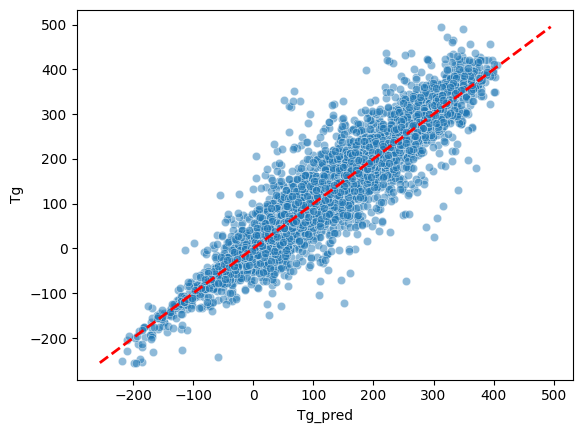

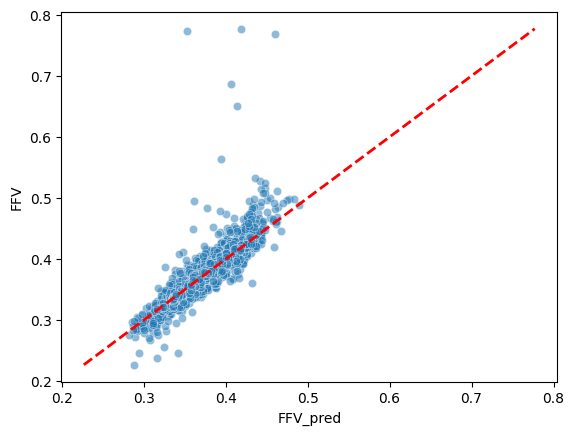

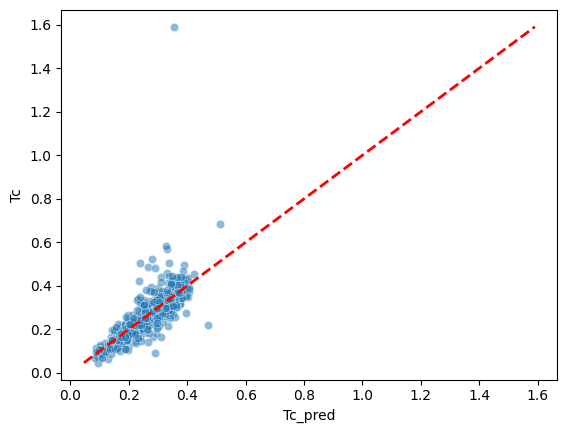

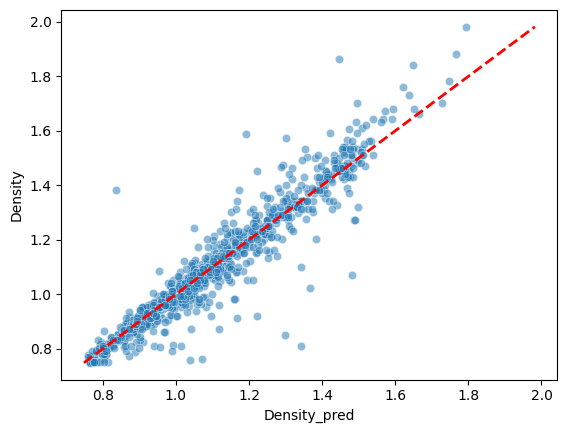

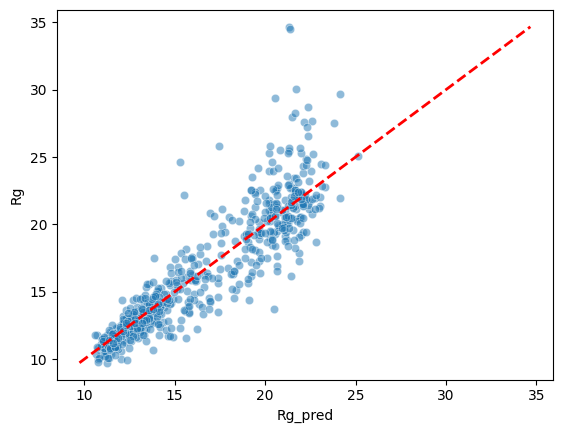

In [21]:
for t in CFG.TARGETS:
    preds = train[train[t].notnull()][f'{t}_pred']
    vals = train[train[t].notnull()][t]
    line_min = min(preds.min(), vals.min())
    line_max = max(preds.max(), vals.max())
    
    sns.scatterplot(x=preds, y=vals, alpha=0.5)
    plt.plot(
        [line_min, line_max], 
        [line_min, line_max], 
        color='red', 
        linewidth=2, 
        linestyle='dashed'
    )
    plt.show()

In [22]:
MINMAX_DICT =  {
        'Tg': [-148.0297376, 472.25],
        'FFV': [0.2269924, 0.77709707],
        'Tc': [0.0465, 0.524],
        'Density': [0.748691234, 1.840998909],
        'Rg': [9.7283551, 34.672905605],
    }
NULL_FOR_SUBMISSION = -9999

def scaling_error(labels, preds, property):
    error = np.abs(labels - preds)
    min_val, max_val = MINMAX_DICT[property]
    label_range = max_val - min_val
    return np.mean(error / label_range)

def get_property_weights(labels):
    property_weight = []
    for property in MINMAX_DICT.keys():
        valid_num = np.sum(labels[property] != NULL_FOR_SUBMISSION)
        property_weight.append(valid_num)
    property_weight = np.array(property_weight)
    property_weight = np.sqrt(1 / property_weight)
    return (property_weight / np.sum(property_weight)) * len(property_weight)

def wmae_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    chemical_properties = list(MINMAX_DICT.keys())
    property_maes = []
    property_weights = get_property_weights(solution[chemical_properties])
    for property in chemical_properties:
        is_labeled = solution[property] != NULL_FOR_SUBMISSION
        property_maes.append(scaling_error(solution.loc[is_labeled, property], submission.loc[is_labeled, property], property))

    if len(property_maes) == 0:
        raise RuntimeError('No labels')
    return float(np.average(property_maes, weights=property_weights))

tr_solution = train[['id'] + CFG.TARGETS]
tr_submission = train[['id'] + [t + '_pred' for t in CFG.TARGETS]]
tr_submission.columns = ['id'] + CFG.TARGETS
print(f"wMAE: {round(wmae_score(tr_solution, tr_submission, row_id_column_name='id'), 5)}")

wMAE: 0.03874


In [23]:
test[['id'] + CFG.TARGETS].to_csv('submission.csv', index=False)